# Stratified LD Score regression after heritability filter
## Checking heritability computed on DNAm

In [1]:
library(here)
library(data.table)
library(tidyverse)
library(parallel)
library(glue)
library(ggsci)

here() starts at /scratch/st-dennisjk-1/wcasazza/sex_specific_mQTL

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

Warning message:
“package ‘tibble’ was built under R version 4.1.1”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()


Attaching package: ‘glue’


The following object is masked from ‘package:dplyr’:

    collapse




probe      V(G)     V(e)     Vp       V(G)/Vp  logL    logL0   LRT    
1 cg00000029 0.014699 0.176618 0.191317 0.076832  41.664  37.479   8.370
2 cg00000108 0.336076 0.072536 0.408613 0.822481  90.523 -21.504 224.053
3 cg00000109 0.000000 0.080807 0.080807 0.000001 148.617 148.617   0.000
4 cg00000165 0.001287 0.106842 0.108129 0.011907 111.422 111.331   0.183
5 cg00000236 0.001661 0.059108 0.060769 0.027332 186.183 185.565   1.236
6 cg00000289 0.050336 0.071638 0.121974 0.412679 129.968 105.339  49.257
  Pval     V(G)_SE  V(e)_SE  Vp_SE    V(G)/Vp_SE
1 1.91e-03 0.010041 0.016250 0.017702 0.049899  
2 0.00e+00 0.069762 0.007647 0.069107 0.035863  
3 5.00e-01 0.001653 0.007277 0.007129 0.020453  
4 3.34e-01 0.003213 0.009780 0.009558 0.029633  
5 1.33e-01 0.002108 0.005383 0.005415 0.034262  
6 1.12e-12 0.015407 0.007401 0.015317 0.084071

[1] 164434

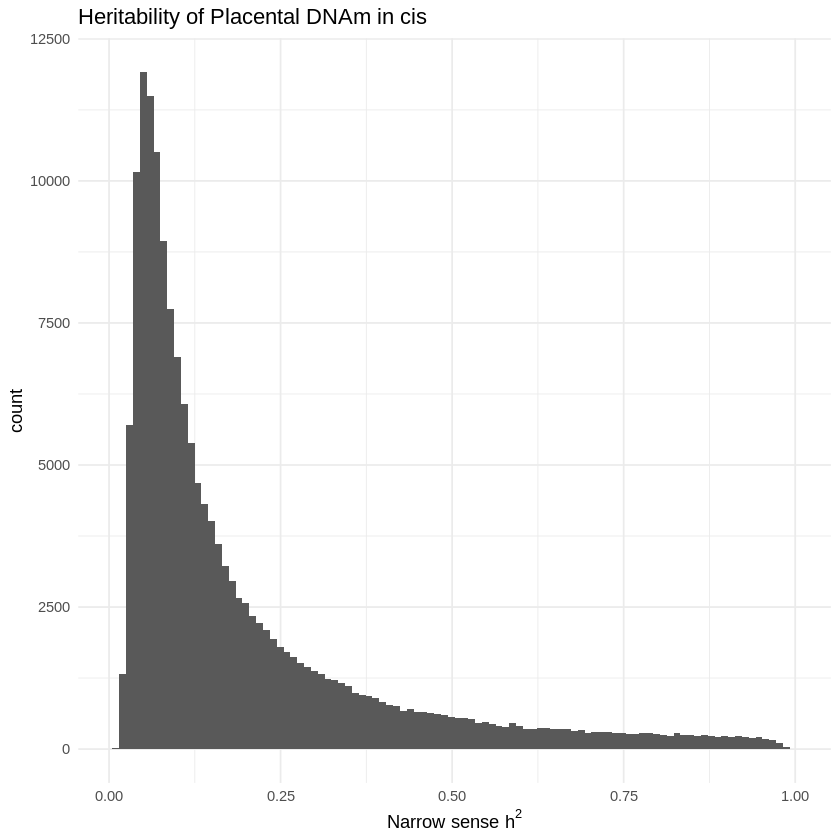

In [2]:
if(file.exists(here("data","cis_heritability.txt.gz"))){
    current_heritability <- fread(here("data","cis_heritability.txt.gz"))
}else{
    h_files <- dir(here("data", "gcta_analysis", "delahaye_output"))
    cpgs <- gsub(".hsq", "", h_files)

    read_heritability <- function(fname){
        dt <- fread(fname,fill=TRUE)
        main_cols <- transpose(dt[1:8,c(2)])
        colnames(main_cols) <- dt$Source[1:8]
        se_cols <- transpose(dt[1:4,c(3)])
        colnames(se_cols) <- paste0(dt$Source[1:4],"_SE")
        return(cbind(data.table(probe=gsub(".*/(.*).hsq","\\1",fname)),main_cols,se_cols))
    }
    current_heritability <- rbindlist(
        mclapply(
            here("data","gcta_analysis","delahaye_output",h_files),
            read_heritability,
            mc.cores = 32
        )
    )
   fwrite(current_heritability,here("data","cis_heritability.txt.gz"),sep='\t',quote=FALSE,row.names=FALSE)
}

head(current_heritability)

nrow(current_heritability[Pval < 0.10])
ggplot(current_heritability[Pval < 0.10],aes(x=`V(G)/Vp`)) +
    geom_histogram(bins=100)+
    labs(
        x = bquote(Narrow~sense~h^2),
        title = "Heritability of Placental DNAm in cis"
    )+
    theme_minimal()

## Create mQTL annotation filtering CAVIAR results with heritable CpGs

In [2]:
generate_annotation <- function(mQTL_annot, baseline_annot_f,chrom,annot){
    baseline_annot <- fread(baseline_annot_f)
    if(annot != "all_cis"){
        tmp <- mQTL_annot[current_heritability[Pval < 0.1]$probe,on="probe"][CHR == chrom]
    }
    if(annot == "bin_CPP"){
        merged <- merge(
            baseline_annot,
            tmp[,.(bin_CPP=ifelse(any(CPP>0),1,0)),by="SNP"],
            by="SNP",all.x=TRUE,sort = FALSE)
        merged[, `:=`(bin_CPP = ifelse(is.na(bin_CPP),0,bin_CPP))]
        return(merged[,.(CHR,BP,SNP,CM,bin_CPP)])    
    }else if(annot == "maxCPP"){
        merged <- merge(
            baseline_annot,
            tmp[,.(maxCPP=max(CPP)),by="SNP"],
               by="SNP",all.x=TRUE,sort = FALSE)
        merged[, `:=`(maxCPP = ifelse(is.na(maxCPP),0,maxCPP))]
        return(merged[,.(CHR,BP,SNP,CM,maxCPP)])    
    }else if (annot == "all_cis"){
        merged <- merge(
            baseline_annot,
            mQTL_annot[,.(all_cis=ifelse(any(FDR < 0.05),1,0)),by="SNP"],by="SNP",all.x=TRUE,sort = FALSE)
        merged[, `:=`(all_cis = ifelse(is.na(all_cis),0,all_cis))]
        return(merged[,.(CHR,BP,SNP,CM,all_cis)])    
        
    }else{
        print("NO ANNOTATION SELECTED")
        return(NULL)
    }
}

# build all annotations except male and female specific
for(annot in c("bin_CPP","maxCPP")){
    for(cur_mqtl in c("marginal","sex_interaction","male","female", "cord_mqtl")){
        if(cur_mqtl == "cord_mqtl"){
            mQTL_annot <- fread(glue("../data/{cur_mqtl}_caviar.txt.gz"))    
        }else{
            mQTL_annot <- fread(glue("../data/{cur_mqtl}_meta_caviar_maf01.txt.gz"))
        }
        cur_annot <- mclapply(
            1:22,
            function(i){
                generate_annotation(
                    mQTL_annot,
                    glue("../../1000G_v2.2_baseline/baselineLD.{i}.annot.gz"),
                    glue("{i}"),
                    annot
                )
            },
            mc.cores=16
        ) 
        mclapply(1:22, function(i)
            fwrite(
                cur_annot[[i]],
                glue("/scratch/st-dennisjk-1/wcasazza/1000G_phase3_ldsc/single_delahaye_annotations/{cur_mqtl}_{annot}_her.{i}.annot.gz"),
                sep='\t',quote=FALSE,row.names=FALSE
            ),
            mc.cores=16
        )
    }
}

# build all annotations except male and female specific for cis mQTL, FDR threshold
setDTthreads(2)
for(cur_mqtl in c("marginal","sex_interaction","male","female", "cord_mqtl")){
    if(cur_mqtl == "cord_mqtl"){
        mQTL_annot <- fread(glue("../../ariesmqtl/cord.ALL.M.tab"))    
    }else{
        mQTL_annot <- fread(glue("../data/delahaye_richs_{cur_mqtl}_mecs_maf01_FDR.txt.gz"))
    }
    cur_annot <- mclapply(
        1:22,
        function(i){
            generate_annotation(
                mQTL_annot,
                glue("../../1000G_v2.2_baseline/baselineLD.{i}.annot.gz"),
                glue("{i}"),
                "all_cis"
            )
        },
        mc.cores=8
    ) 
    mclapply(1:22, function(i)
        fwrite(
            cur_annot[[i]],
            glue("/scratch/st-dennisjk-1/wcasazza/1000G_phase3_ldsc/single_delahaye_annotations/{cur_mqtl}_all_cis_fdr.{i}.annot.gz"),
            sep='\t',quote=FALSE,row.names=FALSE
        ),
        mc.cores=8
    )
}

### Male and female specific binCPP annotations

In [5]:
generate_sex_specific_annotation <- function(mQTL_annot, baseline_annot_f,chrom,annot){
    baseline_annot <- fread(baseline_annot_f)
    if(annot == "bin_CPP"){
        tmp <- mQTL_annot[current_heritability[Pval < 0.1]$probe,on="probe"][CHR == chrom]
        merged <- merge(
            baseline_annot,
            tmp[,.(bin_CPP=ifelse(any(CPP>0),1,0)),by="SNP"],
            by="SNP",all.x=TRUE,sort = FALSE)
        merged[, `:=`(bin_CPP = ifelse(is.na(bin_CPP),0,bin_CPP))]
        return(merged[,.(CHR,BP,SNP,CM,bin_CPP)])    
    }else if (annot == "all_cis"){
        merged <- merge(
            baseline_annot,
            mQTL_annot[,.(all_cis=ifelse(any(FDR < 0.05),1,0)),by="SNP"],by="SNP",all.x=TRUE,sort = FALSE)
        merged[, `:=`(all_cis = ifelse(is.na(all_cis),0,all_cis))]
        return(merged[,.(CHR,BP,SNP,CM,all_cis)])    
        
    }else{
        print("NO ANNOTATION SELECTED")
        return(NULL)
    }
}
setDTthreads(8)
# annot <- "bin_CPP"
# sex_interaction_mqtl <- fread(glue("../data/sex_interaction_meta_caviar_maf01.txt.gz"))
# for(cur_mqtl in c("male","female")){
#     mQTL_annot <- fread(glue("../data/{cur_mqtl}_meta_caviar_maf01.txt.gz"))
#     mQTL_annot <- mQTL_annot[sex_interaction_mqtl[,.(SNP,probe)],on=c("SNP","probe"), nomatch=0]
#     cur_annot <- mclapply(
#         1:22,
#         function(i){
#             generate_sex_specific_annotation(
#                 mQTL_annot,
#                 glue("../../1000G_v2.2_baseline/baselineLD.{i}.annot.gz"),
#                 glue("{i}"),
#                 annot
#             )
#         },
#         mc.cores=8
#     ) 
#     mclapply(1:22, function(i)
#         fwrite(
#             cur_annot[[i]],
#             glue("/scratch/st-dennisjk-1/wcasazza/1000G_phase3_ldsc/single_delahaye_annotations/{cur_mqtl}_specific_{annot}_her.{i}.annot.gz"),
#             sep='\t',quote=FALSE,row.names=FALSE
#         ),
#         mc.cores=8
#     )
# }

sex_interaction_mqtl <- fread(glue("../data/delahaye_richs_sex_interaction_mecs_maf01_FDR.txt.gz"))
for(cur_mqtl in c("male","female")){
    mQTL_annot <- fread(glue("../data/delahaye_richs_{cur_mqtl}_mecs_maf01_FDR.txt.gz"))
    mQTL_annot <- mQTL_annot[sex_interaction_mqtl[,.(SNP,Probe)],on=c("SNP","Probe"), nomatch=0]
    cur_annot <- mclapply(
        1:22,
        function(i){
            generate_sex_specific_annotation(
                mQTL_annot[chr == i],
                glue("../../1000G_v2.2_baseline/baselineLD.{i}.annot.gz"),
                glue("{i}"),
                "all_cis"
            )
        },
        mc.cores=8
    ) 
    mclapply(1:22, function(i)
        fwrite(
            cur_annot[[i]],
            glue("/scratch/st-dennisjk-1/wcasazza/1000G_phase3_ldsc/single_delahaye_annotations/{cur_mqtl}_specific_all_cis_fdr.{i}.annot.gz"),
            sep='\t',quote=FALSE,row.names=FALSE
        ),
        mc.cores=8
    )
}

Warning message in fileAccess.default(parent, mode = 2):
“file.access(..., mode=2) and file(..., open="ab") gives different results (0 != -1). Will use the file() results: /tmp/M”


ERROR: [2021-10-20 15:27:08] Exception: Failed to create directory (tried 5 times), most likely because of lack of file permissions (directory '/tmp' exists but nothing beyond): /tmp/pbs.3103469.pbsha.ib.sockeye

Next steps carried out elsewhere:
1. Partition new LD scores
1. Compute stratified LD score regression with each annotation on PGC traits

## Plotting new LDSC results
### Data preparation

In [2]:
gwas_sample_sizes <- function(f){
    N <- fread(f,nrows=1)$N
    GWAS <- str_match(f,".*/(.*).sumstats.gz")[2]
    return(data.table(GWAS=GWAS,N=N))
}
part_heritability_results_independent <- function(path){
    part_heritability <- rbindlist(lapply(
          dir(
            path,
            pattern = "[marginal|sex_interaction|cord_mqtl|male_specific|female_specific|male|female]_bin_CPP_her_.*.results$",
            full.names = TRUE
          ),
          function(f) {
            labels <- str_match(f, ".*/(marginal|sex_interaction|cord_mqtl|male_specific|female_specific|male|female)_(bin_CPP_her)_(.*).results$")[-c(1)]
            if (any(is.na(labels))) {
              return(data.table())
            } else {
              dt <- fread(f)[1, !"Category"]
              dt[, 
                `:=`(
                  Coefficient_p=pnorm(abs(`Coefficient_z-score`),lower.tail=F)*2,
                  mQTL_group = labels[1],
                  annotation = labels[2],
                  GWAS = labels[3])]
              return(dt)
            }
          }
        ))
    log_files <- dir(
        path,
        pattern = glue(".*.log$"),
        full.names = TRUE
    )
    log_files <-log_files[!grepl("_shared",log_files)]
    heritability <- rbindlist(lapply(
      dir(
        path,
        pattern = glue(".*.log$"),
        full.names = TRUE,
        
      ),
      function(f) {
        labels <- str_match(f, glue(".*/(marginal|sex_interaction|cord_mqtl|male_specific|female_specific|male|female)_(all_cis_fdr|bin_CPP_her|maxCPP_her)_(.*).log"))[-c(1)]
        if (any(is.na(labels))) {
          return(data.table())
        } else if (nrow(part_heritability[GWAS == labels[3] & annotation == labels[2]]) == 0 ){
          return(data.table())
        }
        else {
          dat <- readLines(f)
          dt <- data.table(
            h2 = as.numeric(str_extract_all(dat[grepl("Total Observed",dat)],"-*\\d+.\\d+")[[1]][1]),
            h2_std_error = as.numeric(str_extract_all(dat[grepl("Total Observed",dat)],"\\d+.\\d+")[[1]][2]),
            total_SNP = as.numeric(str_match(dat[grepl("SNPs remain)", dat)],"\\((\\d+)")[1,2]),
            annotation = labels[2],
            GWAS = labels[3]
          )
          return(dt)
        }
      }
    ))
    heritability <- heritability[which(!duplicated(GWAS))]
    result <- merge(part_heritability,heritability,by=c("GWAS","annotation"))
    return(result)
}

part_heritability_results <- function(path,modifier){
    part_heritability <- rbindlist(lapply(
      dir(
        path,
        pattern = glue(".*{modifier}.results$"),
        full.names = TRUE
      ),
      function(f) {
        labels <- str_match(f, glue(".*/(all_cis_fdr|bin_CPP_her|maxCPP_her)_(.*){modifier}.results"))[-c(1)]
        if (any(is.na(labels))) {zzzzzzz
          return(data.table())
        } else {
          dt <- fread(f)
          dt[, 
            `:=`(
              Coefficient_p=pnorm(abs(`Coefficient_z-score`),lower.tail=F)*2,
              annotation = labels[1],
              GWAS = labels[2])]
          return(dt)
        }
      }
    ))
    heritability <- rbindlist(lapply(
      dir(
        path,
        pattern = glue(".*{modifier}.log$"),
        full.names = TRUE
      ),
      function(f) {
        labels <- str_match(f, glue(".*/(bin_CPP_her)_(.*){modifier}.log"))[-c(1)]
        if (any(is.na(labels))) {
          return(data.table())
        } else if (nrow(part_heritability[GWAS == labels[2] & annotation == labels[1]]) == 0 ){
          return(data.table())
        }
        else {
          dat <- readLines(f)
          dt <- data.table(
            h2 = as.numeric(str_extract_all(dat[grepl("Total Observed",dat)],"-*\\d+.\\d+")[[1]][1]),
            h2_std_error = as.numeric(str_extract_all(dat[grepl("Total Observed",dat)],"\\d+.\\d+")[[1]][2]),
            total_SNP = as.numeric(str_match(dat[grepl("SNPs remain)", dat)],"\\((\\d+)")[1,2]),
            annotation = labels[1],
            GWAS = labels[2]
          )
          return(dt)
        }
      }
    ))
    result <- merge(part_heritability,heritability,by=c("GWAS","annotation"))
    return(result)
}
annotation_SD <- function(path,file_pattern){
    annots <- rbindlist(mclapply(dir(path,full.names=TRUE,pattern=file_pattern),function(f) fread(f),mc.cores=22))
    return(apply(annots[,-c(1,2,3,4)],2,sd))    
}
pgc_part_heritability_independent_df <- part_heritability_results_independent("/scratch/st-dennisjk-1/wcasazza/delahaye_QC/ldsc_meta_EUR_pgc_original_baseline/")
neonatal_part_heritability_independent_df <- part_heritability_results_independent("/scratch/st-dennisjk-1/wcasazza/delahaye_QC/ldsc_meta_EUR_neonatal_original_baseline/")
tmp_test <-pgc_part_heritability_independent_df
pgc_part_heritability_df <- part_heritability_results("/scratch/st-dennisjk-1/wcasazza/delahaye_QC/ldsc_meta_EUR_pgc_results/","_shared")
pgc_part_heritability_baseline_df <- part_heritability_results("/scratch/st-dennisjk-1/wcasazza/delahaye_QC/ldsc_meta_EUR_pgc_original_baseline/","_shared")
pgc_part_heritability_baseline_sex_df <- part_heritability_results("/scratch/st-dennisjk-1/wcasazza/delahaye_QC/ldsc_meta_EUR_pgc_original_baseline/","_shared_no_interaction")
neonatal_part_heritability_sex_df <- part_heritability_results("/scratch/st-dennisjk-1/wcasazza/delahaye_QC/ldsc_meta_EUR_neonatal_original_baseline/","_shared_no_interaction")
neonatal_part_heritability_df <- part_heritability_results("/scratch/st-dennisjk-1/wcasazza/delahaye_QC/ldsc_meta_EUR_neonatal_original_baseline/","_shared_sex_stratified")
                                 
pgc_GWAS_key <- c(
    "adhd_jul2017" = "ADHD",
    "pgc_adhd_males" = "ADHD Males",
    "pgc_adhd_females" = "ADHD Females",
    "pts_all_freeze2_overall.results" = "PTSD",
    "pts_all_freeze2_males.results" = "PTSD Males",
    "pts_all_freeze2_females.results" = "PTSD Females",
    "iPSYCH-PGC_ASD_Nov2017" = "ASD",
    "NEW_META_PGC_iPSYCH_ASD_males" = "ASD Males",
    "NEW_META_PGC_iPSYCH_ASD_females" = "ASD Females",
    "PGC_UKB_depression_genome-wide.txt" = "MDD",
    "meta_STDERR_mdd_eur_auto_M1_08_gcOFF_pgc.txt" = "MDD Males",
    "meta_STDERR_mdd_eur_auto_F1_08_gcOFF_pgc.txt" = "MDD Females",
    "meta_STDERR_rmdd_eur_auto_M1_08_gcOFF_pgc.txt.gz" = "RMDD Males",
    "meta_STDERR_rmdd_eur_auto_F1_08_gcOFF_pgc.txt.gz" = "RMDD Females",
    "ocd_aug2017" = "OCD",
    "OCD_meta_male_auto_072416.gz" = "OCD Males",
    "OCD_meta_female_auto_072416.gz" = "OCD Females",
    "anxiety.meta.full.cc.tbl" = "ANX",
    "ukbb_anxiety.gwas.imputed_v3.both_sexes.tsv.gz.fixed" = "UKBB-ANX",
    "ukbb_anxiety.gwas.imputed_v3.male.tsv.gz.fixed" = "UKBB-ANX Males",
    "ukbb_anxiety.gwas.imputed_v3.female.tsv.gz.fixed" = "UKBB-ANX Females",
    "anxiety.meta.full.fs.tbl" = "ANXFS",
    "pgc_bip_2018" = "BIP",
    "meta_STDERR_bip_eur_auto_M1_08_gcOFF_pgc.txt.gz" = "BIP Males",
    "meta_STDERR_bip_eur_auto_F1_08_gcOFF_pgc.txt.gz" = "BIP Females",
    "PGC3_SCZ_wave3_public.v2.tsv" = "SCZ",
    "meta_STDERR_scz_eur_auto_M1_08_gcOFF_pgc.txt.gz" = "SCZ Males",
    "meta_STDERR_scz_eur_auto_F1_08_gcOFF_pgc.txt.gz" = "SCZ Females",
    "pgcAN2.2019-07.vcf.tsv" = "AN",
    "TS_Oct2018" = "TS",
    "pgc.cross.full.2013-03.txt" = "Cross Disorder",
    "AUDIT_UKB_2018_AJP.txt" = "Alcohol (AUDIT)",
    "pgc_alcdep.eur_unrelated.aug2018_release.txt" = "ALC",
    "Cannabis_ICC_23andmetop_UKB_het.txt" = "CUD",
    "tag.cpd.tbl" = "Cigarettes Per Day"
)
neonatal_GWAS_key <- c(
    "age_asthma_irnt.gwas.imputed_v3.both_sexes.tsv" = "ASTHMA Age(norm)",
    "age_asthma_irnt.gwas.imputed_v3.female.tsv" = "ASTHMA Age(norm) Females",
    "age_asthma_irnt.gwas.imputed_v3.male.tsv"= "ASTHMA Age(norm) Males",
    "age_asthma_raw.gwas.imputed_v3.both_sexes.tsv" = "ASTHMA Age(raw)",
    "age_asthma_raw.gwas.imputed_v3.female.tsv" = "ASTHMA Age(raw) Females",
    "age_asthma_raw.gwas.imputed_v3.male.tsv" = "ASTHMA Age(raw) Males",
    "age_diabetes_irnt.gwas.imputed_v3.both_sexes.tsv" = "DIABETES Age(norm)",
    "age_diabetes_irnt.gwas.imputed_v3.female.tsv"= "DIABETES Age(norm) Females",
    "age_diabetes_irnt.gwas.imputed_v3.male.tsv"= "DIABETES Age(norm) Males",
    "age_diabetes_raw.gwas.imputed_v3.both_sexes.tsv"= "DIABETES Age(raw)",
    "age_diabetes_raw.gwas.imputed_v3.female.tsv"= "DIABETES Age(raw) Females",
    "age_diabetes_raw.gwas.imputed_v3.male.tsv"= "DIABETES Age(raw) Males",
    "T1D.UCSC_META" = "Type 1 Diabetes",
    "age_hay_fever_irnt.gwas.imputed_v3.both_sexes.tsv"= "HAYFEVER Age(norm)",
    "age_hay_fever_irnt.gwas.imputed_v3.female.tsv"= "HAYFEVER Age(norm) Females",
    "age_hay_fever_irnt.gwas.imputed_v3.male.tsv"= "HAYFEVER Age(norm) Males",
    "age_hay_fever_raw.gwas.imputed_v3.both_sexes.tsv"= "HAYFEVER Age(raw)",
    "age_hay_fever_raw.gwas.imputed_v3.female.tsv"= "HAYFEVER Age(raw) Females",
    "age_hay_fever_raw.gwas.imputed_v3.male.tsv"= "HAYFEVER Age(raw) Males",
    "CHILD_ONSET_ASTHMA.20180501.allchr.assoc.GC" = "CHILD ONSET ASTHMA",
    "EGG_BMI_HapMap_DISCOVERY.txt" = "Child BMI",
    "EGG_HC_DISCOVERY.v2.txt" = "Head Circumference",
    "EGG_Obesity_Meta_Analysis_1.txt" = "Child Obesity",
    "EGG_TANNER_females.v2.txt" = "TANNER Stage Females",
    "EGG_TANNER_males_and_females_combined.v2.txt" = "TANNER Stage",
    "EGG_TANNER_males.v2.txt" = "TANNER Stage Males",
    "EGG-TotalGWG-Offspring.txt" = "Gestational Weight Gain",
    "Pubertal_growth_10F_12M_combined.txt" = "Pubertal Growth Start",
    "Pubertal_growth_10F.txt" = "Pubertal Growth Start Females",
    "Pubertal_growth_12M.txt" = "Pubertal Growth Start Males",
    "Pubertal_growth_PGF_PGM_combined.txt" = "Total Pubertal Growth",
    "Pubertal_growth_PGF.txt" = "Total Pubertal Growth Females",
    "Pubertal_growth_PGM.txt" = "Total Pubertal Growth Males",
    "Pubertal_growth_PTF_PTM_combined.txt" = "Late Pubertal Growth",
    "Pubertal_growth_PTF.txt" = "Late Pubertal Growth Females",
    "Pubertal_growth_PTM.txt" = "Late Pubertal Growth Males",
    "ukbb_preeclampsia.gwas.imputed_v3.female.tsv"= "Maternal Pre-Eclampsia (UKBB)",
    "interpreggen.fetal.pe.meta.release.31jan2017"= "Fetal Pre-Eclampsia",
    "mat_all_chrALL_STERR_EU"="Maternal Pre-Eclampsia"
)
compulsive <- c(
    "pgcAN2.2019-07.vcf.tsv" = "AN",
    "ocd_aug2017" = "OCD",
    "TS_Oct2018" = "TS"
)
psychotic <- c(
    "pgc_bip_2018" = "BIP",
    "PGC3_SCZ_wave3_public.v2.tsv" = "SCZ",
    "pgc_alcdep.eur_unrelated.aug2018_release.txt" = "ALC"
)
neurodevelopmental <- c(
    "TS_Oct2018" = "TS",
    "pgc_alcdep.eur_unrelated.aug2018_release.txt" = "ALC",
    "adhd_jul2017" = "ADHD",
    "iPSYCH-PGC_ASD_Nov2017" = "ASD",
    "pts_all_freeze2_overall.results" = "PTSD",
    "PGC_UKB_depression_genome-wide.txt" = "MDD"
)
internalizing <- c(
    "pts_all_freeze2_overall.results" = "PTSD",
    "PGC_UKB_depression_genome-wide.txt" = "MDD",
    "anxiety.meta.full.cc.tbl" = "ANX",
    "anxiety.meta.full.fs.tbl" = "ANXFS"
)
substance_set <- c(
    "pgc_alcdep.eur_unrelated.aug2018_release.txt" = "ALqC",
    "Cannabis_ICC_23andmetop_UKB_het.txt" = "Cannabis",
    "tag.cpd.tbl" = "Cigarettes Per Day",
    "AUDIT_UKB_2018_AJP.txt" = "Alcohol (AUDIT)"
)

sex_stratified_set <- c(
    "adhd_jul2017" = "ADHD",
    "pgc_adhd_males" = "ADHD Males",
    "pgc_adhd_females" = "ADHD Females",
    "pts_all_freeze2_overall.results" = "PTSD",
    "pts_all_freeze2_males.results" = "PTSD Males",
    "pts_all_freeze2_females.results" = "PTSD Females",
    "iPSYCH-PGC_ASD_Nov2017" = "ASD",
    "NEW_META_PGC_iPSYCH_ASD_males" = "ASD Males",
    "NEW_META_PGC_iPSYCH_ASD_females" = "ASD Females",
    "PGC_UKB_depression_genome-wide.txt" = "MDD",
    "meta_STDERR_mdd_eur_auto_M1_08_gcOFF_pgc.txt" = "MDD Males",
    "meta_STDERR_mdd_eur_auto_F1_08_gcOFF_pgc.txt" = "MDD Females"
)
                                 
                                 
                                 
neonatal_part_heritability_independent_df <- neonatal_part_heritability_independent_df %>% mutate(
        significant_coef = Coefficient_p < 0.05, 
        significant_enrich = Enrichment_p < 0.05,
        GWAS = recode(GWAS, !!!neonatal_GWAS_key),
        Category = recode(mQTL_group,marginal="Cross-sex",sex_interaction="Sex dependent", male_specific = "Male Specific", female_specific= "Female Specific",male= "Male Stratified", female="Female Stratified", cord_mqtl='Cord Blood')
    ) %>%
    mutate(GWAS = factor(GWAS,levels=neonatal_GWAS_key)) %>% na.omit()
                                 
pgc_part_heritability_independent_df <- pgc_part_heritability_independent_df %>% mutate(
        significant_coef = Coefficient_p < 0.05, 
        significant_enrich = Enrichment_p < 0.05,
        GWAS = recode(GWAS, !!!pgc_GWAS_key),
        Category = recode(mQTL_group,marginal="Cross-sex",sex_interaction="Sex dependent", male_specific = "Male Specific", female_specific= "Female Specific",male= "Male Stratified", female="Female Stratified", cord_mqtl='Cord Blood')
    ) %>%
    mutate(GWAS = factor(GWAS,levels=pgc_GWAS_key))  %>% na.omit()
                                 
pgc_part_heritability_df <- pgc_part_heritability_df %>% mutate(
        significant_coef = Coefficient_p < 0.05, 
        significant_enrich = Enrichment_p < 0.05,
        GWAS = recode(GWAS, !!!pgc_GWAS_key),
        Category = recode(Category,L2_0="Marginal",L2_1="Sex Interaction", L2_2= "Male", L2_3="Female", L2_4='Cord Blood')
    ) %>%
    mutate(GWAS = factor(GWAS,levels=pgc_GWAS_key))
pgc_part_heritability_baseline_df <- pgc_part_heritability_baseline_df %>% mutate(
        significant_coef = Coefficient_p < 0.05, 
        significant_enrich = Enrichment_p < 0.05,
        GWAS = recode(GWAS, !!!pgc_GWAS_key),
        Category = recode(Category,L2_0="Marginal",L2_1="Sex Interaction", L2_2= "Male", L2_3="Female", L2_4='Cord Blood')
    ) %>%
    mutate(GWAS = factor(GWAS,levels=pgc_GWAS_key))
pgc_part_heritability_baseline_sex_df <- pgc_part_heritability_baseline_sex_df %>% mutate(
        significant_coef = Coefficient_p < 0.05, 
        significant_enrich = Enrichment_p < 0.05,
        GWAS = recode(GWAS, !!!pgc_GWAS_key),
        Category = recode(Category,L2_0="Marginal",L2_1= "Male Specific", L2_2="Female Specific", L2_3='Cord Blood')
    ) %>%
    mutate(GWAS = factor(GWAS,levels=pgc_GWAS_key))
neonatal_part_heritability_sex_df <- neonatal_part_heritability_sex_df %>% mutate(
        significant_coef = Coefficient_p < 0.05, 
        significant_enrich = Enrichment_p < 0.05,
        GWAS = recode(GWAS, !!!neonatal_GWAS_key),
        Category = recode(Category,L2_0="Marginal",L2_1= "Male Specific", L2_2="Female Specific", L2_3='Cord Blood')
    ) %>%
    mutate(GWAS = factor(GWAS,levels=neonatal_GWAS_key))
neonatal_part_heritability_df <- neonatal_part_heritability_df %>% mutate(
        significant_coef = Coefficient_p < 0.05, 
        significant_enrich = Enrichment_p < 0.05,
        GWAS = recode(GWAS, !!!neonatal_GWAS_key),
        Category = recode(Category,L2_0="Marginal",L2_1="Sex Interaction", L2_2= "Male", L2_3="Female", L2_4='Cord Blood')
    ) %>%
    mutate(GWAS = factor(GWAS,levels=neonatal_GWAS_key))                               

### Plotting trait-level heritability

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -5.277   1.545   3.091   4.530   6.122  23.375 

[1] "ADHD"                          "ADHD Females"                 
 [3] "ADHD Males"                    "AN"                           
 [5] "ASD"                           "ASD Males"                    
 [7] "ASTHMA Age(norm)"              "ASTHMA Age(norm) Females"     
 [9] "ASTHMA Age(norm) Males"        "ASTHMA Age(raw)"              
[11] "ASTHMA Age(raw) Females"       "ASTHMA Age(raw) Males"        
[13] "Cannabis"                      "Child BMI"                    
[15] "Child Obesity"                 "CHILD ONSET ASTHMA"           
[17] "Fetal Pre-Eclampsia"           "HAYFEVER Age(norm)"           
[19] "HAYFEVER Age(norm) Females"    "HAYFEVER Age(raw)"            
[21] "HAYFEVER Age(raw) Females"     "Head Circumference"           
[23] "Late Pubertal Growth"          "Late Pubertal Growth Males"   
[25] "OCD"                           "OCD Females"                  
[27] "Pubertal Growth Start"         "Pubertal Growth Start Females"
[29] "Pubertal Growth Start Males"   "SCZ"                          
[31] "SCZ Females"                   "SCZ Males"                    
[33] "Total Pubertal Growth"         "Total Pubertal Growth Females"
[35] "Total Pubertal Growth Males"   "TS"                           
[37] "Type 1 Diabetes"

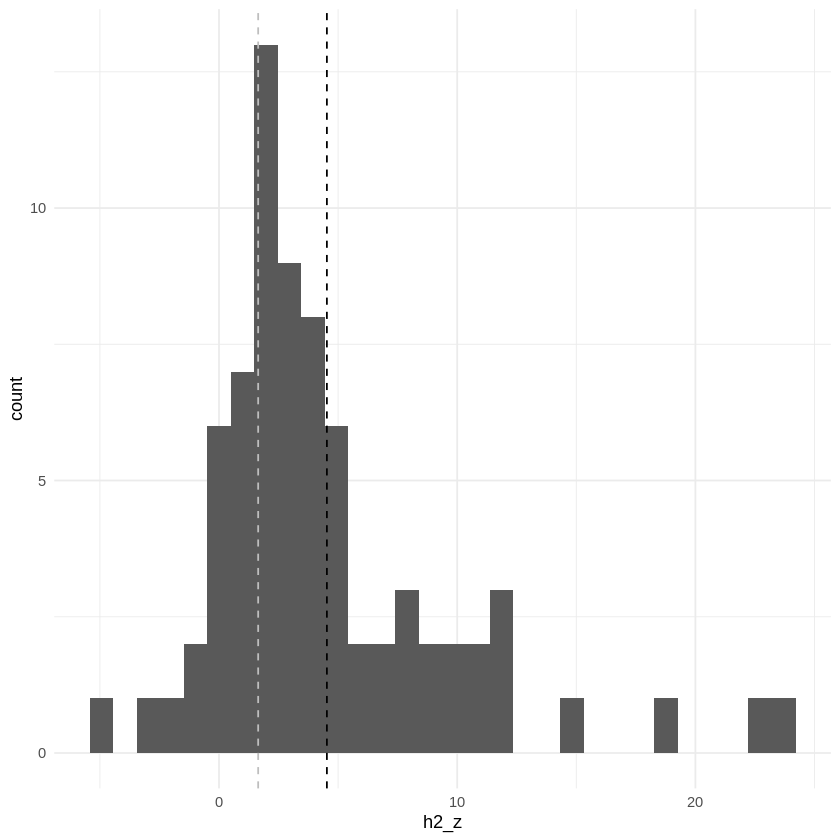

In [3]:
trait_metadata <- fread(here("data","misc_sex_biased_mqtl_tables - GWAS-info.csv"))
selected_GWAS <- trait_metadata[`Median age of onset < 25?` & h2_z  > abs(qnorm(0.05))]$GWAS
ggplot(trait_metadata, aes(h2_z)) + 
    geom_histogram() + 
    geom_vline(xintercept = mean(trait_metadata$h2_z),linetype="dashed")+
    geom_vline(xintercept = abs(qnorm(0.05)),linetype="dashed",color="gray")+
    theme_minimal()

summary(trait_metadata$h2_z)
selected_GWAS

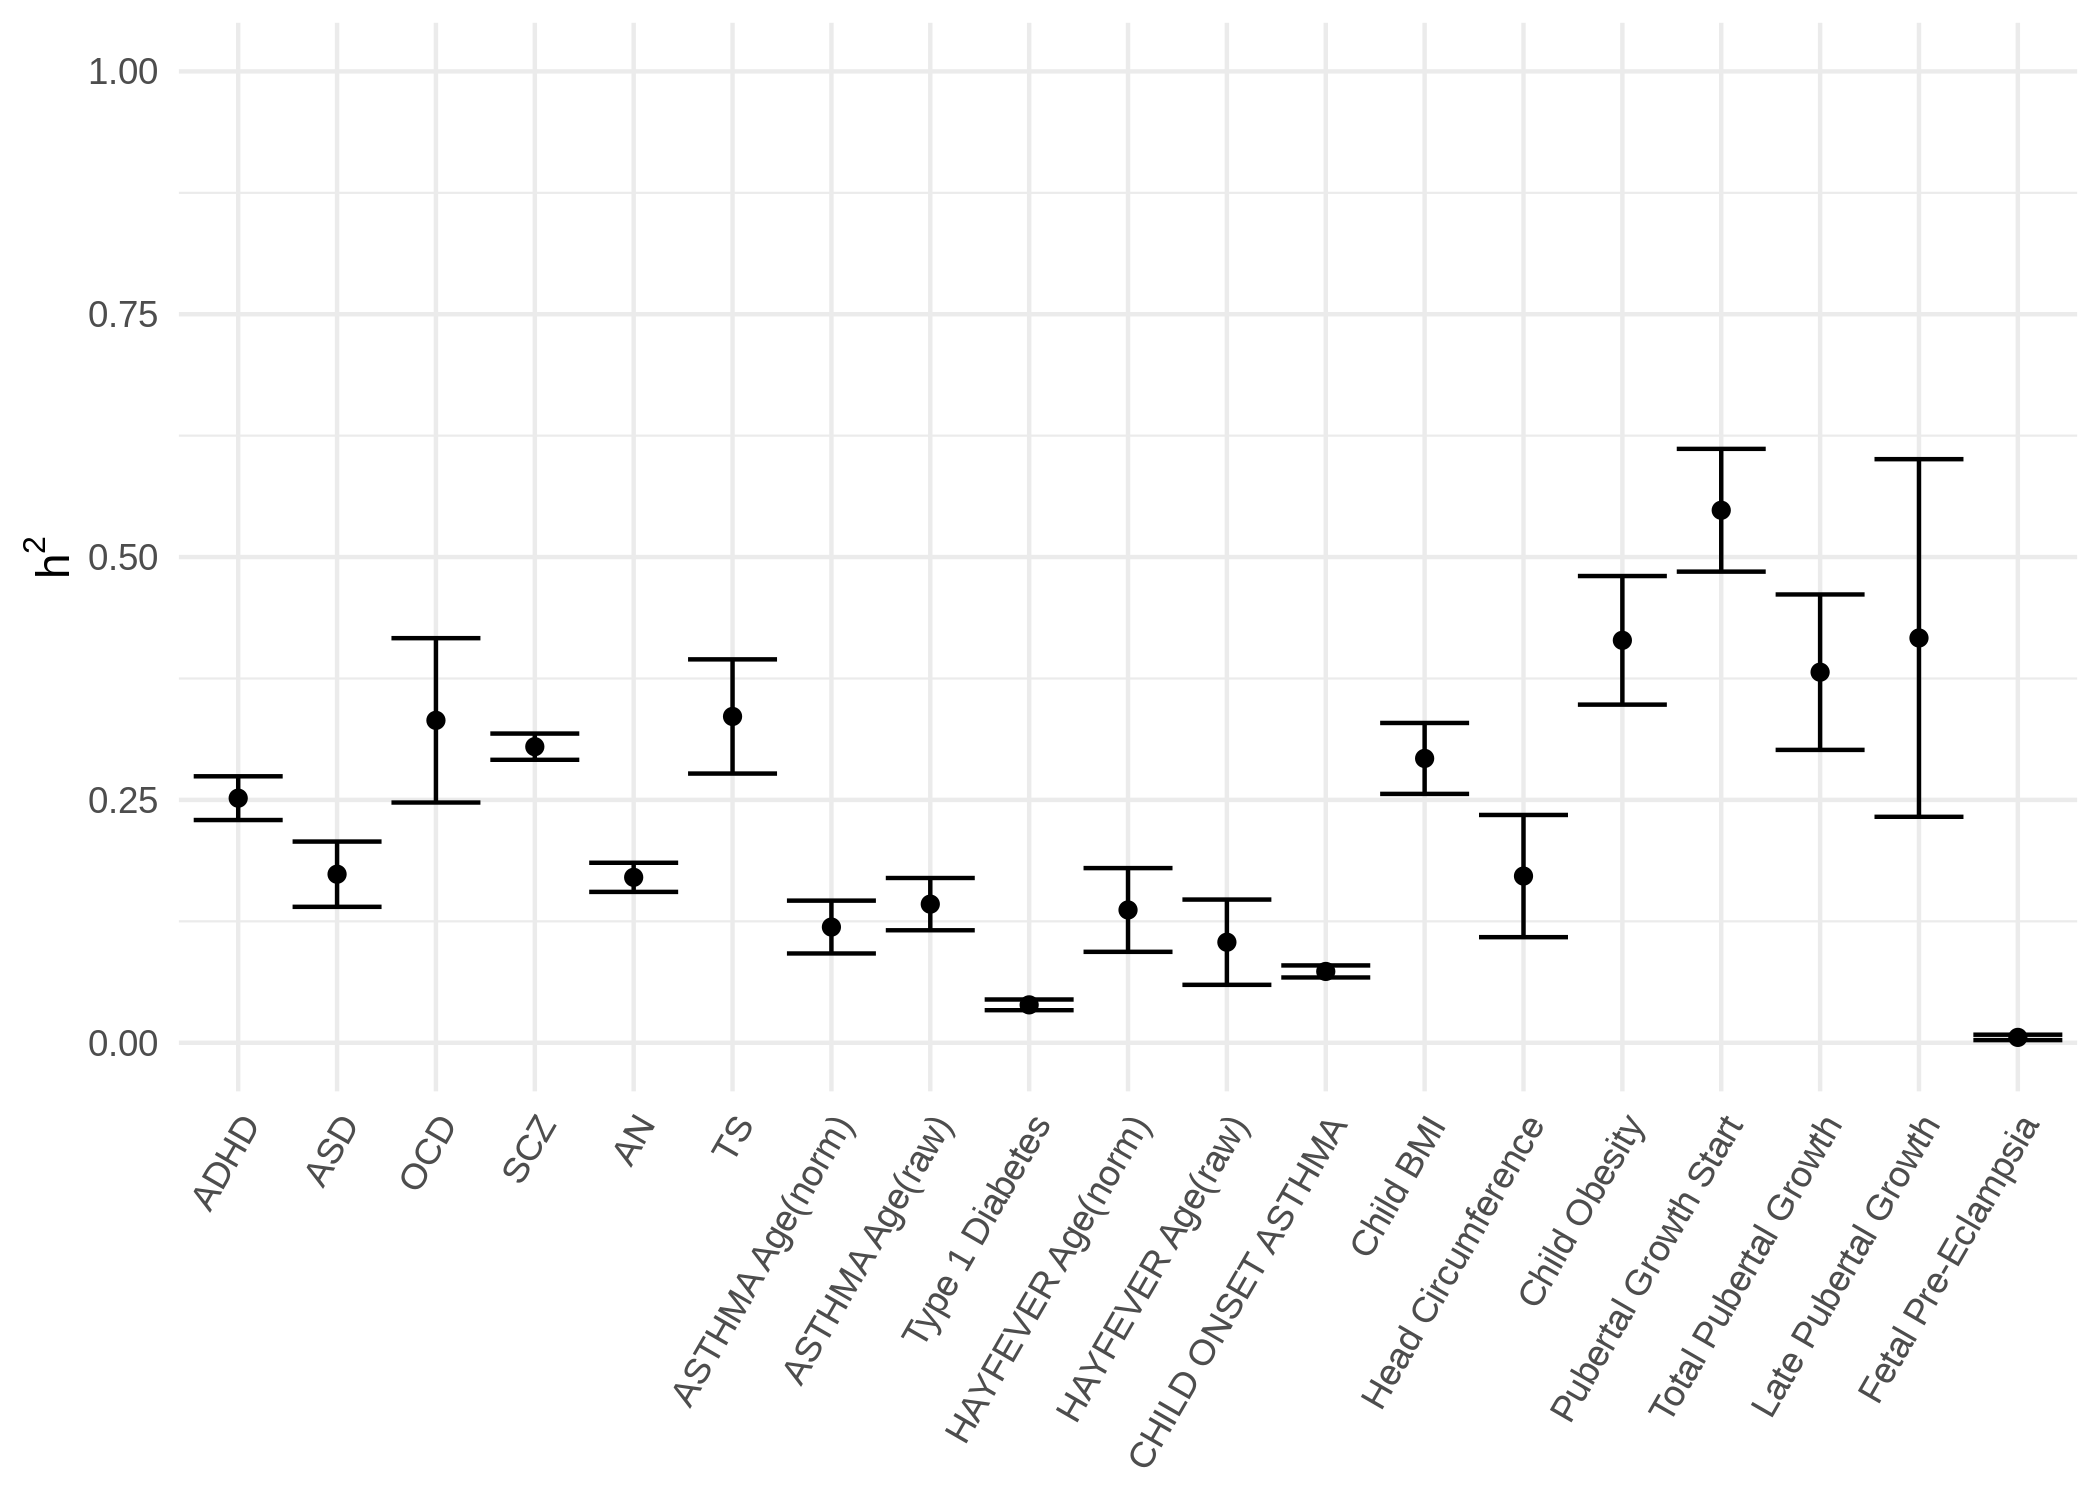

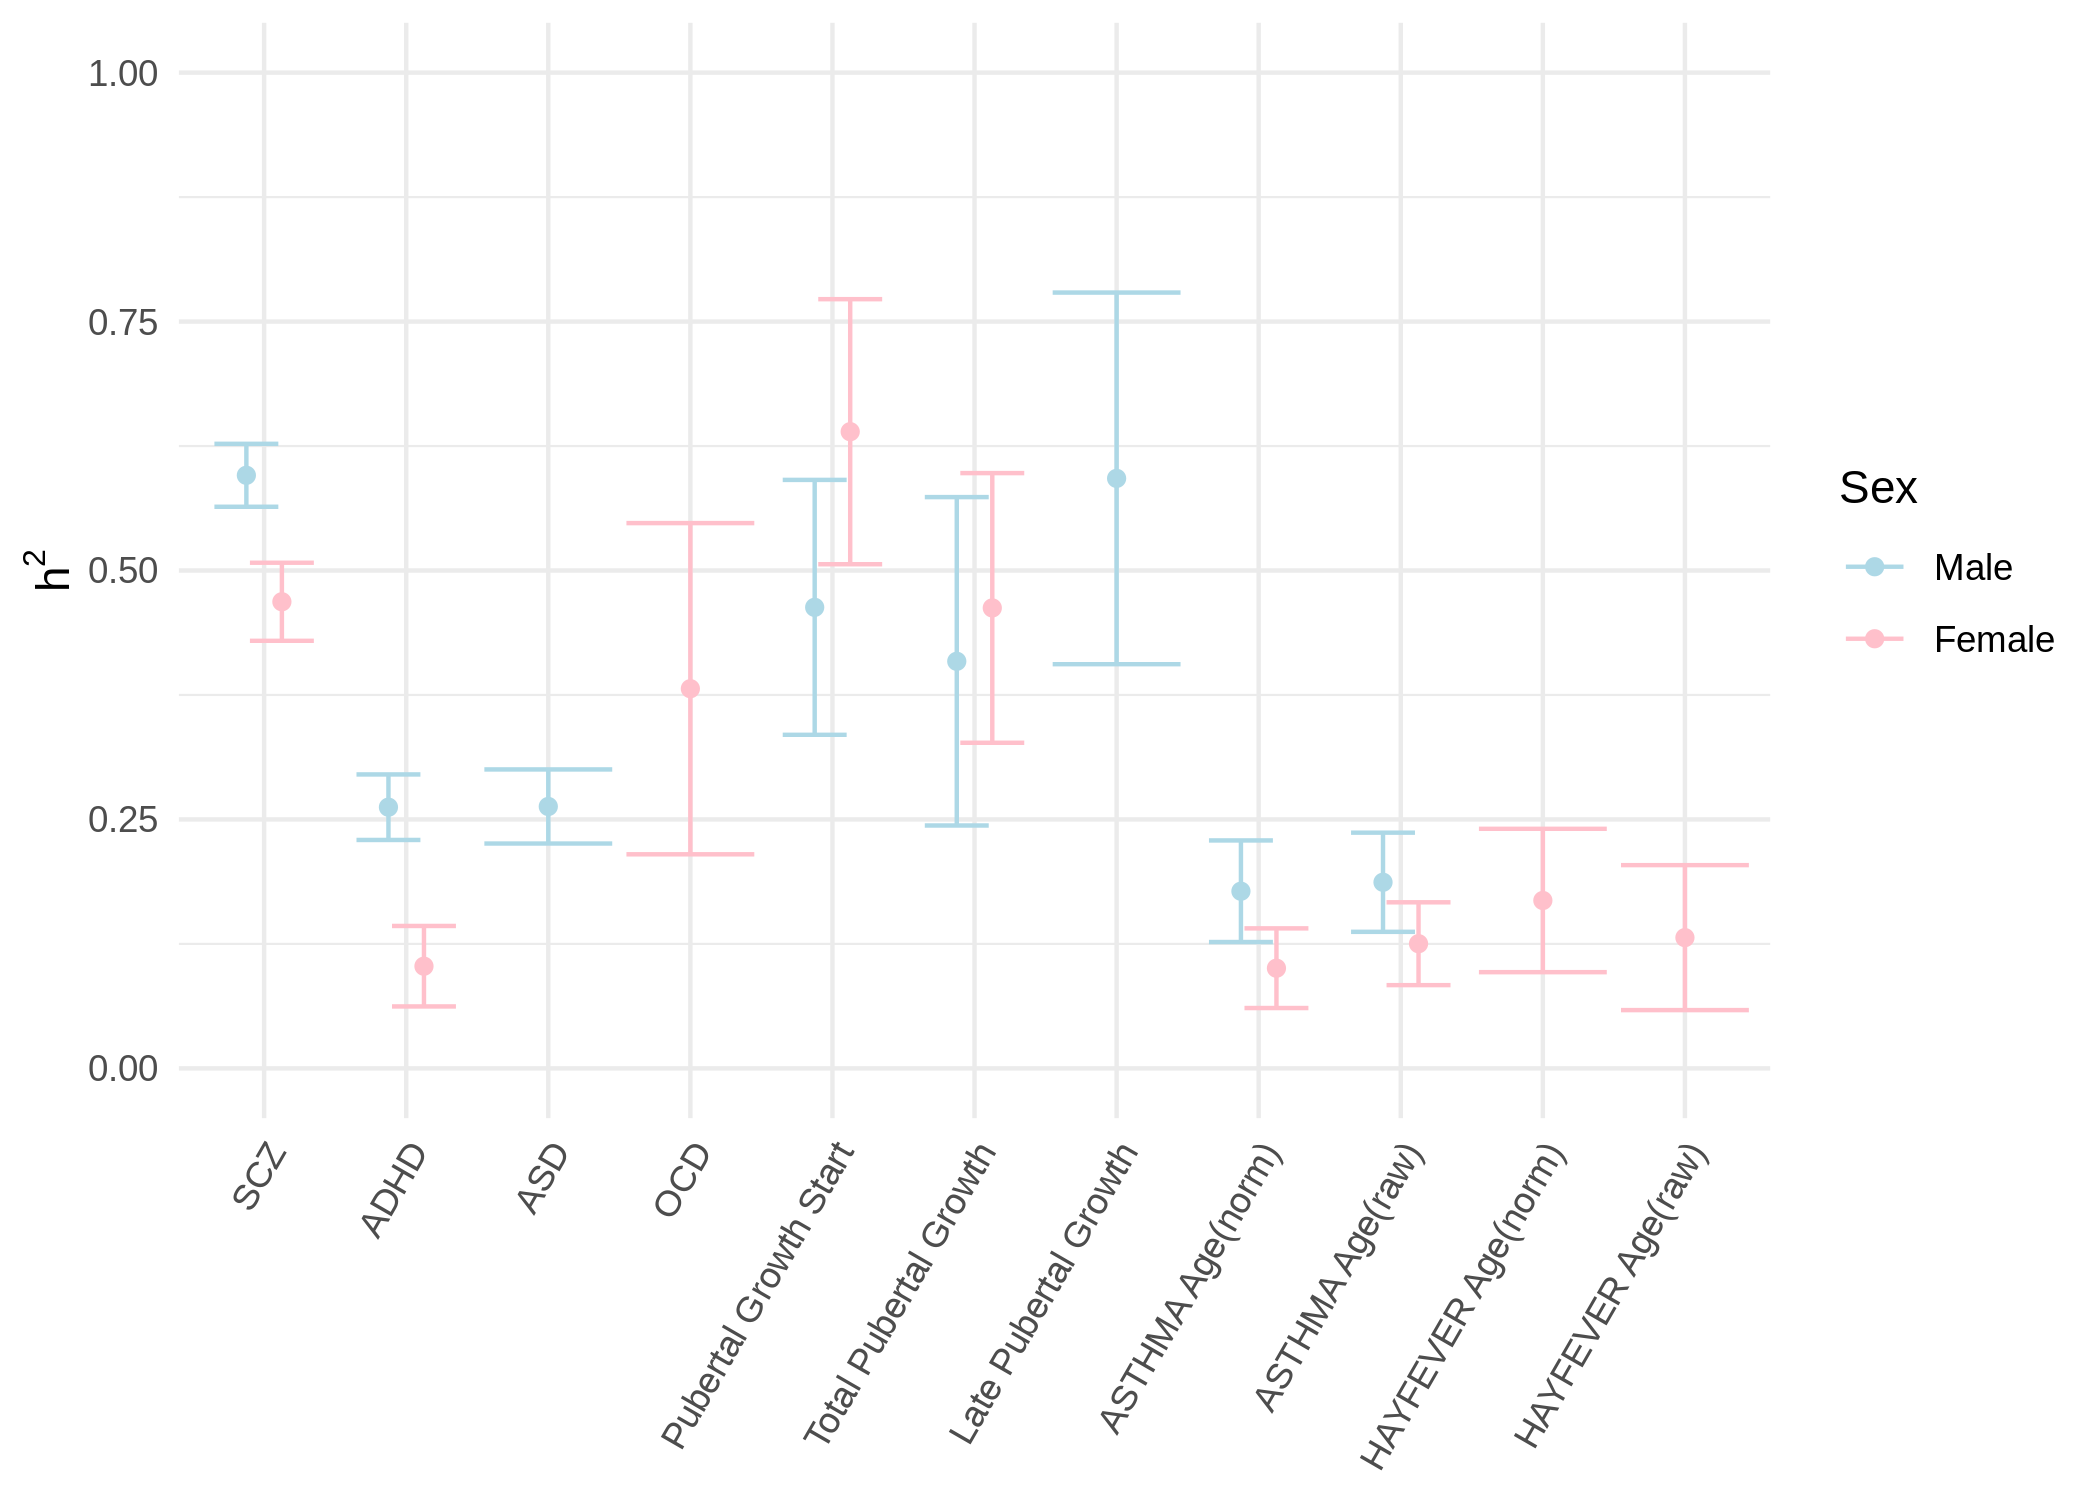

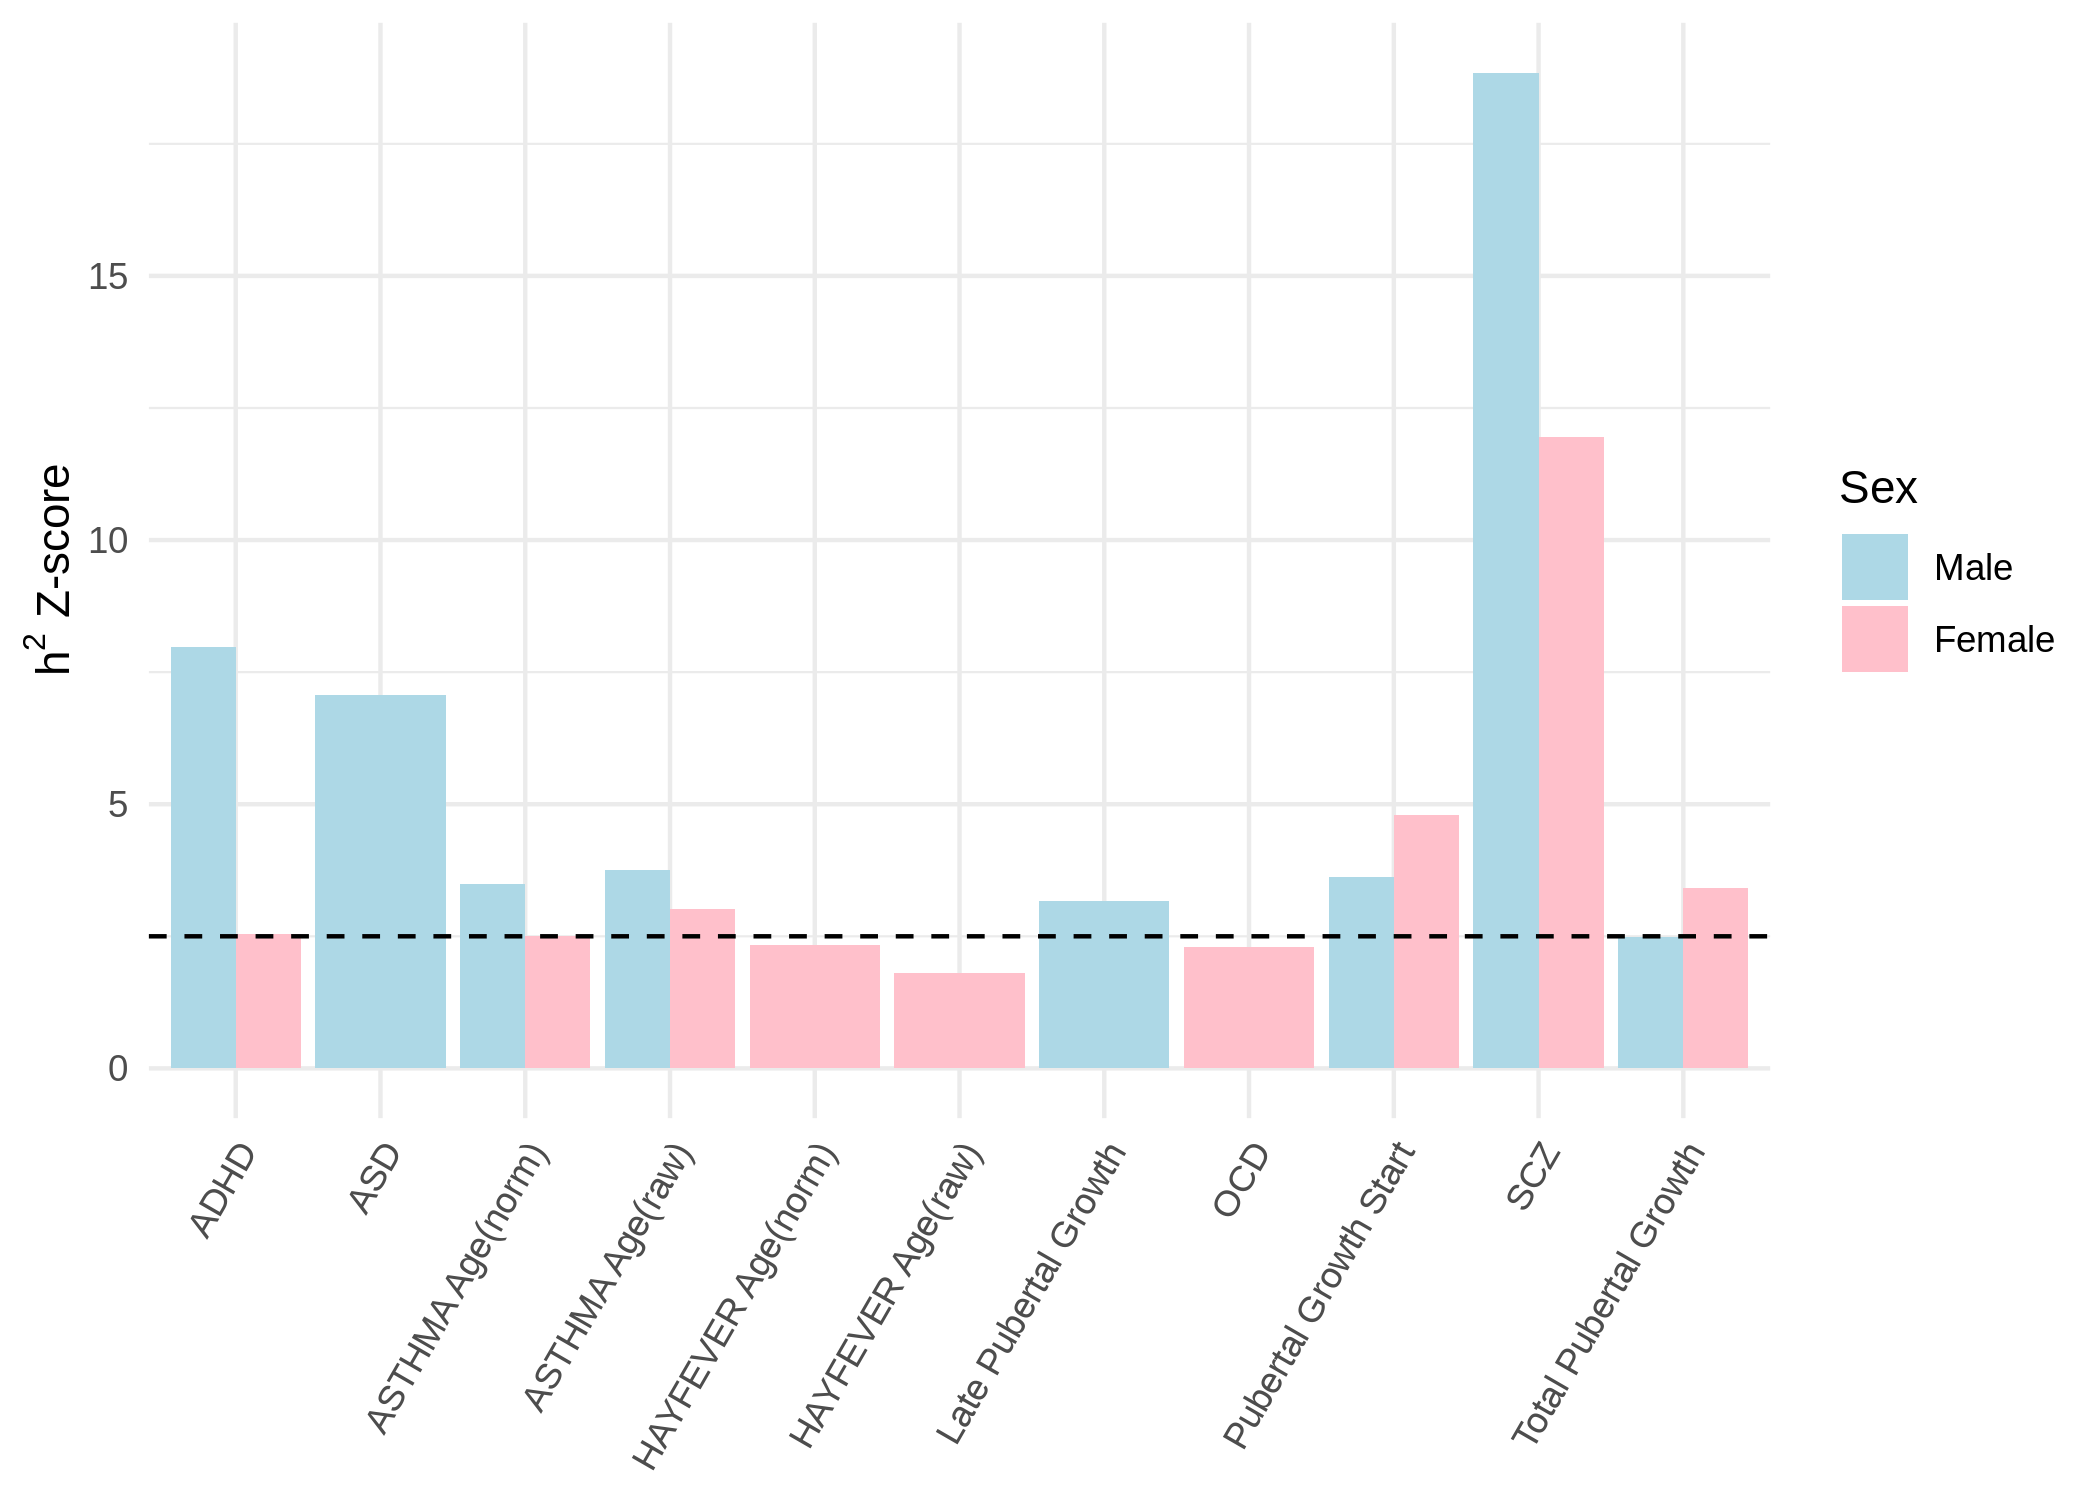

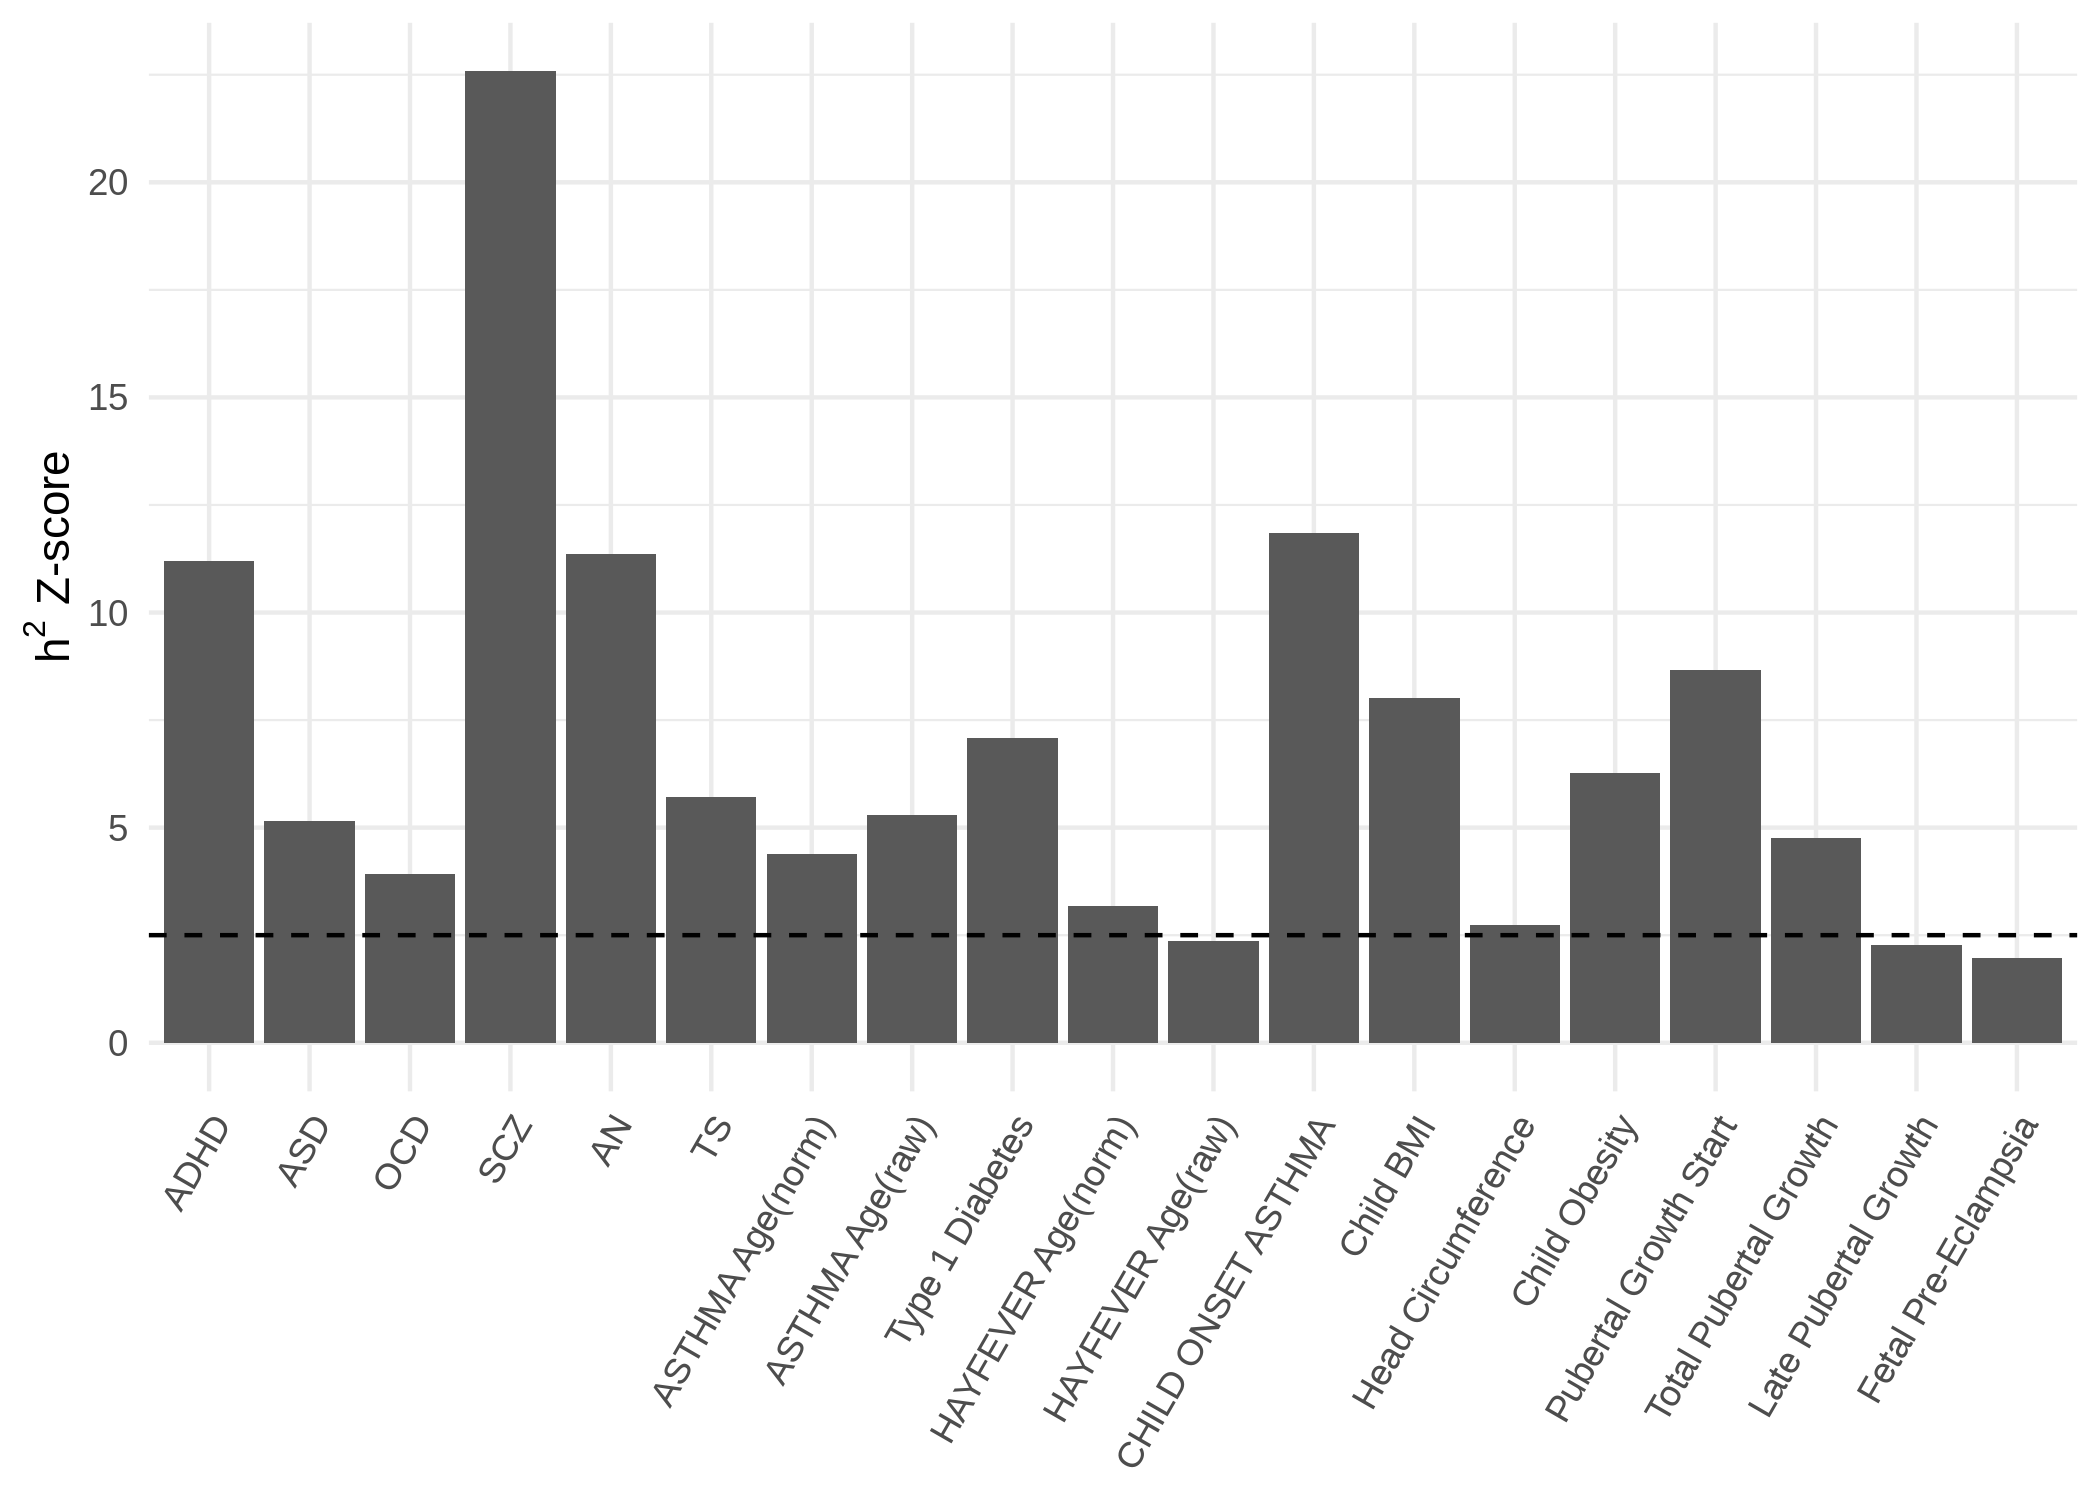

In [4]:
options(width= 10, repr.plot.height= 5, repr.plot.res = 300)

ggplot(rbind(pgc_part_heritability_independent_df,neonatal_part_heritability_independent_df)[!grepl("Males|Females",GWAS) & GWAS %in% selected_GWAS & Category=="Cross-sex" & annotation == "bin_CPP_her",.(h2=h2,h2_se=h2_std_error,GWAS)],aes(GWAS,h2,ymin=h2-h2_se,ymax=h2+h2_se)) +
    geom_point()+
    geom_errorbar() + 
    theme_minimal() + 
    labs(y = bquote(h^2),x=NULL)+
    coord_cartesian(ylim= c(0,1)) +
    theme(axis.text.x=element_text(hjust=1,vjust=1,angle=60))
tmp <- rbind(pgc_part_heritability_independent_df,neonatal_part_heritability_independent_df)[!grepl("Males|Females",GWAS) & GWAS %in% selected_GWAS & Category=="Cross-sex" & annotation == "bin_CPP_her",.(h2=h2,h2_se=h2_std_error,GWAS)]
ggplot(rbind(pgc_part_heritability_independent_df,neonatal_part_heritability_independent_df)[
        grepl("Males|Females",GWAS) & GWAS %in% selected_GWAS & Category=="Cross-sex" & annotation == "bin_CPP_her",
        .(h2=h2,h2_se=h2_std_error, GWAS=gsub(" Males| Females","",GWAS),Sex = factor(gsub(".* (Male|Female)s", "\\1",GWAS),levels=c("Male","Female")))
    ] %>% mutate(GWAS = factor(GWAS,levels= tmp$GWAS)),
    aes(GWAS,h2,ymin=h2-h2_se,ymax=h2+h2_se,color=Sex)) +
    geom_point(position=position_dodge(width=0.5))+
    geom_errorbar(position=position_dodge(width=0.5))+
    scale_color_manual(values=c("lightblue","pink"))+
    coord_cartesian(ylim= c(0,1)) +
    theme_minimal() + 
    labs(y = bquote(h^2),x=NULL)+
    theme(axis.text.x=element_text(hjust=1,vjust=1,angle=60))                                 


ggplot(rbind(pgc_part_heritability_independent_df,neonatal_part_heritability_independent_df)[
        grepl("Males|Females",GWAS) & annotation == "bin_CPP_her"& GWAS %in% selected_GWAS,
        .(h2_z=h2/h2_std_error,GWAS=gsub(" Males| Females","",GWAS),Sex = factor(gsub(".* (Male|Female)s", "\\1",GWAS),levels=c("Male","Female")))
    ],
        aes(GWAS,h2_z, fill=Sex)) +
    geom_col(position="dodge")+
    geom_hline(yintercept = 2.5, linetype="dashed")+
    scale_fill_manual(values=c("lightblue","pink"))+             
    theme_minimal() + 
    labs(y = bquote(h^2~"Z-score"),x=NULL)+
    theme(axis.text.x=element_text(hjust=1,vjust=1,angle=60))



ggplot(rbind(pgc_part_heritability_independent_df,neonatal_part_heritability_independent_df)[!grepl("Males|Females",GWAS) & GWAS %in% selected_GWAS & Category=="Cross-sex" & annotation == "bin_CPP_her",.(h2_z=h2/h2_std_error,GWAS)] ,aes(GWAS,h2_z)) +
    geom_col(position="dodge")+
    geom_hline(yintercept = 2.5, linetype="dashed")+
    theme_minimal() + 
    labs(y = bquote(h^2~"Z-score"),x=NULL)+
    theme(axis.text.x=element_text(hjust=1,vjust=1,angle=60))

In [5]:
if(!file.exists(here("data","all_sd_annot.txt.gz"))){
    all_sd_annot <- list()
    i <- 1
    for(qtl_set in c("male_specific","female_specific","marginal","sex_interaction","male", "female", "cord_mqtl")){
        for(annot in c("all_cis_fdr","maxCPP_her","bin_CPP_her")){
            if(grepl("specific",qtl_set) & annot != "bin_CPP_her") next
            if(grepl("CPP",annot)){
                annotations <- annotation_SD("/scratch/st-dennisjk-1/wcasazza/1000G_phase3_ldsc/single_delahaye_annotations/",glue("{qtl_set}_{annot}.*.annot.gz"))
            }else{
                    annotations <- annotation_SD("/scratch/st-dennisjk-1/wcasazza/1000G_phase3_ldsc/single_delahaye_annotations/",glue("{qtl_set}_{annot}.*.annot.gz"))
            }
            annotations <- data.table(annot_sd=annotations)
            annotations$annotation <- annot
            annotations$Category <- recode(qtl_set,male_specific= "Male Specific", female_specific = "Female Specific", marginal="Cross-sex",sex_interaction="Sex dependent", male= "Male Stratified", female="Female Stratified", cord_mqtl='Cord Blood')
            all_sd_annot[[i]] <- annotations
            i <- i+1
        }
    }
    all_sd_annot <- rbindlist(all_sd_annot)
    fwrite(all_sd_annot,here("data","all_sd_annot.txt.gz"),row.names=F,sep="\t",quote=FALSE)
}else{
    all_sd_annot <- fread(here("data","all_sd_annot.txt.gz"))
    all_sd_annot$Category <- recode(all_sd_annot$Category,"Marginal"="Cross-sex","Sex Interaction"="Sex dependent")
    unique(all_sd_annot$Category)

}

[1] "Male Specific"    
[2] "Female Specific"  
[3] "Cross-sex"        
[4] "Sex dependent"    
[5] "Male Stratified"  
[6] "Female Stratified"
[7] "Cord Blood"

In [6]:
neonatal_part_heritability_independent_df <- merge(neonatal_part_heritability_independent_df,all_sd_annot,by=c("annotation","Category"))
neonatal_part_heritability_independent_df[,`:=`(tau_star=(Coefficient * annot_sd)/(h2/total_SNP),tau_se = (Coefficient_std_error * annot_sd)/(h2/total_SNP))]

pgc_part_heritability_independent_df <- merge(pgc_part_heritability_independent_df,all_sd_annot,by=c("annotation","Category"))
pgc_part_heritability_independent_df[,`:=`(tau_star=(Coefficient * annot_sd)/(h2/total_SNP),tau_se = (Coefficient_std_error * annot_sd)/(h2/total_SNP))]

neonatal_part_heritability_df <- merge(neonatal_part_heritability_df,all_sd_annot,by=c("annotation","Category"))
neonatal_part_heritability_df[,`:=`(tau_star=(Coefficient * annot_sd)/(h2/total_SNP),tau_se = (Coefficient_std_error * annot_sd)/(h2/total_SNP))]

neonatal_part_heritability_sex_df <- merge(neonatal_part_heritability_sex_df,all_sd_annot,by=c("annotation","Category"))
neonatal_part_heritability_sex_df[,`:=`(tau_star=(Coefficient * annot_sd)/(h2/total_SNP),tau_se = (Coefficient_std_error * annot_sd)/(h2/total_SNP))]

pgc_part_heritability_df <- merge(pgc_part_heritability_df,all_sd_annot,by=c("annotation","Category"))
pgc_part_heritability_df[,`:=`(tau_star=(Coefficient * annot_sd)/(h2/total_SNP),tau_se = (Coefficient_std_error * annot_sd)/(h2/total_SNP))]

pgc_part_heritability_baseline_df <- merge(pgc_part_heritability_baseline_df,all_sd_annot,by=c("annotation","Category"))
pgc_part_heritability_baseline_df[,`:=`(tau_star=(Coefficient * annot_sd)/(h2/total_SNP),tau_se = (Coefficient_std_error * annot_sd)/(h2/total_SNP))]

pgc_part_heritability_baseline_sex_df <- merge(pgc_part_heritability_baseline_sex_df,all_sd_annot,by=c("annotation","Category"))
pgc_part_heritability_baseline_sex_df[,`:=`(tau_star=(Coefficient * annot_sd)/(h2/total_SNP),tau_se = (Coefficient_std_error * annot_sd)/(h2/total_SNP))]

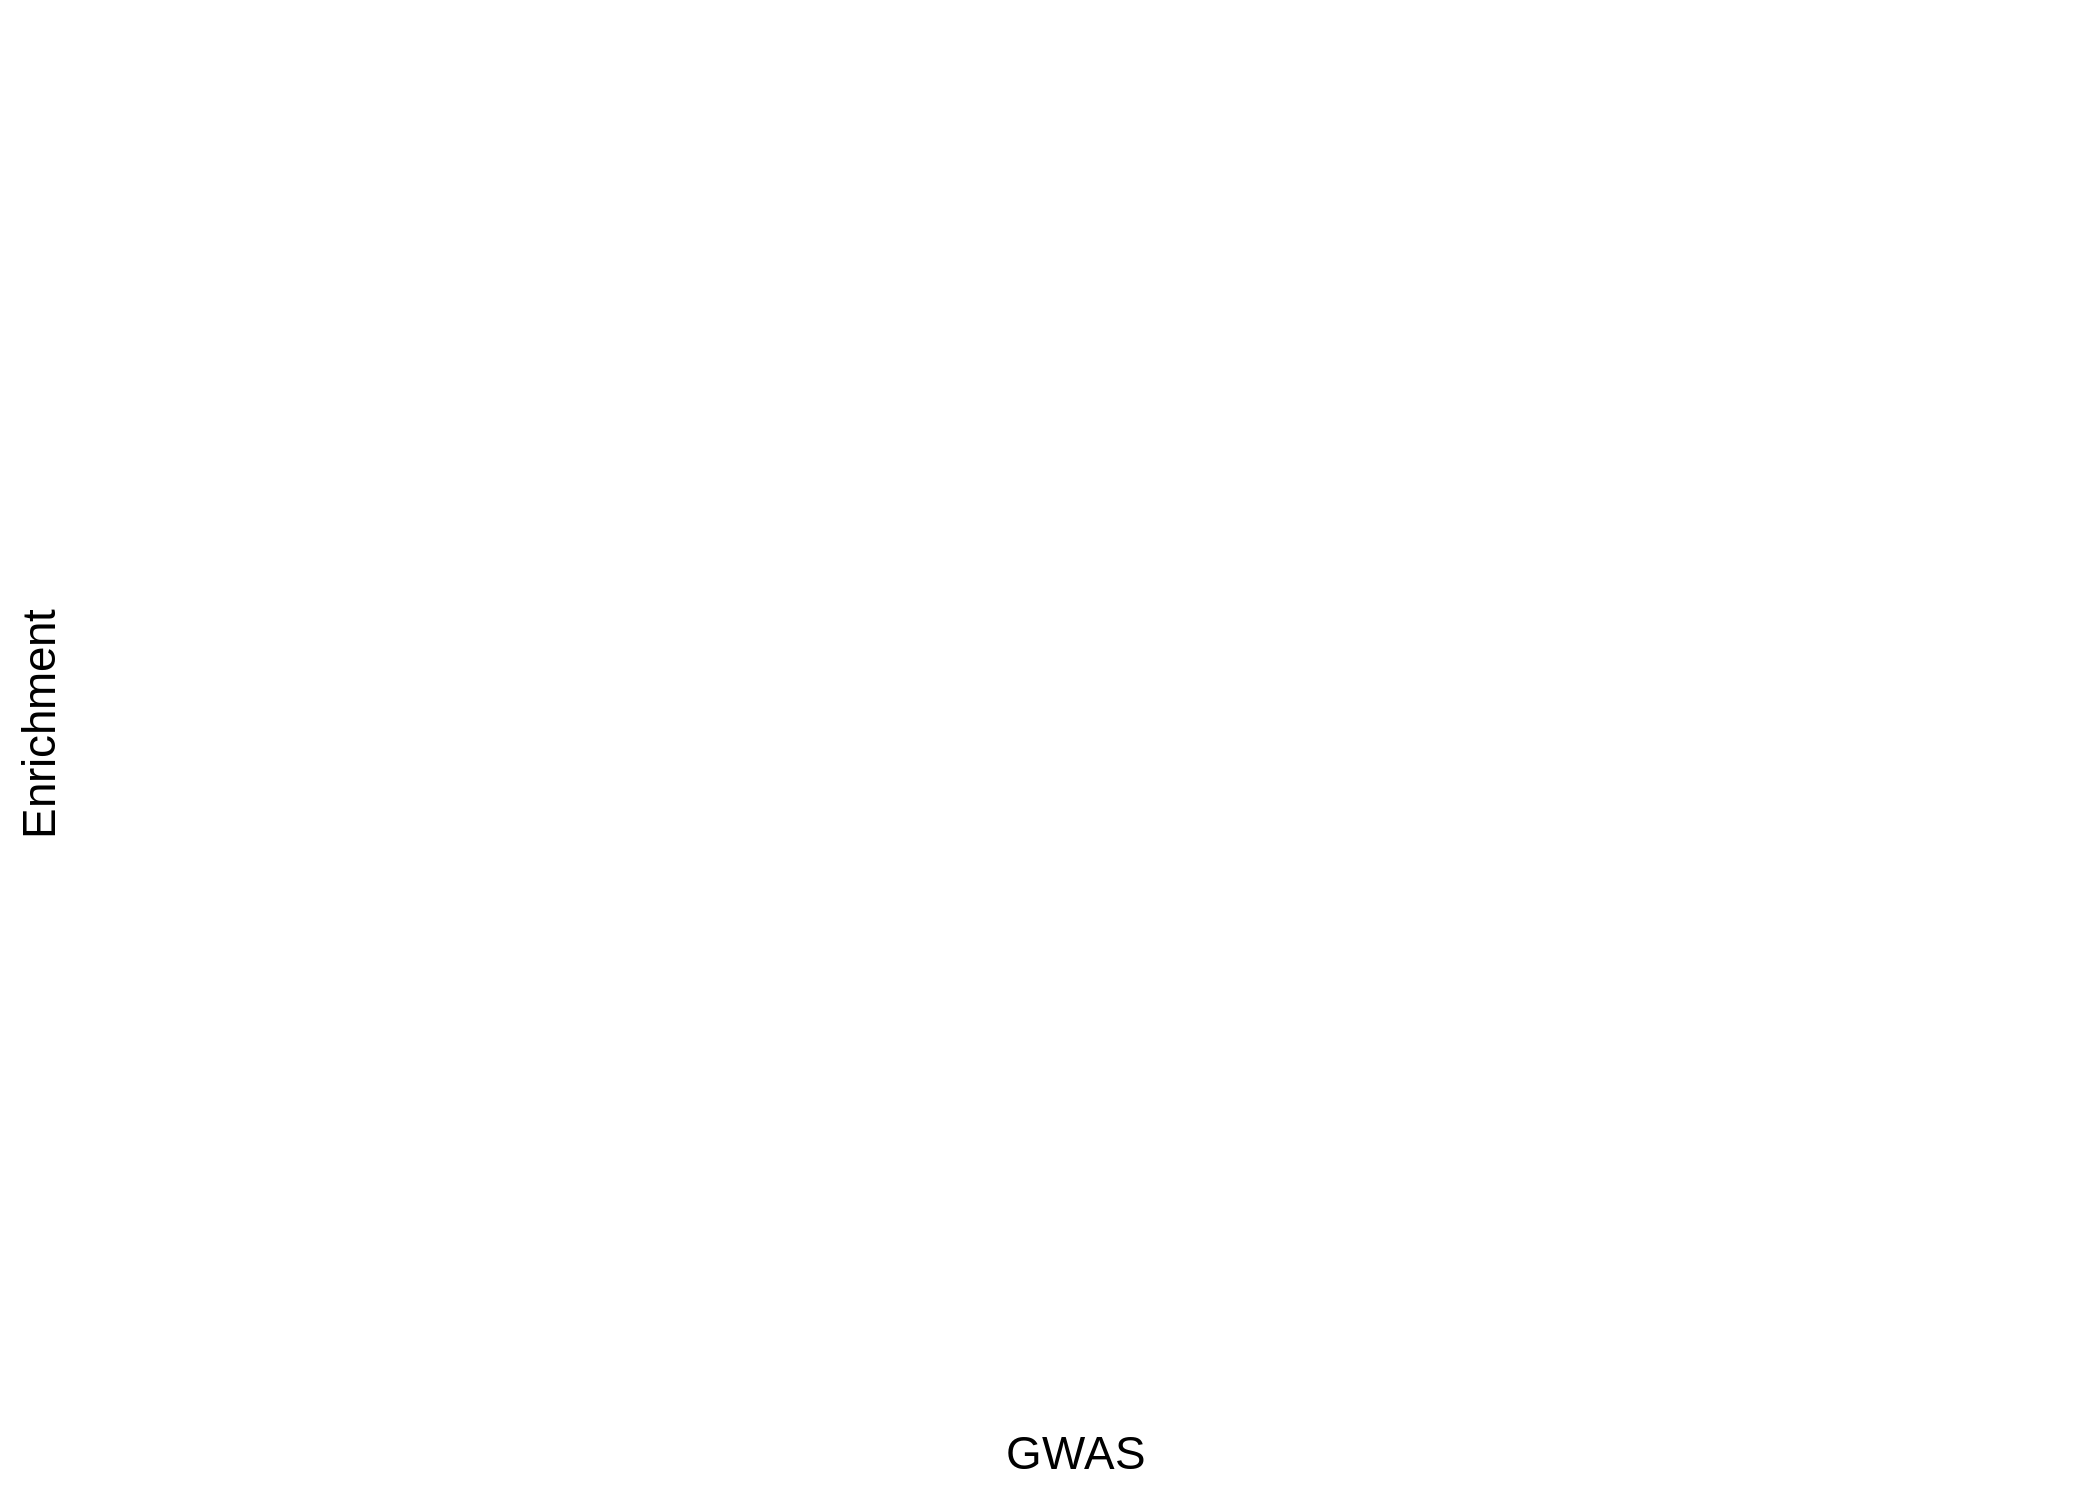

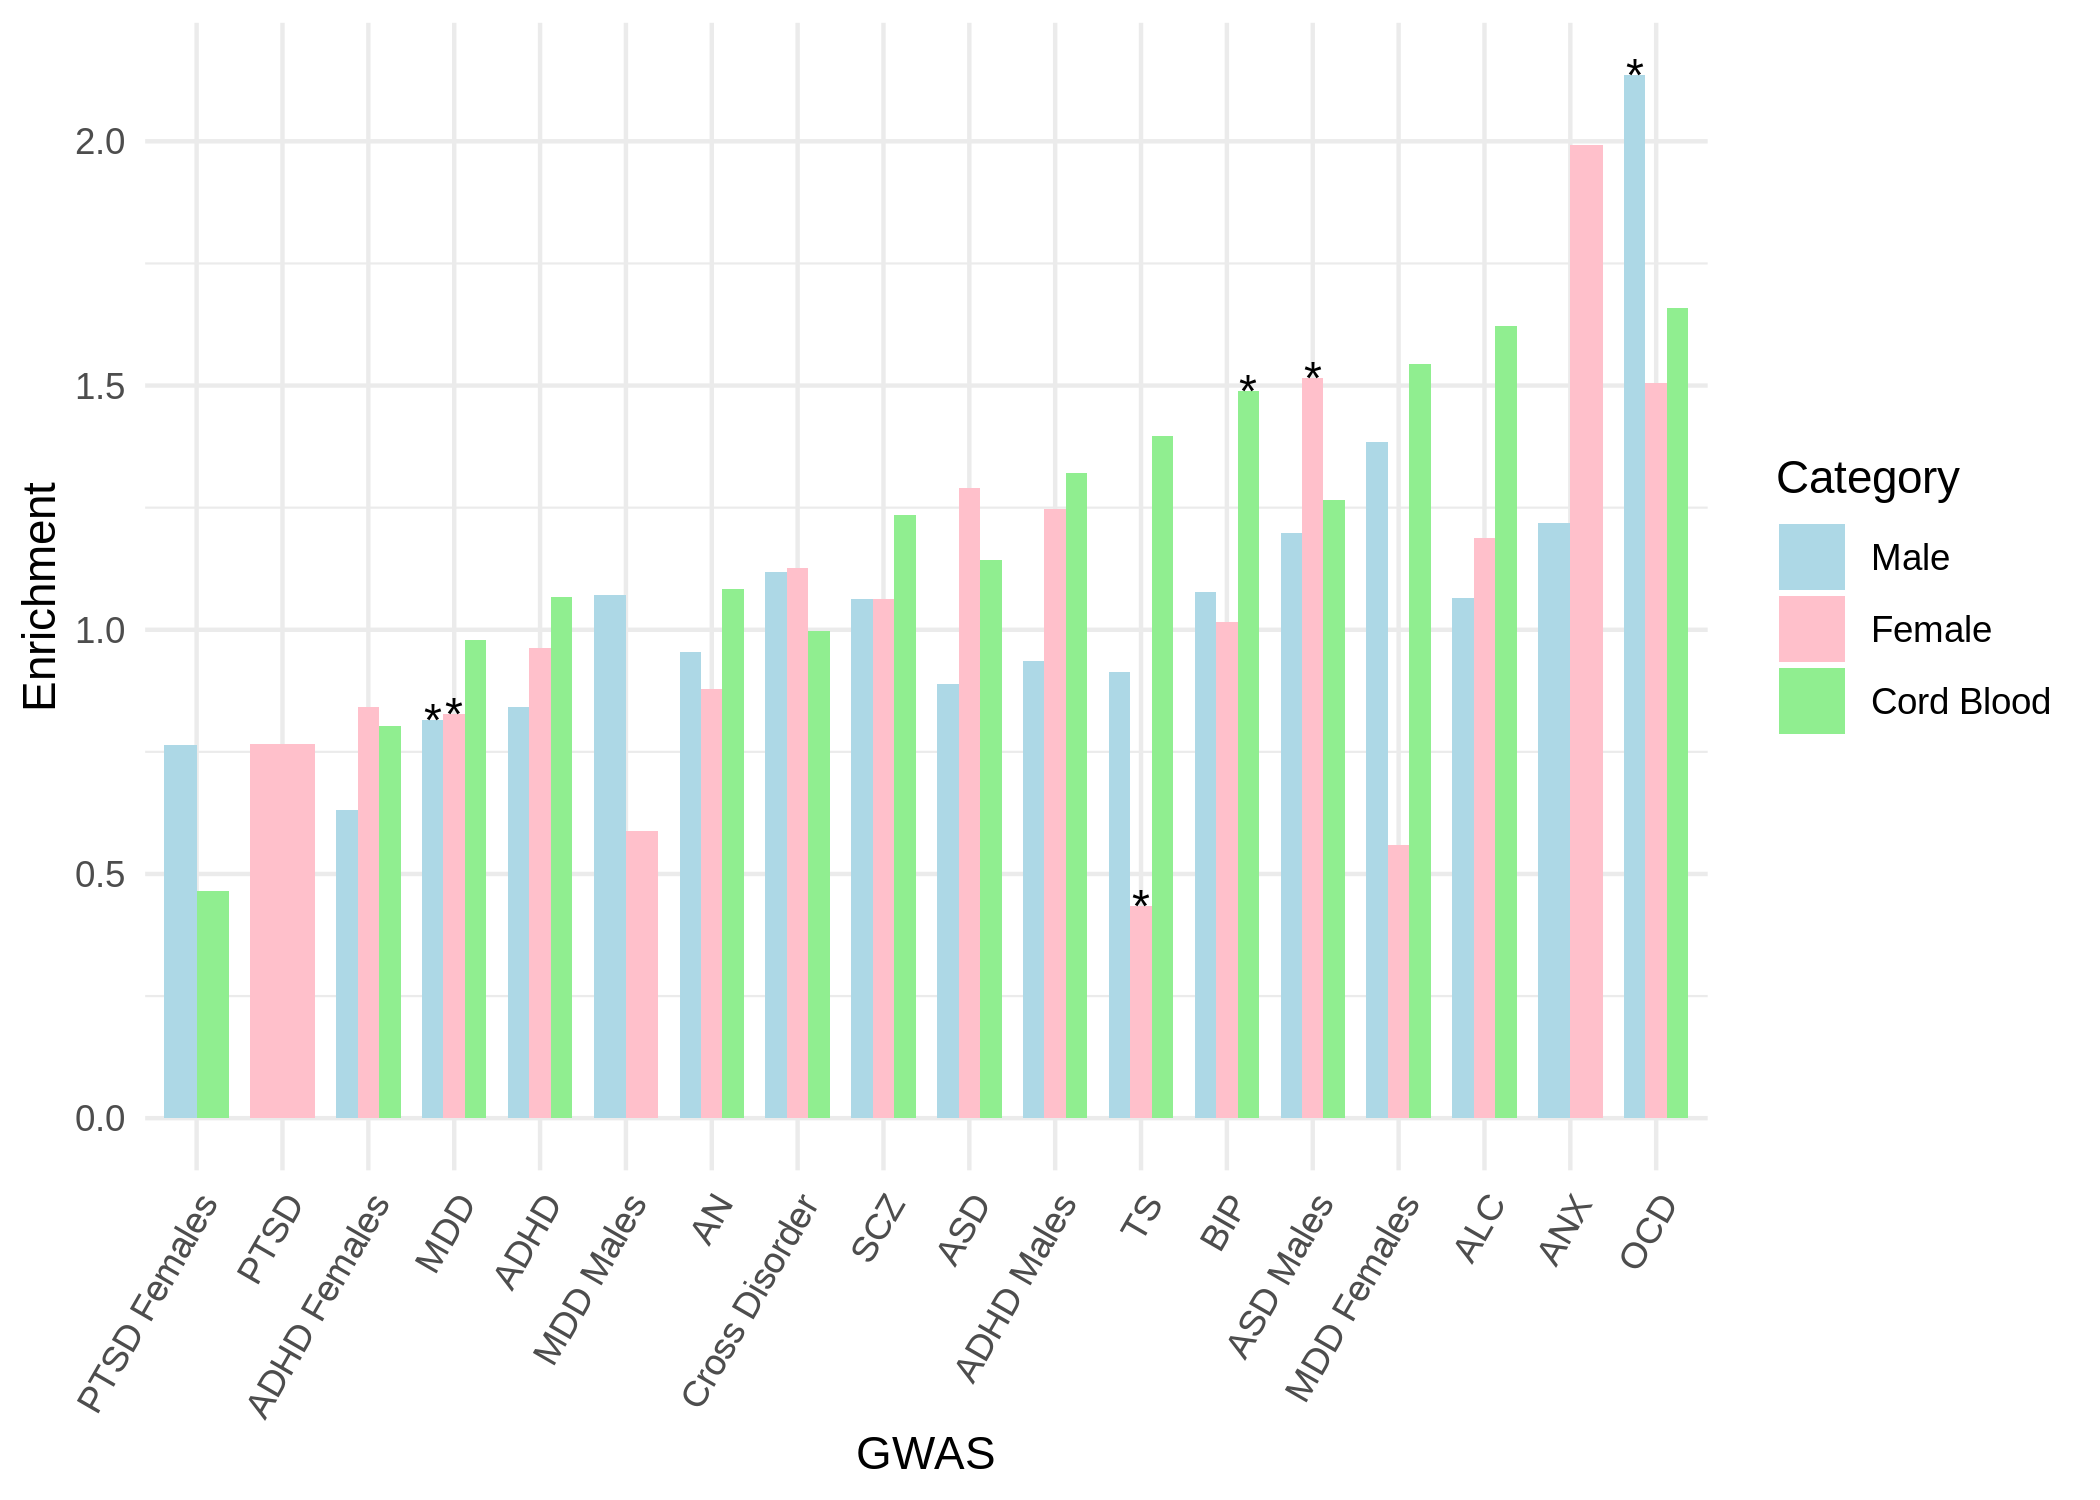

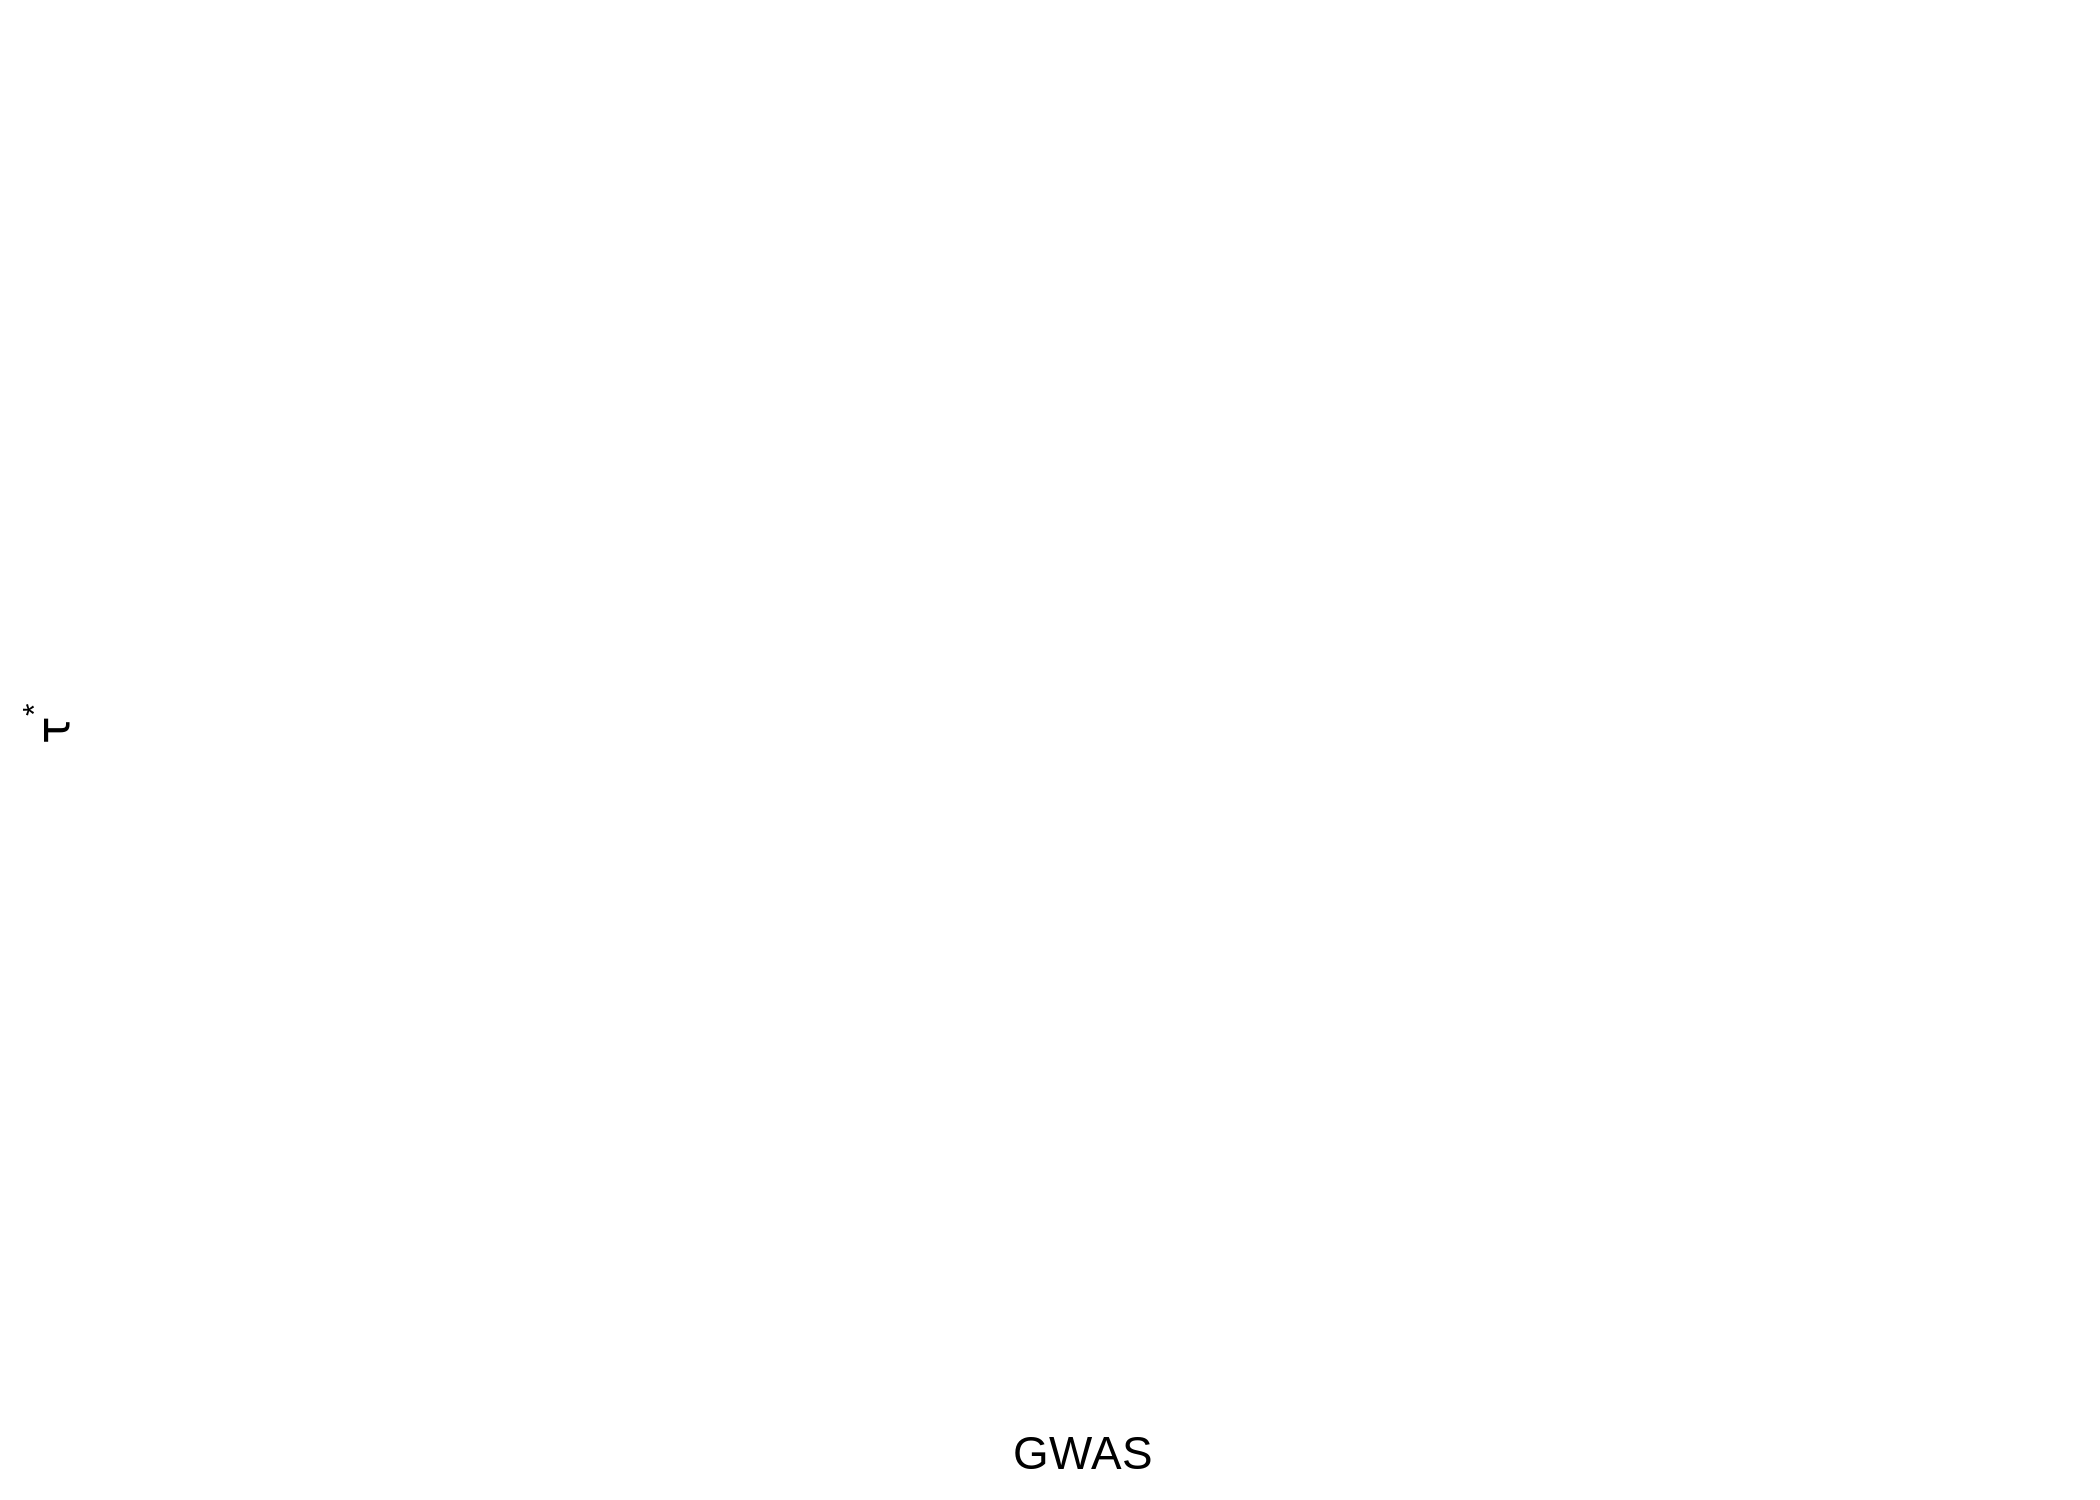

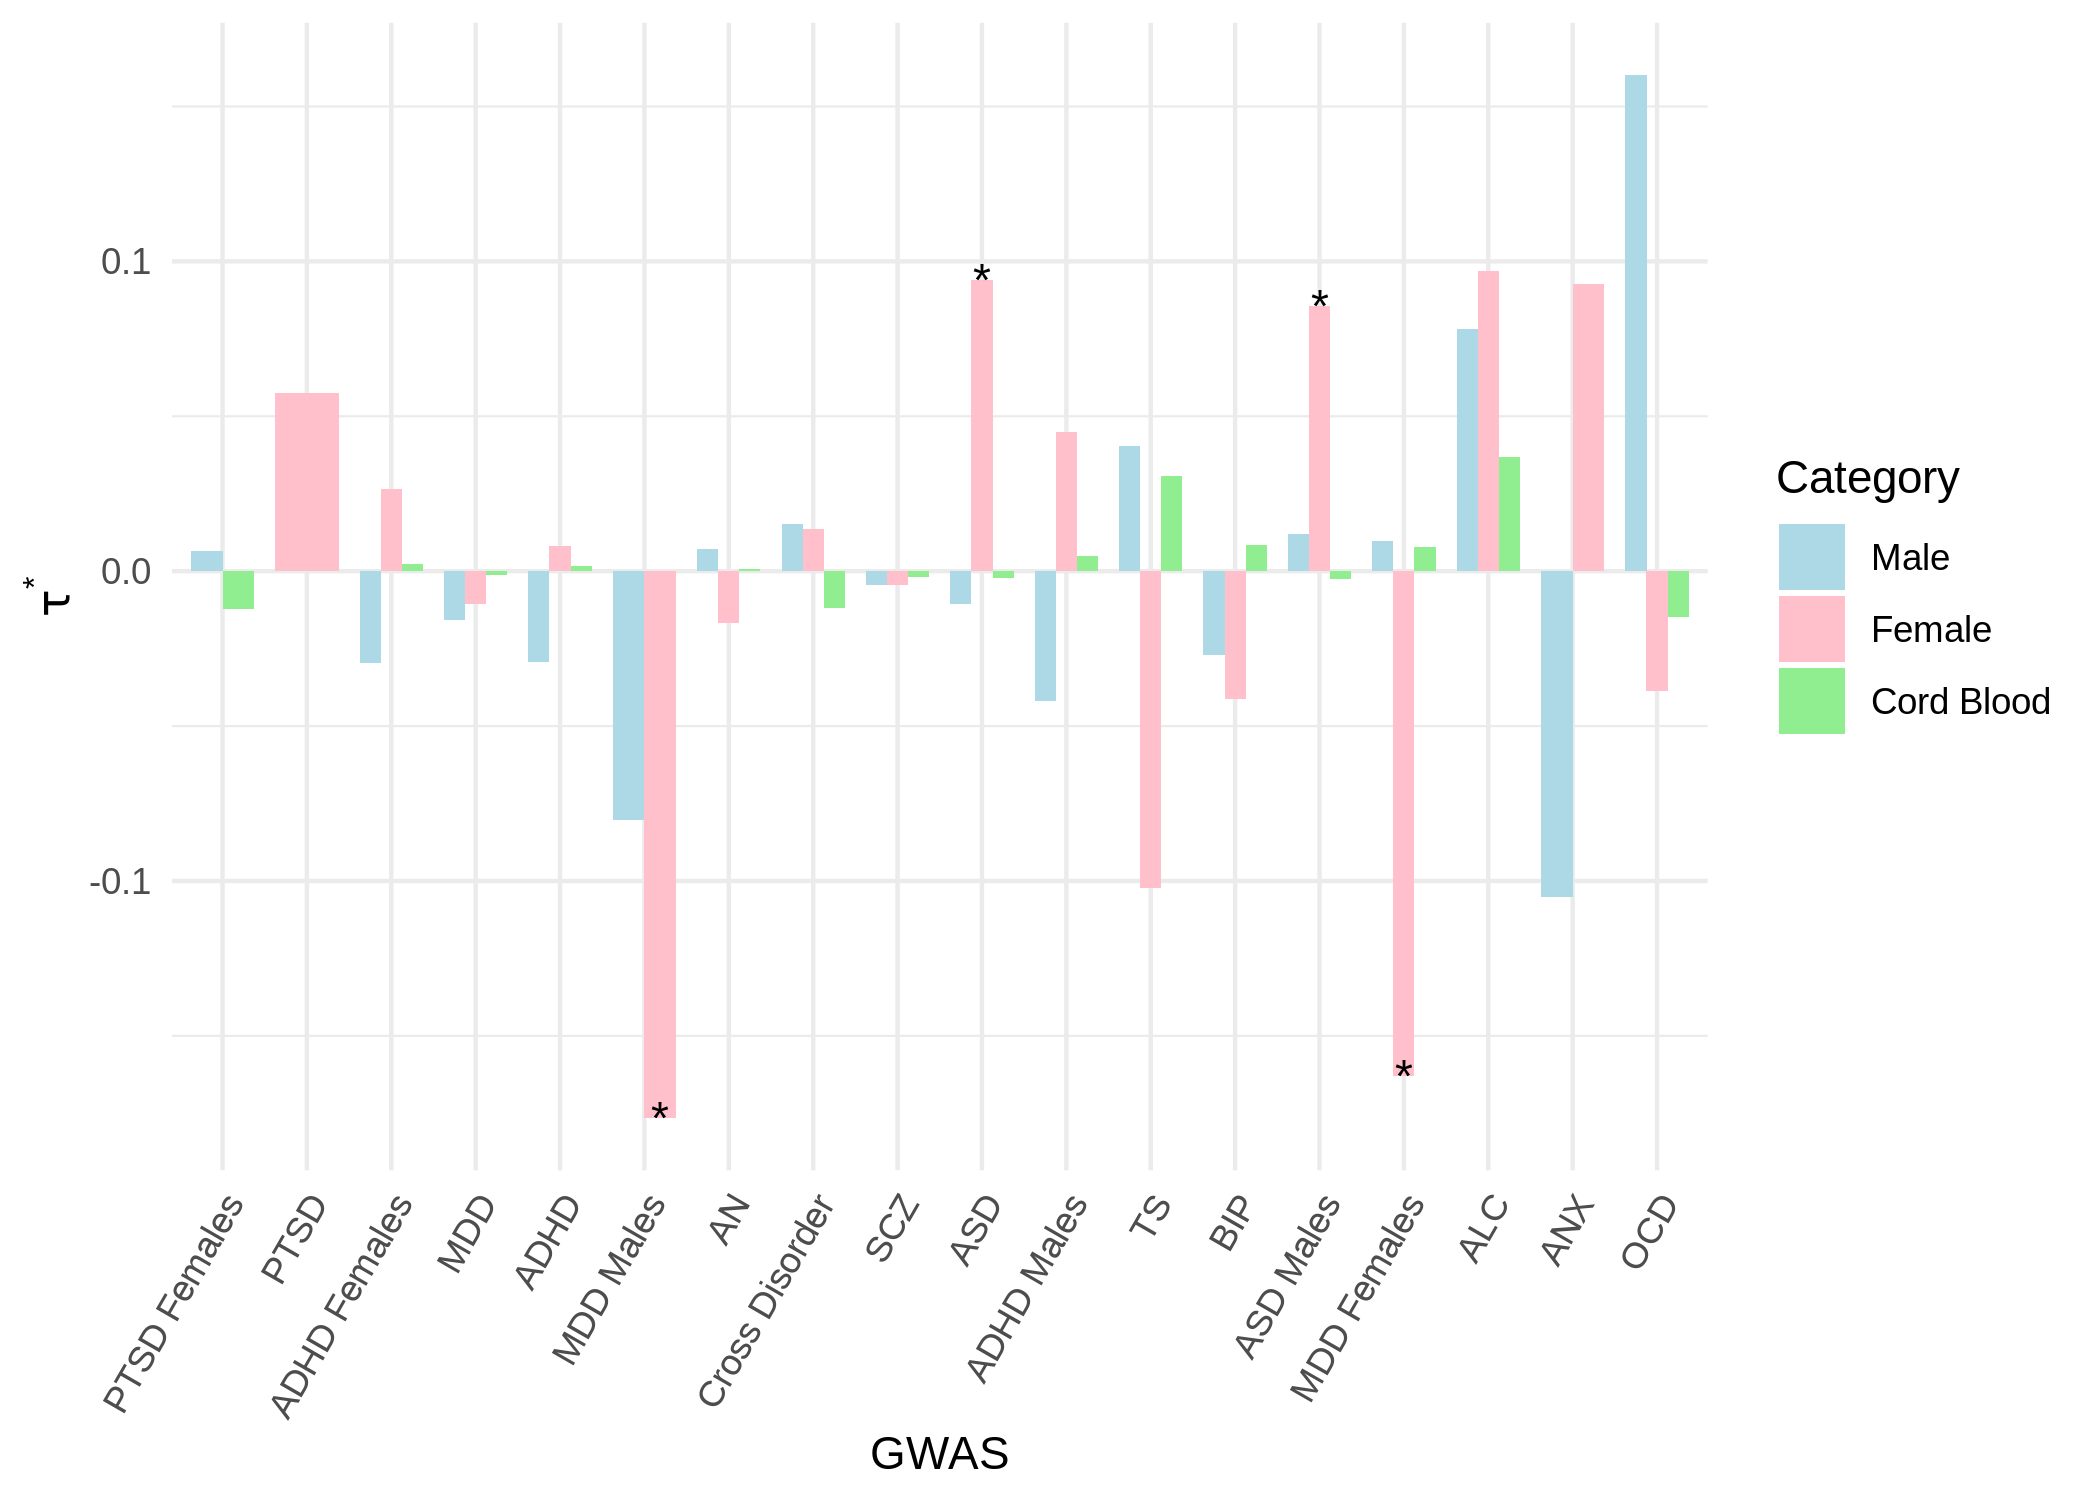

In [8]:
options(width= 10, repr.plot.height= 5, repr.plot.res = 300)
exclude_list <- c("PTSD Males","ASD Females","ANXFS","Alcohol (AUDIT)","Cannabis","Cigarettes Per Day") 
order_dt <-     pgc_part_heritability_df[
        !GWAS %in% exclude_list &
        Category %in% c("Marginal", "Sex Interaction", "Male", "Female", "Cord Blood") &
        annotation == "bin_CPP_her" &
        Enrichment - Enrichment_std_error > 0,
        .(max_enrich = max(Enrichment)),
        by = "GWAS"
    ]
GWAS_order <- order_dt[order(max_enrich)]$GWAS
annot_order <- c("Male","Female","Sex Interaction","Marginal", "Cord Blood")
ggplot(
    pgc_part_heritability_df[
        !GWAS %in% exclude_list &
        Category %in% c("Marginal", "Sex Interaction", "Male", "Female", "Cord Blood") &
        annotation == "maxCPP_her" &
        Enrichment - Enrichment_std_error > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=Enrichment,label = ifelse(significant_enrich,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    scale_fill_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))

ggplot(
    pgc_part_heritability_df[
        !GWAS %in% exclude_list &
        Category %in% c("Marginal", "Sex Interaction", "Male", "Female", "Cord Blood") &
        annotation == "bin_CPP_her" &
        Enrichment - Enrichment_std_error > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=Enrichment,label = ifelse(significant_enrich,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    scale_fill_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))
ggplot(
    pgc_part_heritability_df[
        !GWAS %in% exclude_list &
        Category %in% c("Marginal", "Sex Interaction", "Male", "Female", "Cord Blood") &
        annotation == "maxCPP_her" &
        Enrichment - Enrichment_std_error > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=tau_star,label = ifelse(pnorm(abs(tau_star/tau_se),lower.tail=F)*2 < 0.05,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    scale_fill_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    labs(y=bquote(tau^"*"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))

ggplot(
    pgc_part_heritability_df[
        !GWAS %in% exclude_list &
        Category %in% c("Marginal", "Sex Interaction", "Male", "Female", "Cord Blood") &
        annotation == "bin_CPP_her" &
        Enrichment - Enrichment_std_error > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=tau_star,label = ifelse(pnorm(abs(tau_star/tau_se),lower.tail=F)*2 < 0.05,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    labs(y=bquote(tau^"*"))+
    scale_fill_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))

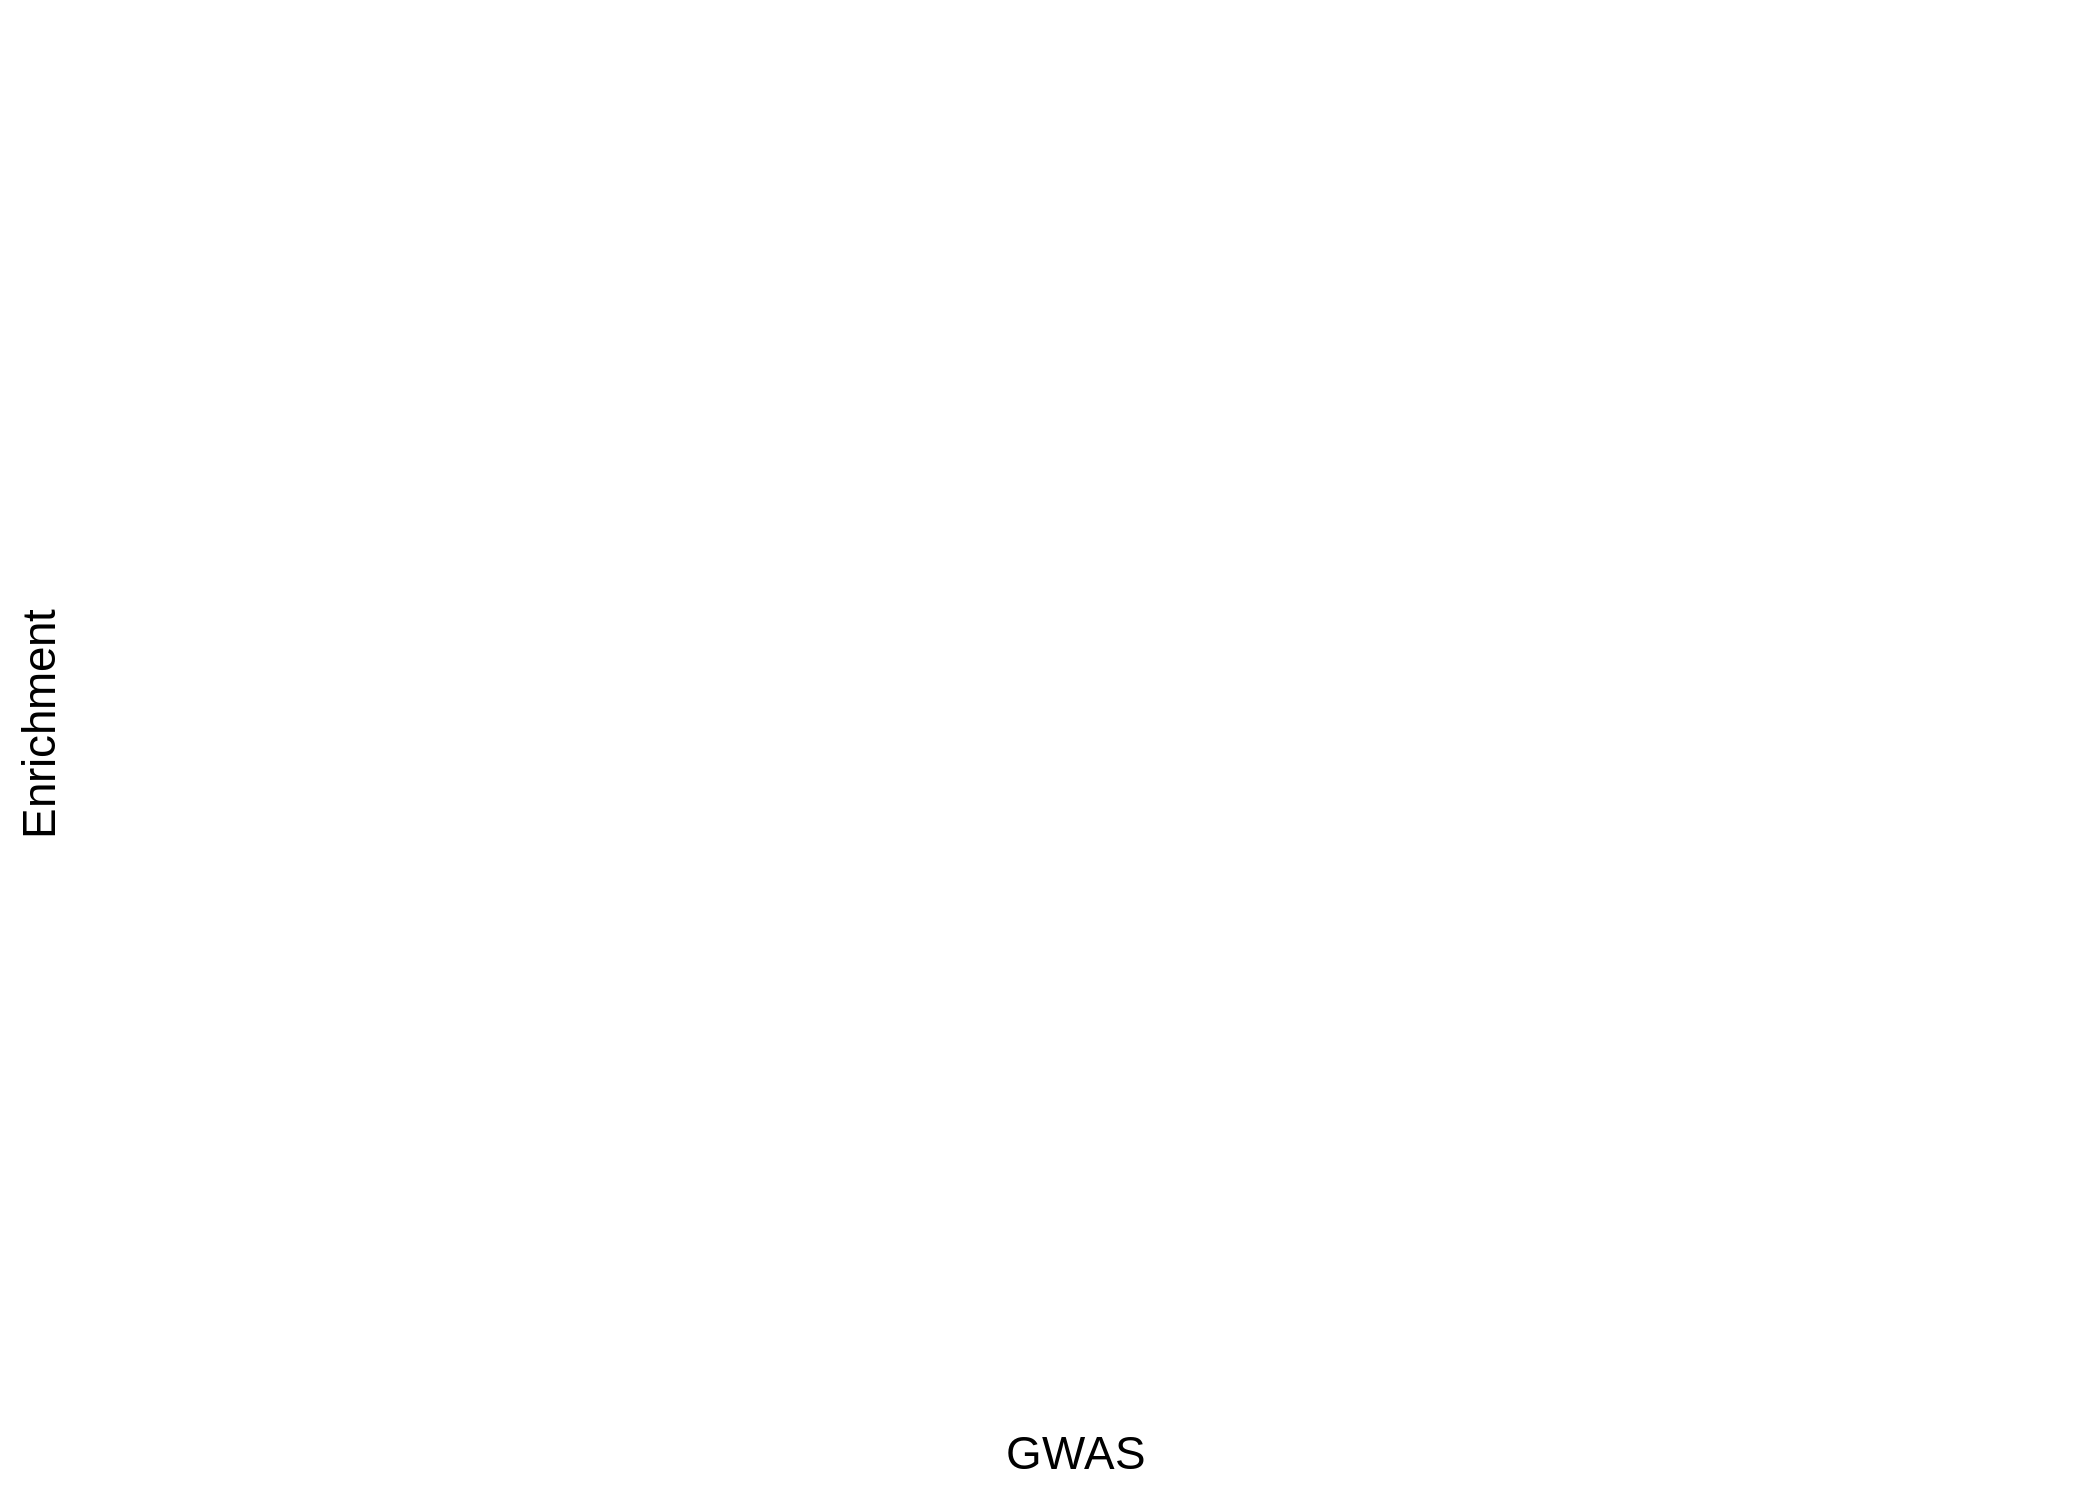

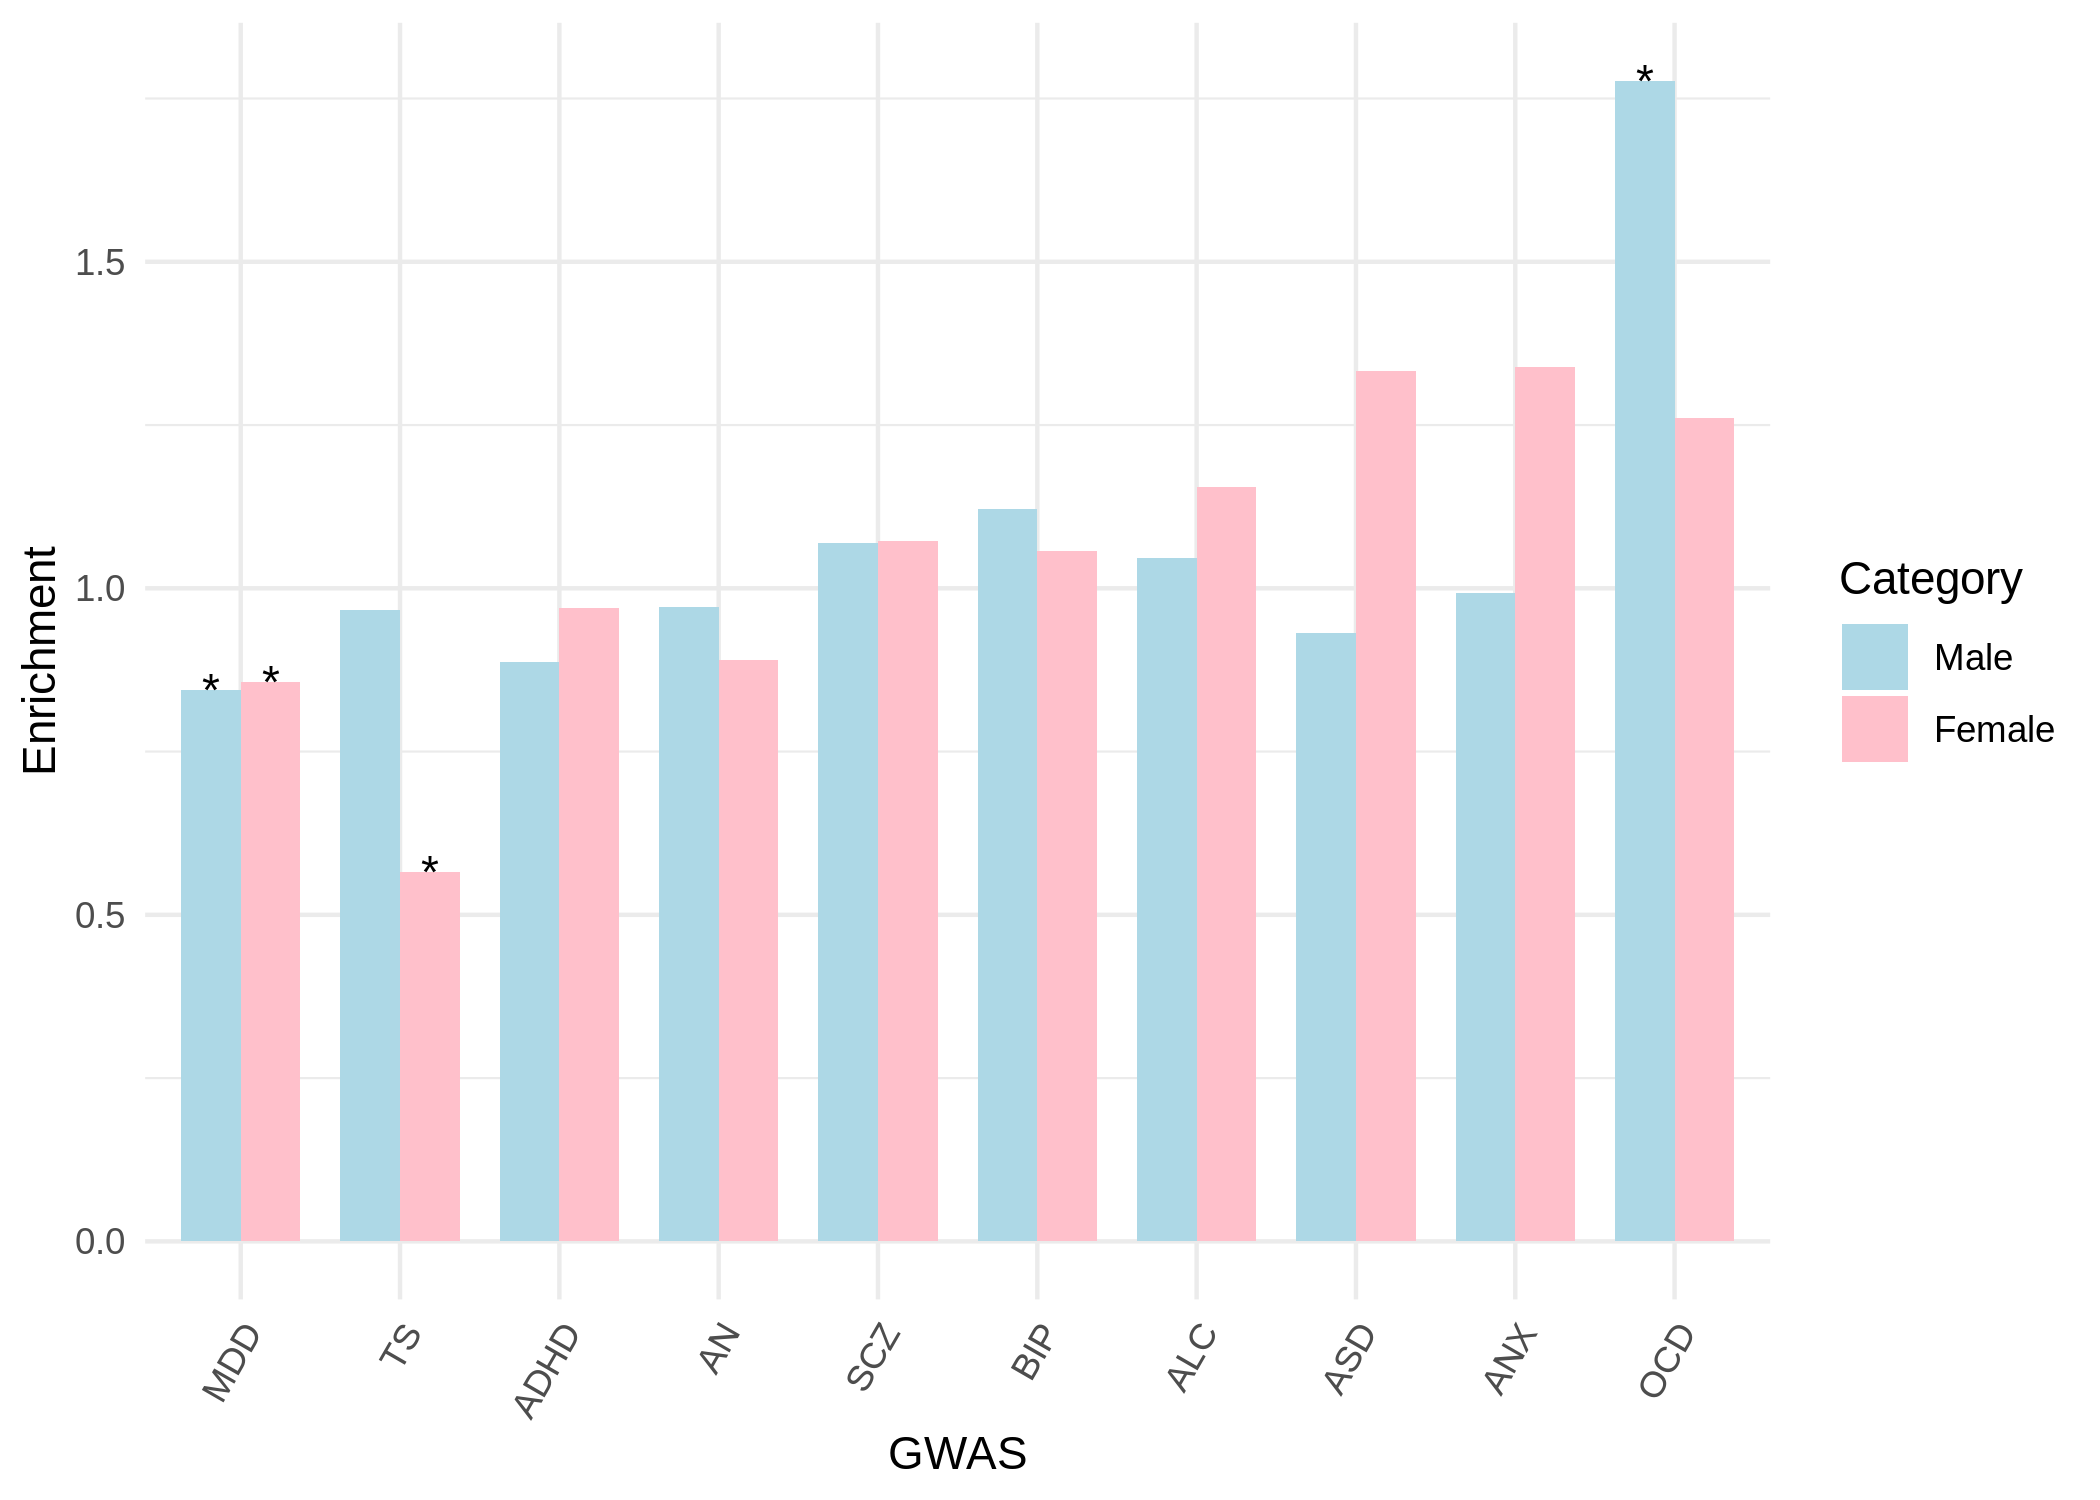

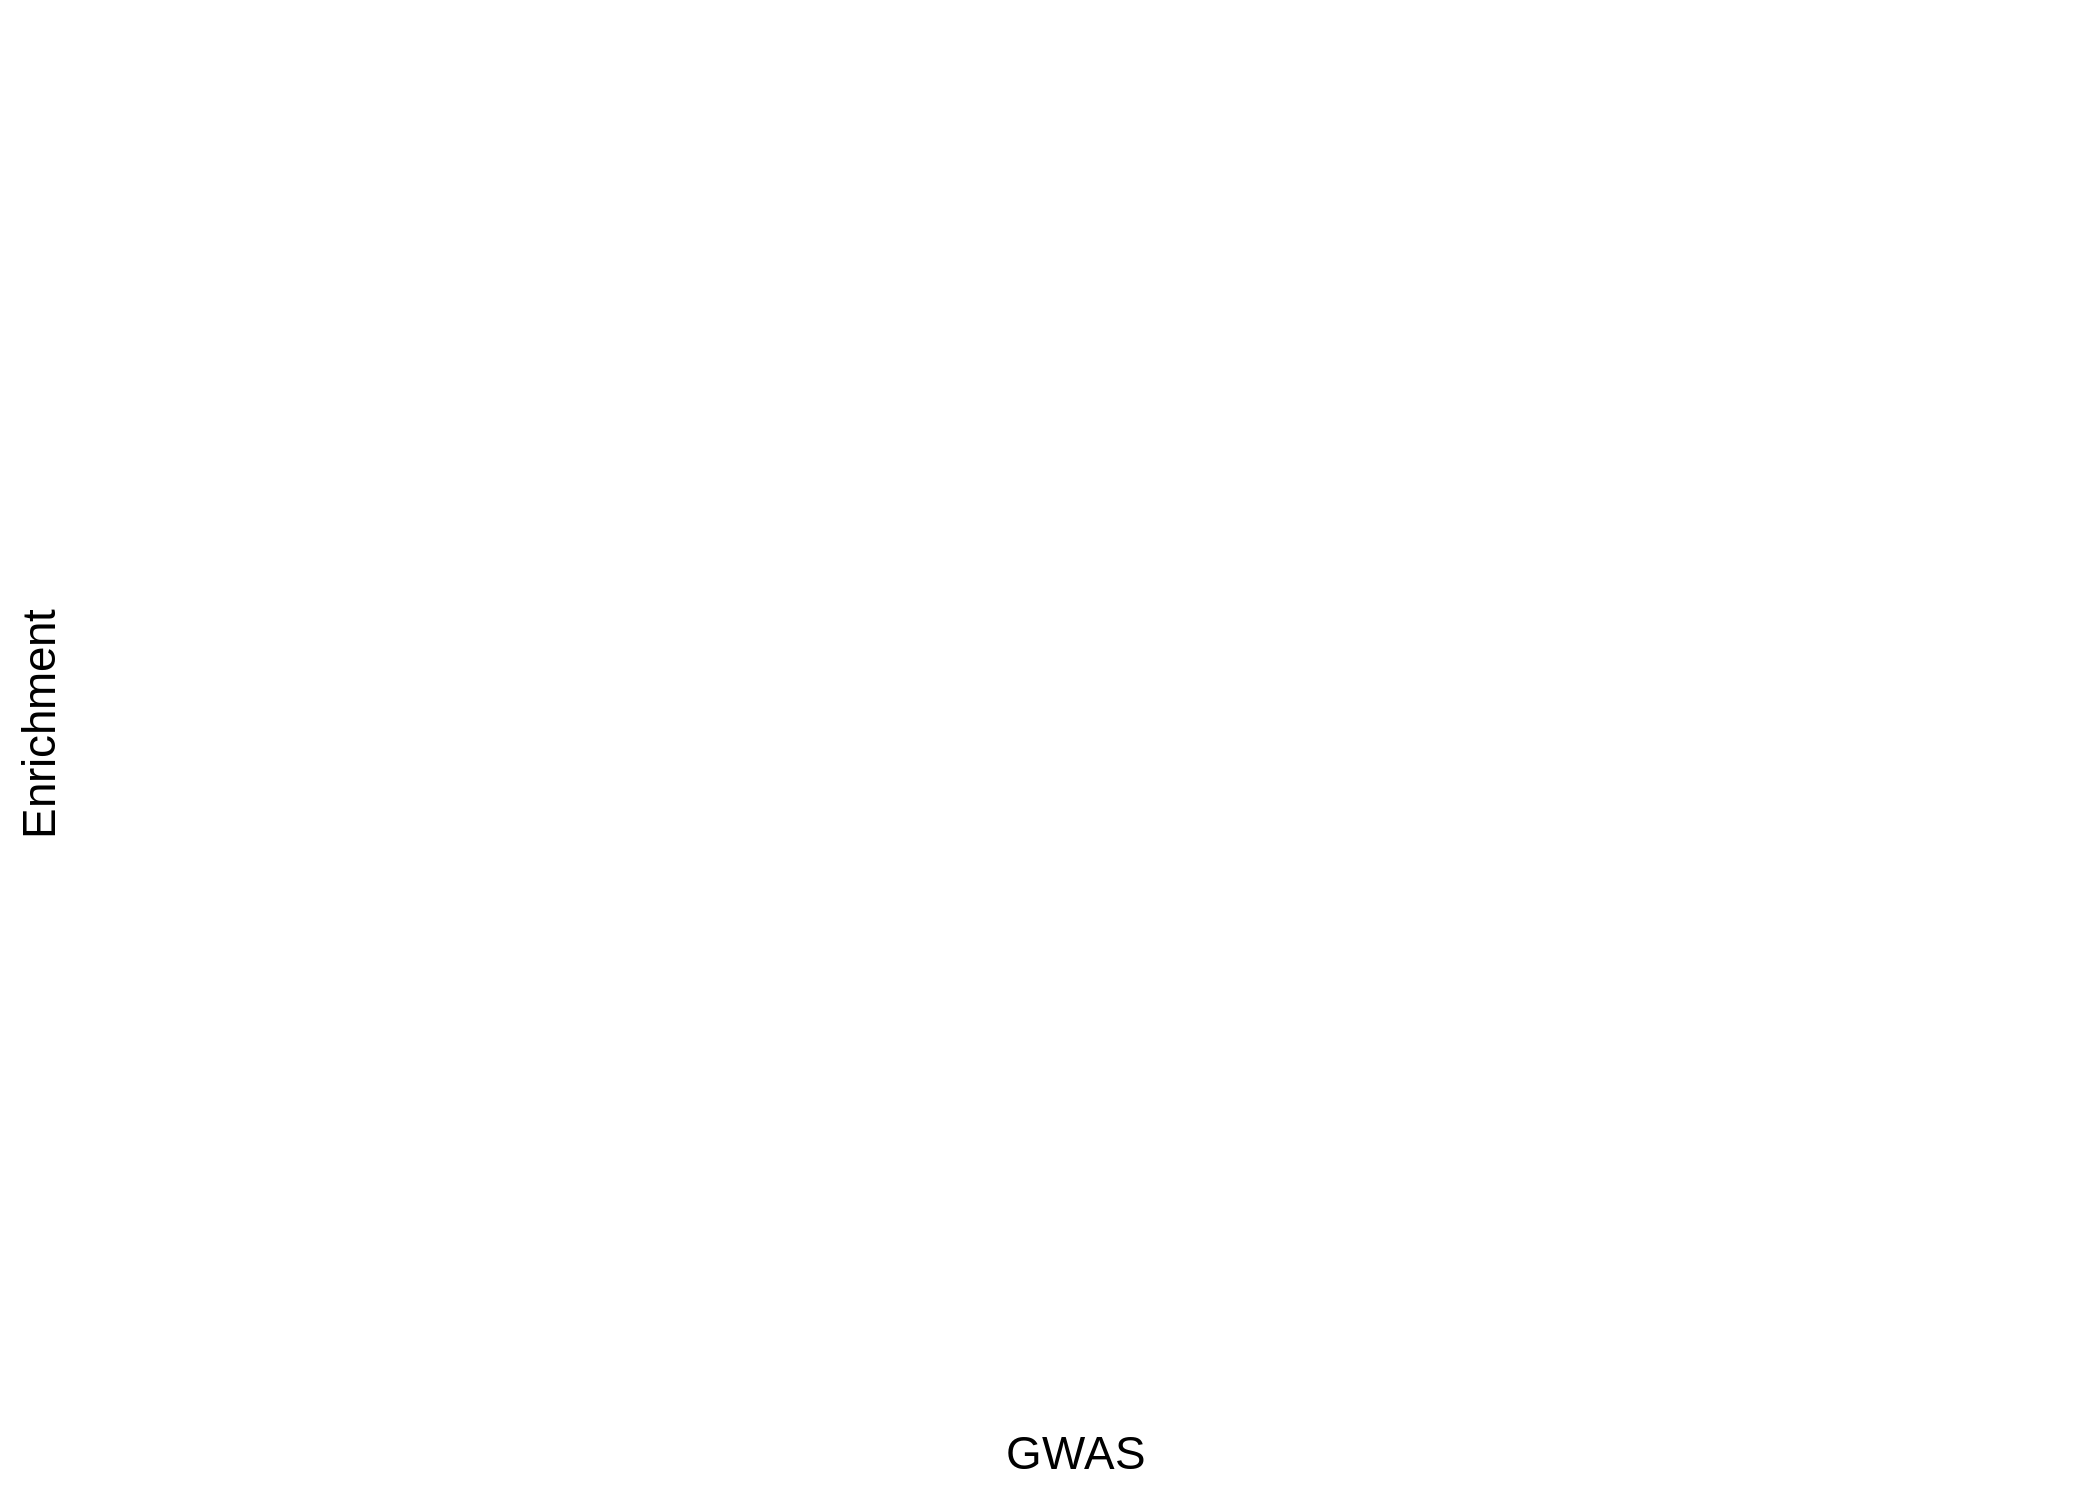

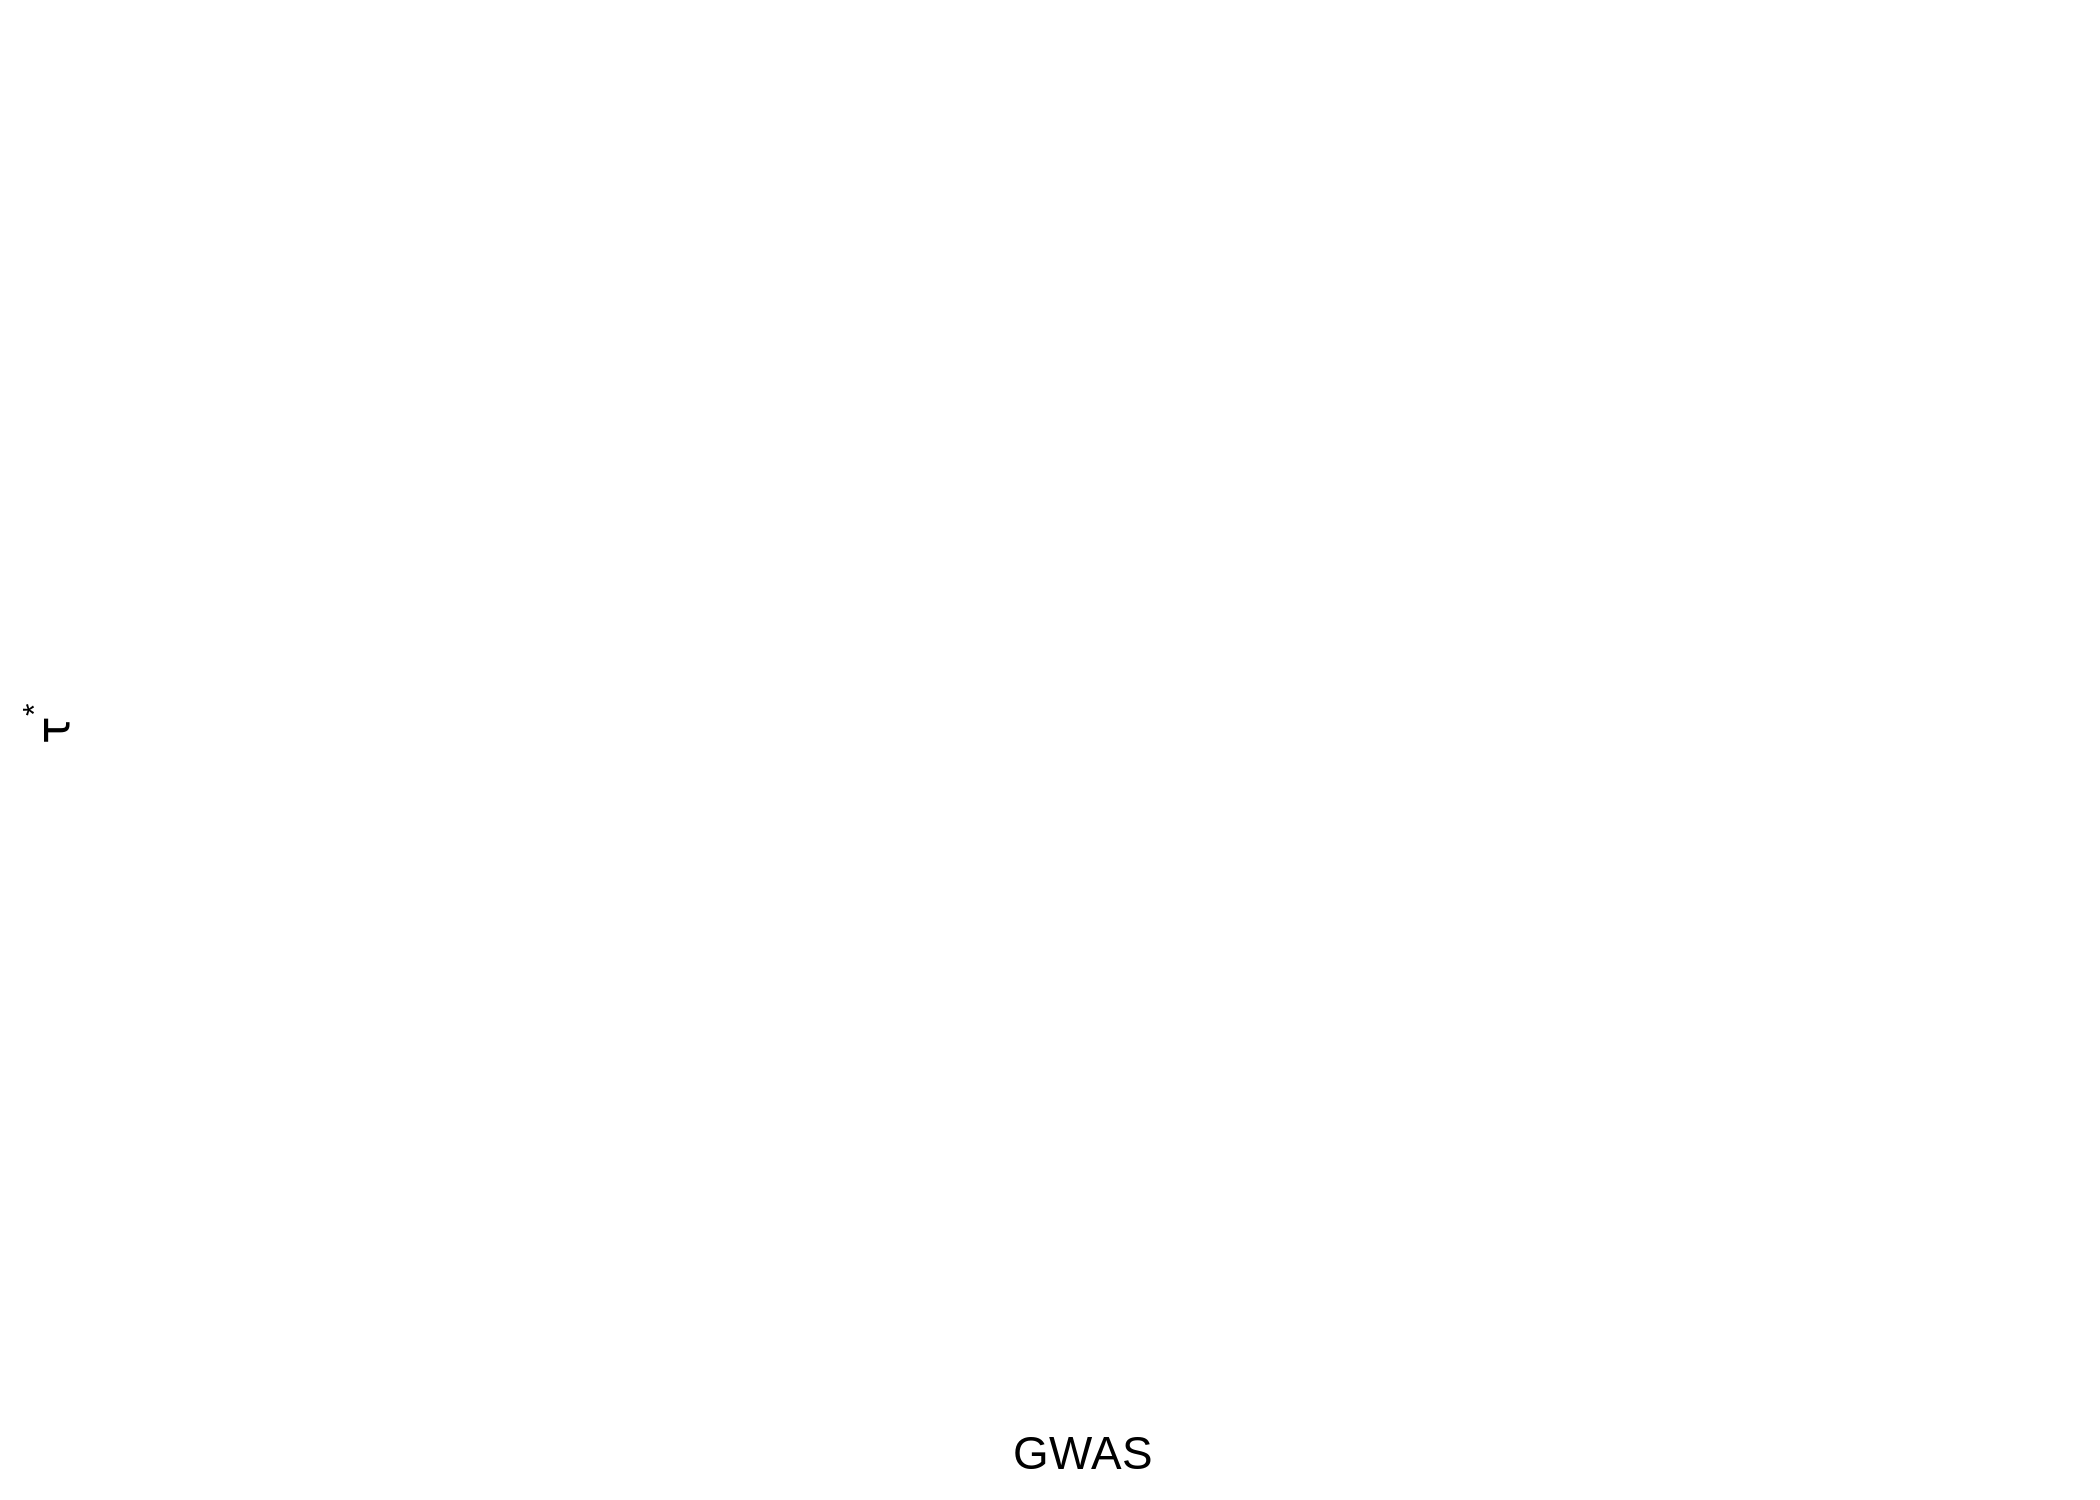

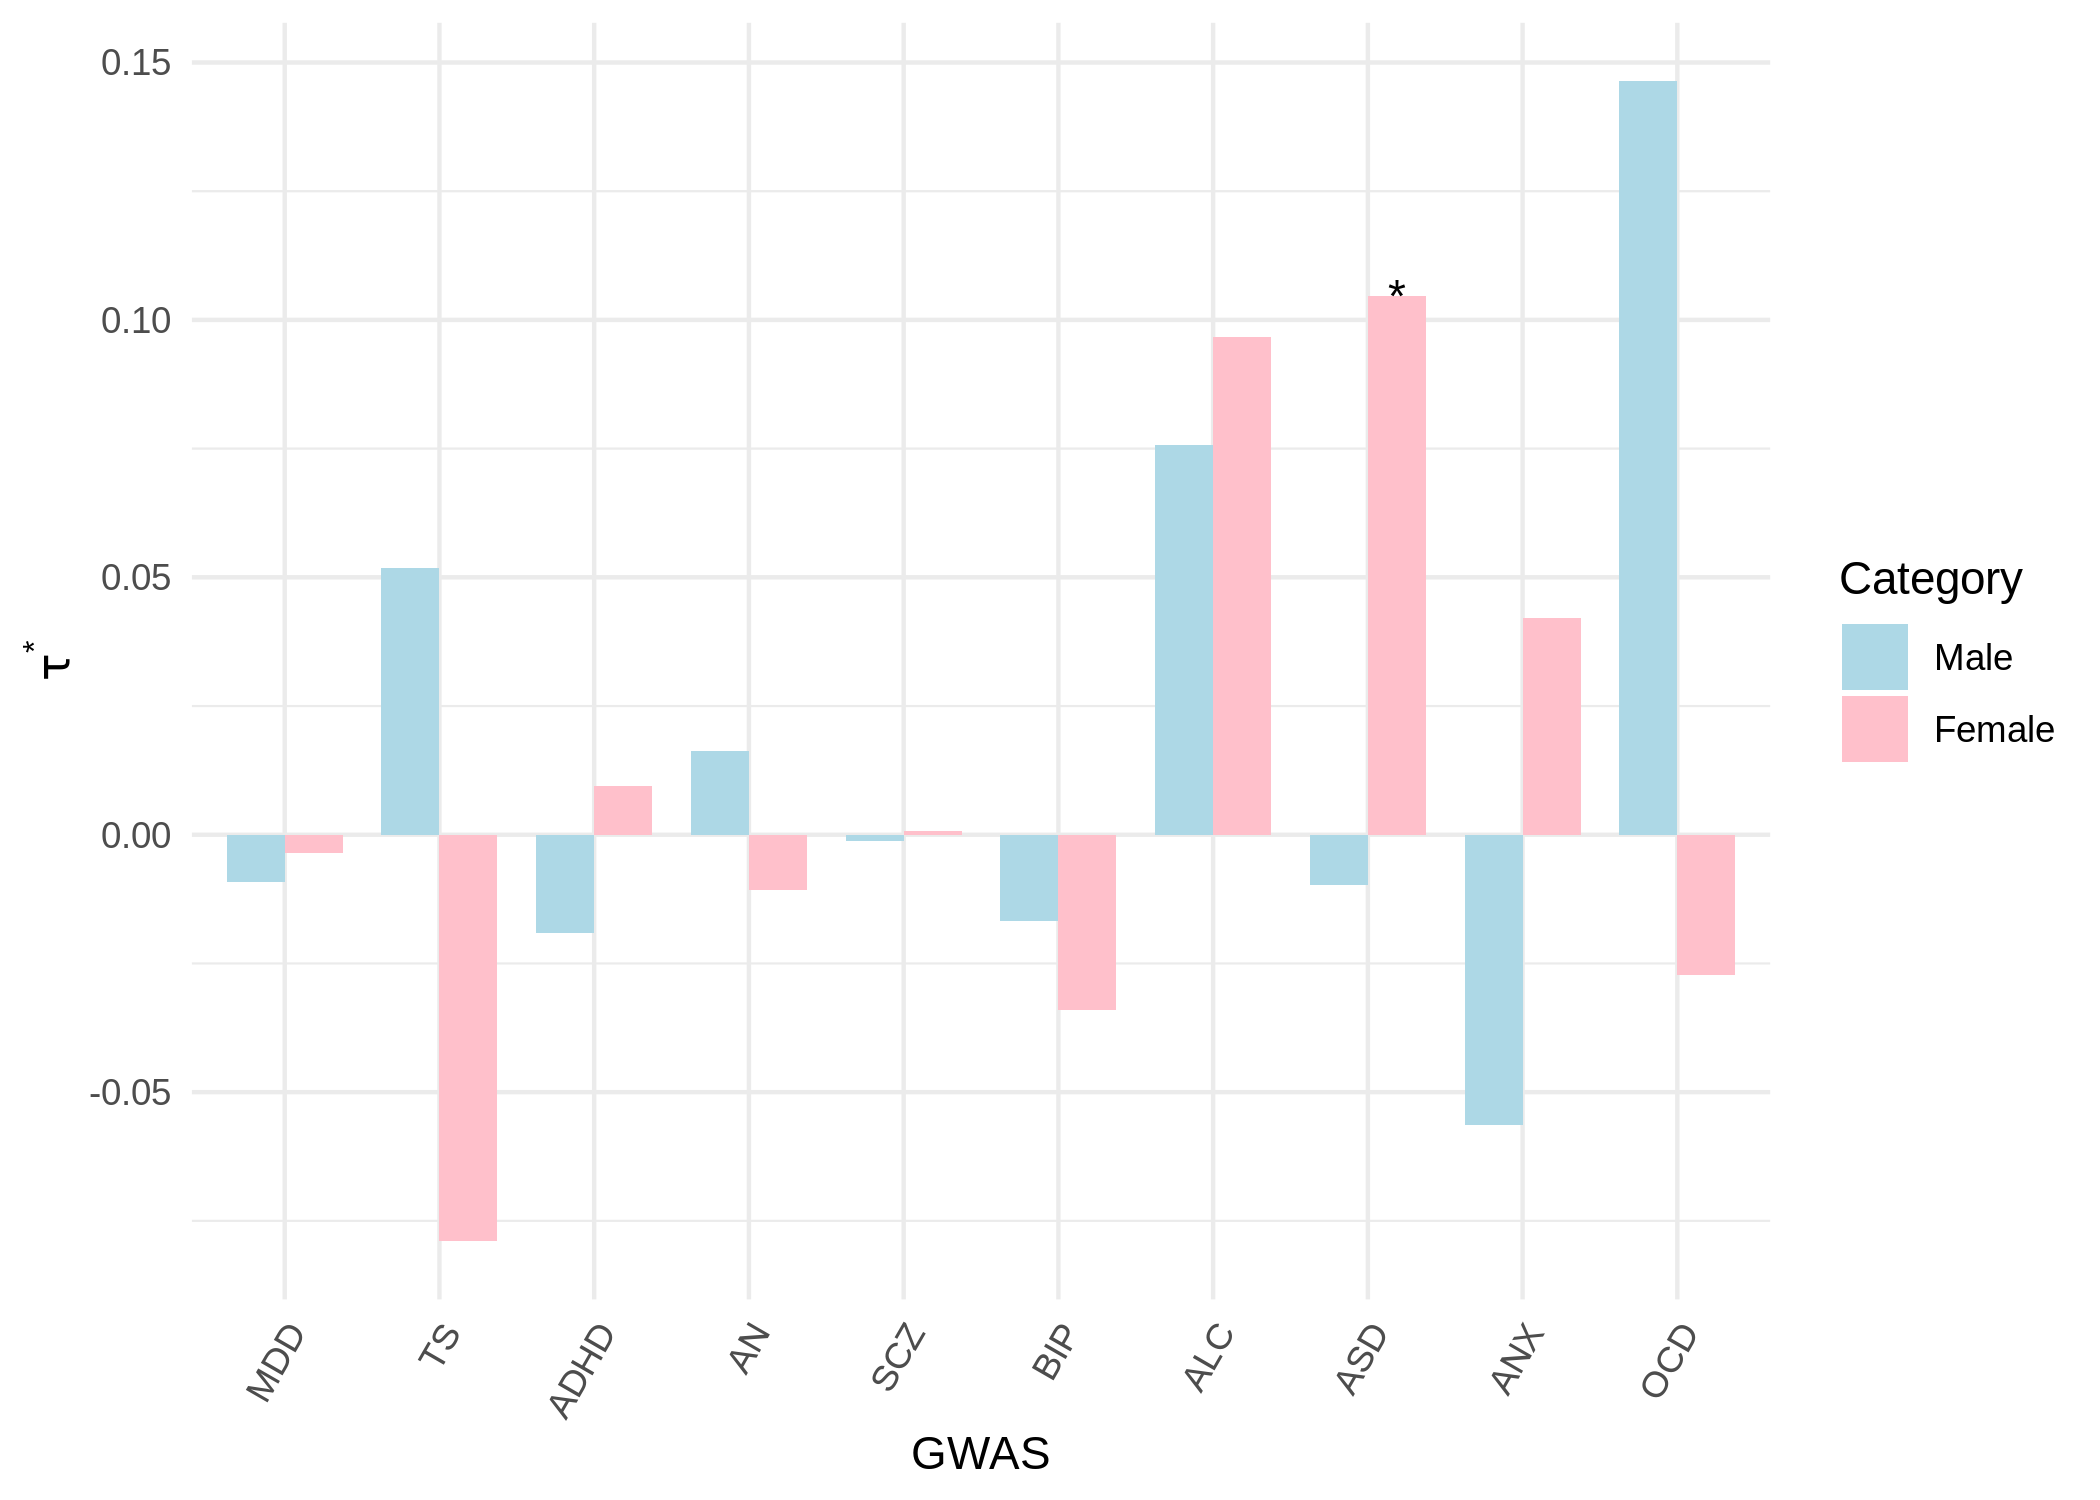

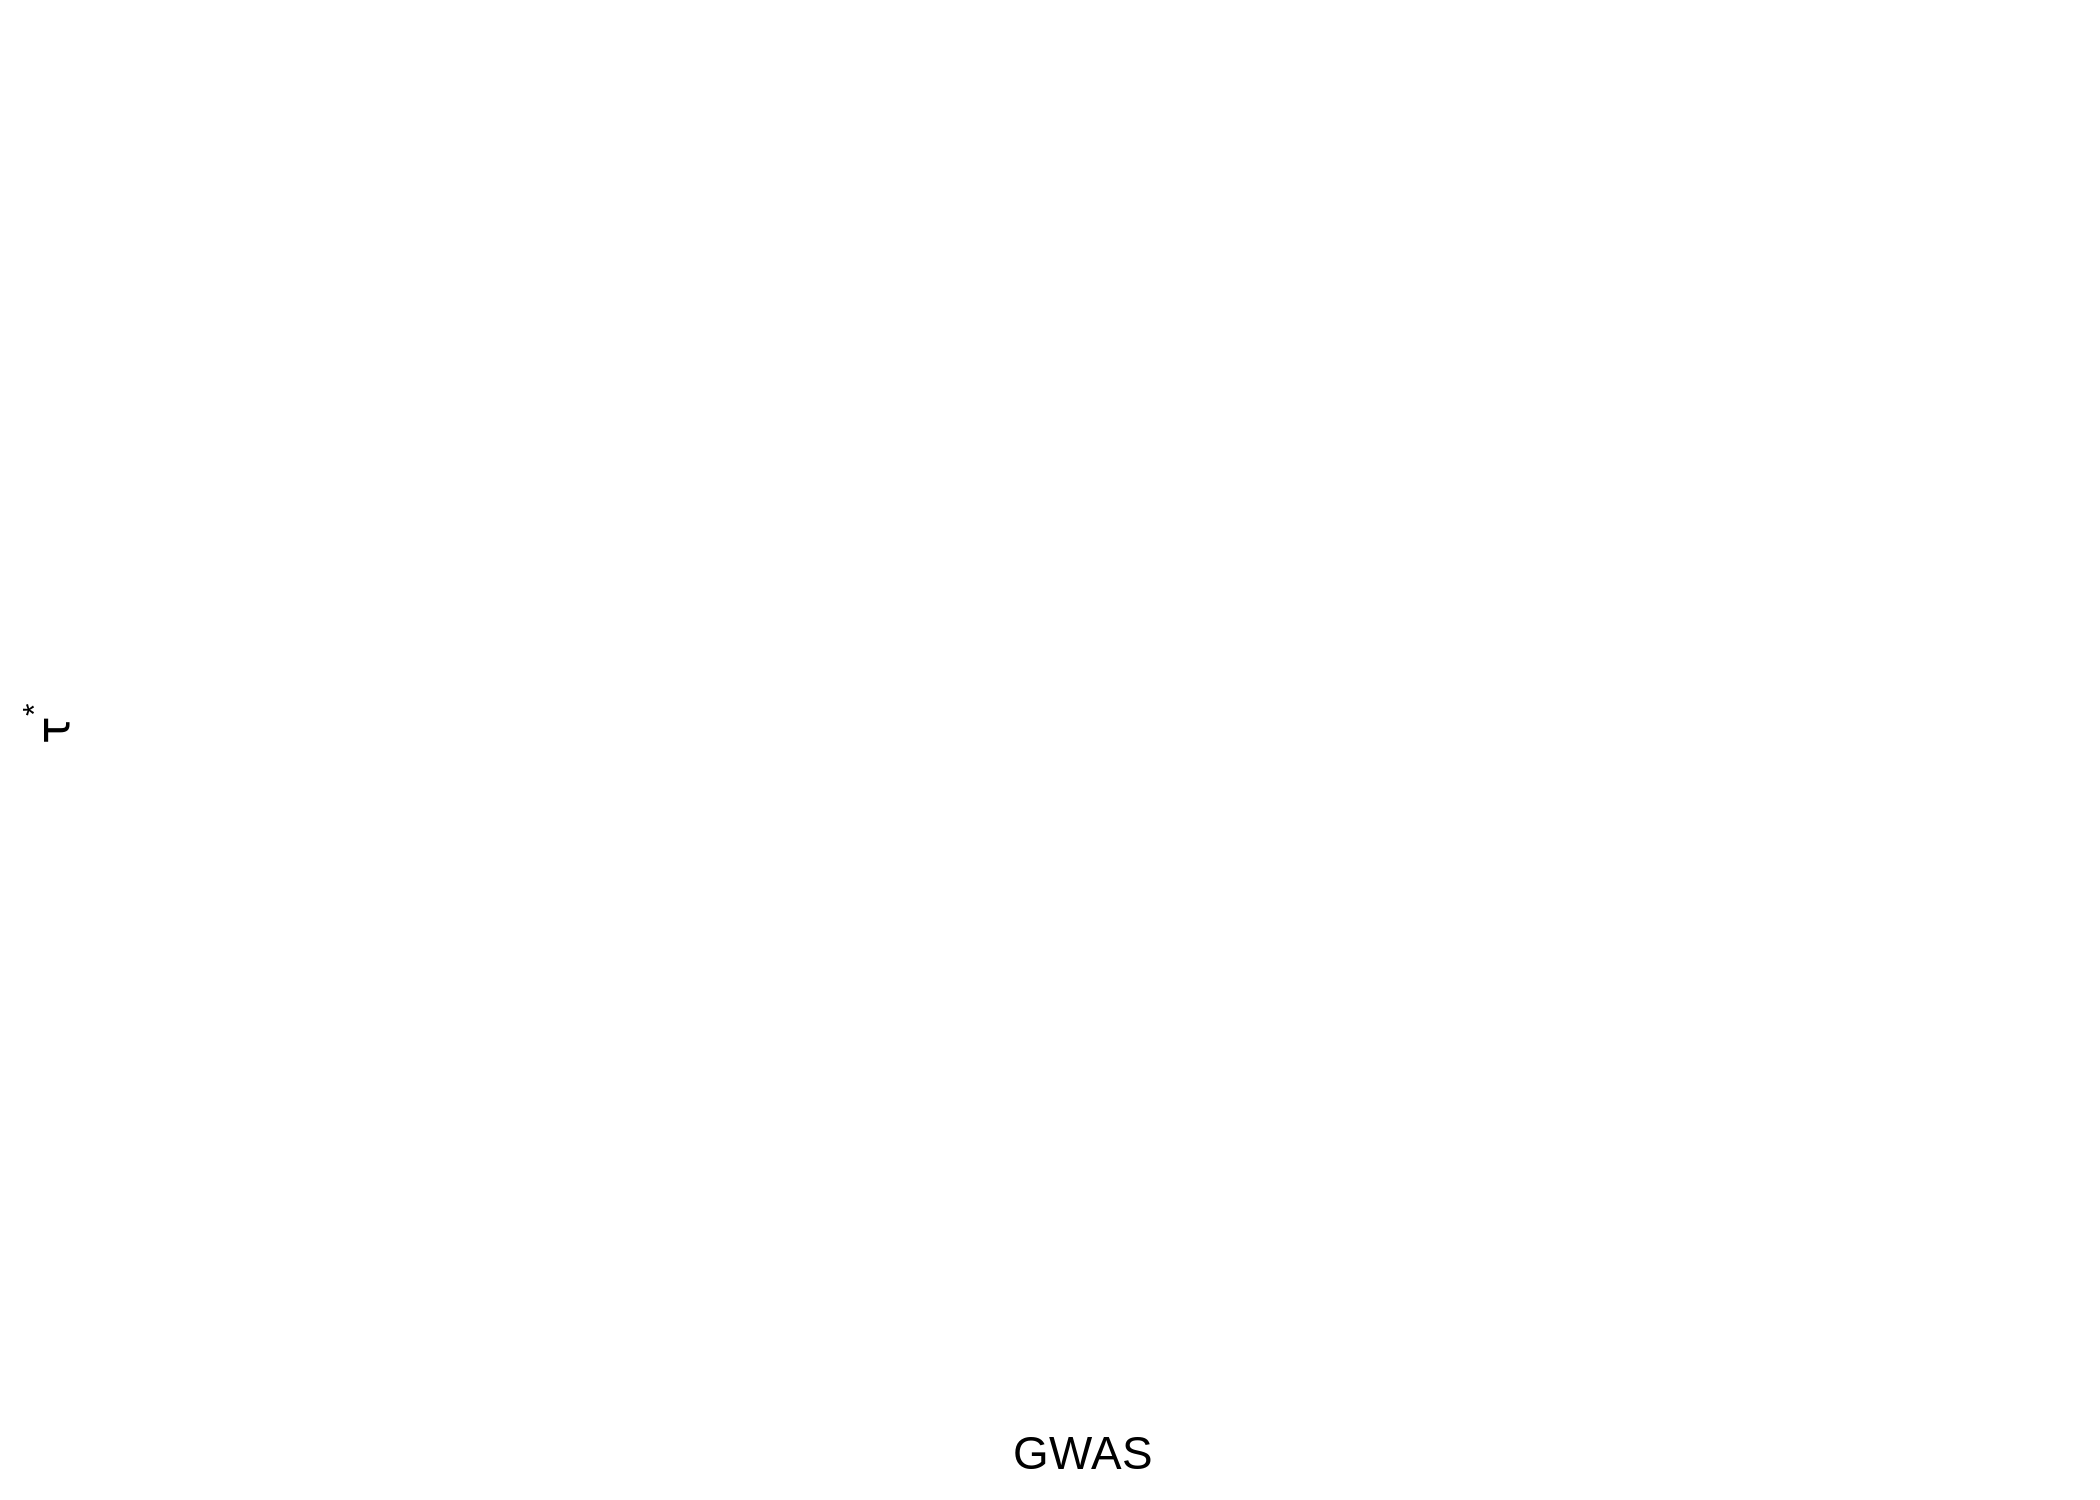

In [61]:
options(width= 10, repr.plot.height= 5, repr.plot.res = 300)
exclude_list <- c("PTSD Males","ASD Females","ANXFS","Alcohol (AUDIT)","Cannabis","Cigarettes Per Day", "Cross Disorder") 
order_dt <-     pgc_part_heritability_baseline_df[
        !GWAS %in% exclude_list &
        !grepl("Male|Female",GWAS) &
        Category %in% c("Marginal", "Sex Interaction", "Male", "Female")& #, "Cord Blood") &
        annotation == "bin_CPP_her" &
        Enrichment - Enrichment_std_error > 0,
        .(max_enrich = max(Enrichment)),
        by = "GWAS"
    ]
GWAS_order <- order_dt[order(max_enrich)]$GWAS
annot_order <- c("Male","Female","Sex Interaction","Marginal") #, "Cord Blood")
ggplot(
    pgc_part_heritability_baseline_df[
        !GWAS %in% exclude_list &
        !grepl("Male|Female",GWAS) &
        Category %in% c("Marginal", "Sex Interaction", "Male", "Female")& #, "Cord Blood") &
        annotation == "maxCPP_her" &
        Enrichment - Enrichment_std_error > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=Enrichment,label = ifelse(significant_enrich,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    scale_fill_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))

ggplot(
    pgc_part_heritability_baseline_df[
        !GWAS %in% exclude_list &
        !grepl("Male|Female",GWAS) &
        Category %in% c("Marginal", "Sex Interaction", "Male", "Female")& #, "Cord Blood") &
        annotation == "bin_CPP_her" &
        Enrichment - Enrichment_std_error > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_order),Category = recode_factor(Category,"Male"="Male","Female"="Female","Sex Interaction"="Sex-dependent","Marginal"="Cross-sex")),
    aes(fill = Category, x=GWAS,y=Enrichment,label = ifelse(significant_enrich,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    scale_fill_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))
ggplot(
    pgc_part_heritability_baseline_df[
        !GWAS %in% exclude_list &
        !grepl("Male|Female",GWAS) &
        Category %in% c("Marginal", "Sex Interaction", "Male", "Female")& #, "Cord Blood") &
        annotation == "all_cis_fdr" &
        Enrichment - Enrichment_std_error > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=Enrichment,label = ifelse(significant_enrich,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    scale_fill_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))

ggplot(
    pgc_part_heritability_baseline_df[
        !GWAS %in% exclude_list &
        !grepl("Male|Female",GWAS) &
        Category %in% c("Marginal", "Sex Interaction", "Male", "Female")& #, "Cord Blood") &
        annotation == "maxCPP_her" &
        Enrichment - Enrichment_std_error > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=tau_star,label = ifelse(pnorm(abs(tau_star/tau_se),lower.tail=F)*2 < 0.05,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    scale_fill_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    labs(y=bquote(tau^"*"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))

ggplot(
    pgc_part_heritability_baseline_df[
        !GWAS %in% exclude_list &
        !grepl("Male|Female",GWAS) &
        Category %in% c("Marginal", "Sex Interaction", "Male", "Female")& #, "Cord Blood") &
        annotation == "bin_CPP_her" &
        Enrichment - Enrichment_std_error > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=tau_star,label = ifelse(pnorm(abs(tau_star/tau_se),lower.tail=F)*2 < 0.05,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    labs(y=bquote(tau^"*"))+
    scale_fill_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))

ggplot(
    pgc_part_heritability_baseline_df[
        !GWAS %in% exclude_list &
        !grepl("Male|Female",GWAS) &
        Category %in% c("Marginal", "Sex Interaction", "Male", "Female")& #, "Cord Blood") &
        annotation == "all_cis_fdr" &
        Enrichment - Enrichment_std_error > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=tau_star,label = ifelse(pnorm(abs(tau_star/tau_se),lower.tail=F)*2 < 0.05,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    labs(y=bquote(tau^"*"))+
    scale_fill_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))

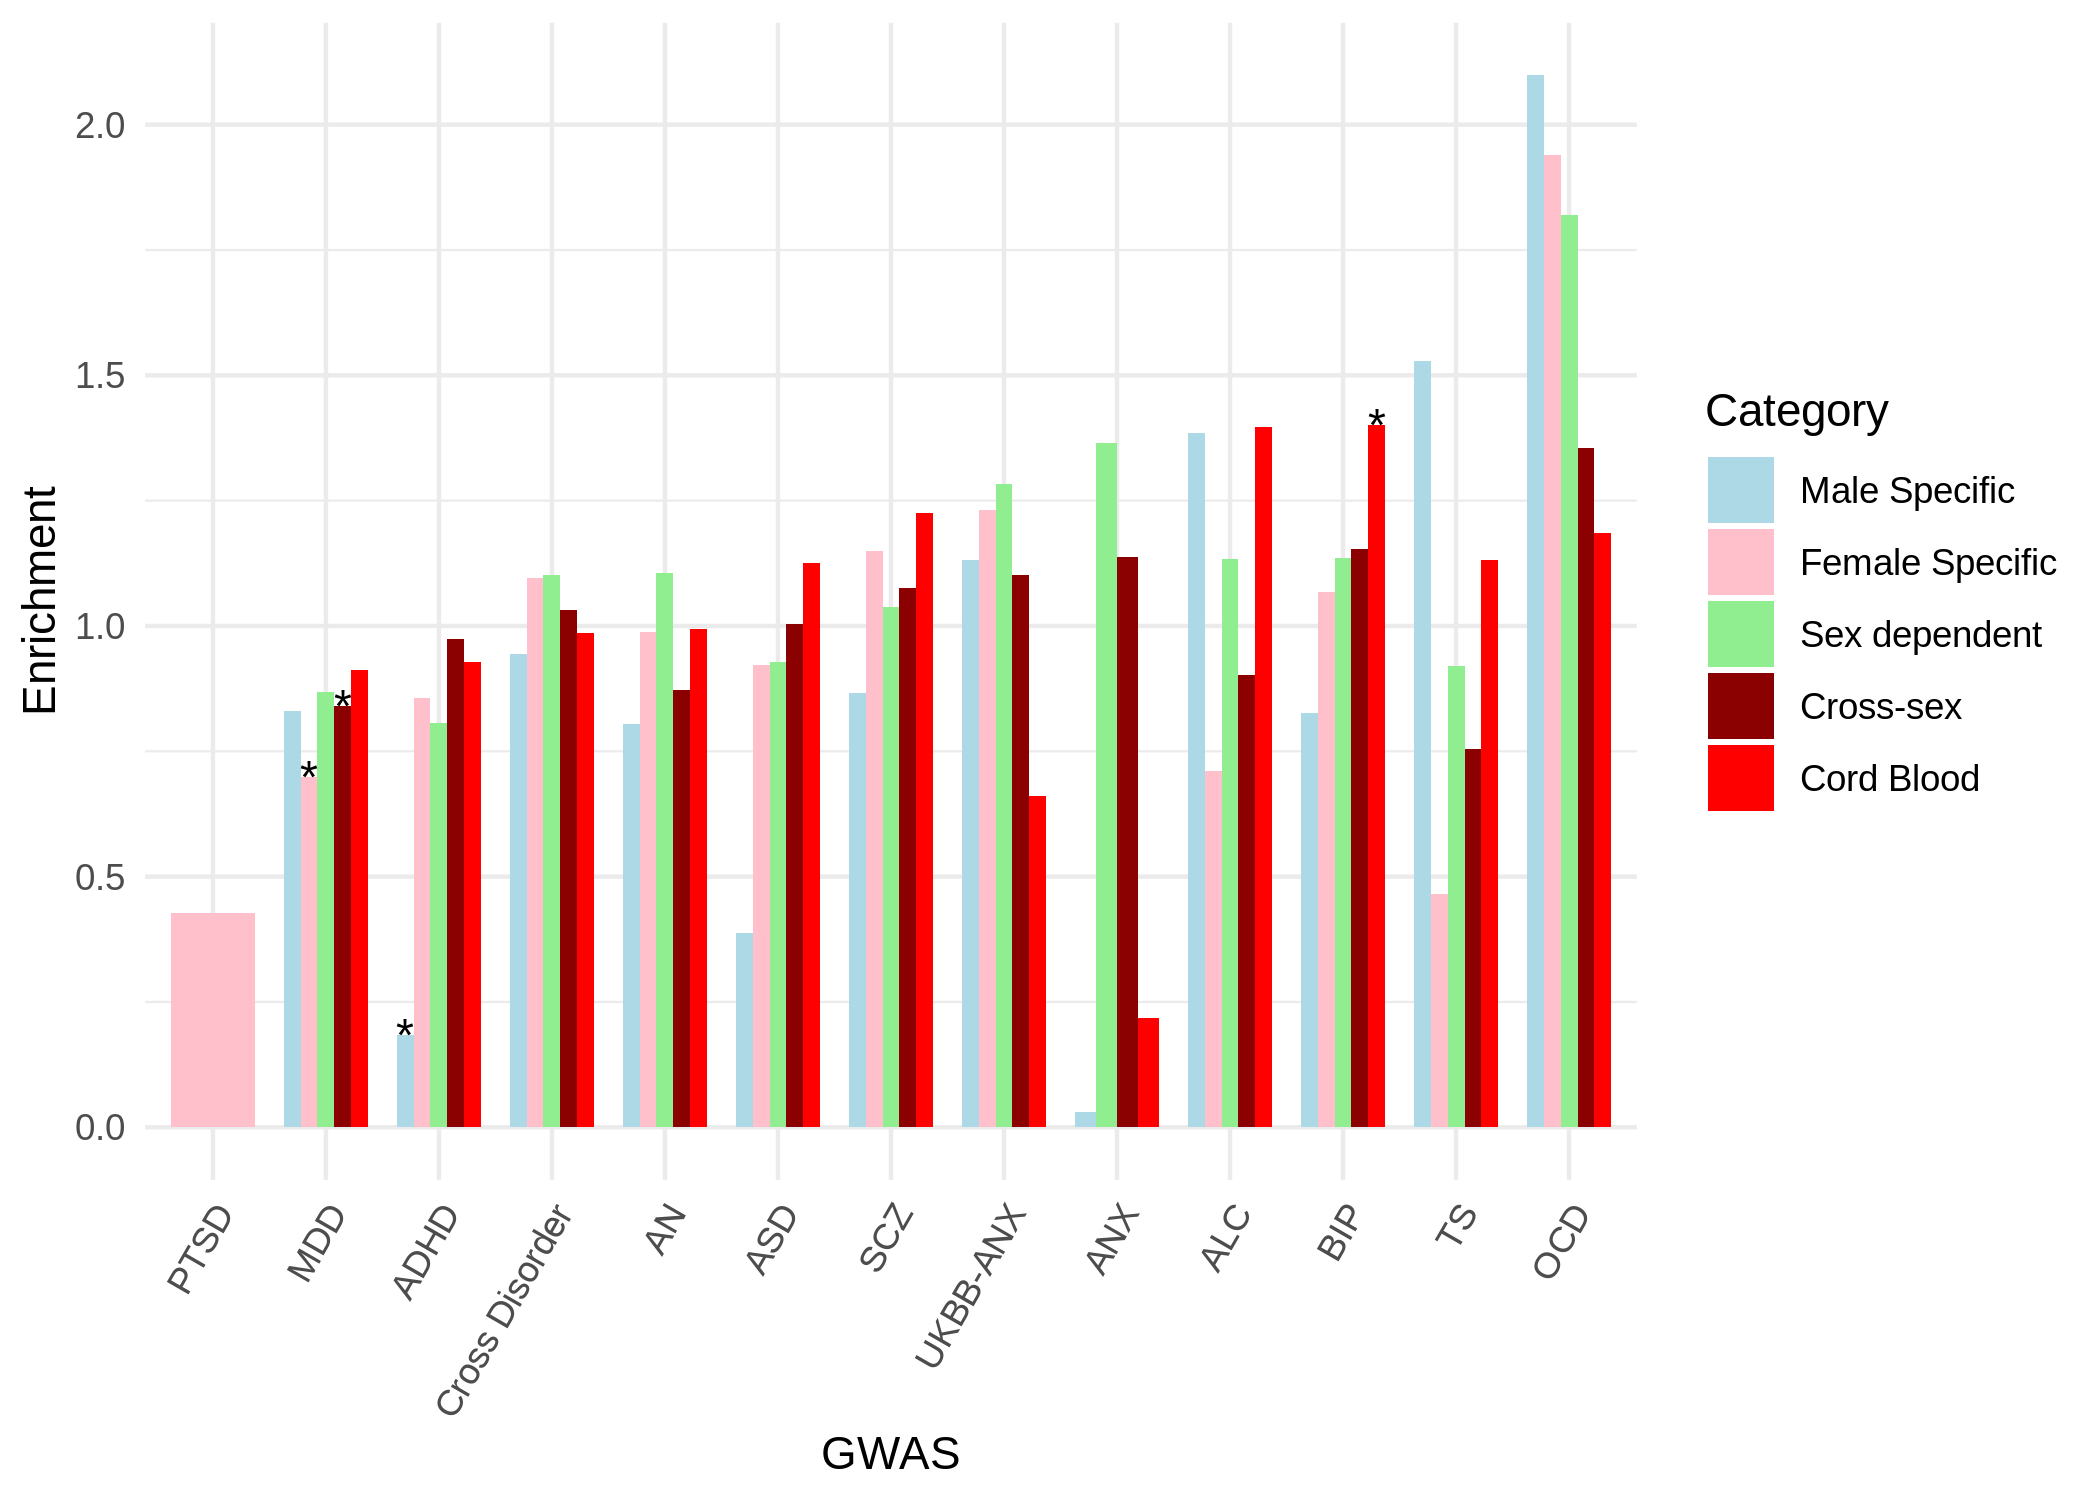

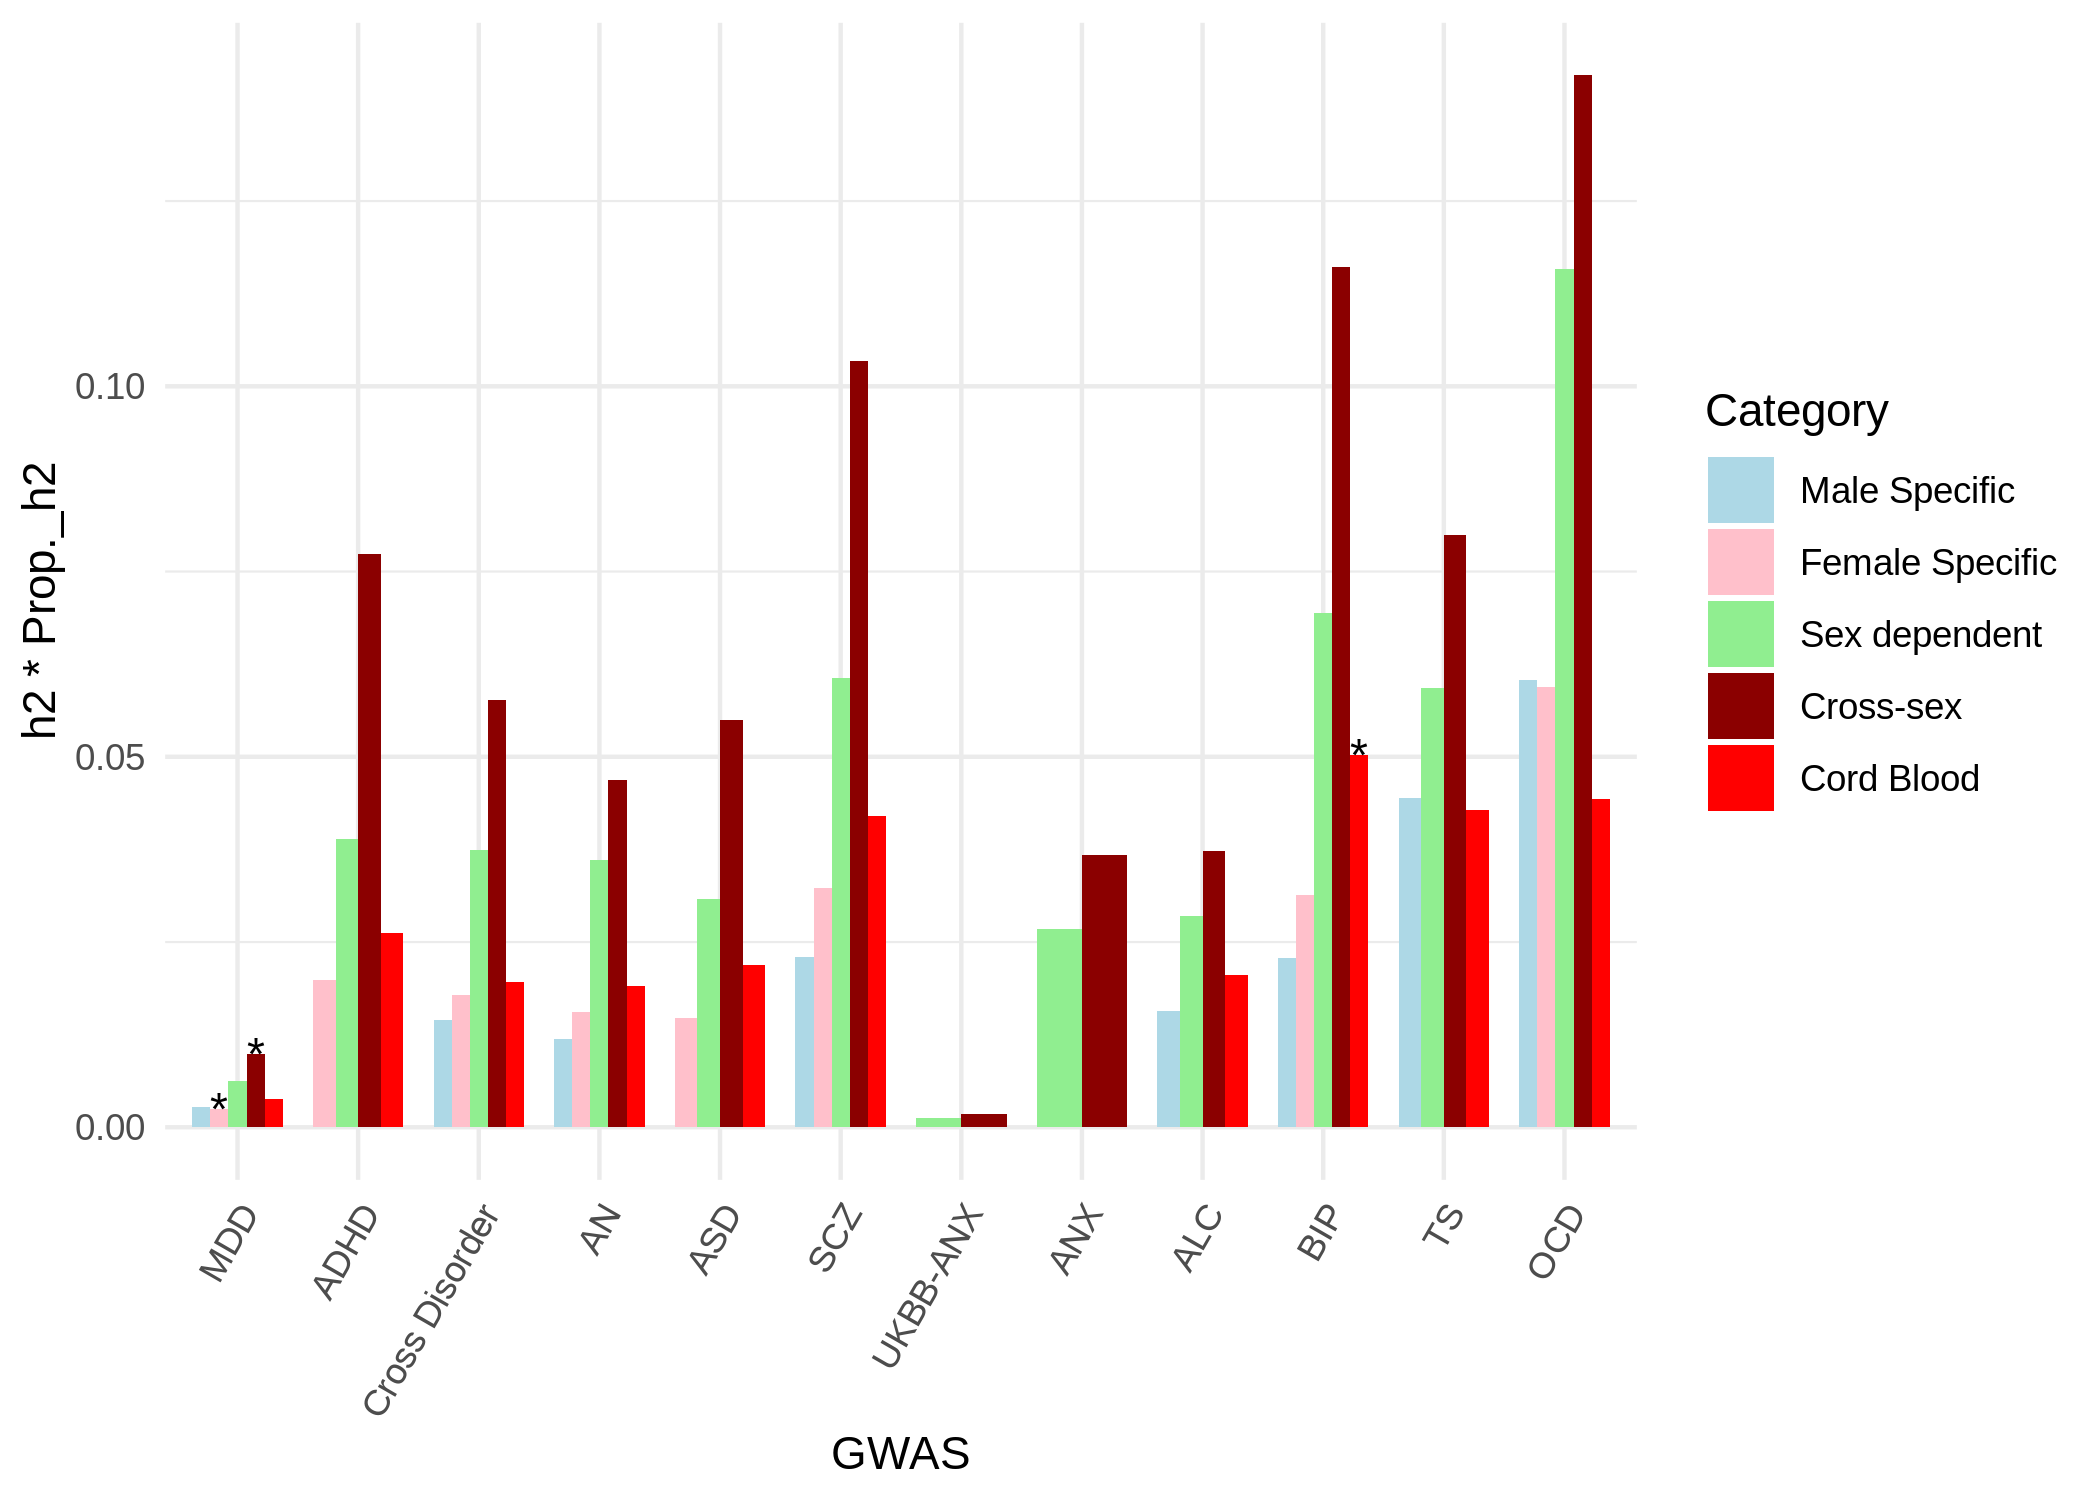

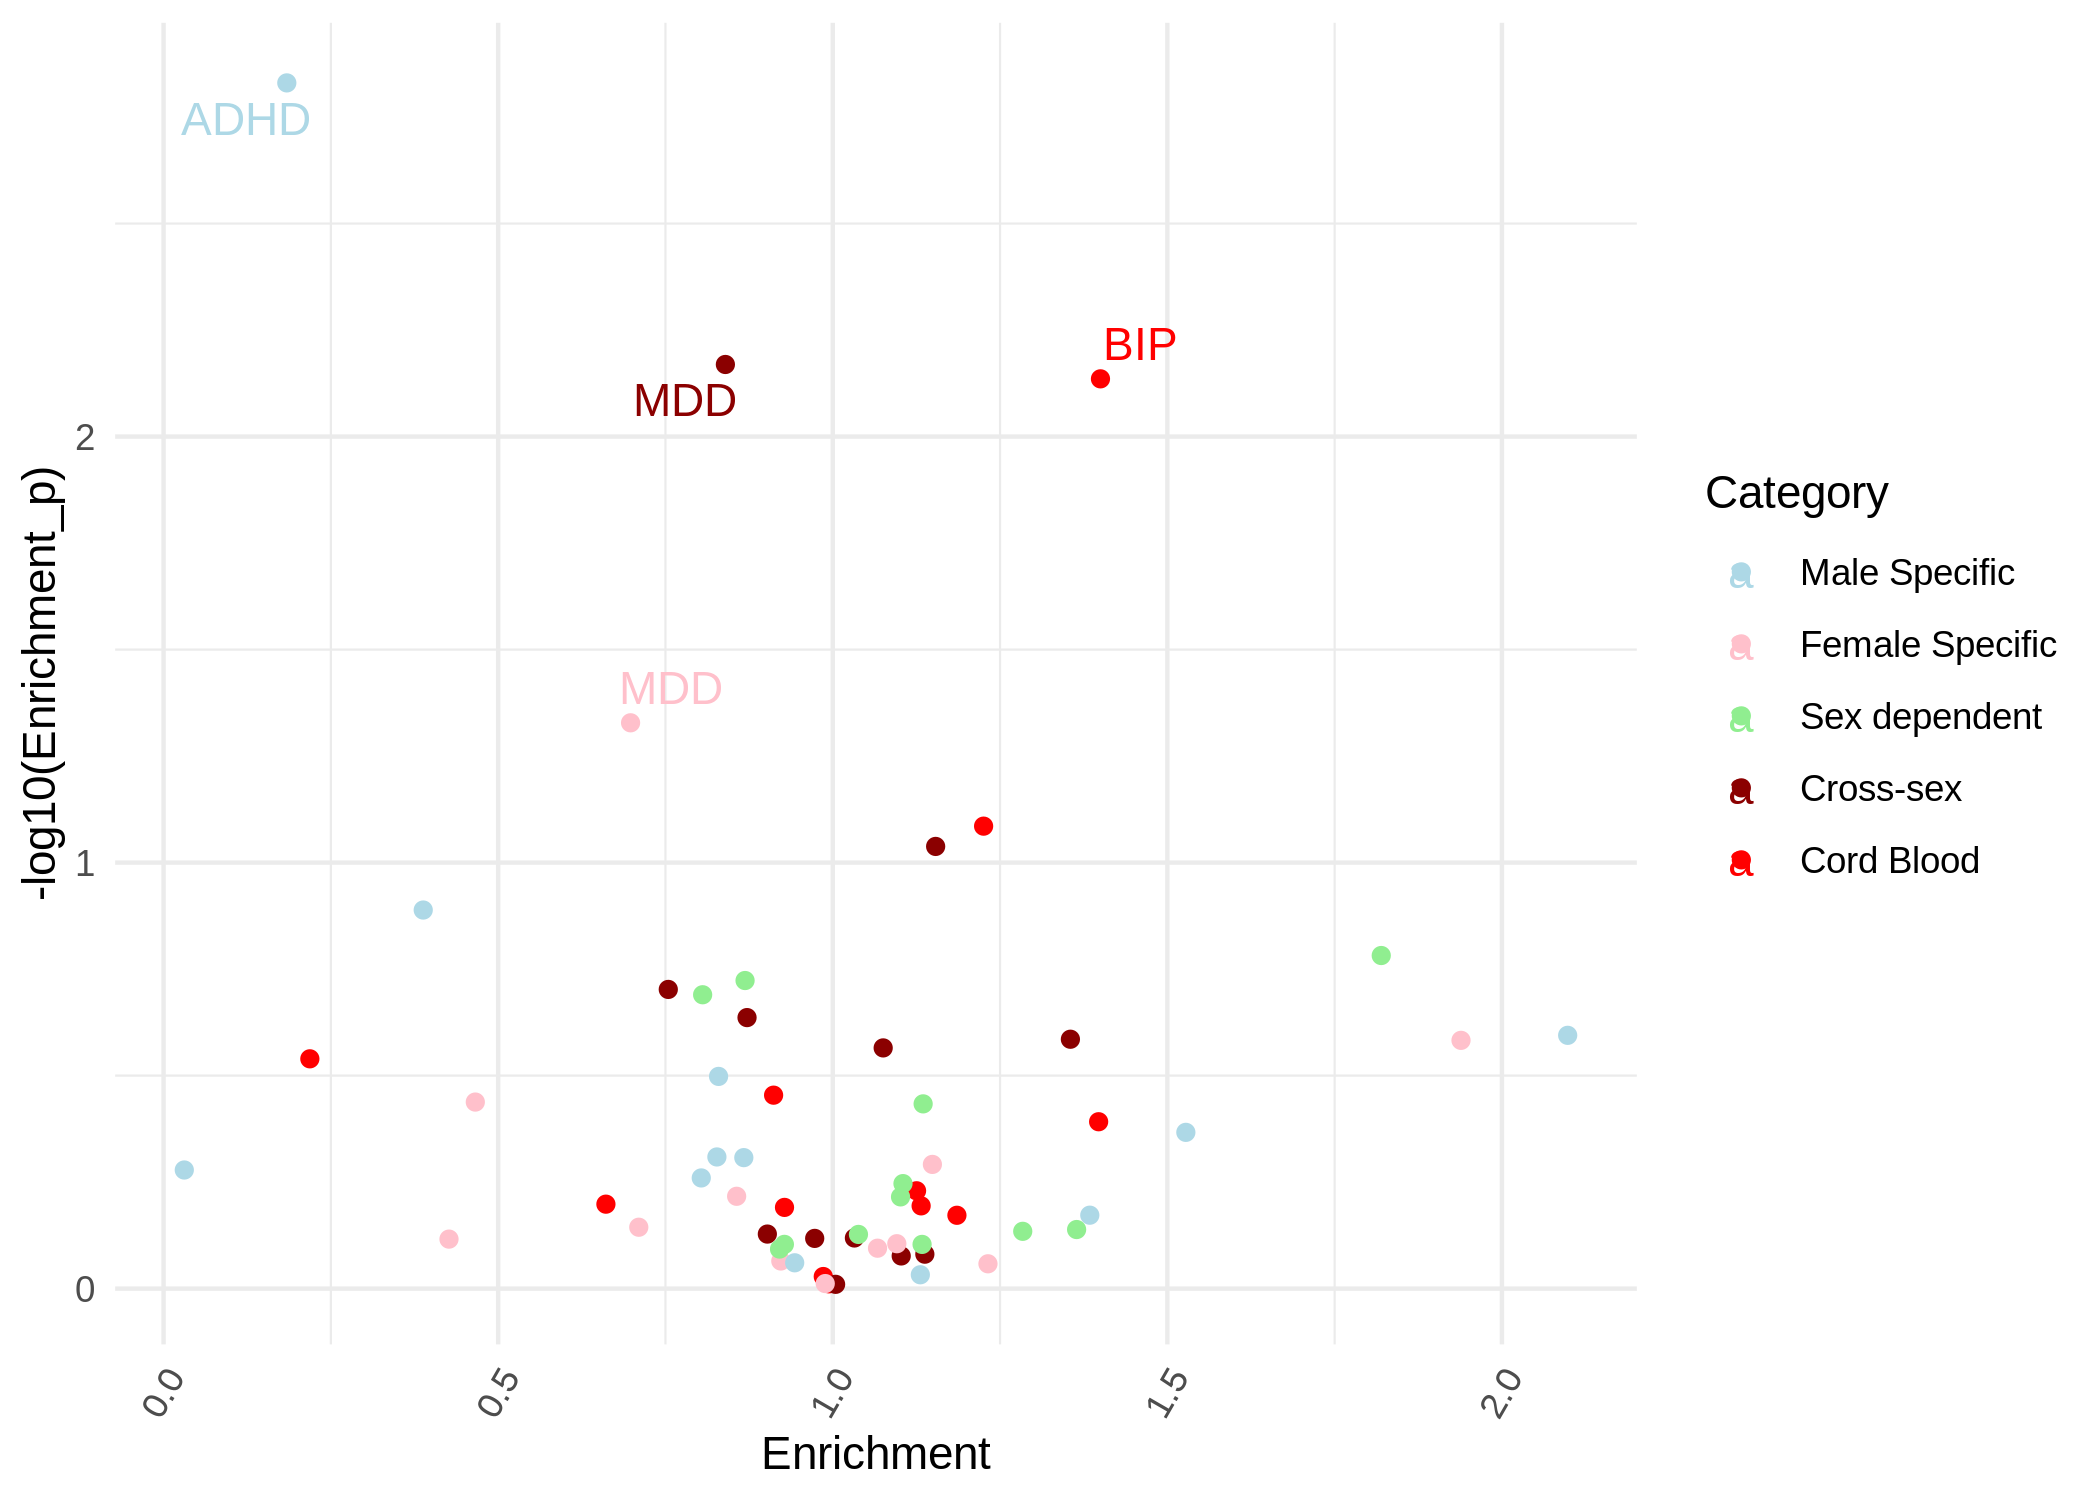

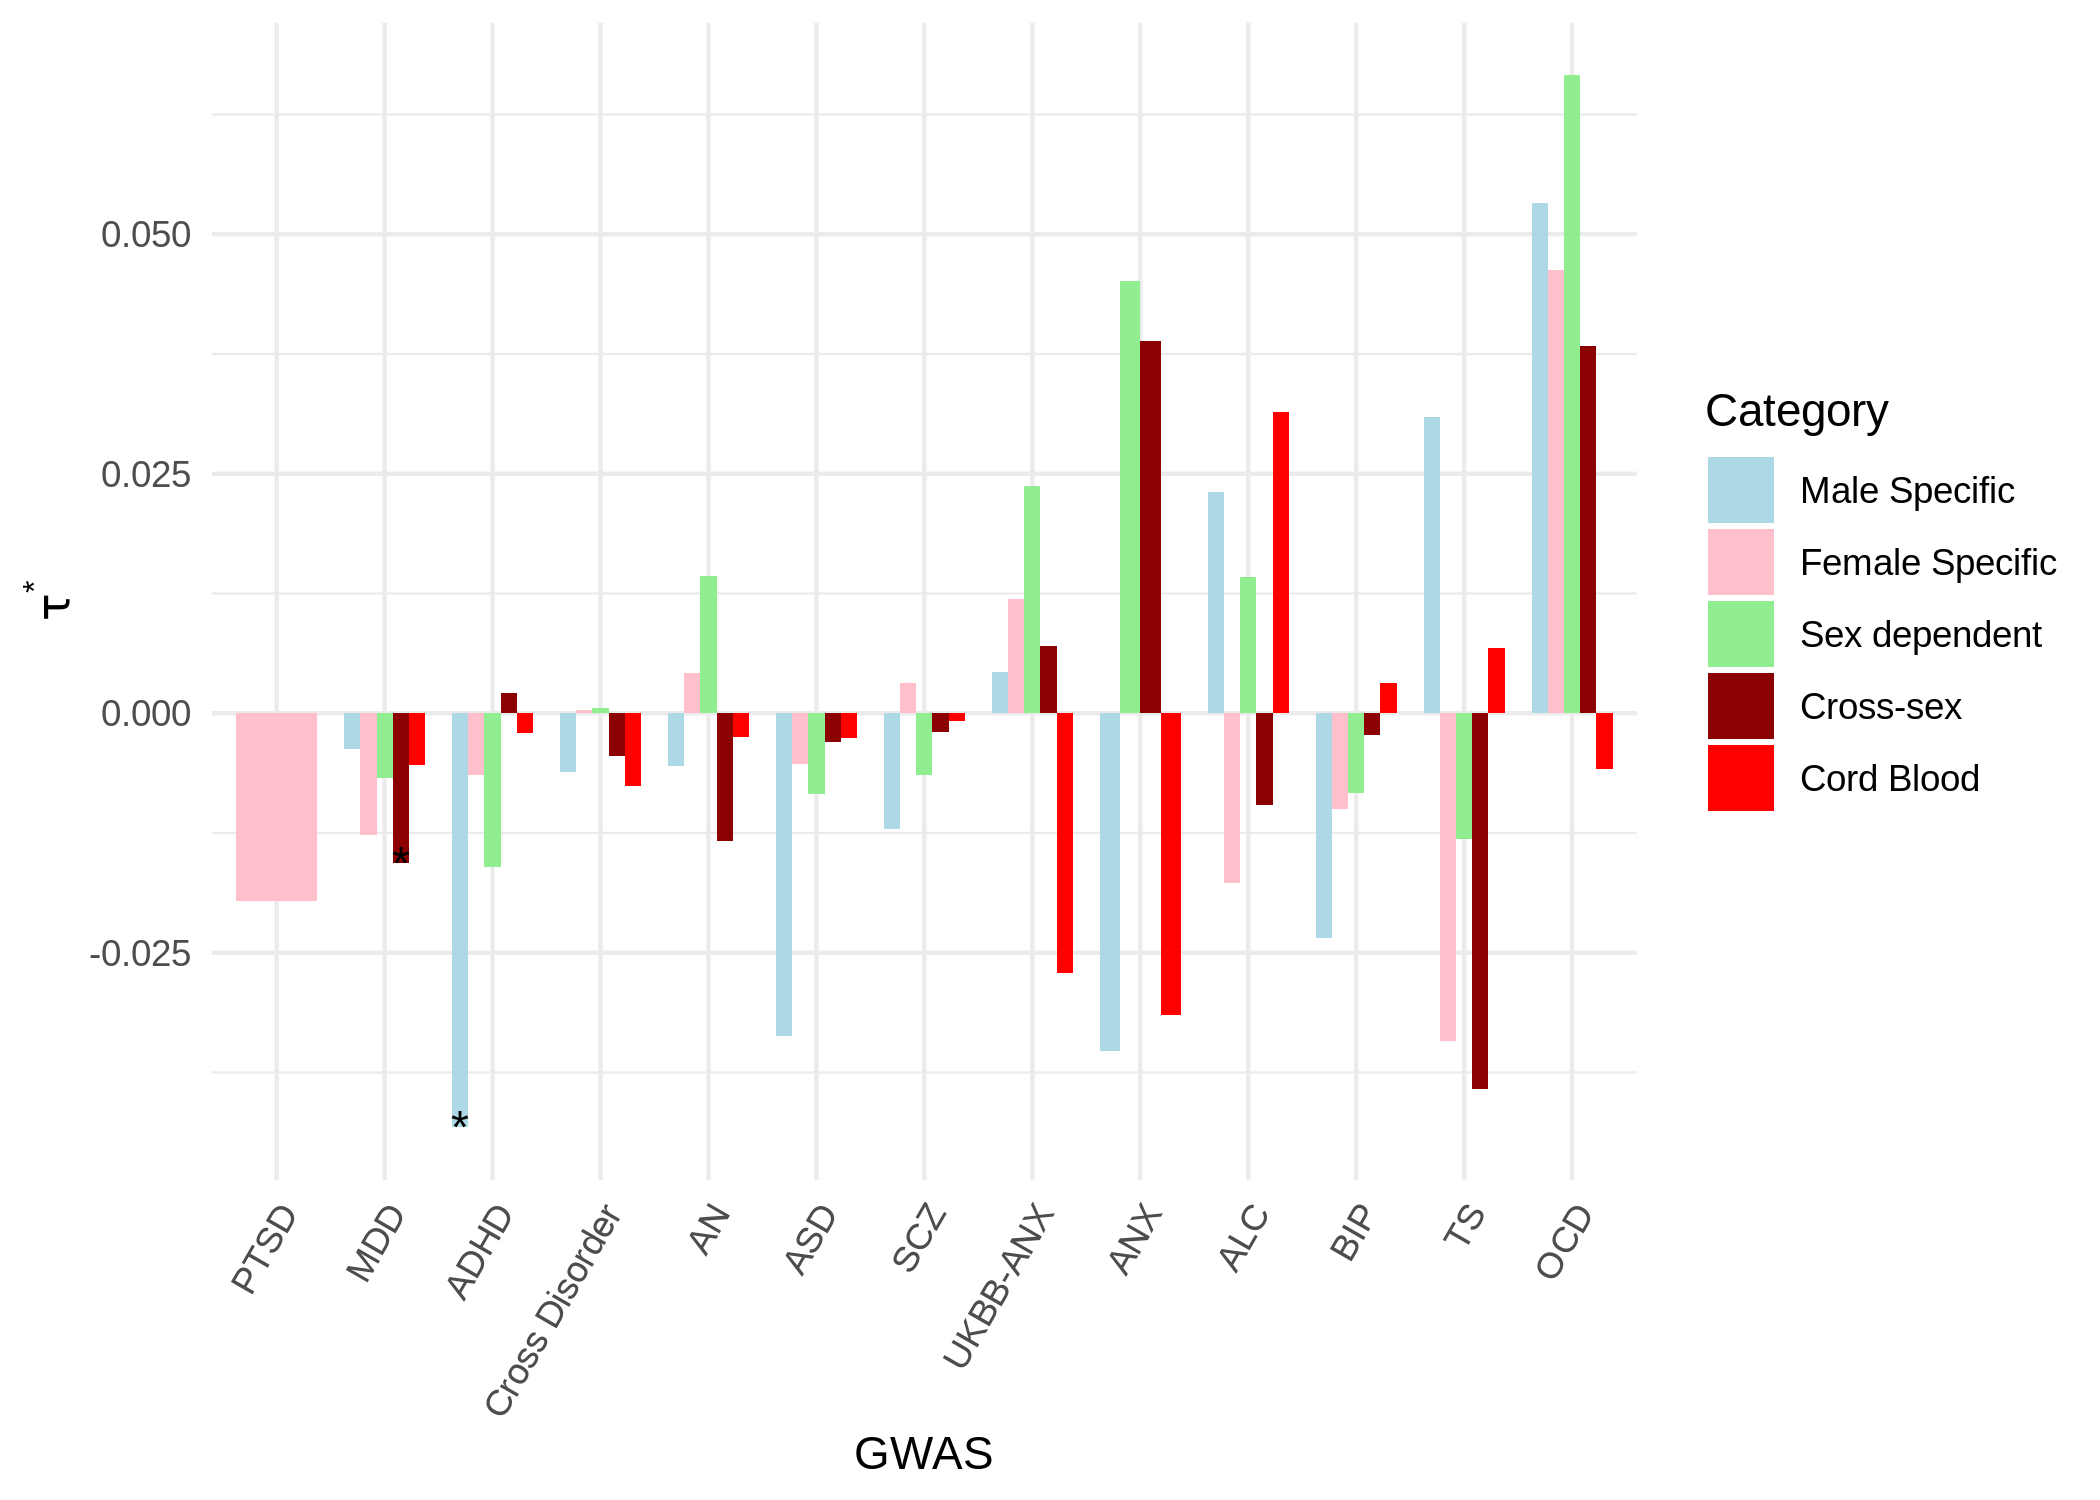

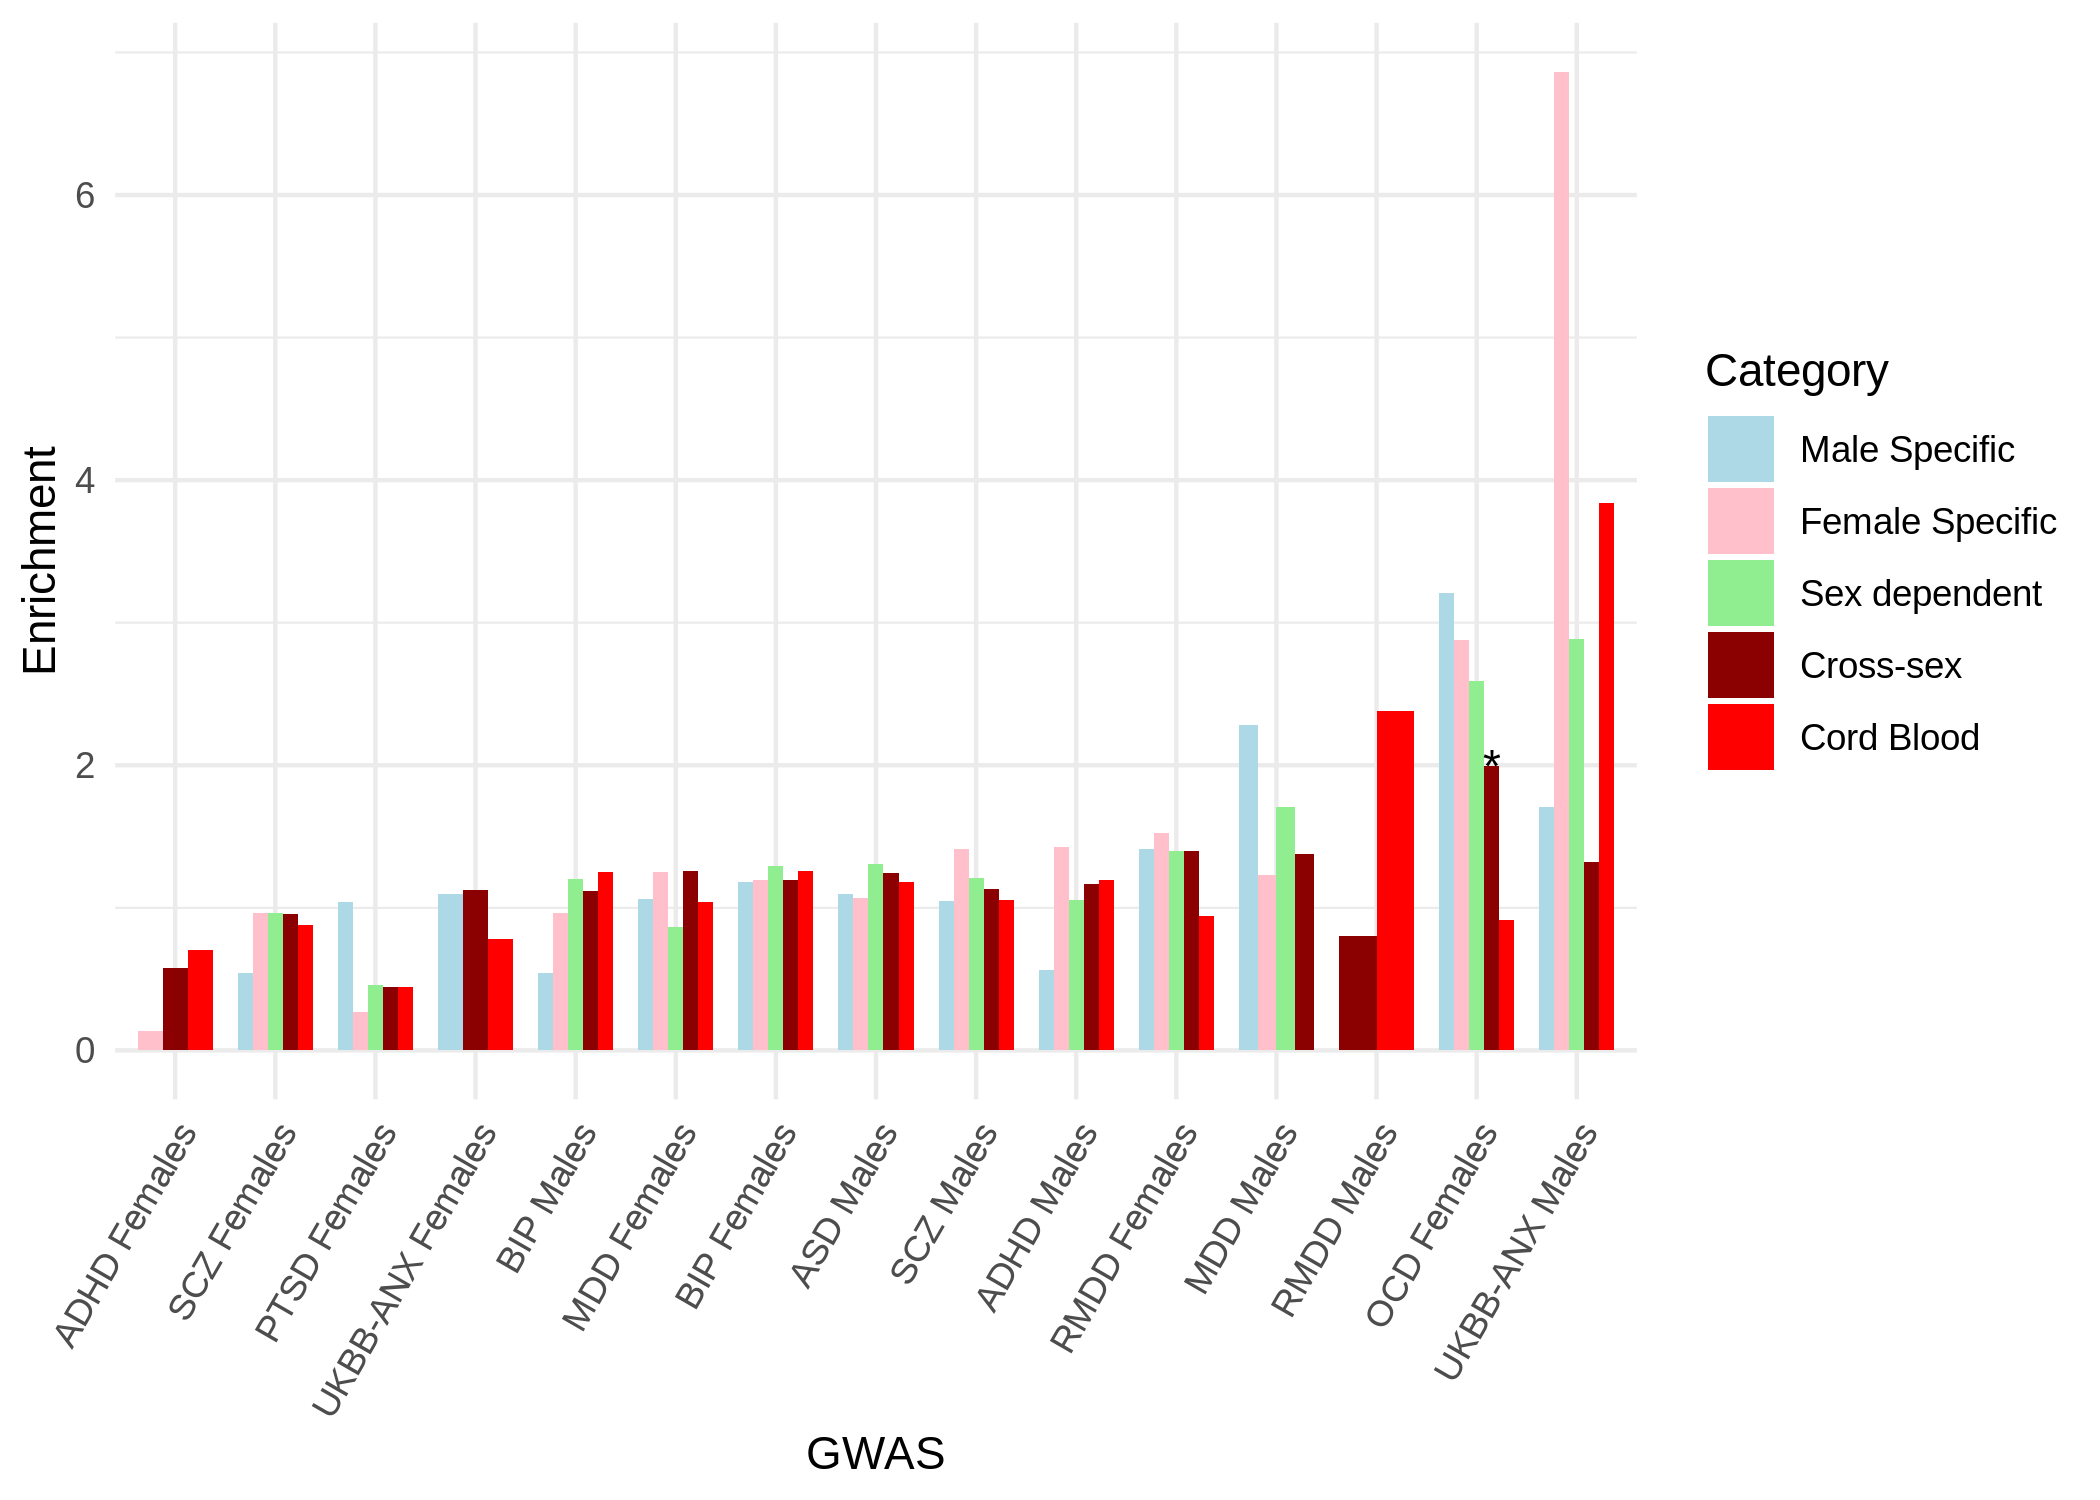

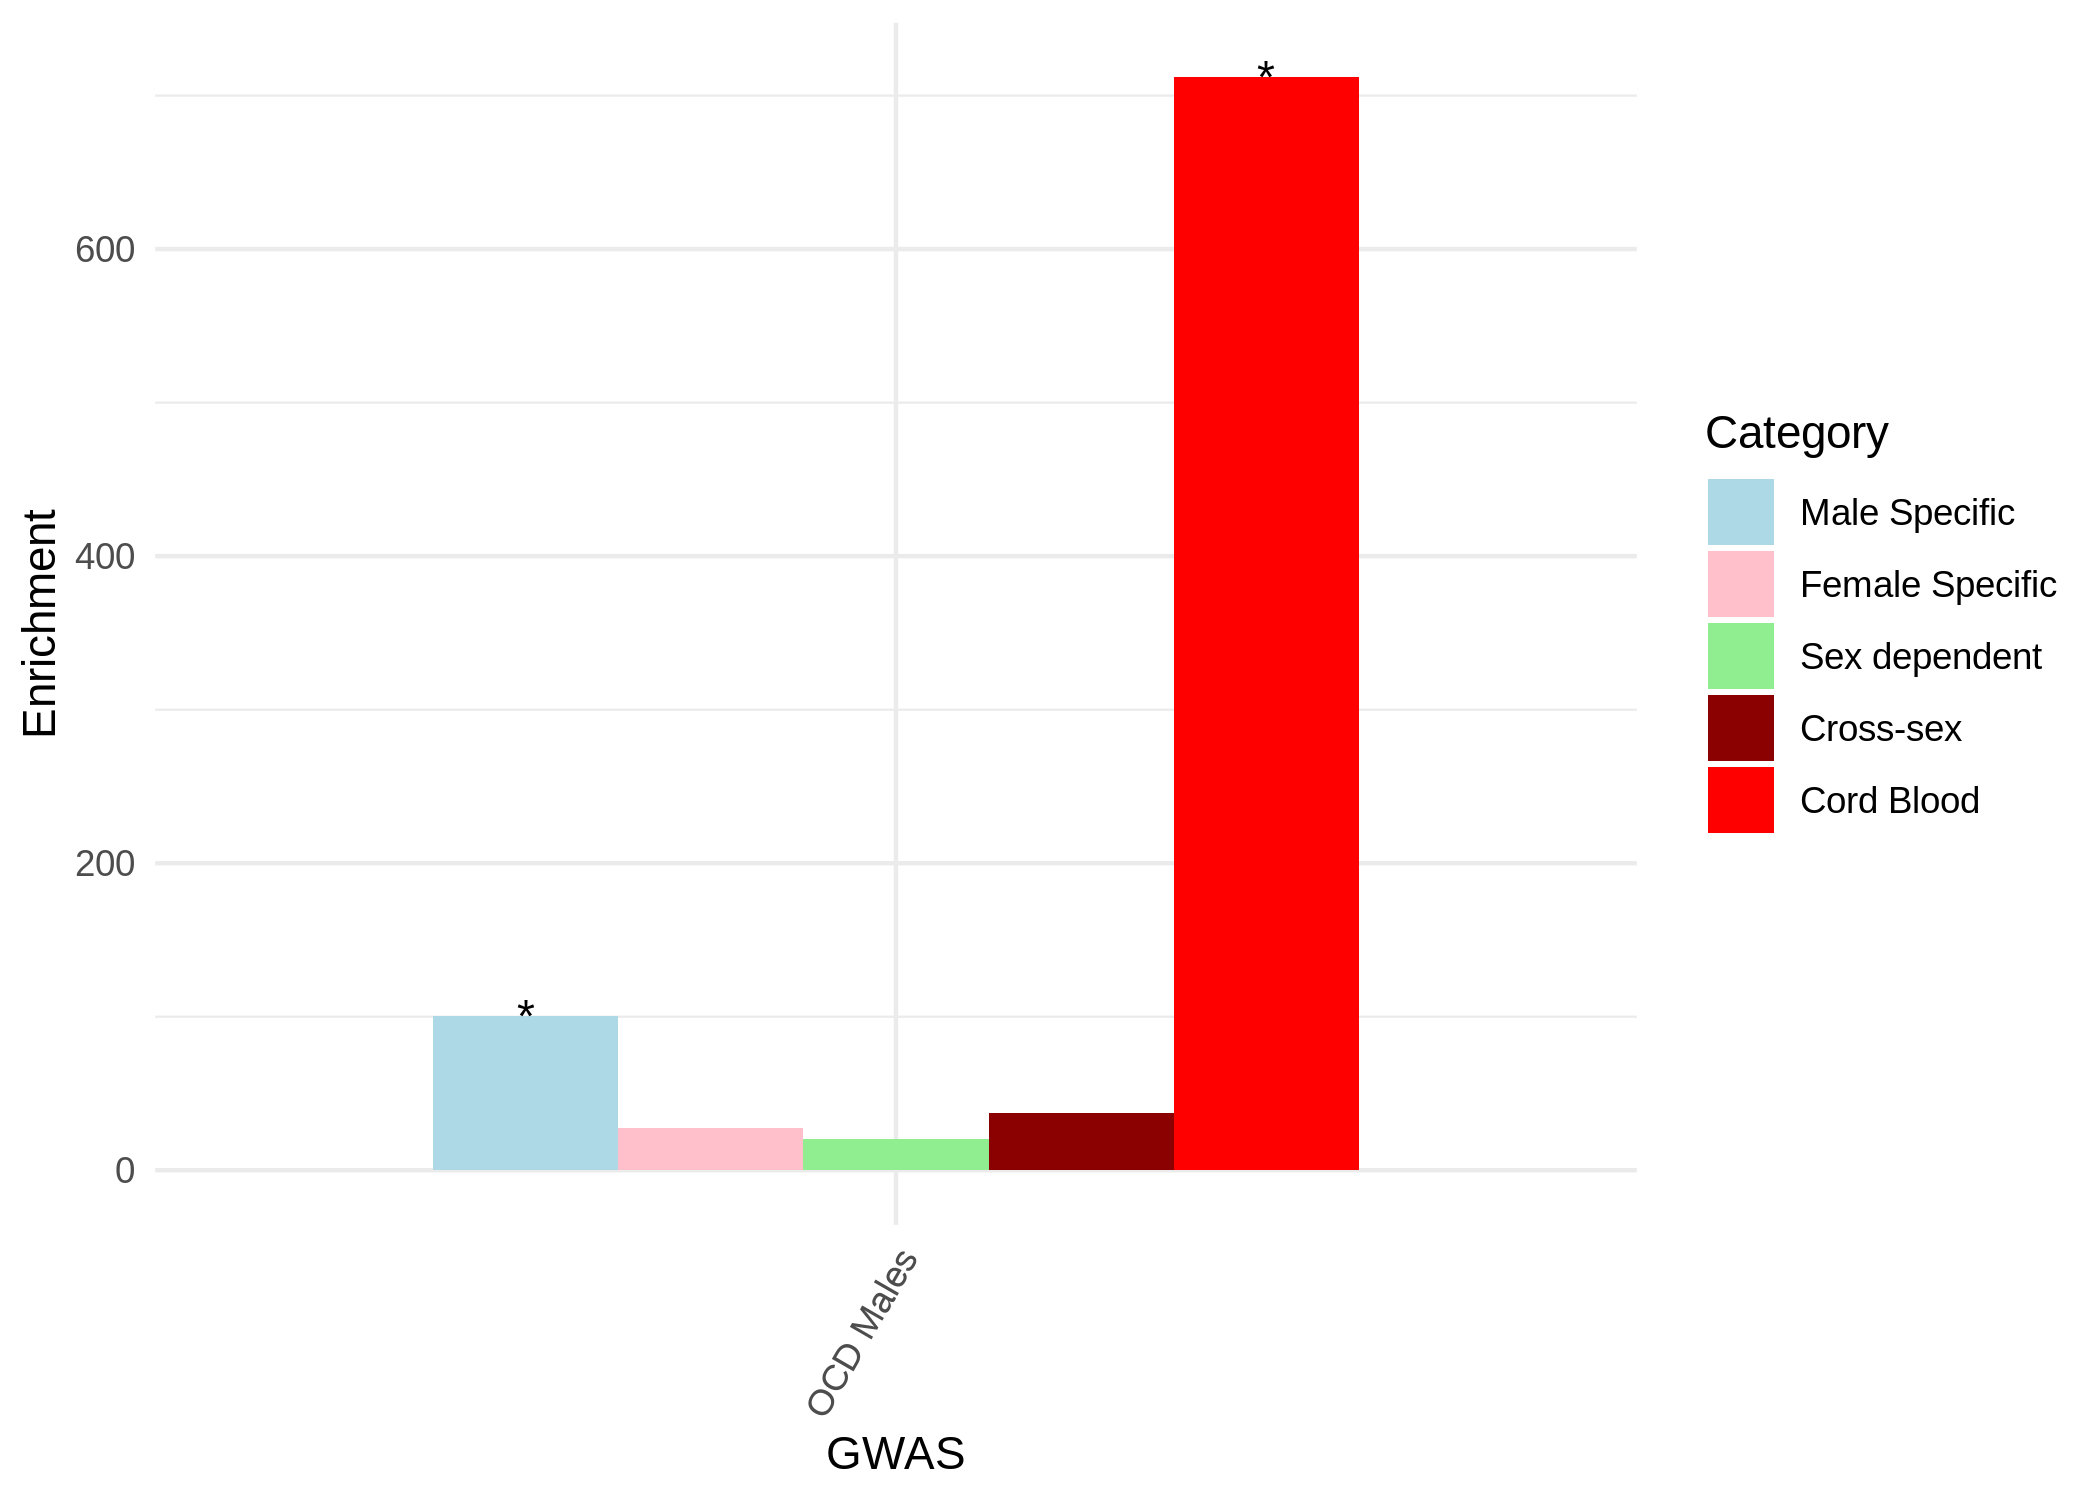

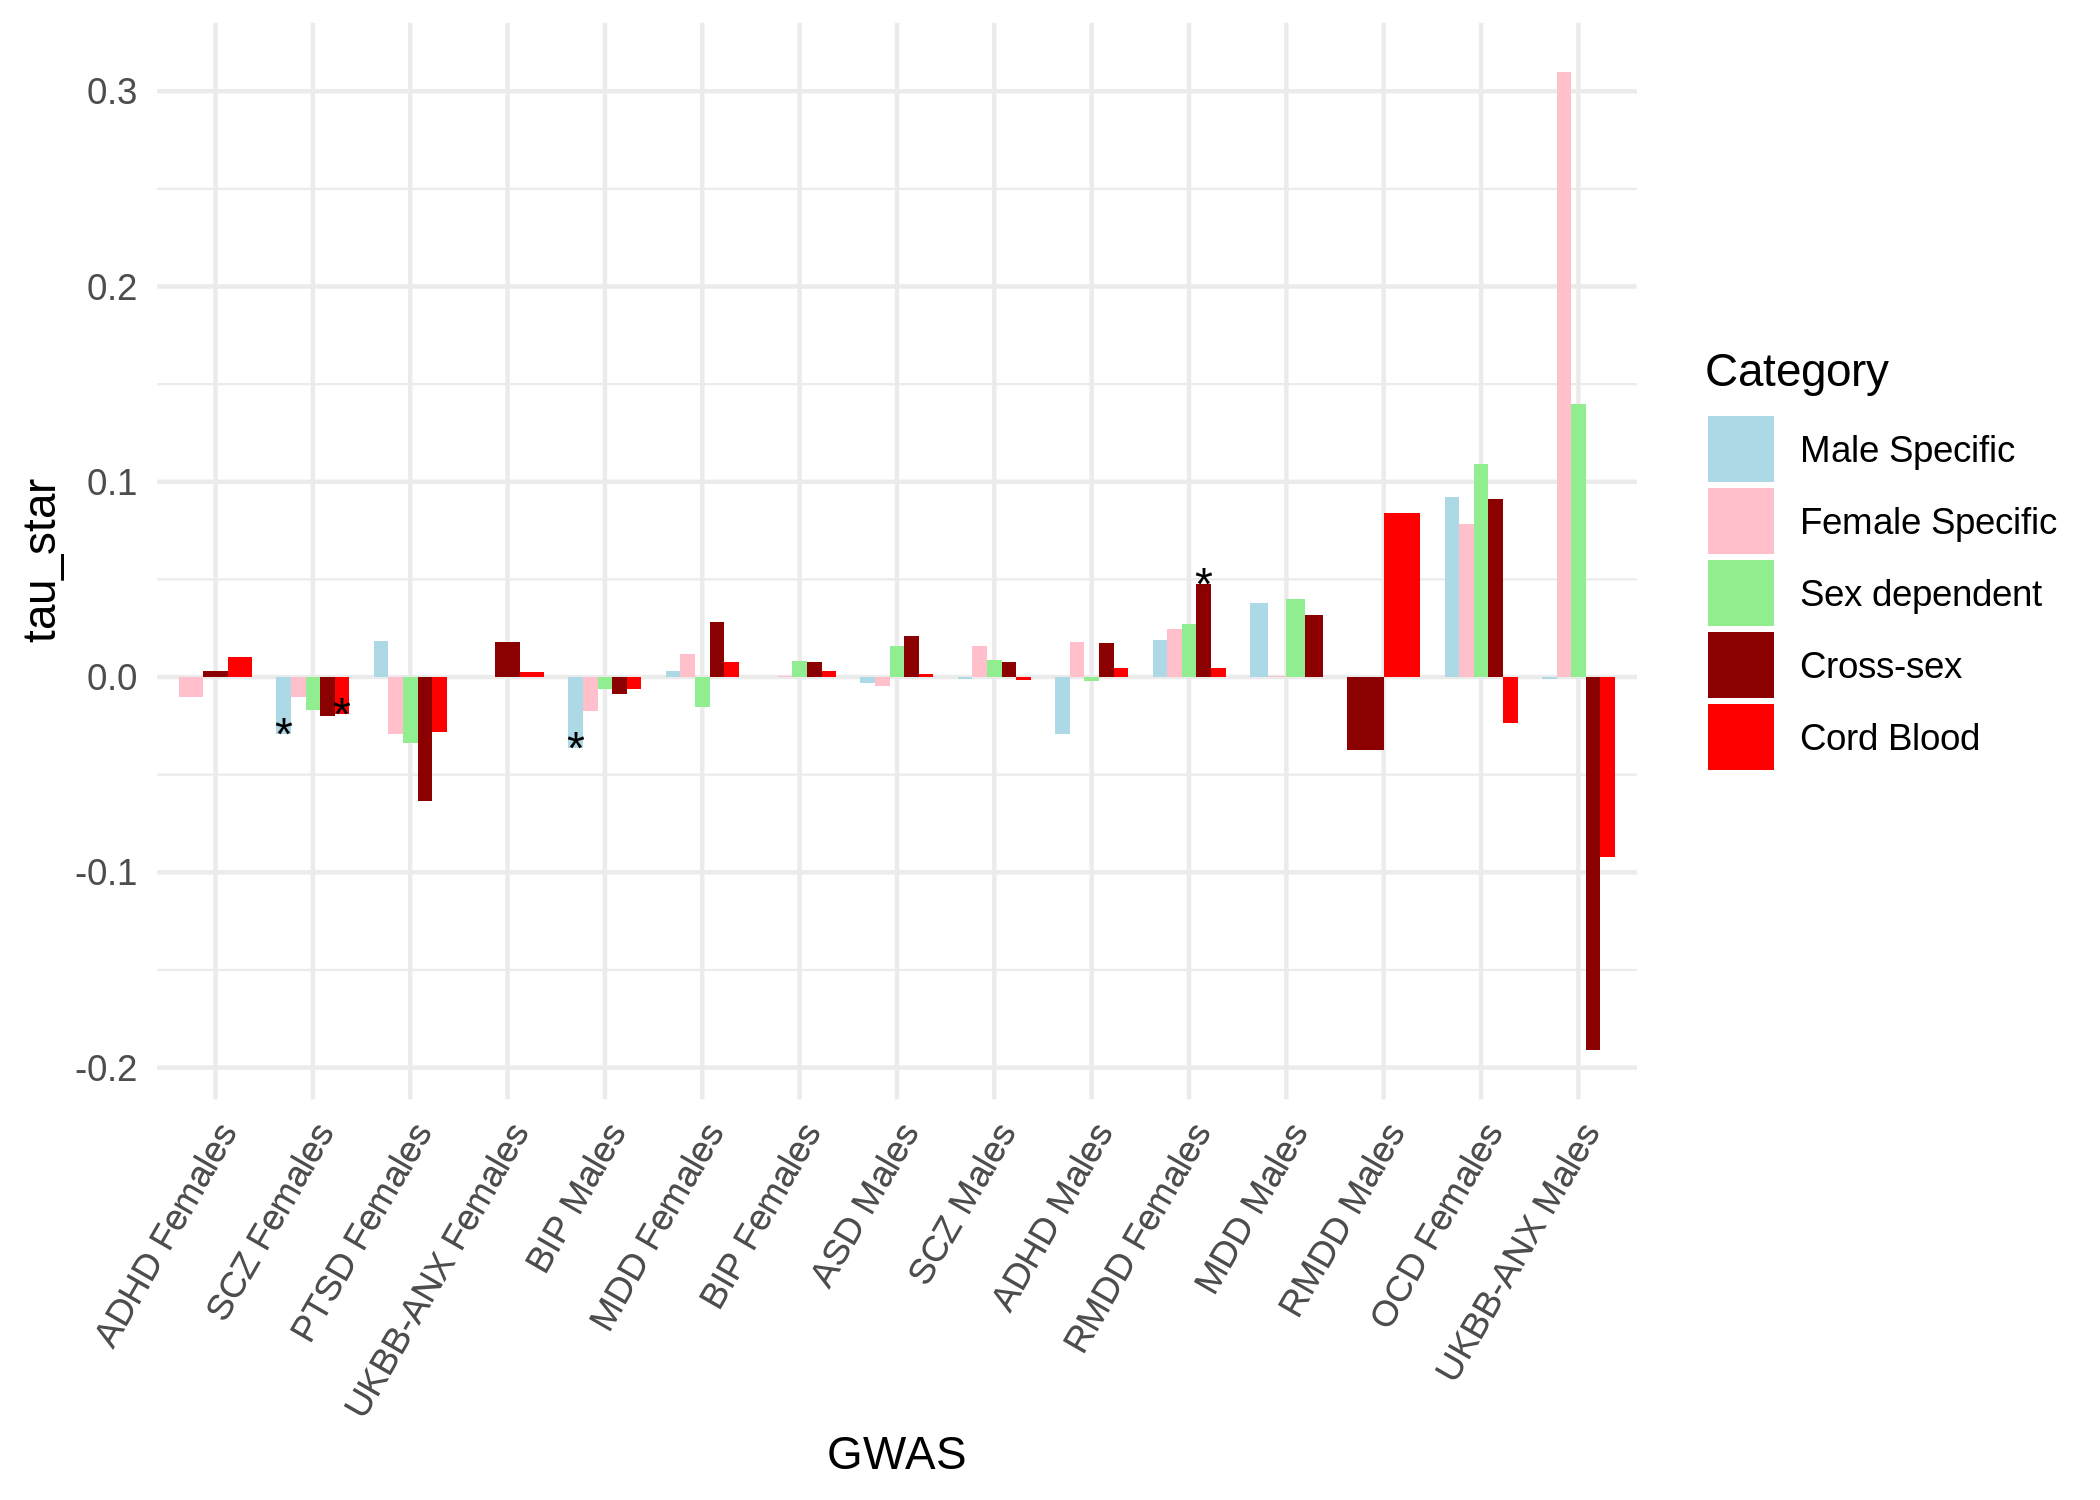

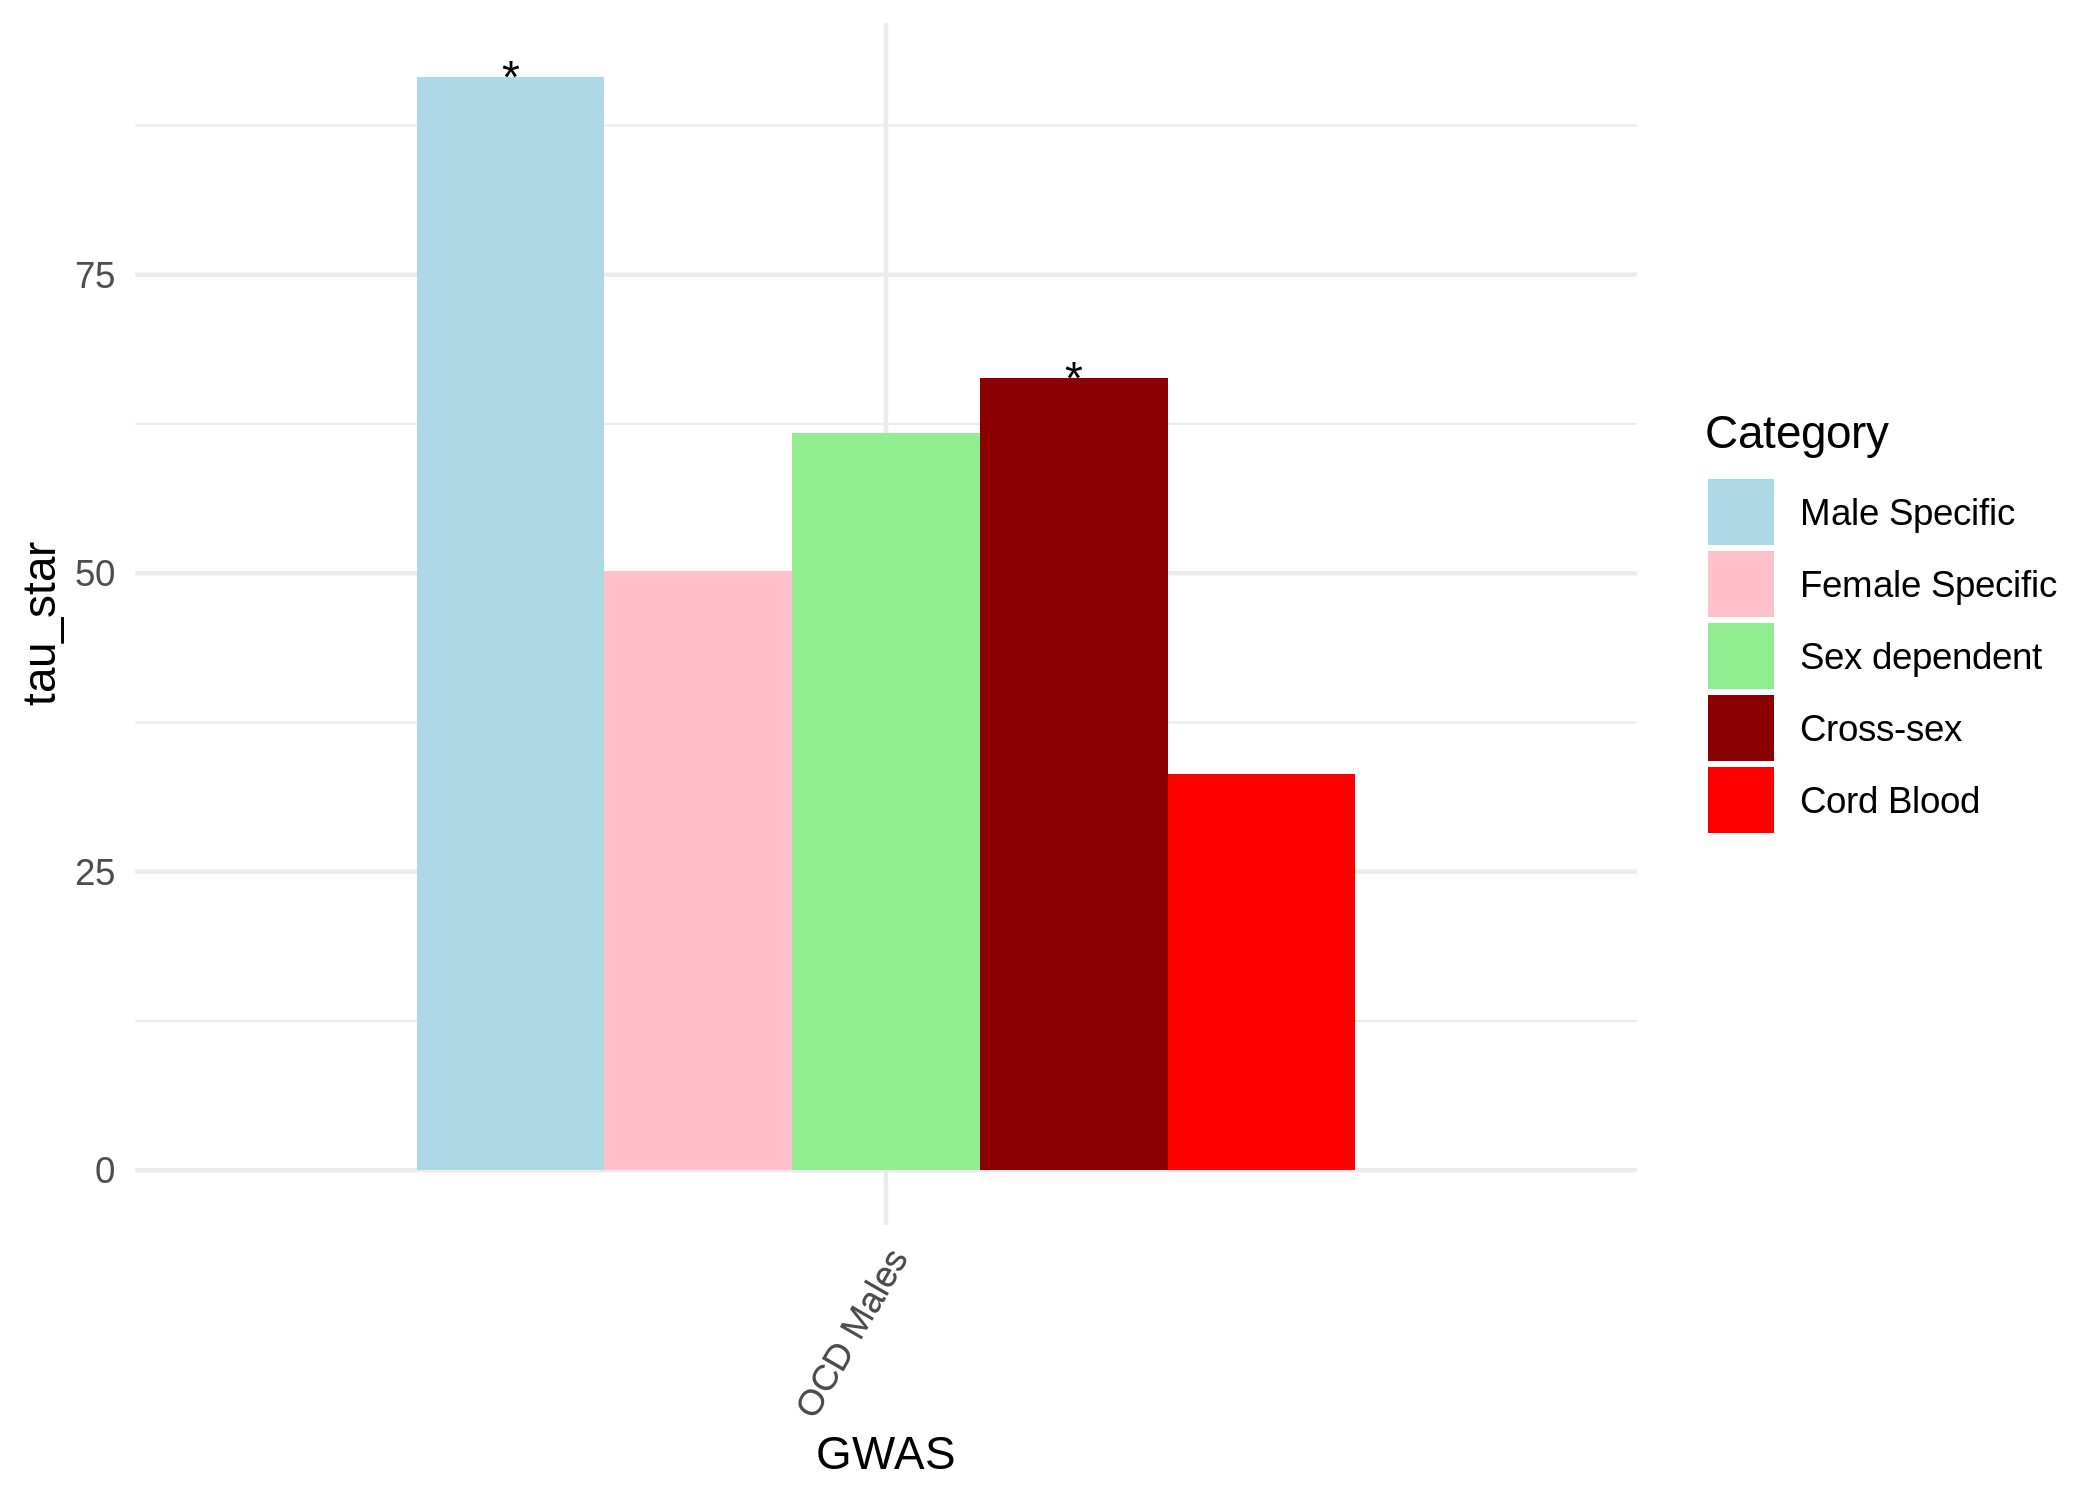

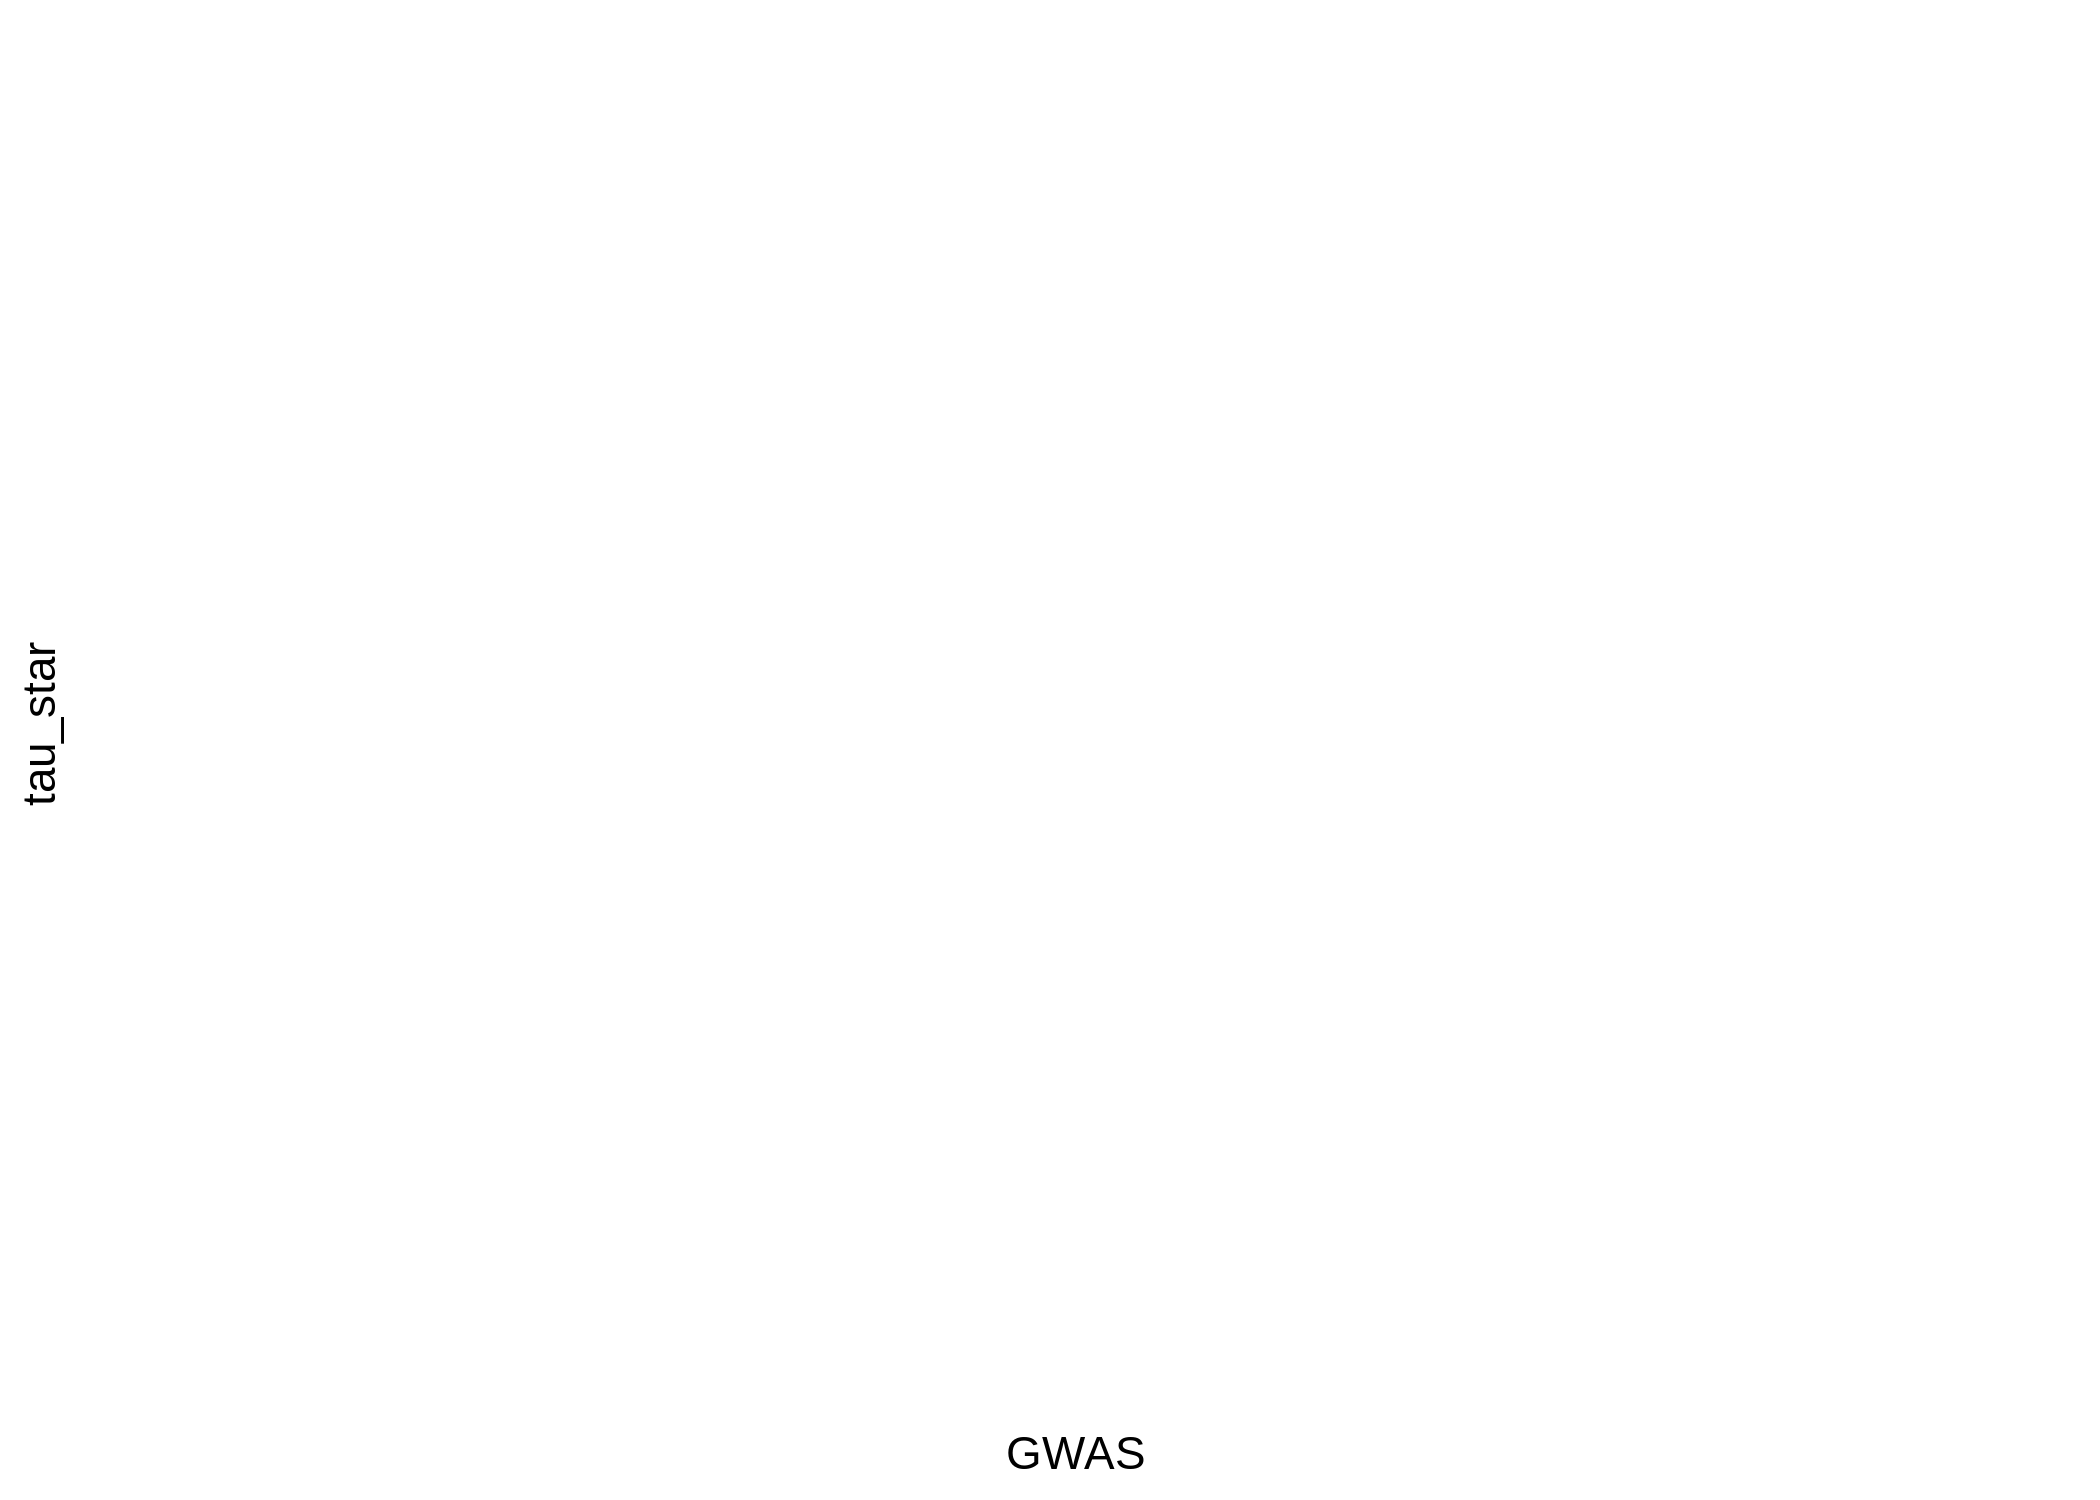

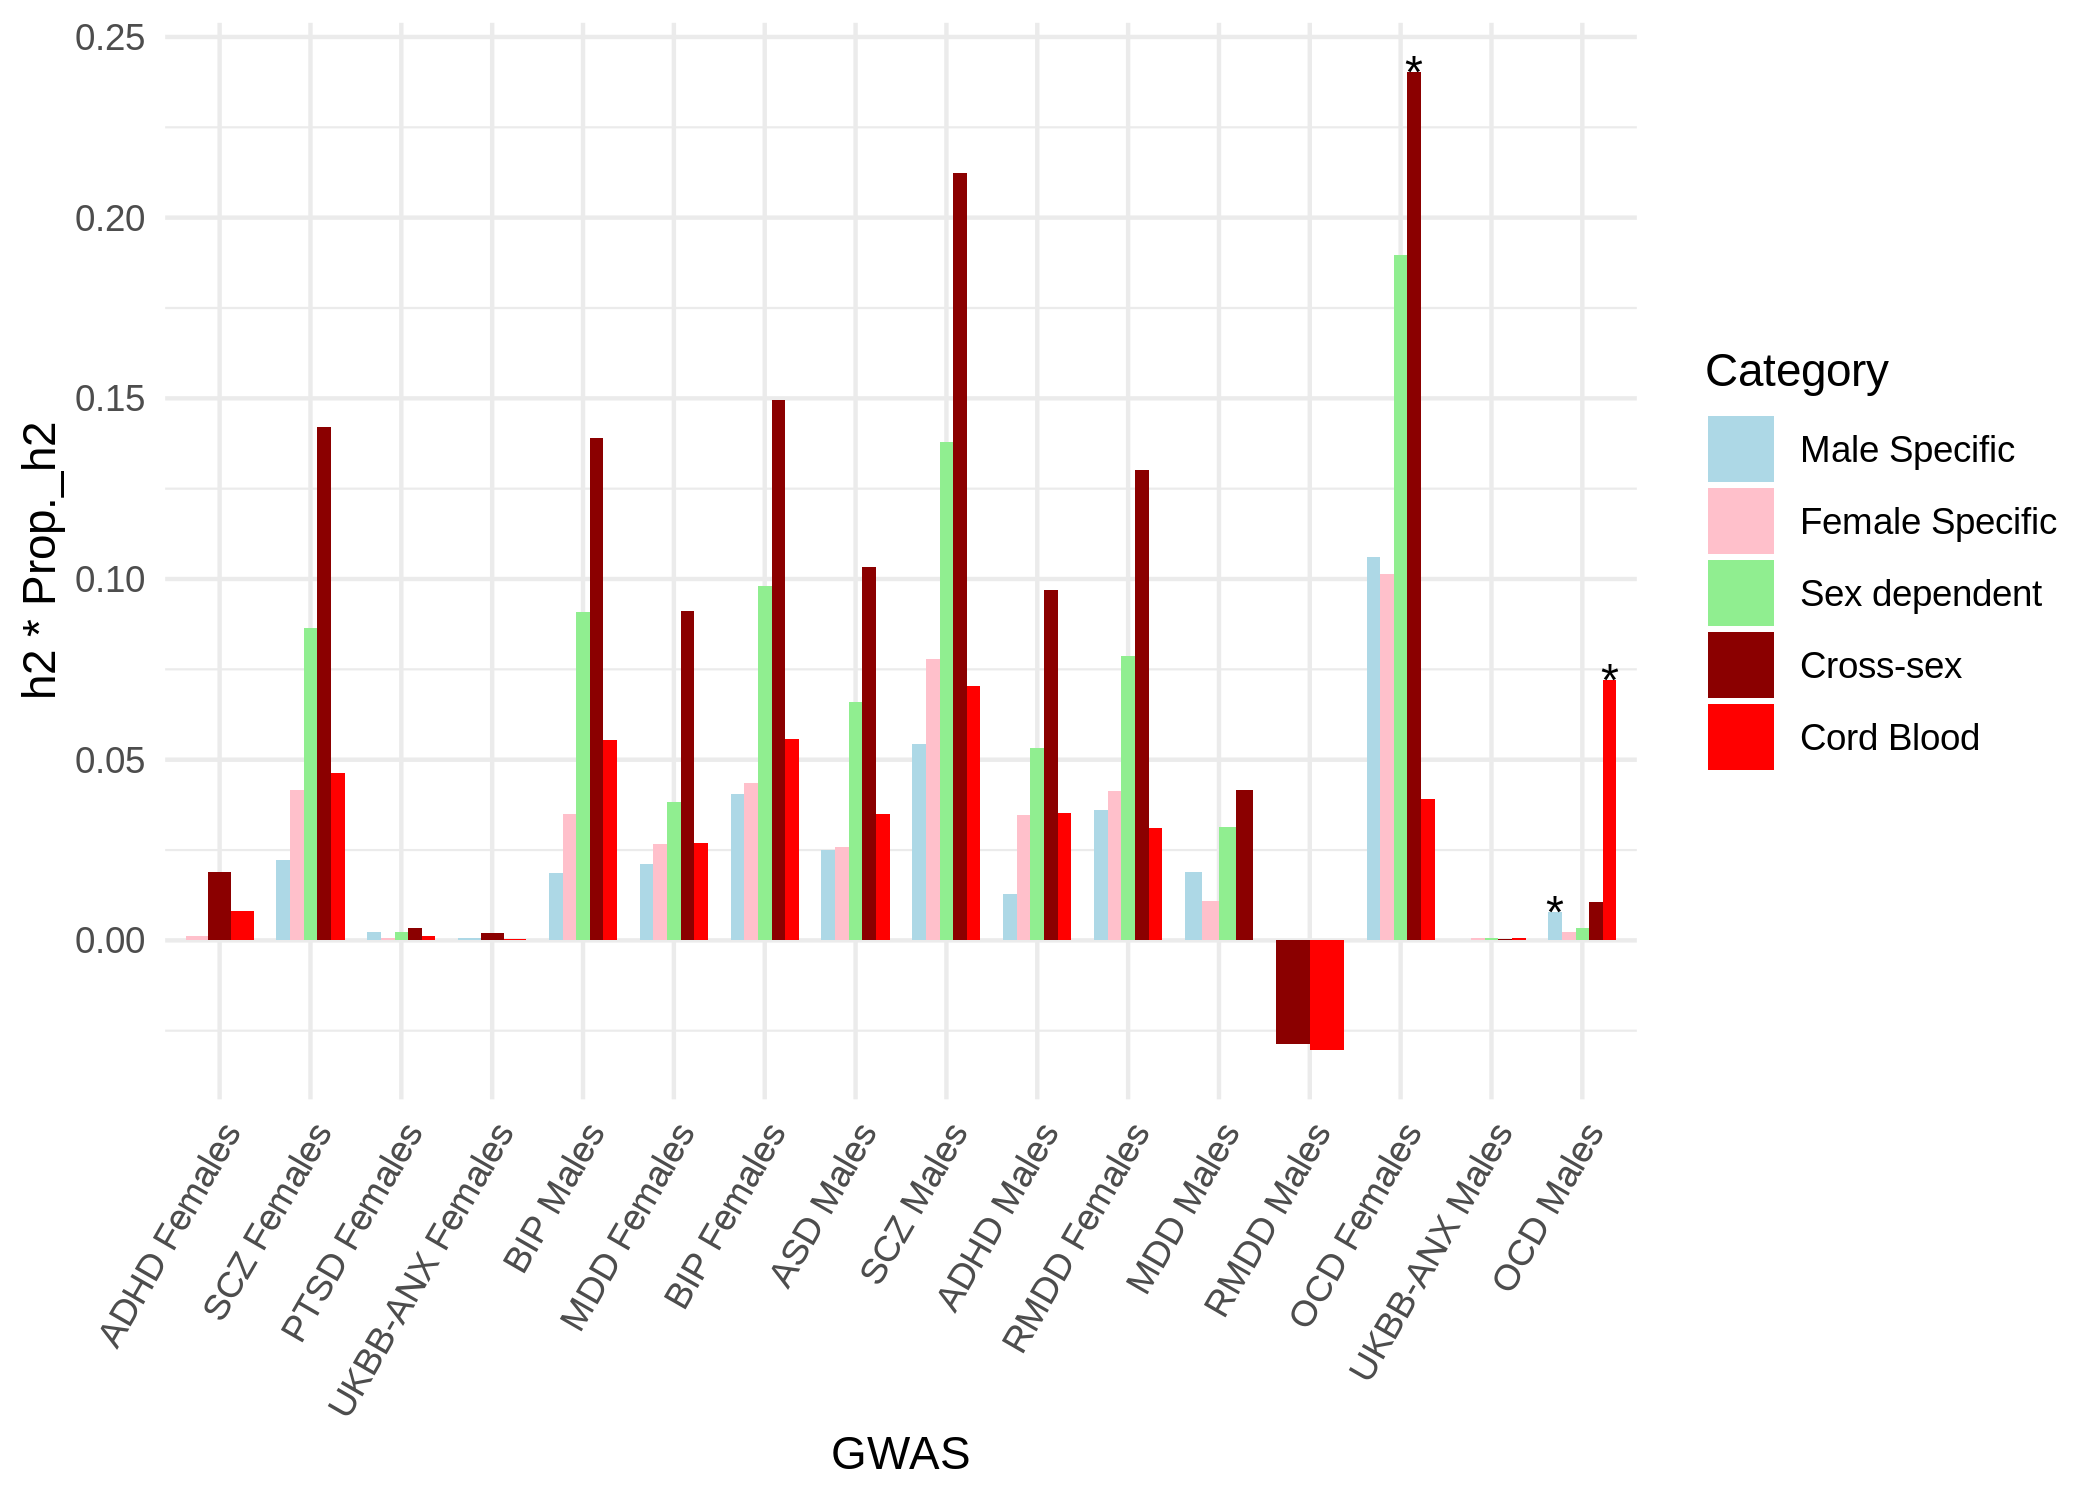

In [18]:
options(width= 10, repr.plot.height= 5, repr.plot.res = 300)
exclude_list <- c("PTSD Males","ASD Females","ANXFS","Alcohol (AUDIT)","Cannabis","Cigarettes Per Day") 
annot_order <- c("Male Specific","Female Specific","Sex dependent","Cross-sex", "Cord Blood")

order_dt <- pgc_part_heritability_independent_df[
        !GWAS %in% exclude_list &
        !grepl("Male|Female",GWAS) &
        Category %in% annot_order&
        annotation == "bin_CPP_her" &
        Enrichment > 0,
        .(max_enrich = max(Enrichment)),
        by = "GWAS"
    ]
GWAS_order <- order_dt[order(max_enrich)]$GWAS
order_sex_dt <-     pgc_part_heritability_independent_df[
        !GWAS %in% exclude_list &
        grepl("Male|Female",GWAS) &
        Category %in% annot_order&
        annotation == "bin_CPP_her" &
        Enrichment  > 0,
        .(max_enrich = max(Enrichment)),
        by = "GWAS"
    ]
GWAS_sex_order <- order_sex_dt[order(max_enrich)]$GWAS

ggplot(
    pgc_part_heritability_independent_df[
        !GWAS %in% exclude_list &
        !grepl("Male|Female",GWAS) &
        Category %in% annot_order &
        annotation == "bin_CPP_her" &
        Enrichment > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=Enrichment,label = ifelse(Enrichment_p < 0.05,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    scale_fill_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))
ggplot(
    pgc_part_heritability_independent_df[
        !GWAS %in% exclude_list &
        !grepl("Male|Female",GWAS) &
        Category %in% annot_order &
        annotation == "bin_CPP_her" &
        Enrichment - Enrichment_std_error > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=h2*Prop._h2,label = ifelse(significant_enrich,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    scale_fill_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))
to_plot <- pgc_part_heritability_independent_df[
        !GWAS %in% exclude_list &
        !grepl("Male|Female",GWAS) &
        Category %in% annot_order & 
        annotation == "bin_CPP_her" &
        Enrichment> 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_order),Category = factor(Category,levels = annot_order))
ggplot(to_plot,
    aes(color = Category, x=Enrichment,y=-log10(Enrichment_p)))+
    geom_point() + 
    geom_text_repel(label=ifelse(to_plot$significant_enrich,as.character(to_plot$GWAS),""))+
    scale_color_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    theme_minimal()+
    #labs(x="Heritability Explained")+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))
ggplot(
    pgc_part_heritability_independent_df[
        !GWAS %in% exclude_list &
        !grepl("Male|Female",GWAS) &
        Category %in% annot_order &
        annotation == "bin_CPP_her" &
        Enrichment > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=tau_star,label = ifelse(pnorm(abs(tau_star/tau_se),lower.tail=F)*2 < 0.05,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    labs(y=bquote(tau^"*"))+
    scale_fill_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))


ggplot(
    pgc_part_heritability_independent_df[
        !GWAS %in% c(exclude_list,"OCD Males") &
        grepl("Male|Female",GWAS) &
        Category %in% annot_order &
        annotation == "bin_CPP_her" &
        Enrichment  > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_sex_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=Enrichment,label = ifelse(significant_enrich,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    scale_fill_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))
ggplot(
    pgc_part_heritability_independent_df[
        GWAS == "OCD Males"&
        grepl("Male|Female",GWAS) &
        Category %in% annot_order &
        annotation == "bin_CPP_her" &
        Enrichment  > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_sex_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=Enrichment,label = ifelse(significant_enrich,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    scale_fill_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))

ggplot(
    pgc_part_heritability_independent_df[
        !GWAS %in% c(exclude_list,"OCD Males") &
        grepl("Male|Female",GWAS) &
        Category %in% annot_order &
        annotation == "bin_CPP_her" &
        Enrichment  > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_sex_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=tau_star,label = ifelse(pnorm(abs(tau_star/tau_se),lower.tail=F)*2 < 0.05,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    scale_fill_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))
ggplot(
    pgc_part_heritability_independent_df[
        GWAS == "OCD Males"&
        grepl("Male|Female",GWAS) &
        Category %in% annot_order &
        annotation == "bin_CPP_her" &
        Enrichment  > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_sex_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=tau_star,label = ifelse(pnorm(abs(tau_star/tau_se),lower.tail=F)*2 < 0.05,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    scale_fill_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))
ggplot(
    pgc_part_heritability_independent_df[
        !GWAS %in% exclude_list &
        grepl("Male|Female",GWAS) &
        Category %in% annot_order &
        annotation == "bin_CPP_her" &
        Enrichment > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_sex_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=h2 * Prop._h2,label = ifelse(significant_enrich,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    scale_fill_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))

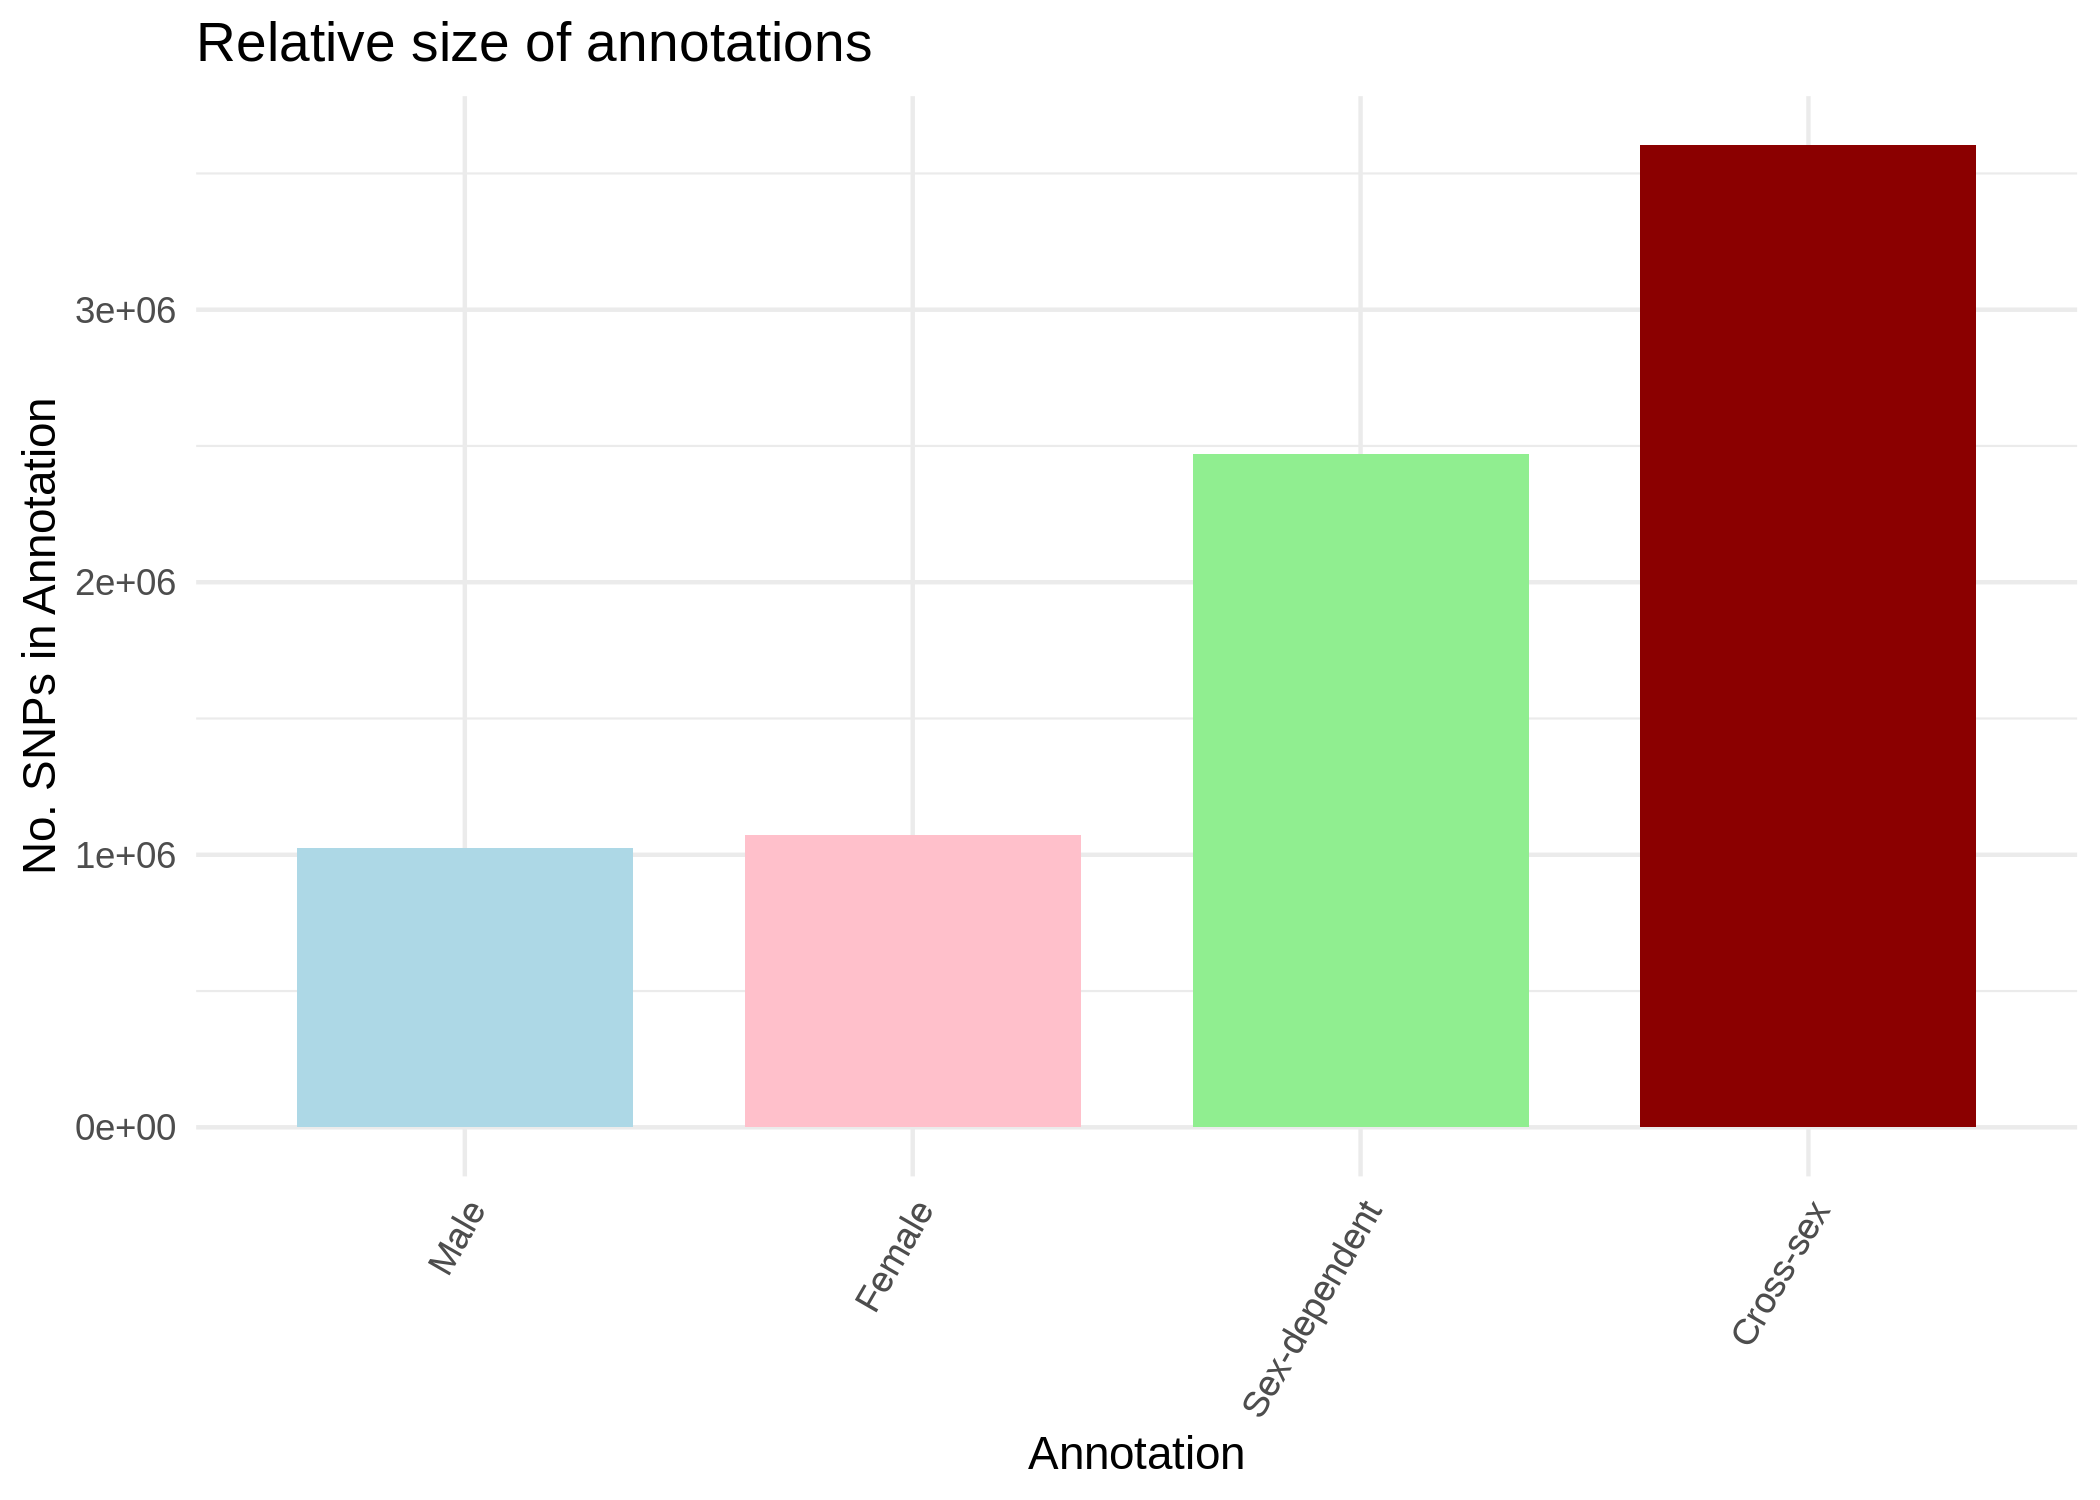

In [23]:
annotation_size <- data.table( Annotation_size=c(3603419, 2470402,1025888,1071077),
           Annotation = c("Cross-sex","Sex-dependent","Male","Female"))
ggplot(annotation_size %>% mutate(Annotation=factor(Annotation,levels=c("Male","Female","Sex-dependent","Cross-sex"))), aes(Annotation,Annotation_size,fill=Annotation)) + 
    geom_col(position="dodge",width=0.75) + 
    scale_fill_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    theme_minimal()+
    labs(y = "No. SNPs in Annotation",title = "Relative size of annotations") +
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1),legend.position = "" )

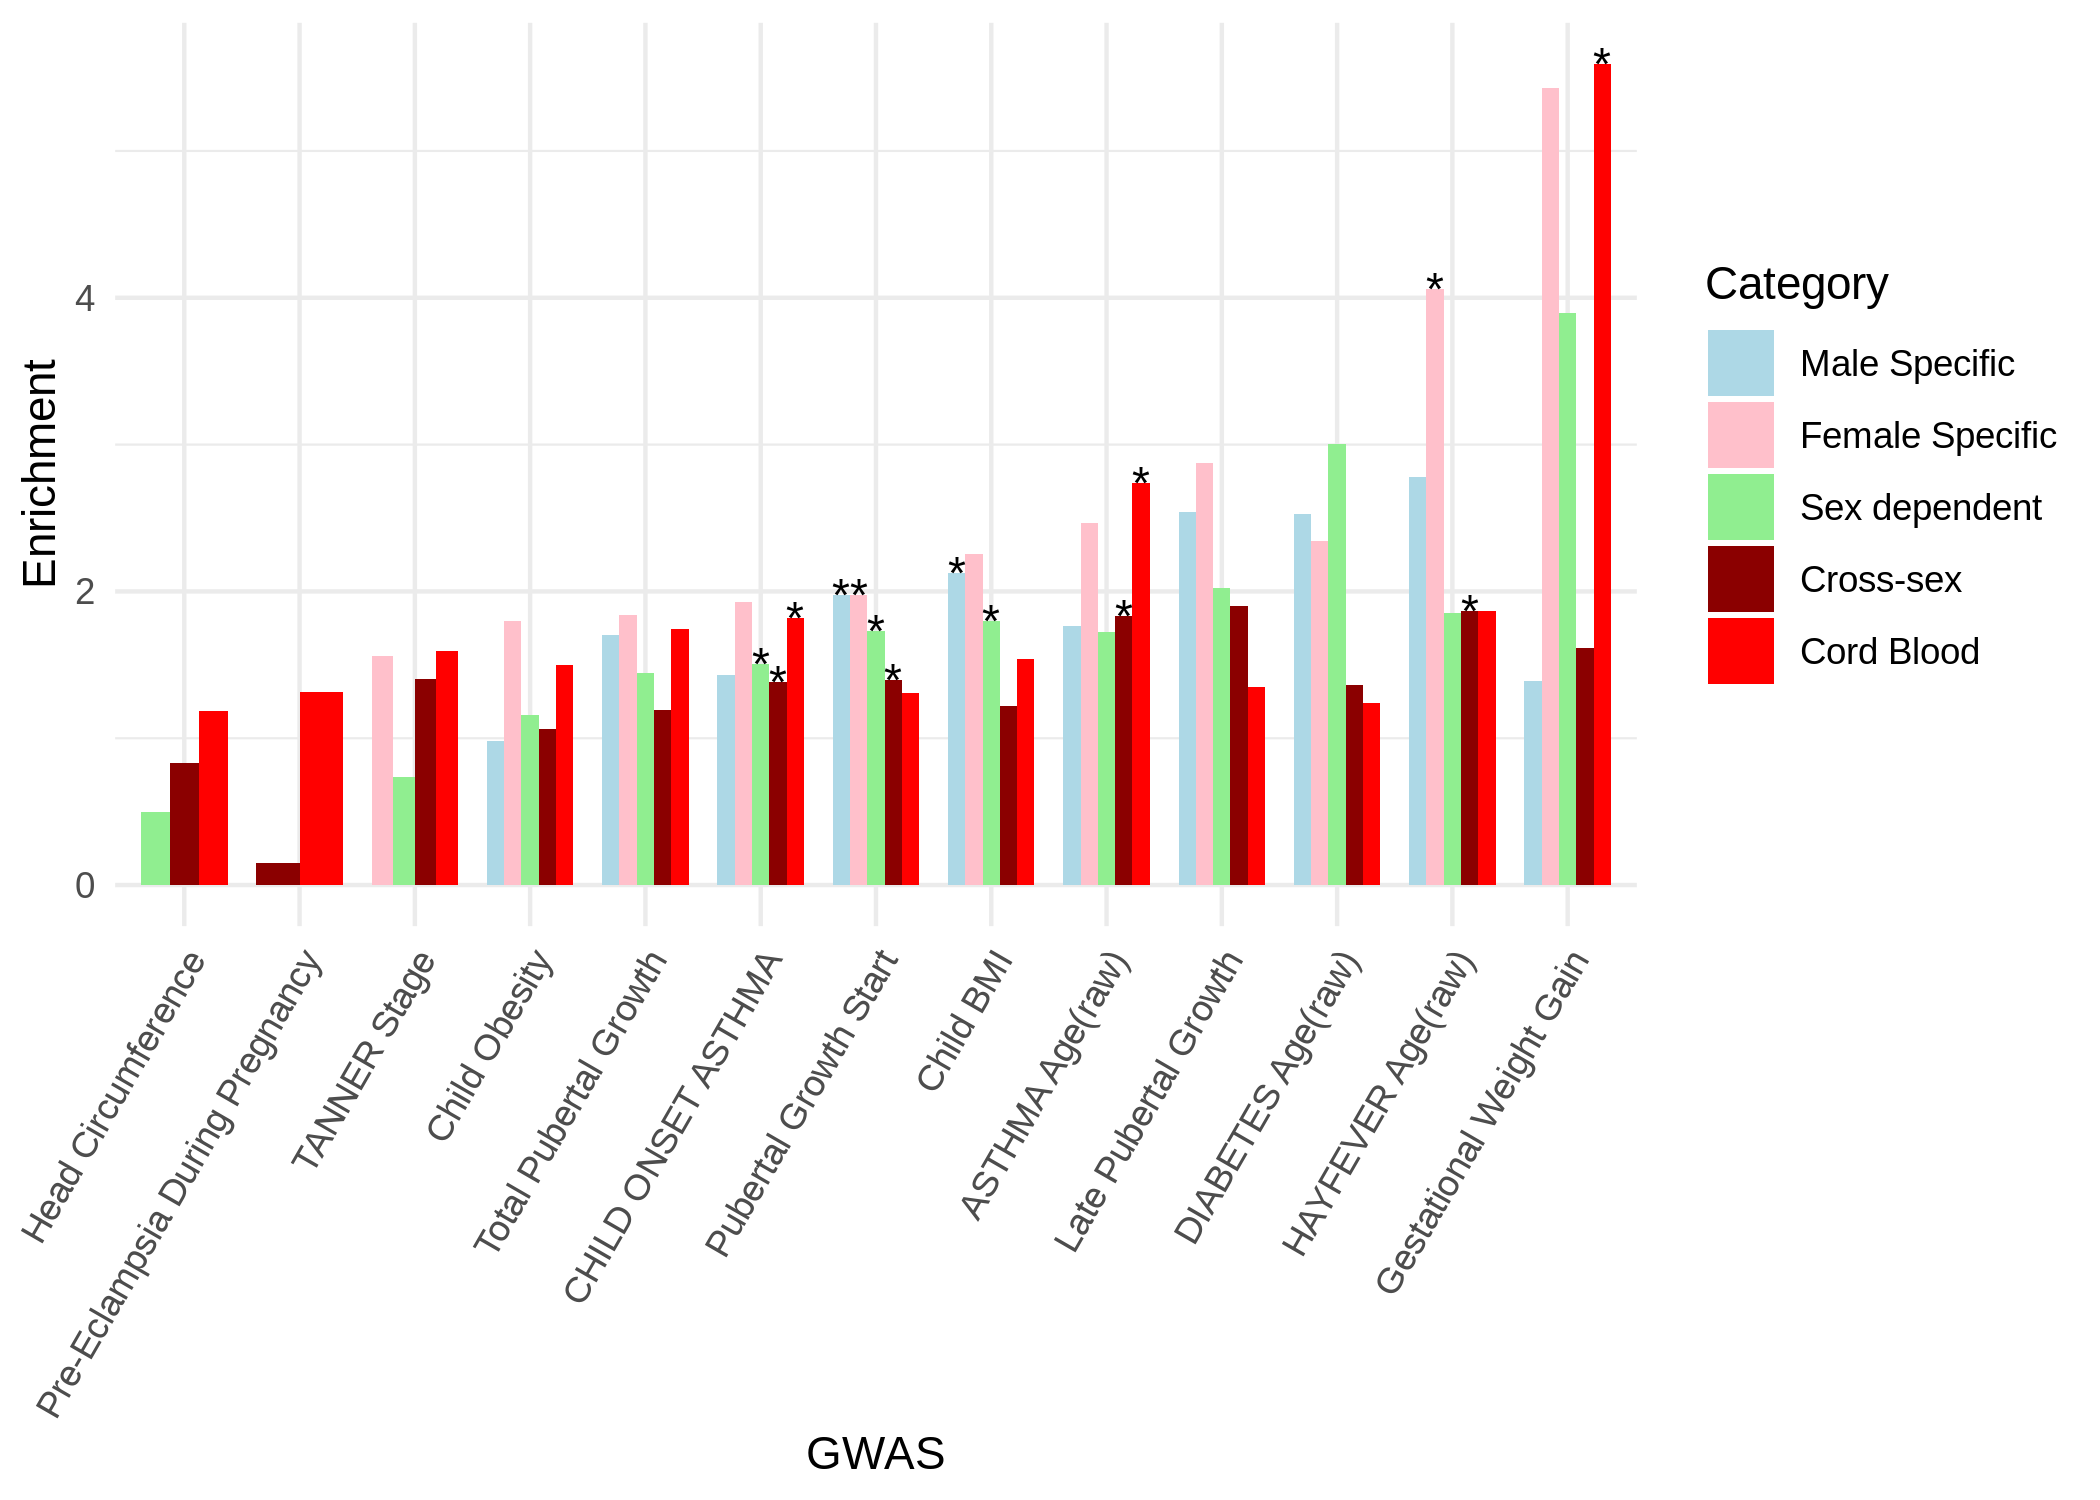

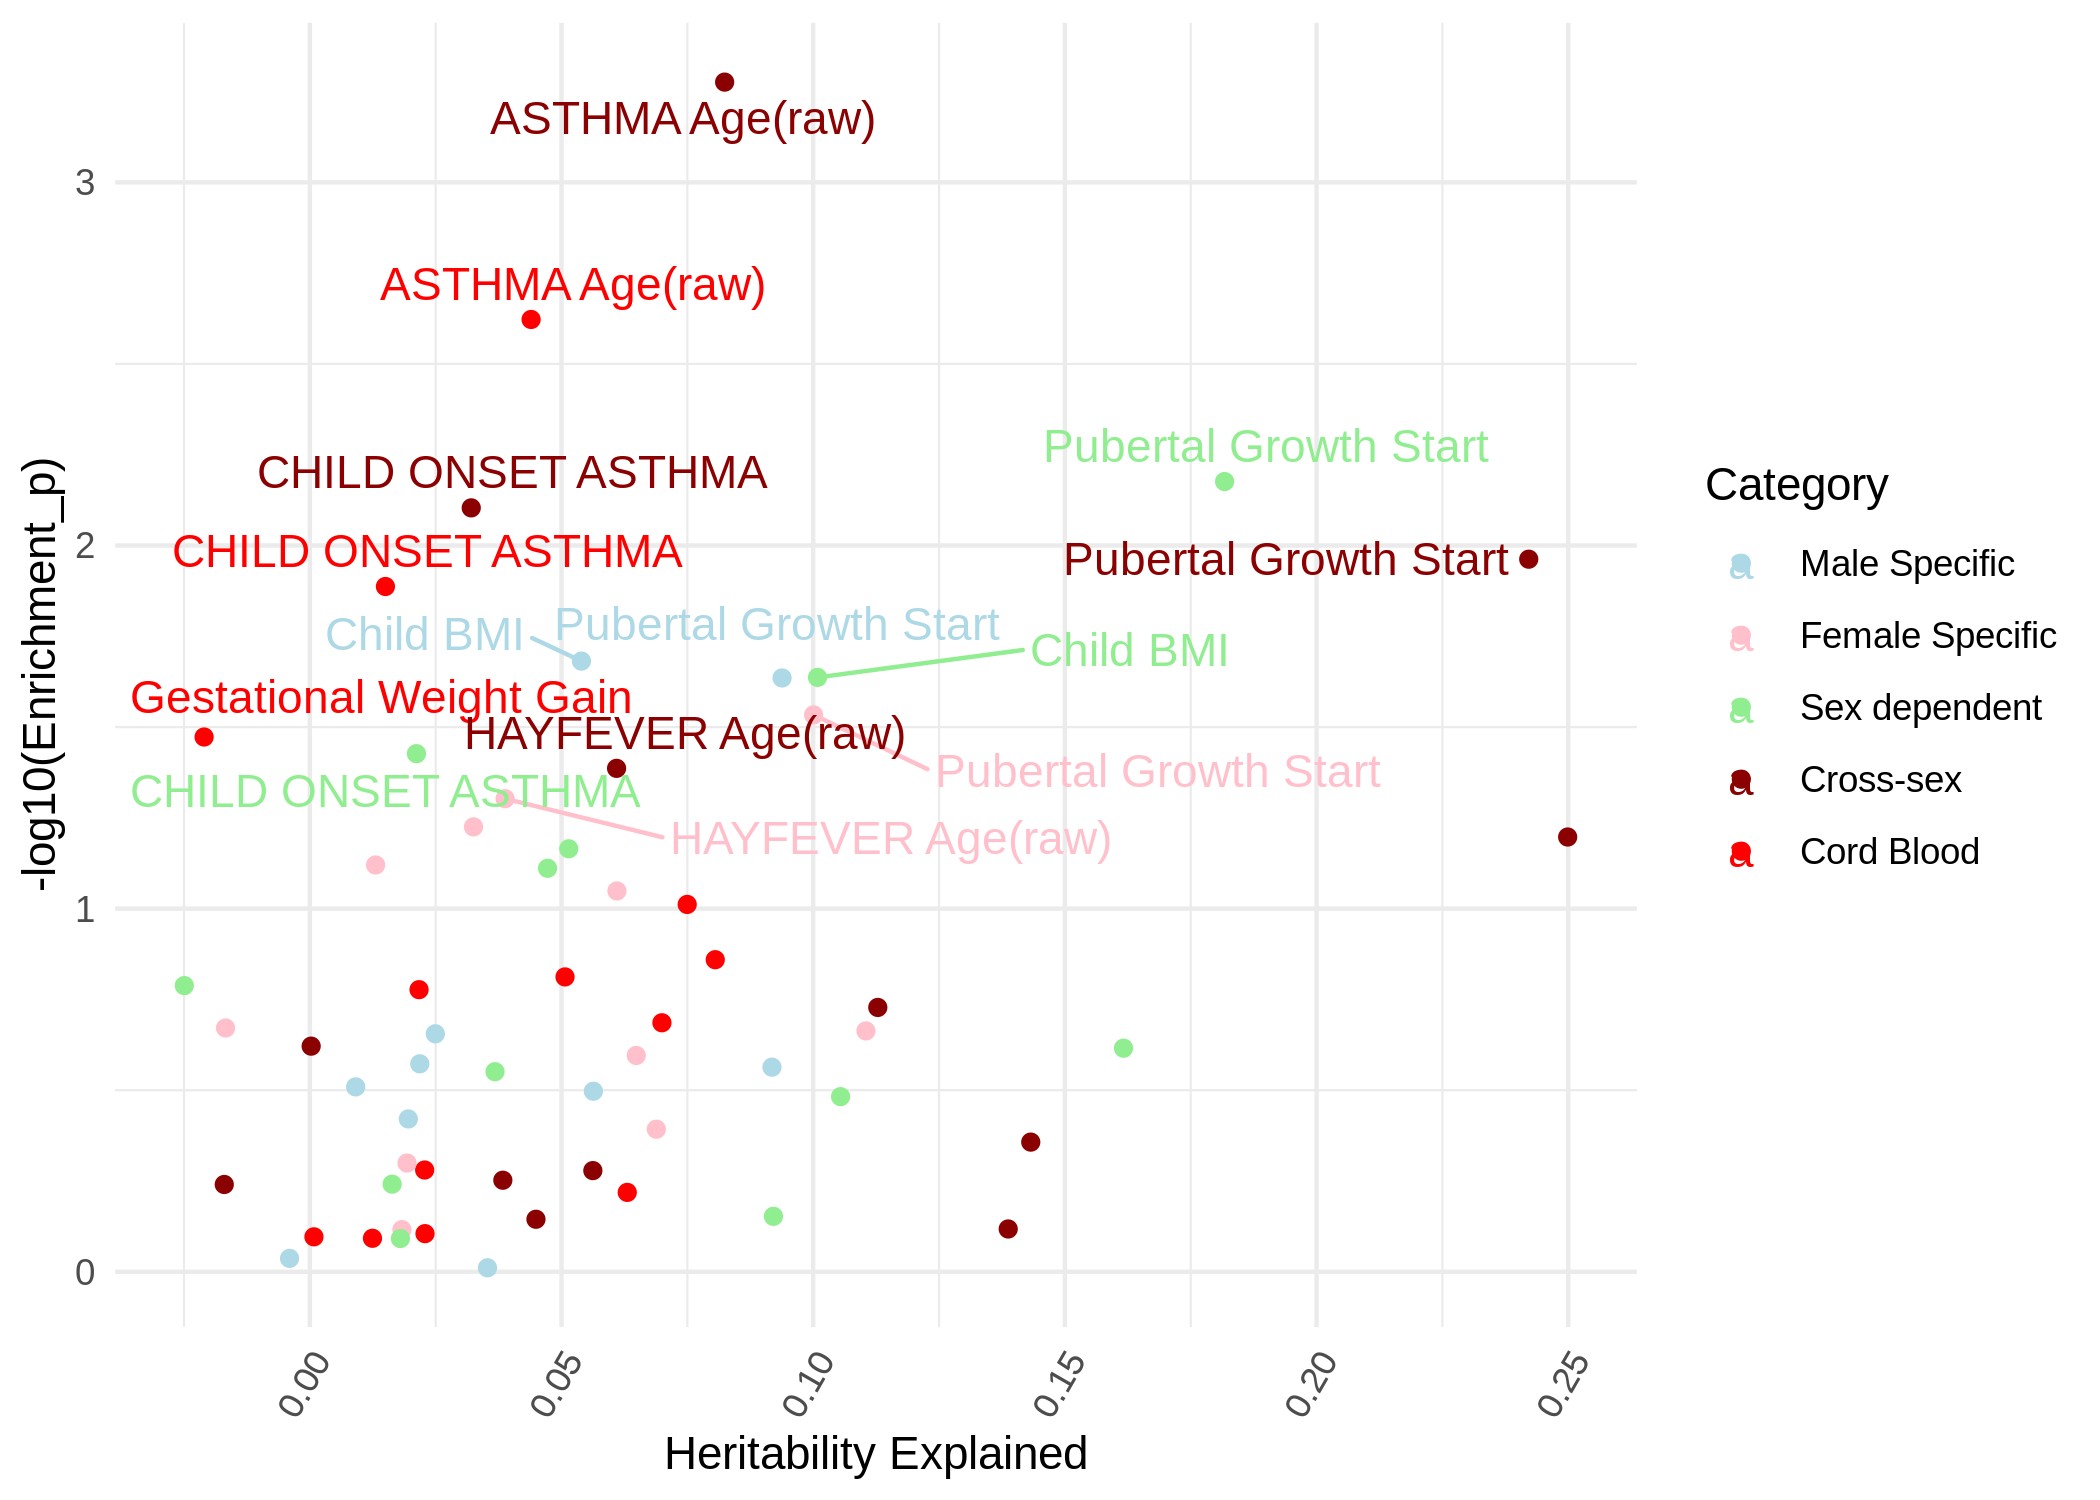

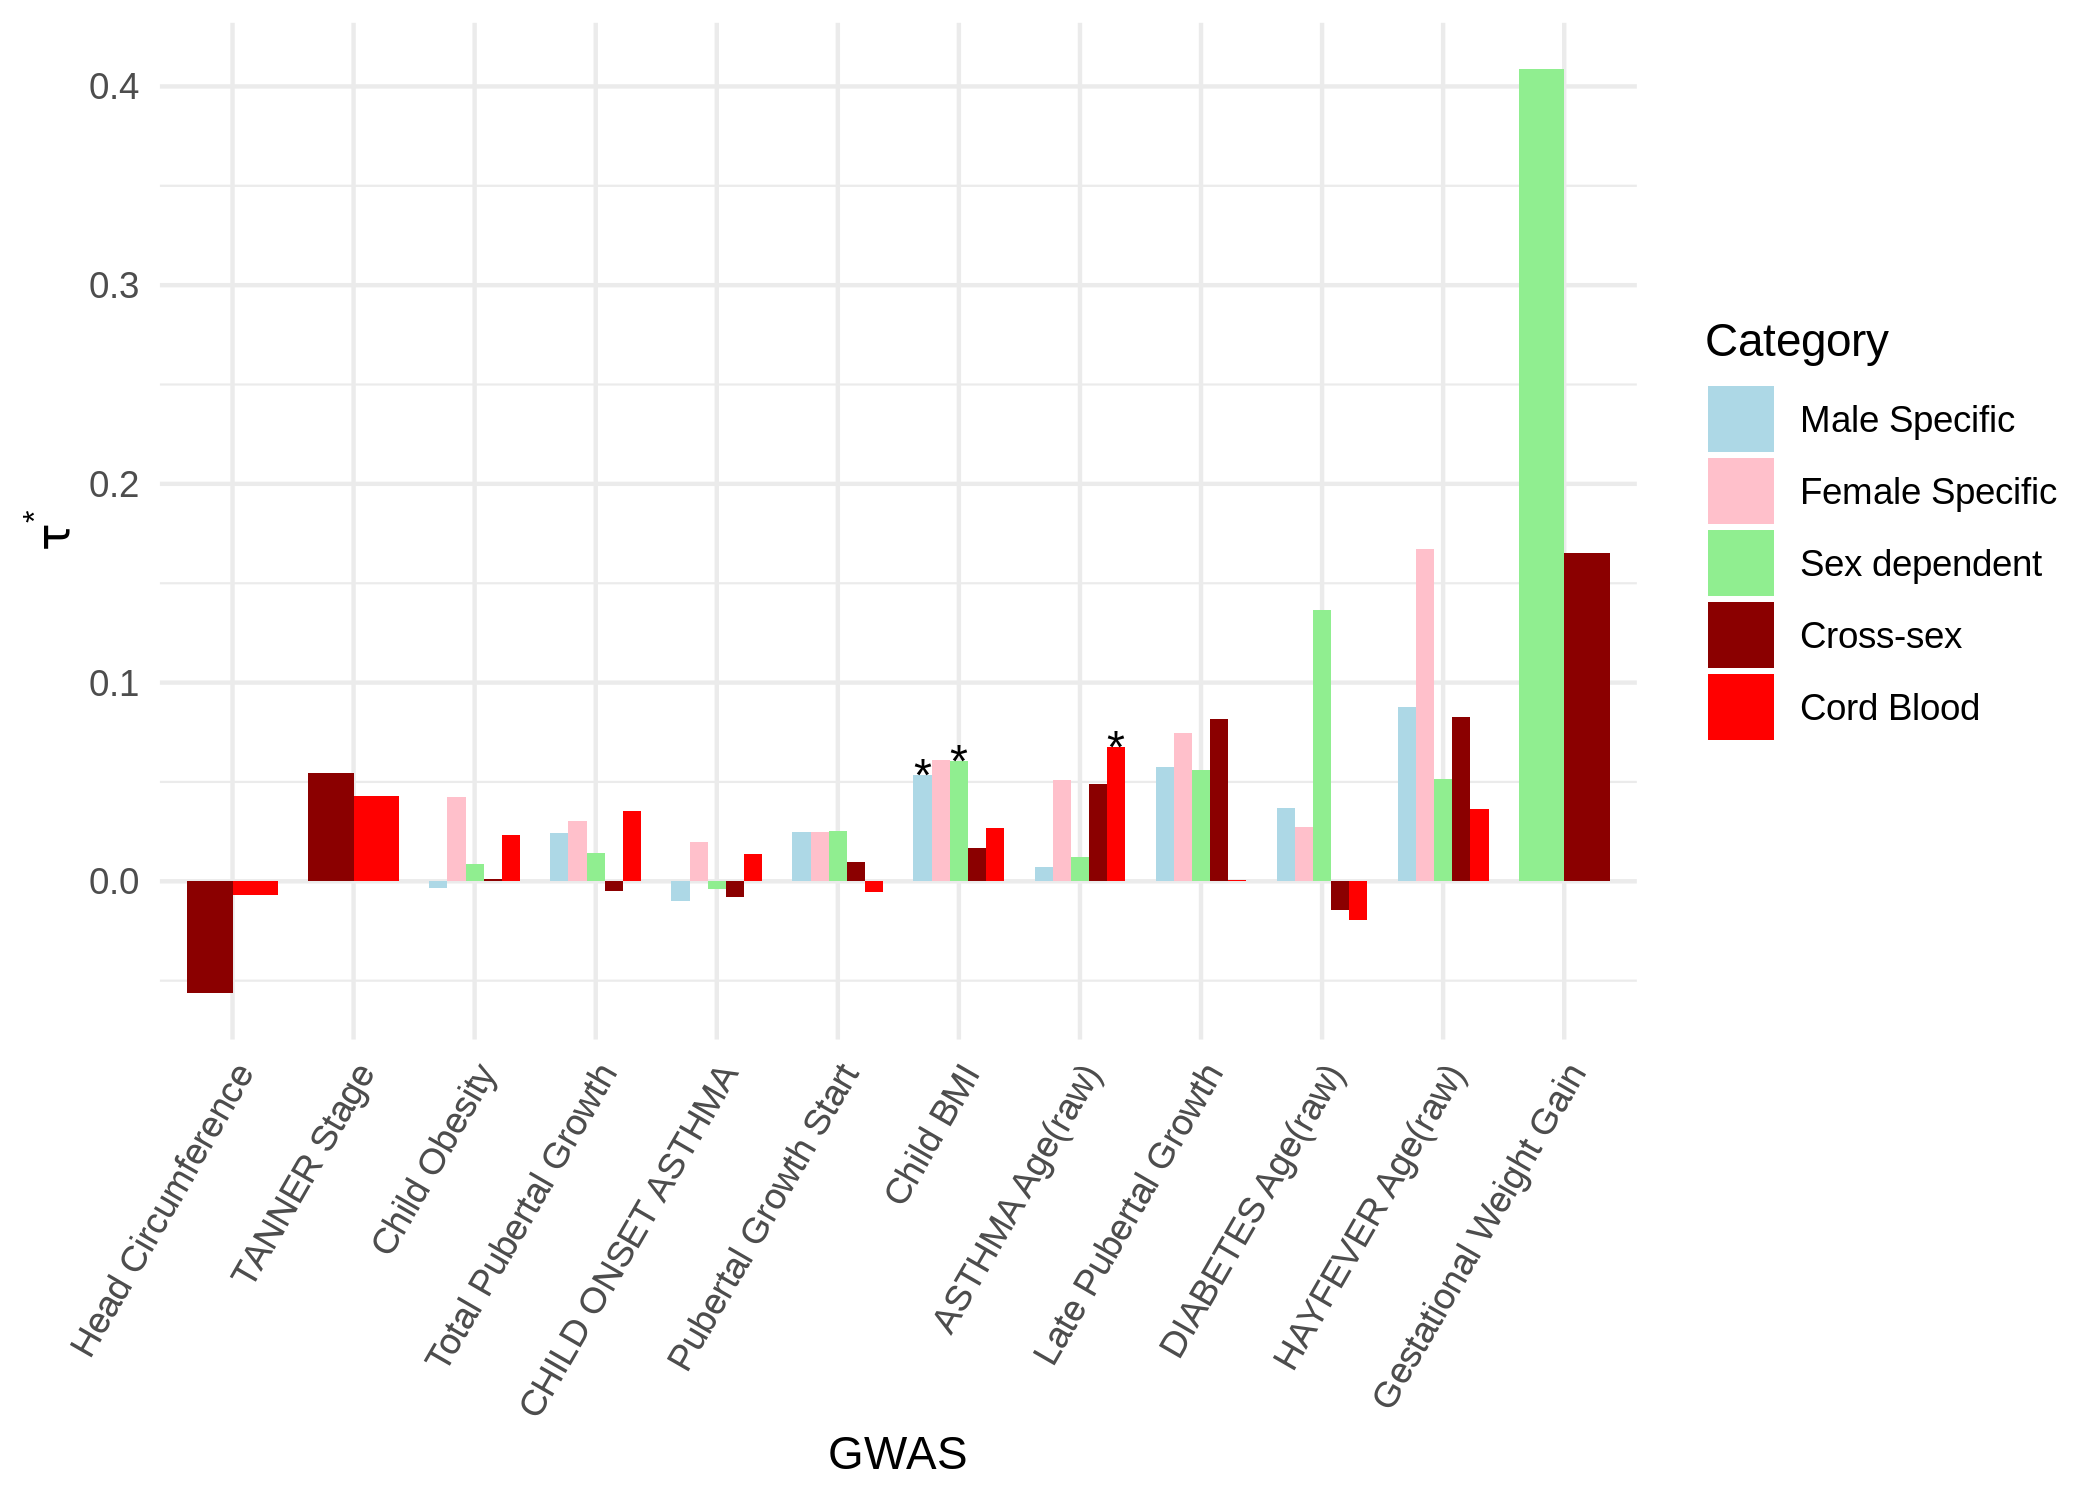

In [63]:
options(width= 10, repr.plot.height= 5, repr.plot.res = 300)
library(ggrepel)
exclude_list <- unique(neonatal_part_heritability_independent_df$GWAS[grepl("norm",neonatal_part_heritability_df$GWAS)])
annot_categories <- c("Male Specific","Female Specific","Sex dependent","Cross-sex", "Cord Blood")
order_dt <-     neonatal_part_heritability_independent_df[
        !GWAS %in% exclude_list &
        !grepl("Male|Female",GWAS) &
        Category %in% annot_categories & 
        annotation == "bin_CPP_her" &
        Enrichment  > 0,
        .(max_enrich = max(Enrichment)),
        by = "GWAS"
    ]
GWAS_order <- order_dt[order(max_enrich)]$GWAS
annot_order <- annot_categories


ggplot(
    neonatal_part_heritability_independent_df[
        !GWAS %in% exclude_list &
        !grepl("Male|Female",GWAS) &
        Category %in% annot_categories & 
        annotation == "bin_CPP_her" &
        Enrichment> 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=Enrichment,label = ifelse(significant_enrich,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    scale_fill_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))
to_plot <- neonatal_part_heritability_independent_df[
        !GWAS %in% exclude_list &
        !grepl("Male|Female",GWAS) &
        Category %in% annot_categories & 
        annotation == "bin_CPP_her" &
        Enrichment> 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_order),Category = factor(Category,levels = annot_order))
ggplot(to_plot,
    aes(color = Category, x=h2*Prop._h2,y=-log10(Enrichment_p)))+
    geom_point() + 
    geom_text_repel(label=ifelse(to_plot$significant_enrich,as.character(to_plot$GWAS),""))+
    scale_color_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    theme_minimal()+
    labs(x="Heritability Explained")+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))
ggplot(
    neonatal_part_heritability_independent_df[
        !GWAS %in% exclude_list &
        !grepl("Male|Female",GWAS) &
        Category %in% annot_categories & 
        annotation == "bin_CPP_her" &
        Enrichment - Enrichment_std_error > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=tau_star,label = ifelse(pnorm(abs(tau_star/tau_se),lower.tail=F)*2 < 0.05,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    labs(y=bquote(tau^"*"))+
    scale_fill_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))

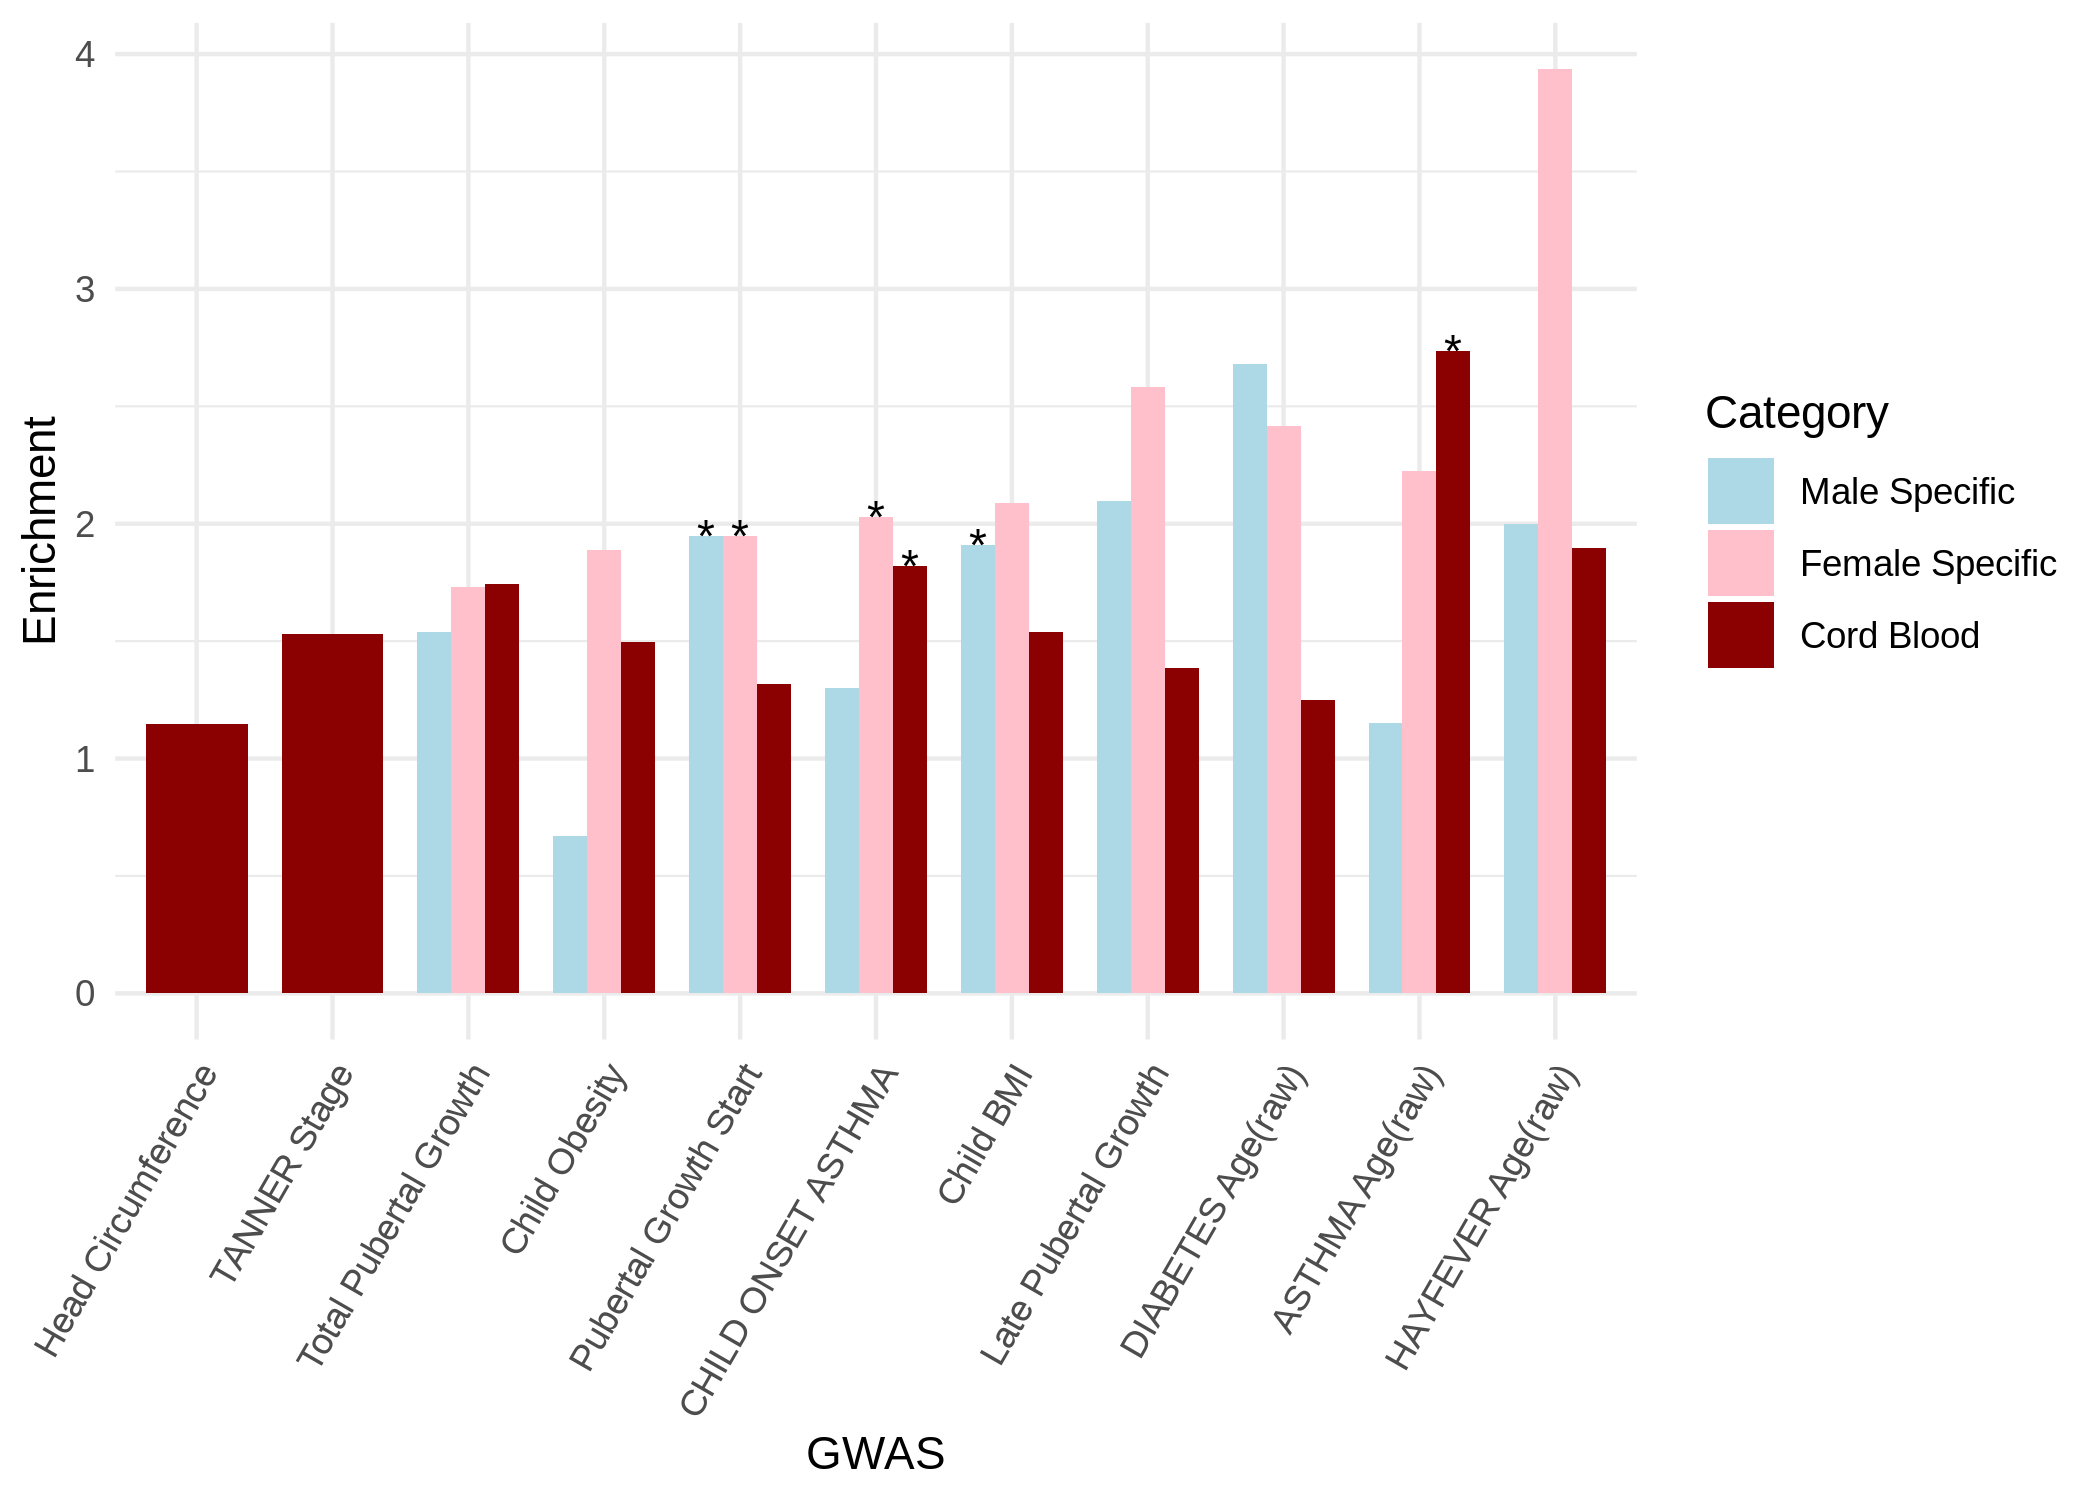

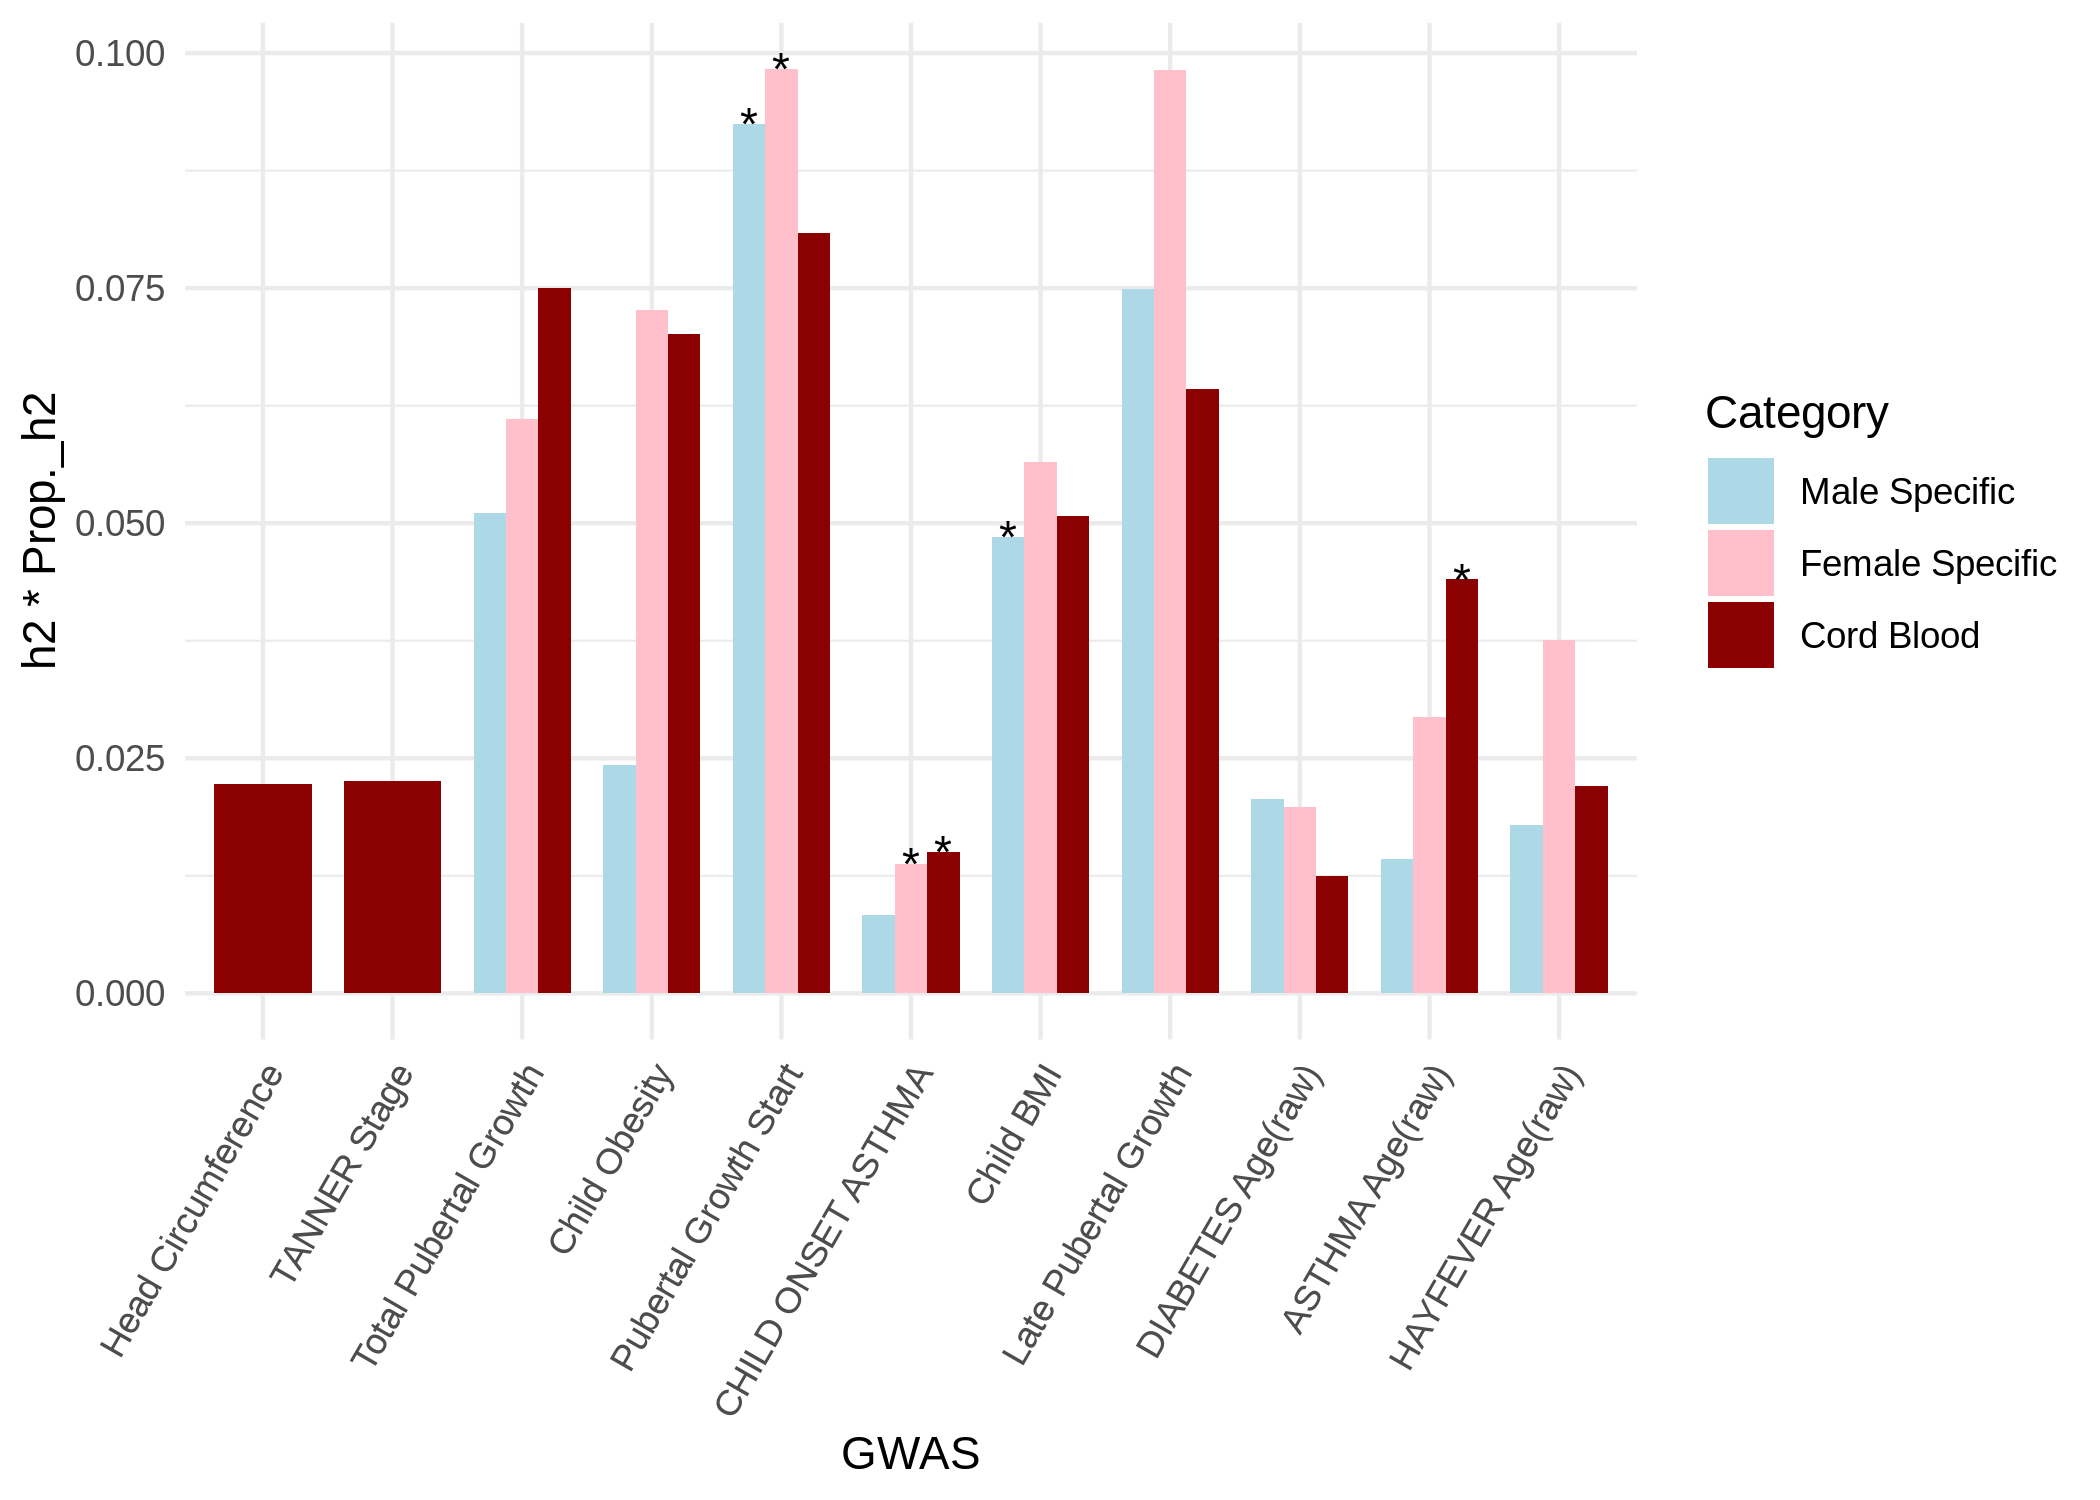

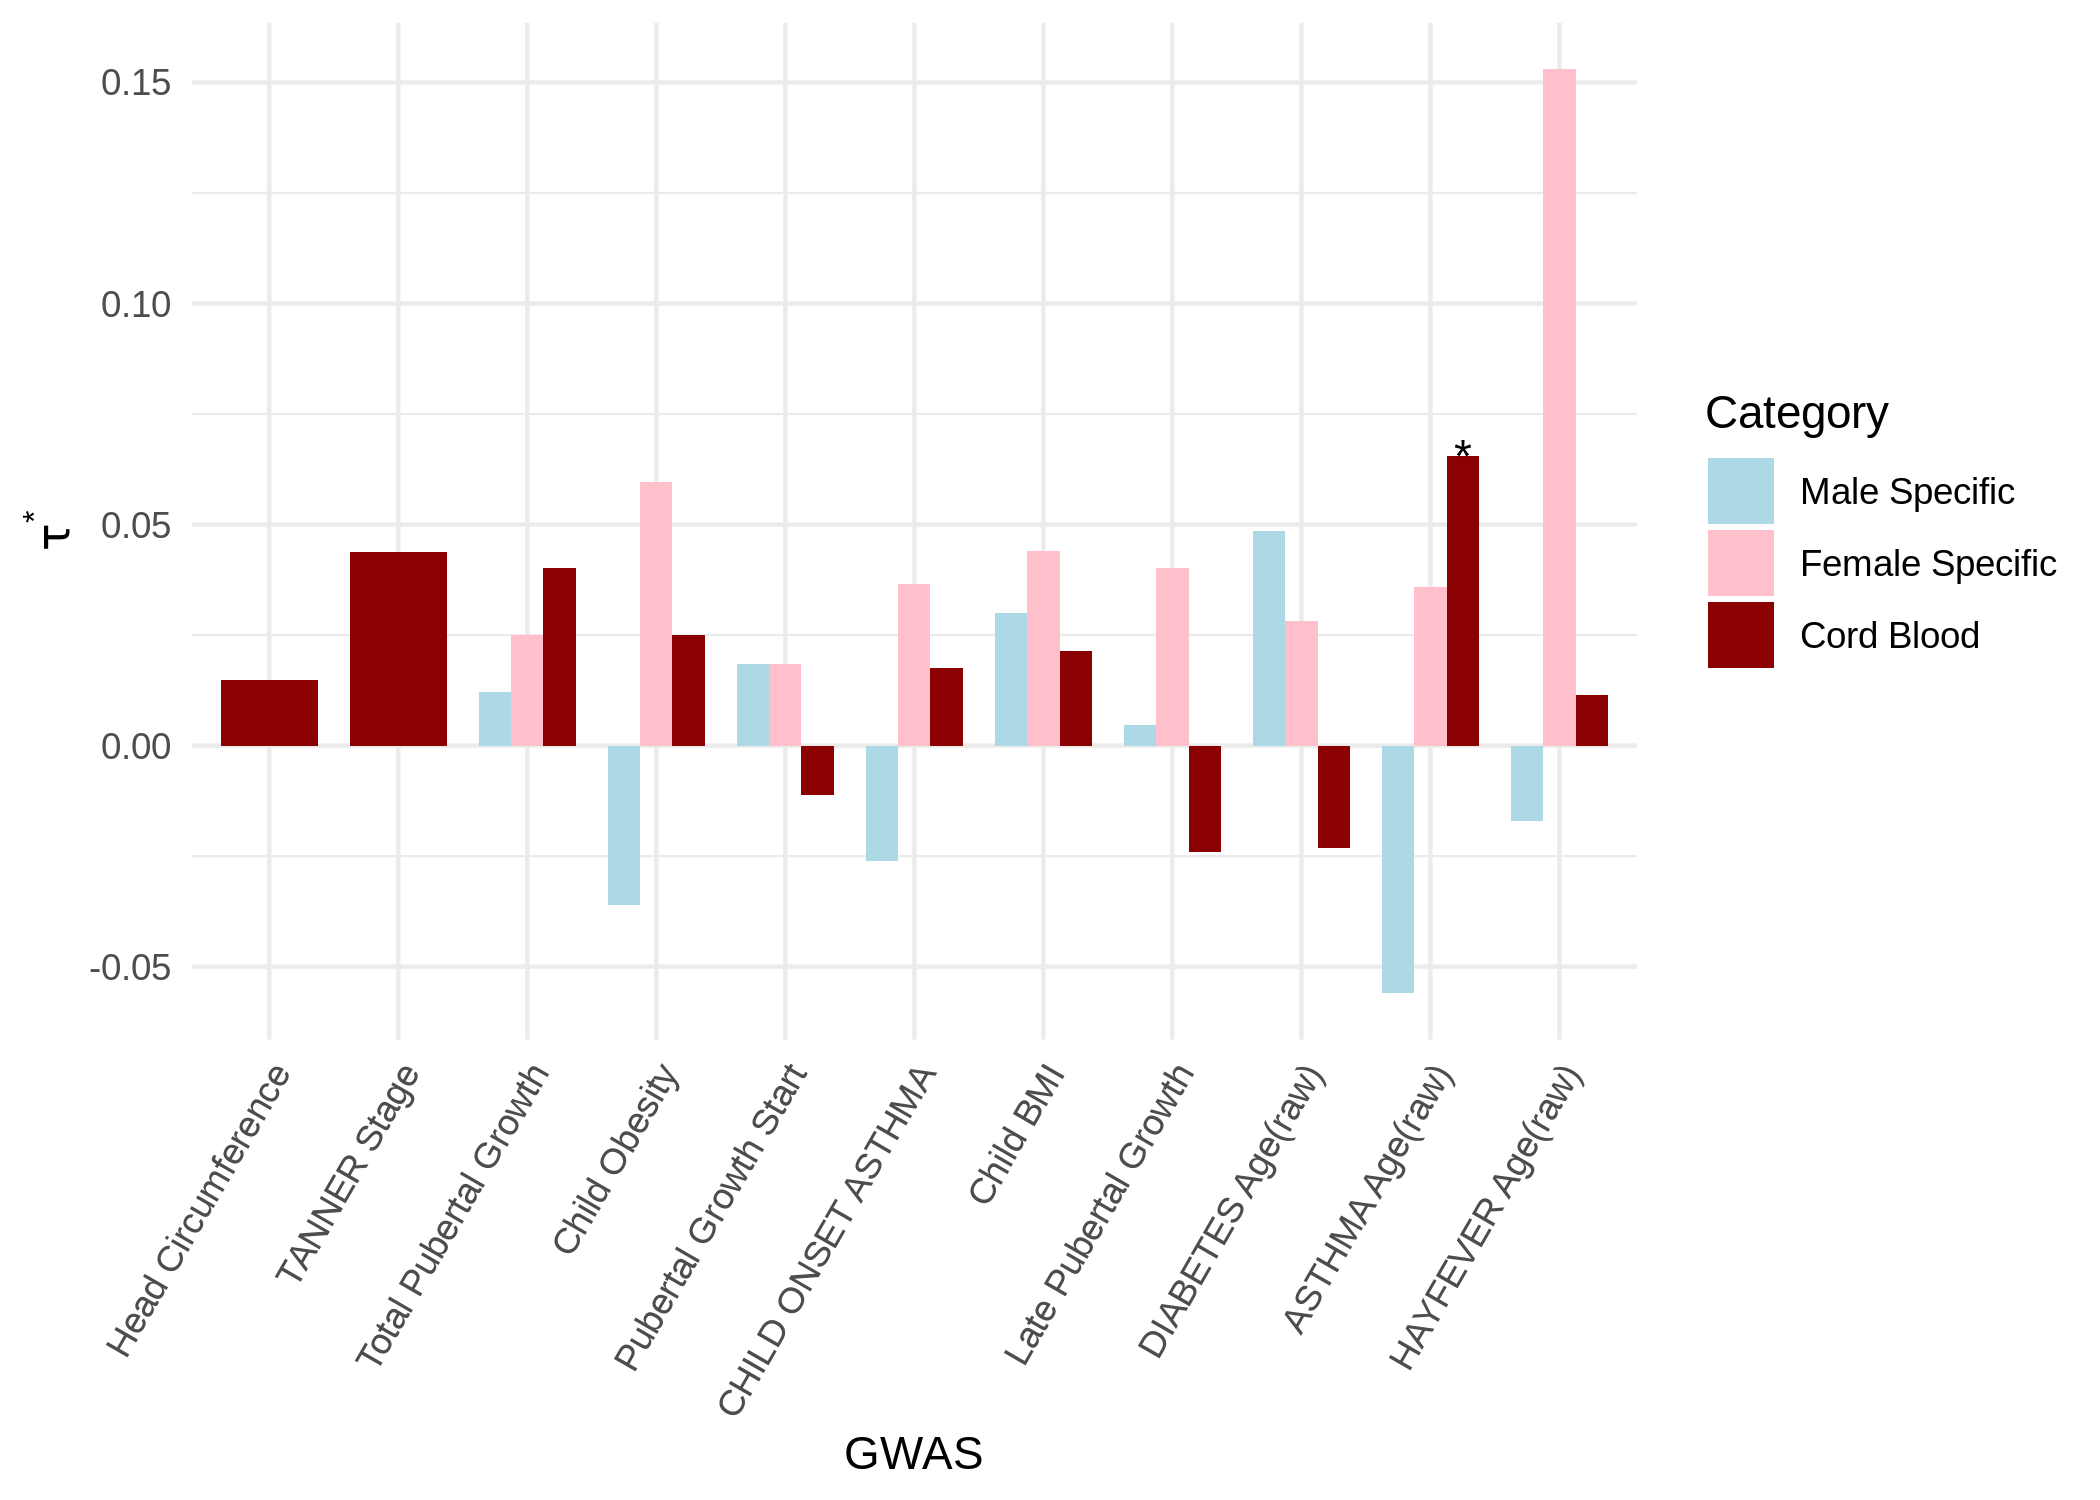

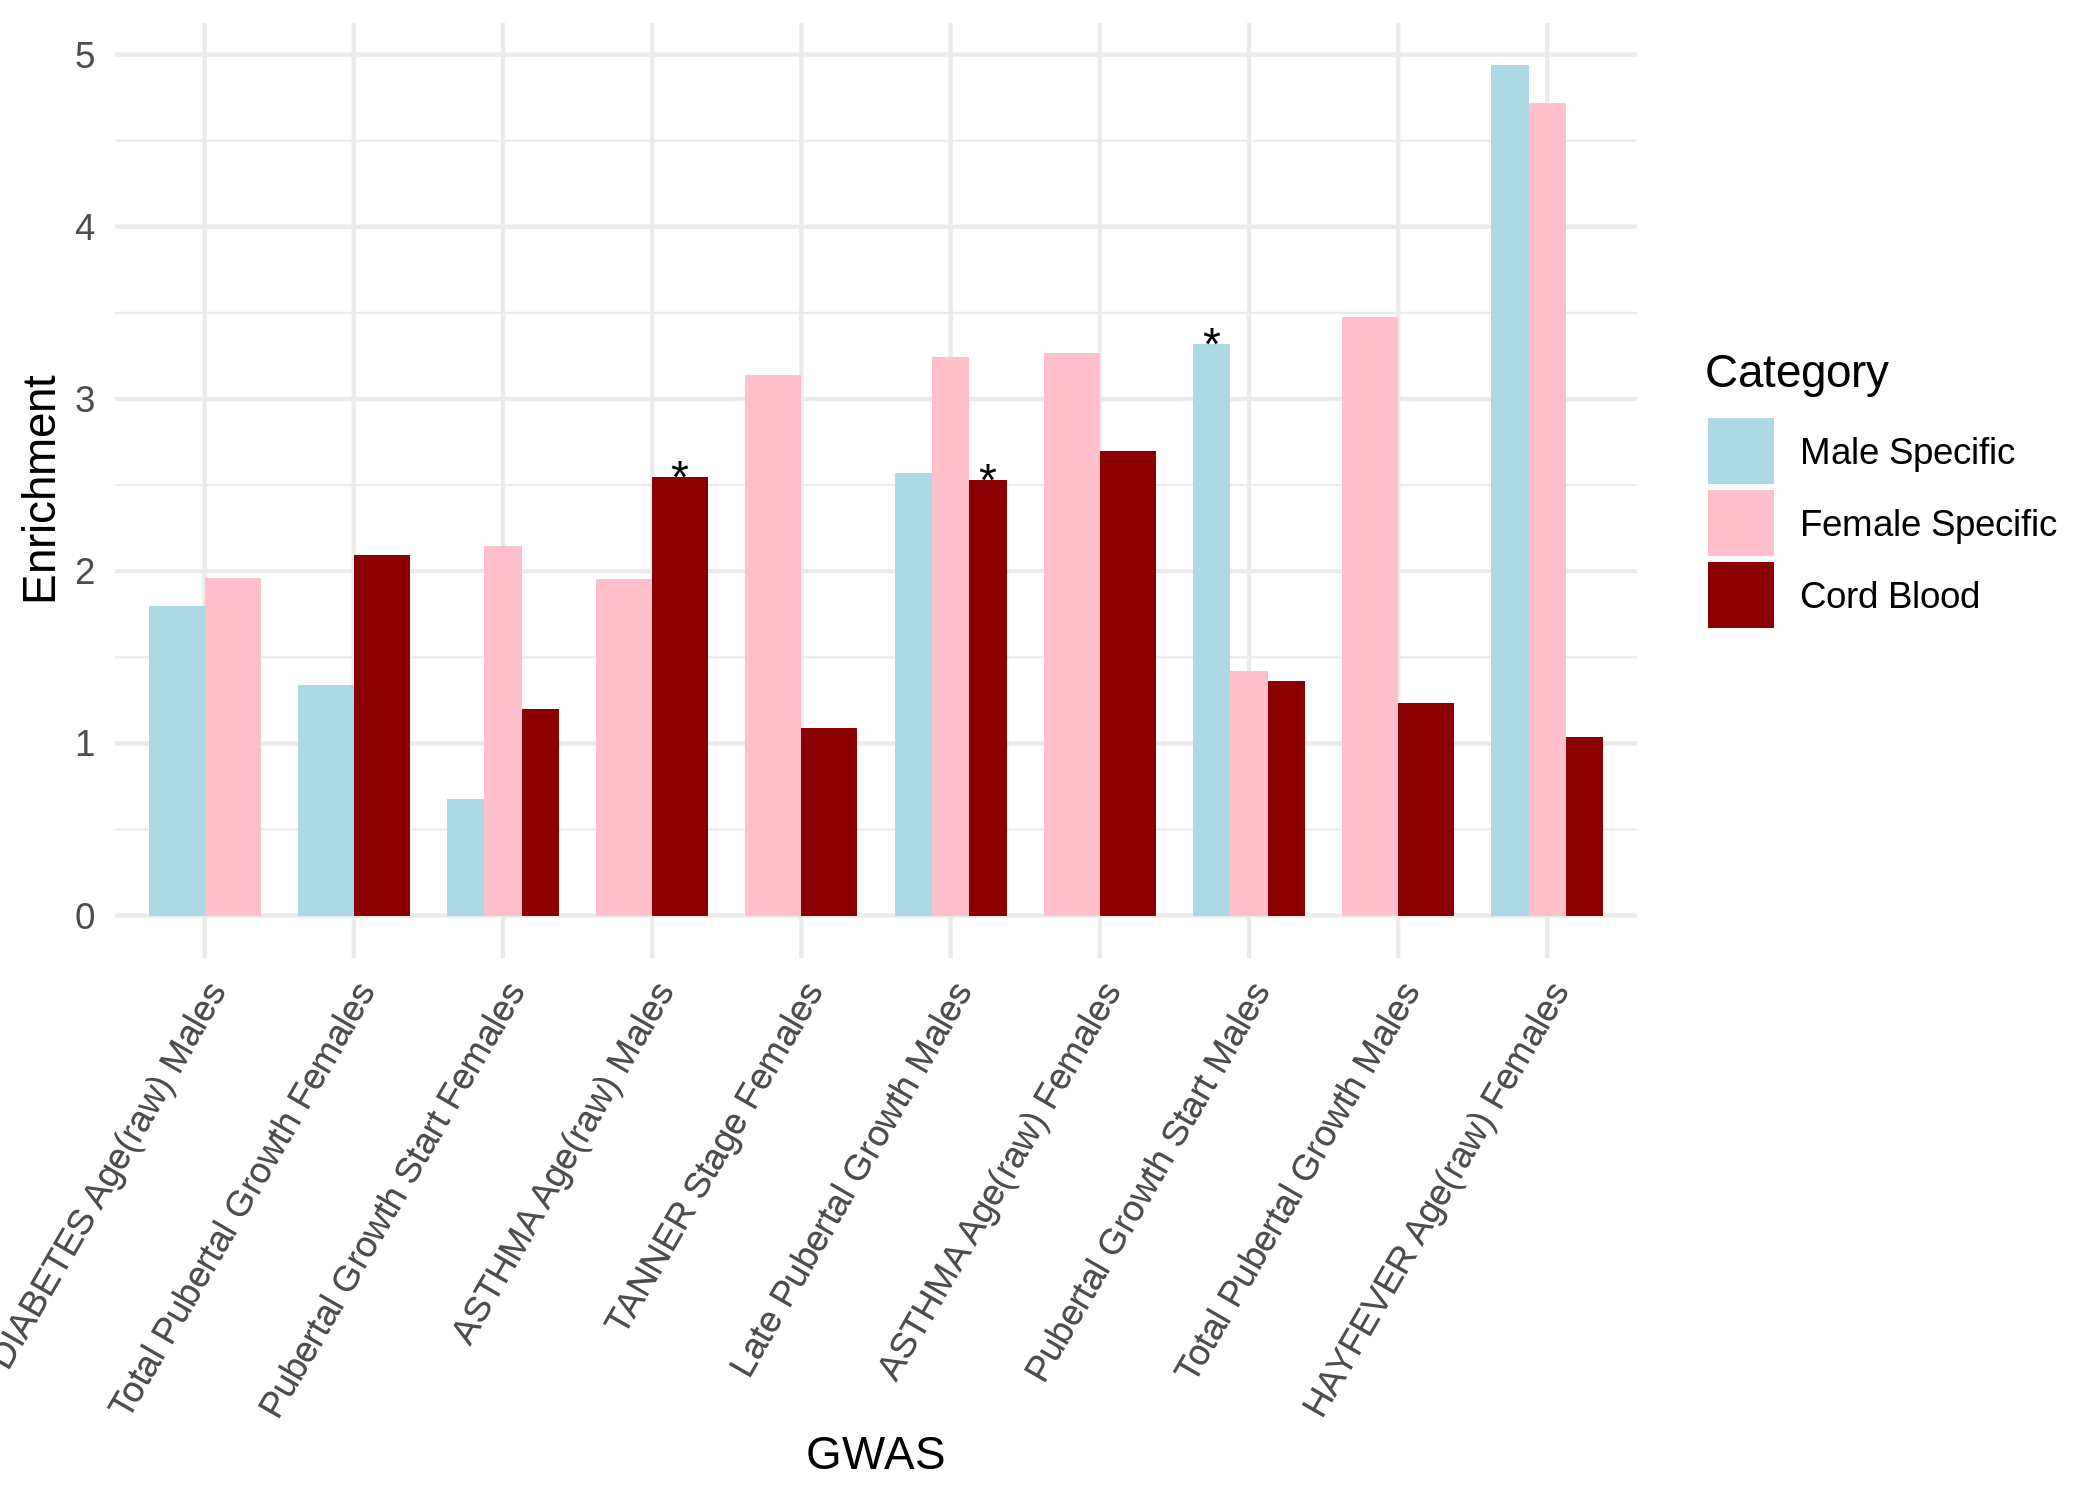

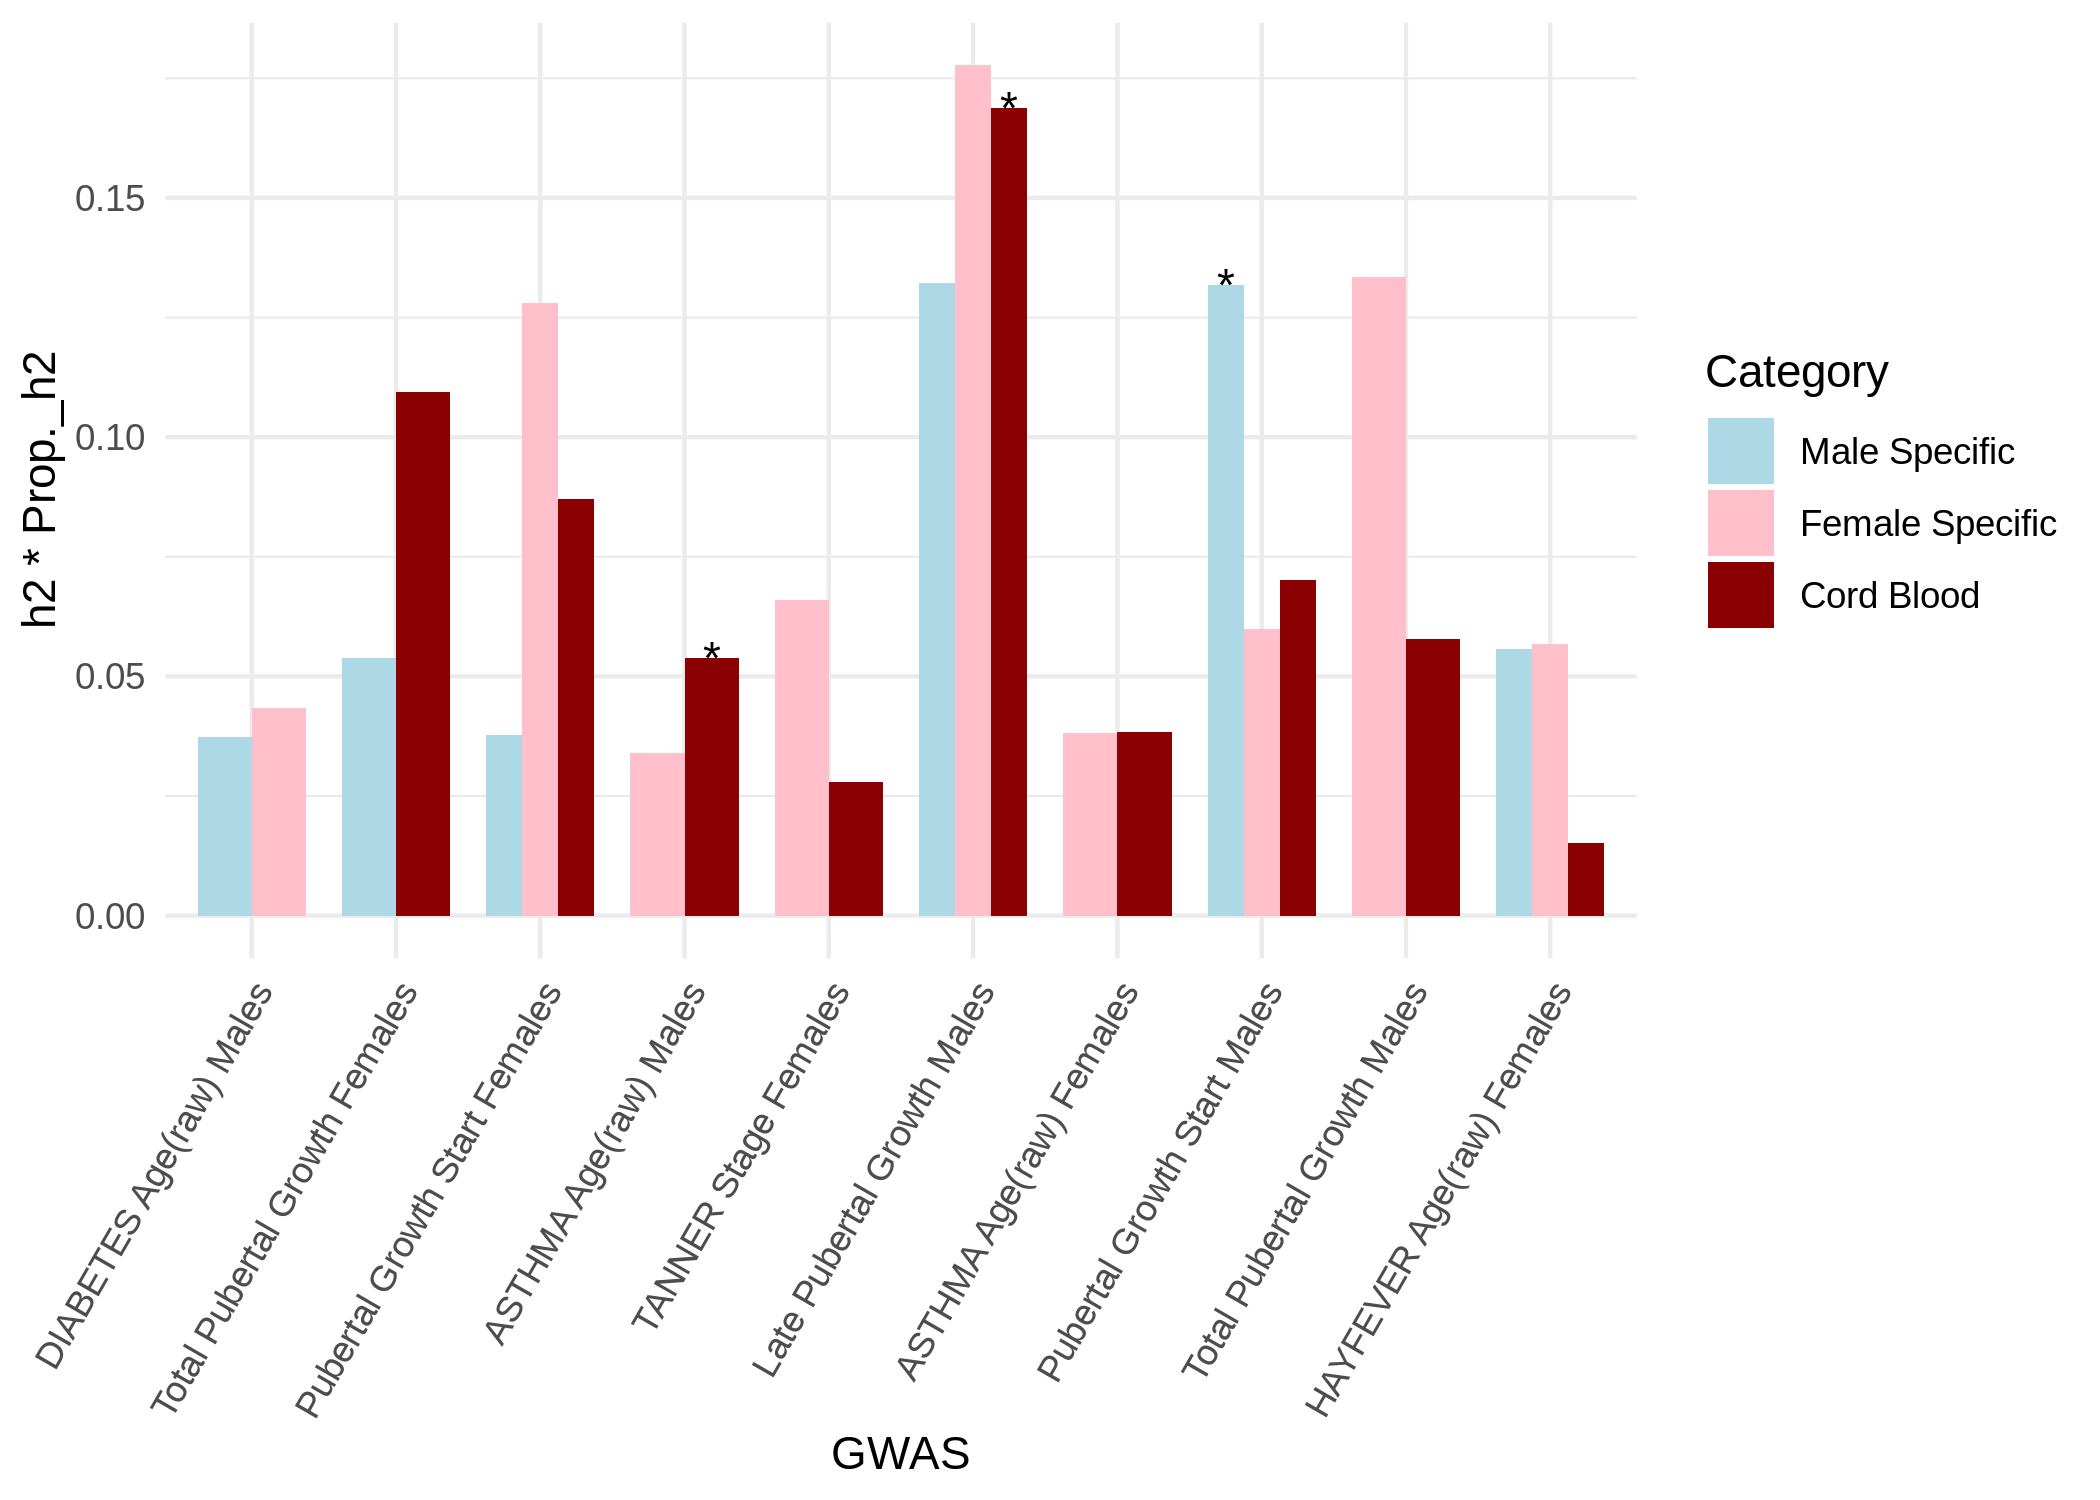

In [28]:
options(width= 10, repr.plot.height= 5, repr.plot.res = 300)
exclude_list <- unique(neonatal_part_heritability_sex_df$GWAS[grepl("norm",neonatal_part_heritability_sex_df$GWAS)])
annot_categories <- c("Male Specific", "Female Specific", "Marginal", "Cord Blood")
order_dt <-     neonatal_part_heritability_sex_df[
        !GWAS %in% exclude_list &
        !grepl("Male|Female",GWAS) &
        Category %in% annot_categories & 
        annotation == "bin_CPP_her" &
        Enrichment - Enrichment_std_error > 0,
        .(max_enrich = max(Enrichment)),
        by = "GWAS"
    ]
GWAS_order <- order_dt[order(max_enrich)]$GWAS
annot_order <- annot_categories


ggplot(
    neonatal_part_heritability_sex_df[
        !GWAS %in% exclude_list &
        !grepl("Male|Female",GWAS) &
        Category %in% annot_categories & 
        annotation == "bin_CPP_her" &
        Enrichment - Enrichment_std_error > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=Enrichment,label = ifelse(significant_enrich,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    scale_fill_manual(values = c("light blue", "pink", "dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))
ggplot(
    neonatal_part_heritability_sex_df[
        !GWAS %in% exclude_list &
        !grepl("Male|Female",GWAS) &
        Category %in% annot_categories & 
        annotation == "bin_CPP_her" &
        Enrichment - Enrichment_std_error > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=h2*Prop._h2,label = ifelse(significant_enrich,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    scale_fill_manual(values = c("light blue", "pink", "dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))
ggplot(
    neonatal_part_heritability_sex_df[
        !GWAS %in% exclude_list &
        !grepl("Male|Female",GWAS) &
        Category %in% annot_categories & 
        annotation == "bin_CPP_her" &
        Enrichment - Enrichment_std_error > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=tau_star,label = ifelse(pnorm(abs(tau_star/tau_se),lower.tail=F)*2 < 0.05,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    labs(y=bquote(tau^"*"))+
    scale_fill_manual(values = c("light blue", "pink","dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))

order_sex_dt <-     neonatal_part_heritability_sex_df[
        !GWAS %in% exclude_list &
        grepl("Male|Female",GWAS) &
        Category %in% annot_order&
        annotation == "bin_CPP_her" &
        Enrichment - Enrichment_std_error > 0,
        .(max_enrich = max(Enrichment)),
        by = "GWAS"
    ]
GWAS_sex_order <- order_sex_dt[order(max_enrich)]$GWAS
ggplot(
    neonatal_part_heritability_sex_df[
        !GWAS %in% exclude_list &
        grepl("Male|Female",GWAS) &
        Category %in% annot_order &
        annotation == "bin_CPP_her" &
        Enrichment - Enrichment_std_error > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_sex_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=Enrichment,label = ifelse(significant_enrich,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    scale_fill_manual(values = c("light blue", "pink", "dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))

ggplot(
    neonatal_part_heritability_sex_df[
        !GWAS %in% exclude_list &
        grepl("Male|Female",GWAS) &
        Category %in% annot_order &
        annotation == "bin_CPP_her" &
        Enrichment - Enrichment_std_error > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_sex_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=h2*Prop._h2,label = ifelse(significant_enrich,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    scale_fill_manual(values = c("light blue", "pink", "dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))

### Presenting these figures
**RELEVANT COMPARISONS**
* Males vs Females
* Cord Blood vs placenta
* male vs marginal
* female vs marginal
* male vs cord blood
* female vs cord blood
* higher enrichment of sex specific annotations in sex-specific GWAS


GWAS                 
1  SCZ                  
2  TS                   
3  ADHD                 
4  ASD                  
5  OCD                  
6  AN                   
7  SCZ                  
8  TS                   
9  ADHD                 
10 ASD                  
11 OCD                  
12 AN                   
13 CHILD ONSET ASTHMA   
14 Child BMI            
15 Head Circumference   
16 Child Obesity        
17 Pubertal Growth Start
18 Total Pubertal Growth
19 Late Pubertal Growth 
20 Type 1 Diabetes      
21 ASTHMA Age           
22 HAYFEVER Age         
23 Fetal Pre-Eclampsia  
24 CHILD ONSET ASTHMA   
25 Child BMI            
26 Head Circumference   
27 Child Obesity        
28 Pubertal Growth Start
29 Total Pubertal Growth
30 Late Pubertal Growth 
31 Type 1 Diabetes      
32 ASTHMA Age           
33 HAYFEVER Age         
34 Fetal Pre-Eclampsia  
   Enrichment
1   1.1489035
2   0.4658555
3   0.8563704
4   0.9223820
5   1.9388278
6   0.9887567
7   0.8671030
8   1.5276426
9   0.1841595
10  0.3880246
11  2.0982290
12  0.8035056
13  1.9275728
14  2.2576894
15 -1.3003508
16  1.7995746
17  1.9774269
18  1.8411453
19  2.8716004
20  1.8930147
21  2.4676725
22  3.2200234
23  2.3391756
24  1.4311192
25  2.1261649
26 -0.3042851
27  0.9825809
28  1.9738614
29  1.7030686
30  2.5411559
31  1.9281660
32  1.7656243
33  1.9487426
34  0.8480588
   Category       
1  Female Specific
2  Female Specific
3  Female Specific
4  Female Specific
5  Female Specific
6  Female Specific
7  Male Specific  
8  Male Specific  
9  Male Specific  
10 Male Specific  
11 Male Specific  
12 Male Specific  
13 Female Specific
14 Female Specific
15 Female Specific
16 Female Specific
17 Female Specific
18 Female Specific
19 Female Specific
20 Female Specific
21 Female Specific
22 Female Specific
23 Female Specific
24 Male Specific  
25 Male Specific  
26 Male Specific  
27 Male Specific  
28 Male Specific  
29 Male Specific  
30 Male Specific  
31 Male Specific  
32 Male Specific  
33 Male Specific  
34 Male Specific  
   Enrichment_std_error
1  0.2257554           
2  0.5983593           
3  0.2793239           
4  0.4573741           
5  0.8423716           
6  0.3341794           
7  0.1935561           
8  0.6749526           
9  0.2595529           
10 0.4577186           
11 1.0059337           
12 0.3286420           
13 0.5032554           
14 0.7559520           
15 1.5717008           
16 0.9722178           
17 0.4584860           
18 0.7586510           
19 1.7689665           
20 0.6525770           
21 0.7454110           
22 1.0989489           
23 1.6291252           
24 0.4224148           
25 0.5083630           
26 1.5682709           
27 0.5610924           
28 0.4347503           
29 0.7246351           
30 1.5755219           
31 0.5178201           
32 0.6727641           
33 1.0834144           
34 1.5138578           
   Enrichment_p
1  0.511046427 
2  0.364840411 
3  0.607132397 
4  0.861339262 
5  0.261364359 
6  0.973104178 
7  0.492645401 
8  0.429754585 
9  0.001478429 
10 0.129223454 
11 0.254367489 
12 0.549820713 
13 0.075819354 
14 0.089411659 
15 0.103347555 
16 0.404991684 
17 0.029276407 
18 0.253729370 
19 0.217134712 
20 0.195080612 
21 0.059550930 
22 0.053431594 
23 0.357299484 
24 0.309674773 
25 0.020816440 
26 0.402791222 
27 0.975131890 
28 0.023162631 
29 0.318325155 
30 0.273260486 
31 0.091589847 
32 0.267531839 
33 0.389579598 
34 0.918670985 
   sig_enrich
1  FALSE     
2  FALSE     
3  FALSE     
4  FALSE     
5  FALSE     
6  FALSE     
7  FALSE     
8  FALSE     
9  FALSE     
10 FALSE     
11 FALSE     
12 FALSE     
13 FALSE     
14 FALSE     
15 FALSE     
16 FALSE     
17 FALSE     
18 FALSE     
19 FALSE     
20 FALSE     
21 FALSE     
22 FALSE     
23 FALSE     
24 FALSE     
25 FALSE     
26 FALSE     
27 FALSE     
28 FALSE     
29 FALSE     
30 FALSE     
31 FALSE     
32 FALSE     
33 FALSE     
34 FALSE     
   h2    
1  0.3048
2  0.3359
3  0.2518
4  0.1735
5  0.3319
6  0.1703
7  0.3048
8  

[1] "Cord Blood"       
[2] "Cross-sex"        
[3] "Female Specific"  
[4] "Female Stratified"
[5] "Male Specific"    
[6] "Male Stratified"  
[7] "Sex dependent"

GWAS                 
1  SCZ                  
2  TS                   
3  ADHD                 
4  ASD                  
5  OCD                  
6  AN                   
7  SCZ                  
8  TS                   
9  ADHD                 
10 ASD                  
11 OCD                  
12 AN                   
13 CHILD ONSET ASTHMA   
14 Child BMI            
15 Head Circumference   
16 Child Obesity        
17 Pubertal Growth Start
18 Total Pubertal Growth
19 Late Pubertal Growth 
20 Type 1 Diabetes      
21 ASTHMA Age           
22 HAYFEVER Age         
23 Fetal Pre-Eclampsia  
24 CHILD ONSET ASTHMA   
25 Child BMI            
26 Head Circumference   
27 Child Obesity        
28 Pubertal Growth Start
29 Total Pubertal Growth
30 Late Pubertal Growth 
31 Type 1 Diabetes      
32 ASTHMA Age           
33 HAYFEVER Age         
34 Fetal Pre-Eclampsia  
   Enrichment
1  1.0719369 
2  0.6562370 
3  0.9624302 
4  1.1669745 
5  1.3686363 
6  0.8723471 
7  1.0714096 
8  0.8339134 
9  0.9278877 
10 0.9866547 
11 1.5896250 
12 0.9151689 
13 1.4773215 
14 1.3012125 
15 0.6084335 
16 1.0330419 
17 1.4385818 
18 1.3978189 
19 1.9379453 
20 1.4441162 
21 1.8383746 
22 1.6707217 
23 1.2890962 
24 1.4406103 
25 1.3219101 
26 1.0110489 
27 1.1009357 
28 1.4254657 
29 1.3263877 
30 1.8316055 
31 1.4931136 
32 1.9607283 
33 1.6500656 
34 1.0054293 
   Category         
1  Female Stratified
2  Female Stratified
3  Female Stratified
4  Female Stratified
5  Female Stratified
6  Female Stratified
7  Male Stratified  
8  Male Stratified  
9  Male Stratified  
10 Male Stratified  
11 Male Stratified  
12 Male Stratified  
13 Female Stratified
14 Female Stratified
15 Female Stratified
16 Female Stratified
17 Female Stratified
18 Female Stratified
19 Female Stratified
20 Female Stratified
21 Female Stratified
22 Female Stratified
23 Female Stratified
24 Male Stratified  
25 Male Stratified  
26 Male Stratified  
27 Male Stratified  
28 Male Stratified  
29 Male Stratified  
30 Male Stratified  
31 Male Stratified  
32 Male Stratified  
33 Male Stratified  
34 Male Stratified  
   Enrichment_std_error
1  0.07709960          
2  0.21669711          
3  0.09753513          
4  0.16450884          
5  0.35685150          
6  0.12169918          
7  0.07257175          
8  0.20753355          
9  0.09803627          
10 0.17091783          
11 0.38170878          
12 0.11514019          
13 0.16270372          
14 0.20824189          
15 0.54081298          
16 0.24656249          
17 0.17888152          
18 0.29668169          
19 0.73212218          
20 0.17621815          
21 0.27281049          
22 0.39466568          
23 0.60026125          
24 0.15923558          
25 0.20223099          
26 0.53042925          
27 0.23011328          
28 0.16565789          
29 0.26703473          
30 0.68082848          
31 0.14622311          
32 0.27535373          
33 0.38990502          
34 0.53551119          
   Enrichment_p
1  0.3530212535
2  0.0918677243
3  0.6996764969
4  0.3294124257
5  0.2985158444
6  0.2942866208
7  0.3264150725
8  0.4151854598
9  0.4626262773
10 0.9361069702
11 0.1008489586
12 0.4608768407
13 0.0053442182
14 0.1415372207
15 0.4625591753
16 0.8930471459
17 0.0130405763
18 0.1688711914
19 0.0944709405
20 0.0123230687
21 0.0023154554
22 0.0764697715
23 0.6163178201
24 0.0077961089
25 0.1025885385
26 0.9833247617
27 0.6566953786
28 0.0097017790
29 0.2070093515
30 0.1033636804
31 0.0006802399
32 0.0003229476
33 0.0704428511
34 0.9918389138
   sig_enrich
1  FALSE     
2  FALSE     
3  FALSE     
4  FALSE     
5  FALSE     
6  FALSE     
7  FALSE     
8  FALSE     
9  FALSE     
10 FALSE     
11 FALSE     
12 FALSE     
13  TRUE     
14 FALSE     
15 FALSE     
16 FALSE     
17 FALSE     
18 FALSE     
19 FALSE     
20 FALSE     
21  TRUE     
22 FALSE     
23 FALSE     
24 FALSE     
25 FALSE     
26 FALSE     
27 FALSE     
28 FALSE     
29 FALSE     
30 FALSE     
31  TRUE     
32  TRUE     
33 FALSE     
34 FALSE     
   h2    
1  

GWAS                 
1  SCZ                  
2  TS                   
3  ADHD                 
4  ASD                  
5  OCD                  
6  AN                   
7  SCZ                  
8  TS                   
9  ADHD                 
10 ASD                  
11 OCD                  
12 AN                   
13 CHILD ONSET ASTHMA   
14 Child BMI            
15 Head Circumference   
16 Child Obesity        
17 Pubertal Growth Start
18 Total Pubertal Growth
19 Late Pubertal Growth 
20 Type 1 Diabetes      
21 ASTHMA Age           
22 HAYFEVER Age         
23 Fetal Pre-Eclampsia  
24 CHILD ONSET ASTHMA   
25 Child BMI            
26 Head Circumference   
27 Child Obesity        
28 Pubertal Growth Start
29 Total Pubertal Growth
30 Late Pubertal Growth 
⋮  ⋮                    
39 OCD                  
40 AN                   
41 SCZ                  
42 TS                   
43 ADHD                 
44 ASD                  
45 OCD                  
46 AN                   
47 CHILD ONSET ASTHMA   
48 Child BMI            
49 Head Circumference   
50 Child Obesity        
51 Pubertal Growth Start
52 Total Pubertal Growth
53 Late Pubertal Growth 
54 Type 1 Diabetes      
55 ASTHMA Age           
56 HAYFEVER Age         
57 Fetal Pre-Eclampsia  
58 CHILD ONSET ASTHMA   
59 Child BMI            
60 Head Circumference   
61 Child Obesity        
62 Pubertal Growth Start
63 Total Pubertal Growth
64 Late Pubertal Growth 
65 Type 1 Diabetes      
66 ASTHMA Age           
67 HAYFEVER Age         
68 Fetal Pre-Eclampsia  
   Enrichment
1   1.1489035
2   0.4658555
3   0.8563704
4   0.9223820
5   1.9388278
6   0.9887567
7   0.8671030
8   1.5276426
9   0.1841595
10  0.3880246
11  2.0982290
12  0.8035056
13  1.9275728
14  2.2576894
15 -1.3003508
16  1.7995746
17  1.9774269
18  1.8411453
19  2.8716004
20  1.8930147
21  2.4676725
22  3.2200234
23  2.3391756
24  1.4311192
25  2.1261649
26 -0.3042851
27  0.9825809
28  1.9738614
29  1.7030686
30  2.5411559
⋮  ⋮         
39 1.3686363 
40 0.8723471 
41 1.0714096 
42 0.8339134 
43 0.9278877 
44 0.9866547 
45 1.5896250 
46 0.9151689 
47 1.4773215 
48 1.3012125 
49 0.6084335 
50 1.0330419 
51 1.4385818 
52 1.3978189 
53 1.9379453 
54 1.4441162 
55 1.8383746 
56 1.6707217 
57 1.2890962 
58 1.4406103 
59 1.3219101 
60 1.0110489 
61 1.1009357 
62 1.4254657 
63 1.3263877 
64 1.8316055 
65 1.4931136 
66 1.9607283 
67 1.6500656 
68 1.0054293 
   Category         
1  Female Specific  
2  Female Specific  
3  Female Specific  
4  Female Specific  
5  Female Specific  
6  Female Specific  
7  Male Specific    
8  Male Specific    
9  Male Specific    
10 Male Specific    
11 Male Specific    
12 Male Specific    
13 Female Specific  
14 Female Specific  
15 Female Specific  
16 Female Specific  
17 Female Specific  
18 Female Specific  
19 Female Specific  
20 Female Specific  
21 Female Specific  
22 Female Specific  
23 Female Specific  
24 Male Specific    
25 Male Specific    
26 Male Specific    
27 Male Specific    
28 Male Specific    
29 Male Specific    
30 Male Specific    
⋮  ⋮                
39 Female Stratified
40 Female Stratified
41 Male Stratified  
42 Male Stratified  
43 Male Stratified  
44 Male Stratified  
45 Male Stratified  
46 Male Stratified  
47 Female Stratified
48 Female Stratified
49 Female Stratified
50 Female Stratified
51 Female Stratified
52 Female Stratified
53 Female Stratified
54 Female Stratified
55 Female Stratified
56 Female Stratified
57 Female Stratified
58 Male Stratified  
59 Male Stratified  
60 Male Stratified  
61 Male Stratified  
62 Male Stratified  
63 Male Stratified  
64 Male Stratified  
65 Male Stratified  
66 Male Stratified  
67 Male Stratified  
68 Male Stratified  
   Enrichment_std_error
1  0.2257554           
2  0.5983593           
3  0.2793239           
4  0.4573741           
5  0.8423716           
6  0.3341794           
7  0.1935561           
8  0.6749526           
9  0.2595529           
10 0.4577186           
11 1.0059337       

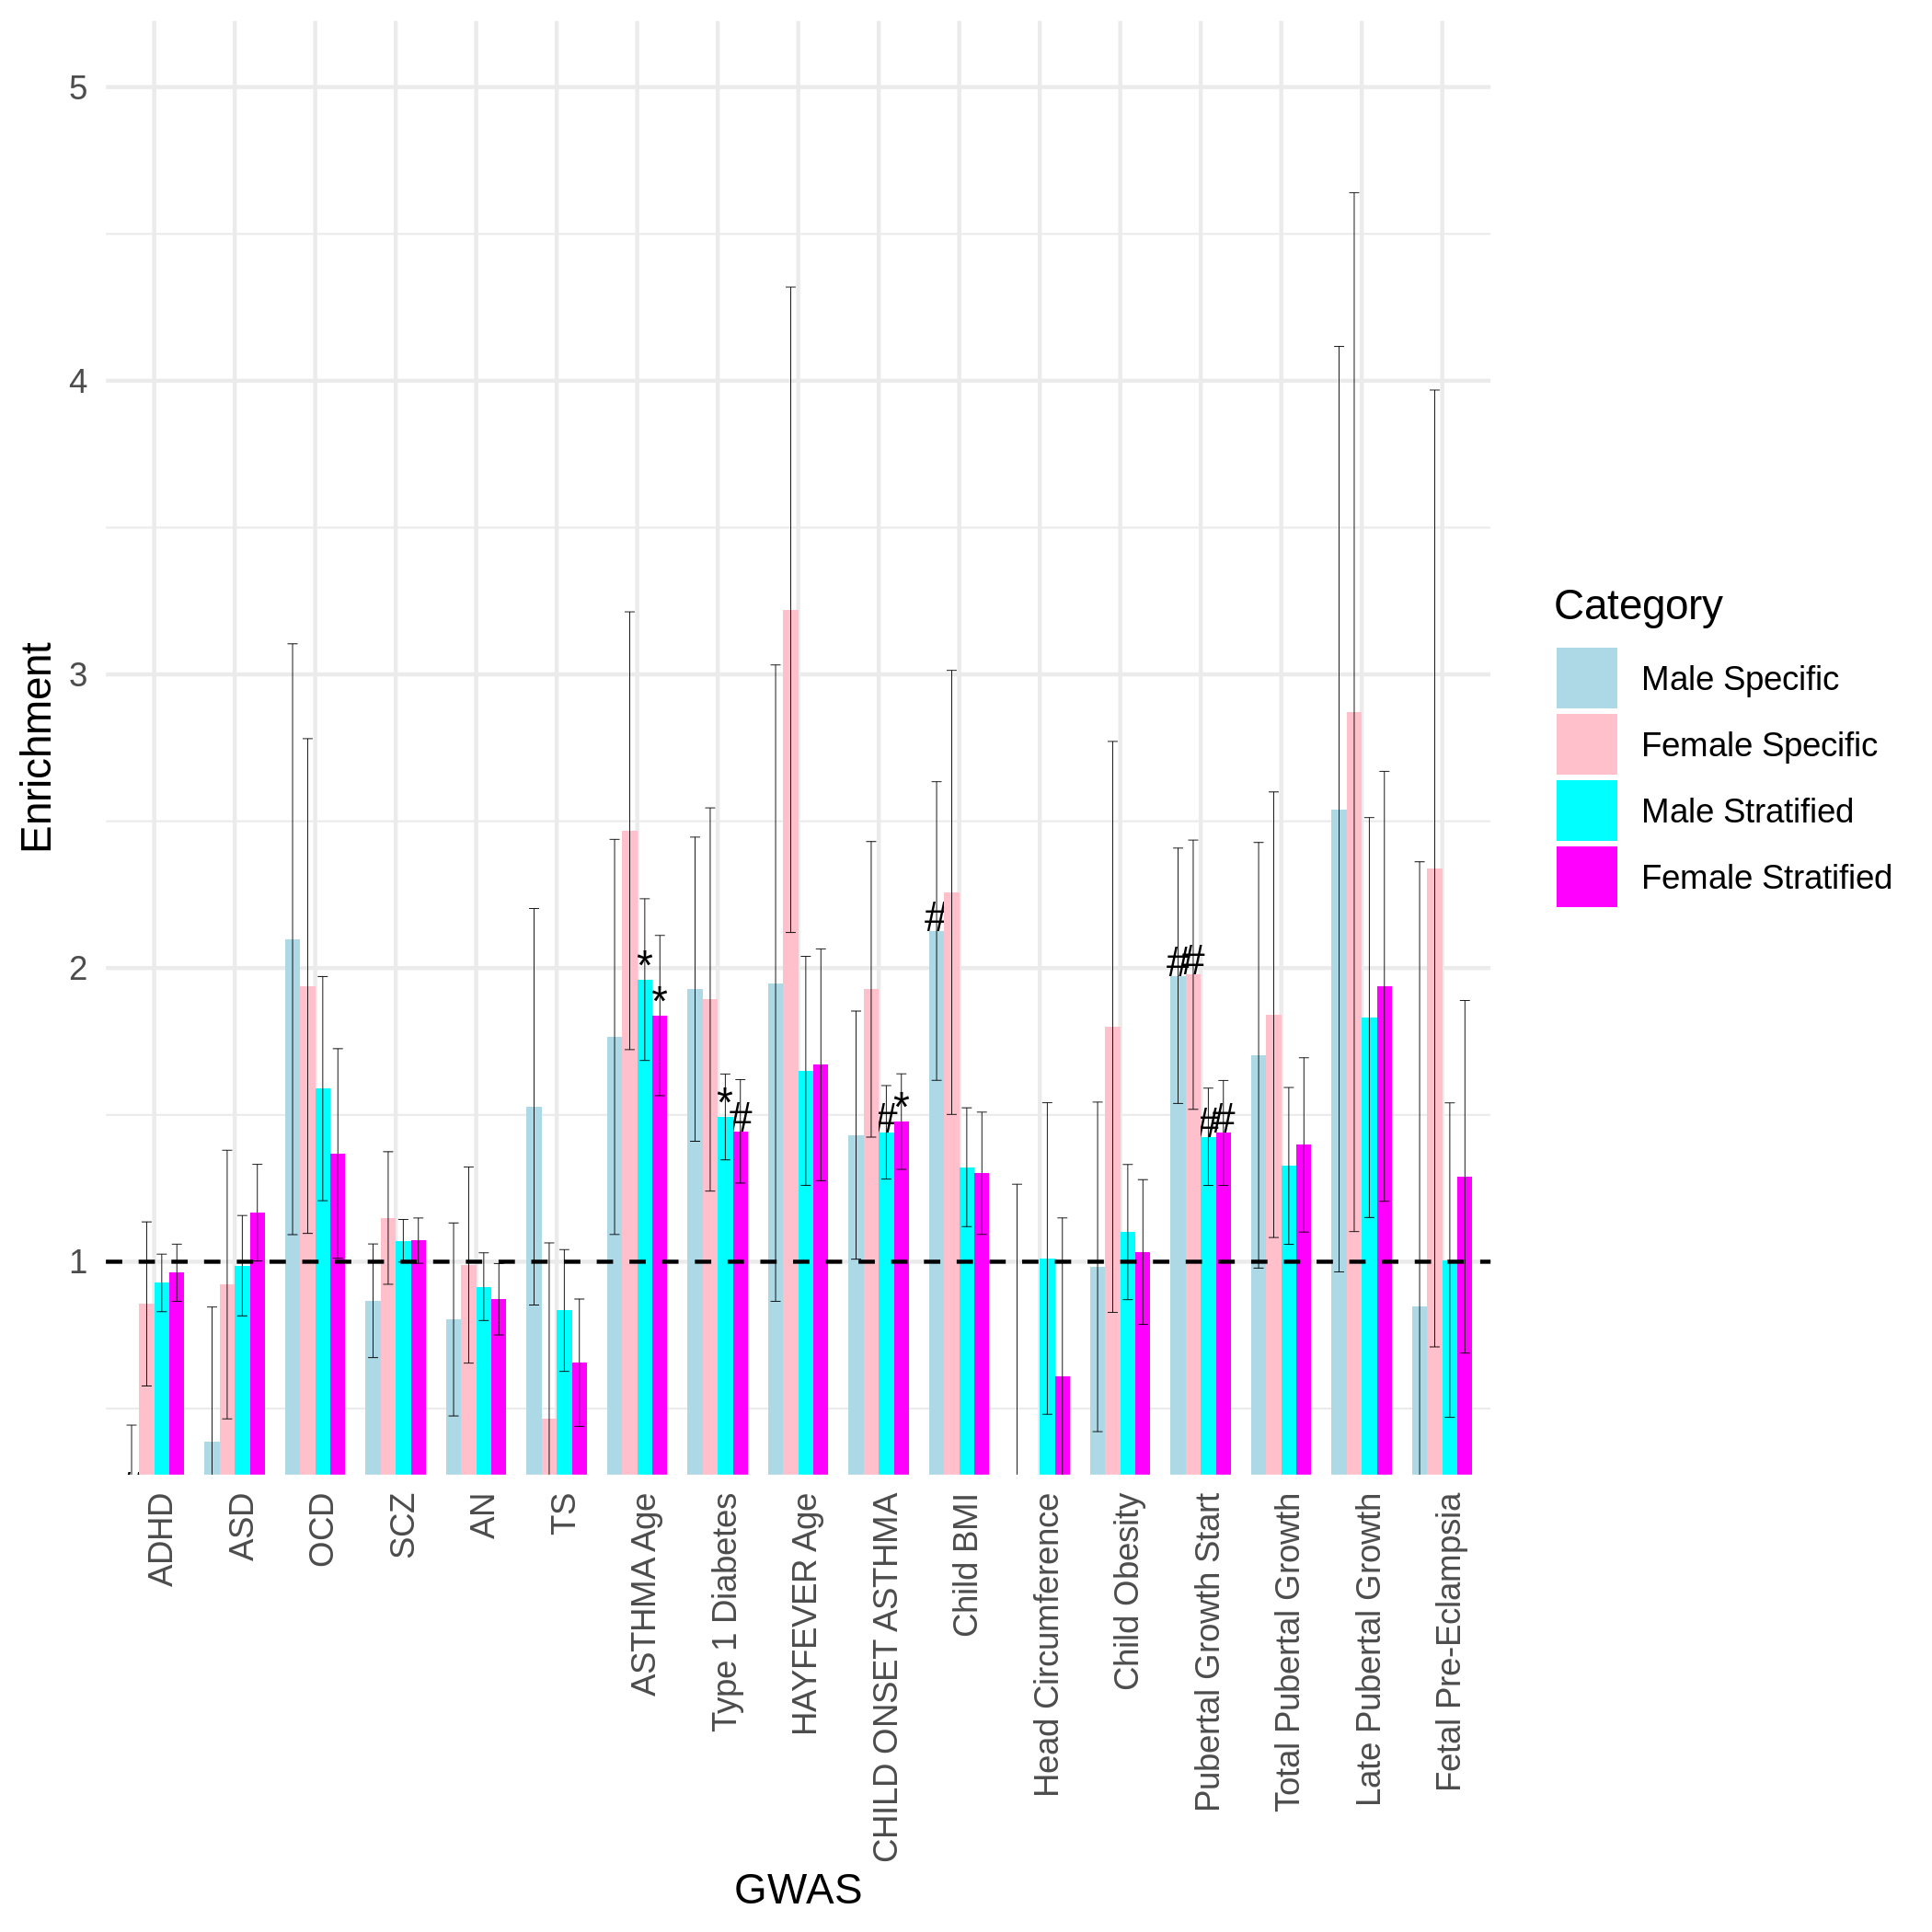

In [8]:
library(ggrepel)
options(width= 10, repr.plot.height= 7, repr.plot.res = 300)
sex_order <- unique(gsub("\\(raw\\)|\\(norm\\)","",c(pgc_GWAS_key,neonatal_GWAS_key)))

combined_df <- rbind(pgc_part_heritability_independent_df,neonatal_part_heritability_independent_df) %>%
    filter(GWAS %in% selected_GWAS) %>%
    mutate(
        normalization = ifelse(grepl("norm",GWAS),"norm","raw"),
        GWAS=gsub("\\(raw\\)|\\(norm\\)","",GWAS)
    )
combined_df <- combined_df[,.SD[which.max(h2 / h2_std_error)],by=c("GWAS","Category")]
filtered <- combined_df[        
        grepl("Male Specific|Female Specific",Category) &
        !grepl("Male|Female",GWAS)

]

to_plot_specific <- filtered[,
    .(
        GWAS = factor(GWAS,levels = sex_order),
        Enrichment,
        Category=factor(Category,levels=c("Male Specific","Female Specific")),
        Enrichment_std_error,
        Enrichment_p,
        sig_enrich = p.adjust(Enrichment_p,method="BH") <0.05,
                h2,
        h2_std_error
    )
]
to_plot_specific[,`:=`(sig_enrich_GWAS = p.adjust(Enrichment_p,method="BH") < 0.05),by="GWAS"]
to_plot_specific[, `:=`(h2_z = h2 /h2_std_error)]
to_plot_specific
unique(pgc_part_heritability_independent_df$Category)
filtered <- combined_df[        
        grepl("Male Stratified|Female Stratified",Category) &
        !grepl("Male|Female",GWAS)

]

to_plot_stratified <- filtered[,
    .(
        GWAS = factor(GWAS,levels = sex_order),
        Enrichment,
        Category=factor(Category,levels=c("Male Stratified","Female Stratified")),
        Enrichment_std_error,
        Enrichment_p,
        sig_enrich = p.adjust(Enrichment_p,method="BH") <0.05,
                h2,
        h2_std_error
    )
]
to_plot_stratified[,`:=`(sig_enrich_GWAS = p.adjust(Enrichment_p,method="BH") < 0.05),by="GWAS"]

to_plot_stratified[, `:=`(h2_z = h2 /h2_std_error)]
to_plot_stratified
rbind(to_plot_specific,to_plot_stratified)
ggplot(
    rbind(to_plot_specific,to_plot_stratified),
    aes(
        GWAS,
        Enrichment,
        fill = Category,
        #color=GWAS_group,
        label=ifelse(sig_enrich,"*",ifelse(sig_enrich_GWAS,"#","")),
        ymin= Enrichment - Enrichment_std_error,
        ymax=Enrichment + Enrichment_std_error
    )
)+
    geom_text(color="black",position=position_dodge(width=0.75),vjust=0)+
    geom_col(position=position_dodge(width=0.75),width=0.75)+
    geom_errorbar(width=0.5,size=0.1,position=position_dodge(width=0.75)) + 
    coord_cartesian(ylim = c(0.5,5))+
    geom_hline(yintercept = 1,linetype="dashed")+
    scale_fill_manual(values=c("light blue","pink","cyan","magenta"))+

    theme_minimal()+
    theme(axis.text.x = element_text(angle=90,hjust=1,vjust=0.75))

GWAS                 
1  SCZ                  
2  TS                   
3  ADHD                 
4  ASD                  
5  OCD                  
6  AN                   
7  SCZ                  
8  TS                   
9  ADHD                 
10 ASD                  
11 OCD                  
12 AN                   
13 CHILD ONSET ASTHMA   
14 Child BMI            
15 Head Circumference   
16 Child Obesity        
17 Pubertal Growth Start
18 Total Pubertal Growth
19 Late Pubertal Growth 
20 Type 1 Diabetes      
21 ASTHMA Age           
22 HAYFEVER Age         
23 Fetal Pre-Eclampsia  
24 CHILD ONSET ASTHMA   
25 Child BMI            
26 Head Circumference   
27 Child Obesity        
28 Pubertal Growth Start
29 Total Pubertal Growth
30 Late Pubertal Growth 
31 Type 1 Diabetes      
32 ASTHMA Age           
33 HAYFEVER Age         
34 Fetal Pre-Eclampsia  
   Enrichment
1  1.2254172 
2  1.1320619 
3  0.9279021 
4  1.1252174 
5  1.1855354 
6  0.9941762 
7  1.0753534 
8  0.7542184 
9  0.9730239 
10 1.0042598 
11 1.3551311 
12 0.8719078 
13 1.8195528 
14 1.5401952 
15 1.1855566 
16 1.5013056 
17 1.3064566 
18 1.7473741 
19 1.3456640 
20 1.3866461 
21 2.7391444 
22 1.6132895 
23 1.2556512 
24 1.3840828 
25 1.2213883 
26 0.8294502 
27 1.0610333 
28 1.3995642 
29 1.1894903 
30 1.9000599 
31 1.4350960 
32 1.8297393 
33 1.5551324 
34 1.1164557 
   Category  
1  Cord Blood
2  Cord Blood
3  Cord Blood
4  Cord Blood
5  Cord Blood
6  Cord Blood
7  Cross-sex 
8  Cross-sex 
9  Cross-sex 
10 Cross-sex 
11 Cross-sex 
12 Cross-sex 
13 Cord Blood
14 Cord Blood
15 Cord Blood
16 Cord Blood
17 Cord Blood
18 Cord Blood
19 Cord Blood
20 Cord Blood
21 Cord Blood
22 Cord Blood
23 Cord Blood
24 Cross-sex 
25 Cross-sex 
26 Cross-sex 
27 Cross-sex 
28 Cross-sex 
29 Cross-sex 
30 Cross-sex 
31 Cross-sex 
32 Cross-sex 
33 Cross-sex 
34 Cross-sex 
   Enrichment_std_error
1  0.13028889          
2  0.28614400          
3  0.15511862          
4  0.24119440          
5  0.45181274          
6  0.18218882          
7  0.06836653          
8  0.19936362          
9  0.08920974          
10 0.15119878          
11 0.32432737          
12 0.10725069          
13 0.32433595          
14 0.39234874          
15 0.69577557          
16 0.41571267          
17 0.21102451          
18 0.51619952          
19 0.72280897          
20 0.31634138          
21 0.66140370          
22 0.51098880          
23 0.82683057          
24 0.13893213          
25 0.17123158          
26 0.47299826          
27 0.20347400          
28 0.15876050          
29 0.24714964          
30 0.67659865          
31 0.13155253          
32 0.24502511          
33 0.35643981          
34 0.51832091          
   Enrichment_p
1  0.0821195682
2  0.6393681165
3  0.6447132299
4  0.5893275218
5  0.6727661502
6  0.9744909636
7  0.2722642734
8  0.1984761249
9  0.7622995860
10 0.9771297330
11 0.2597994275
12 0.2311116951
13 0.0129705728
14 0.1541909520
15 0.7852784184
16 0.2062098761
17 0.1382456532
18 0.0973804170
19 0.6045506620
20 0.2126800494
21 0.0023856920
22 0.1911709342
23 0.7443960286
24 0.0078783023
25 0.1871176867
26 0.7168241084
27 0.7623619987
28 0.0109083831
29 0.4394911774
30 0.0635068619
31 0.0006820545
32 0.0005296879
33 0.0972576957
34 0.8201260233
   sig_enrich
1  FALSE     
2  FALSE     
3  FALSE     
4  FALSE     
5  FALSE     
6  FALSE     
7  FALSE     
8  FALSE     
9  FALSE     
10 FALSE     
11 FALSE     
12 FALSE     
13 FALSE     
14 FALSE     
15 FALSE     
16 FALSE     
17 FALSE     
18 FALSE     
19 FALSE     
20 FALSE     
21  TRUE     
22 FALSE     
23 FALSE     
24 FALSE     
25 FALSE     
26 FALSE     
27 FALSE     
28 FALSE     
29 FALSE     
30 FALSE     
31  TRUE     
32  TRUE     
33 FALSE     
34 FALSE     
   GWAS_group      
1  Neuropsychiatric
2  Neuropsychiatric
3  Neuropsychiatric
4  Neuropsychiatric
5  Neuropsychiatric
6  Neuropsychiatric
7  Neuropsychiatric
8  Neuropsychiatric
9  Neuropsychiatric
10 Neuropsychiatric
11 Neuropsychiatric
12 Neuropsychiatri

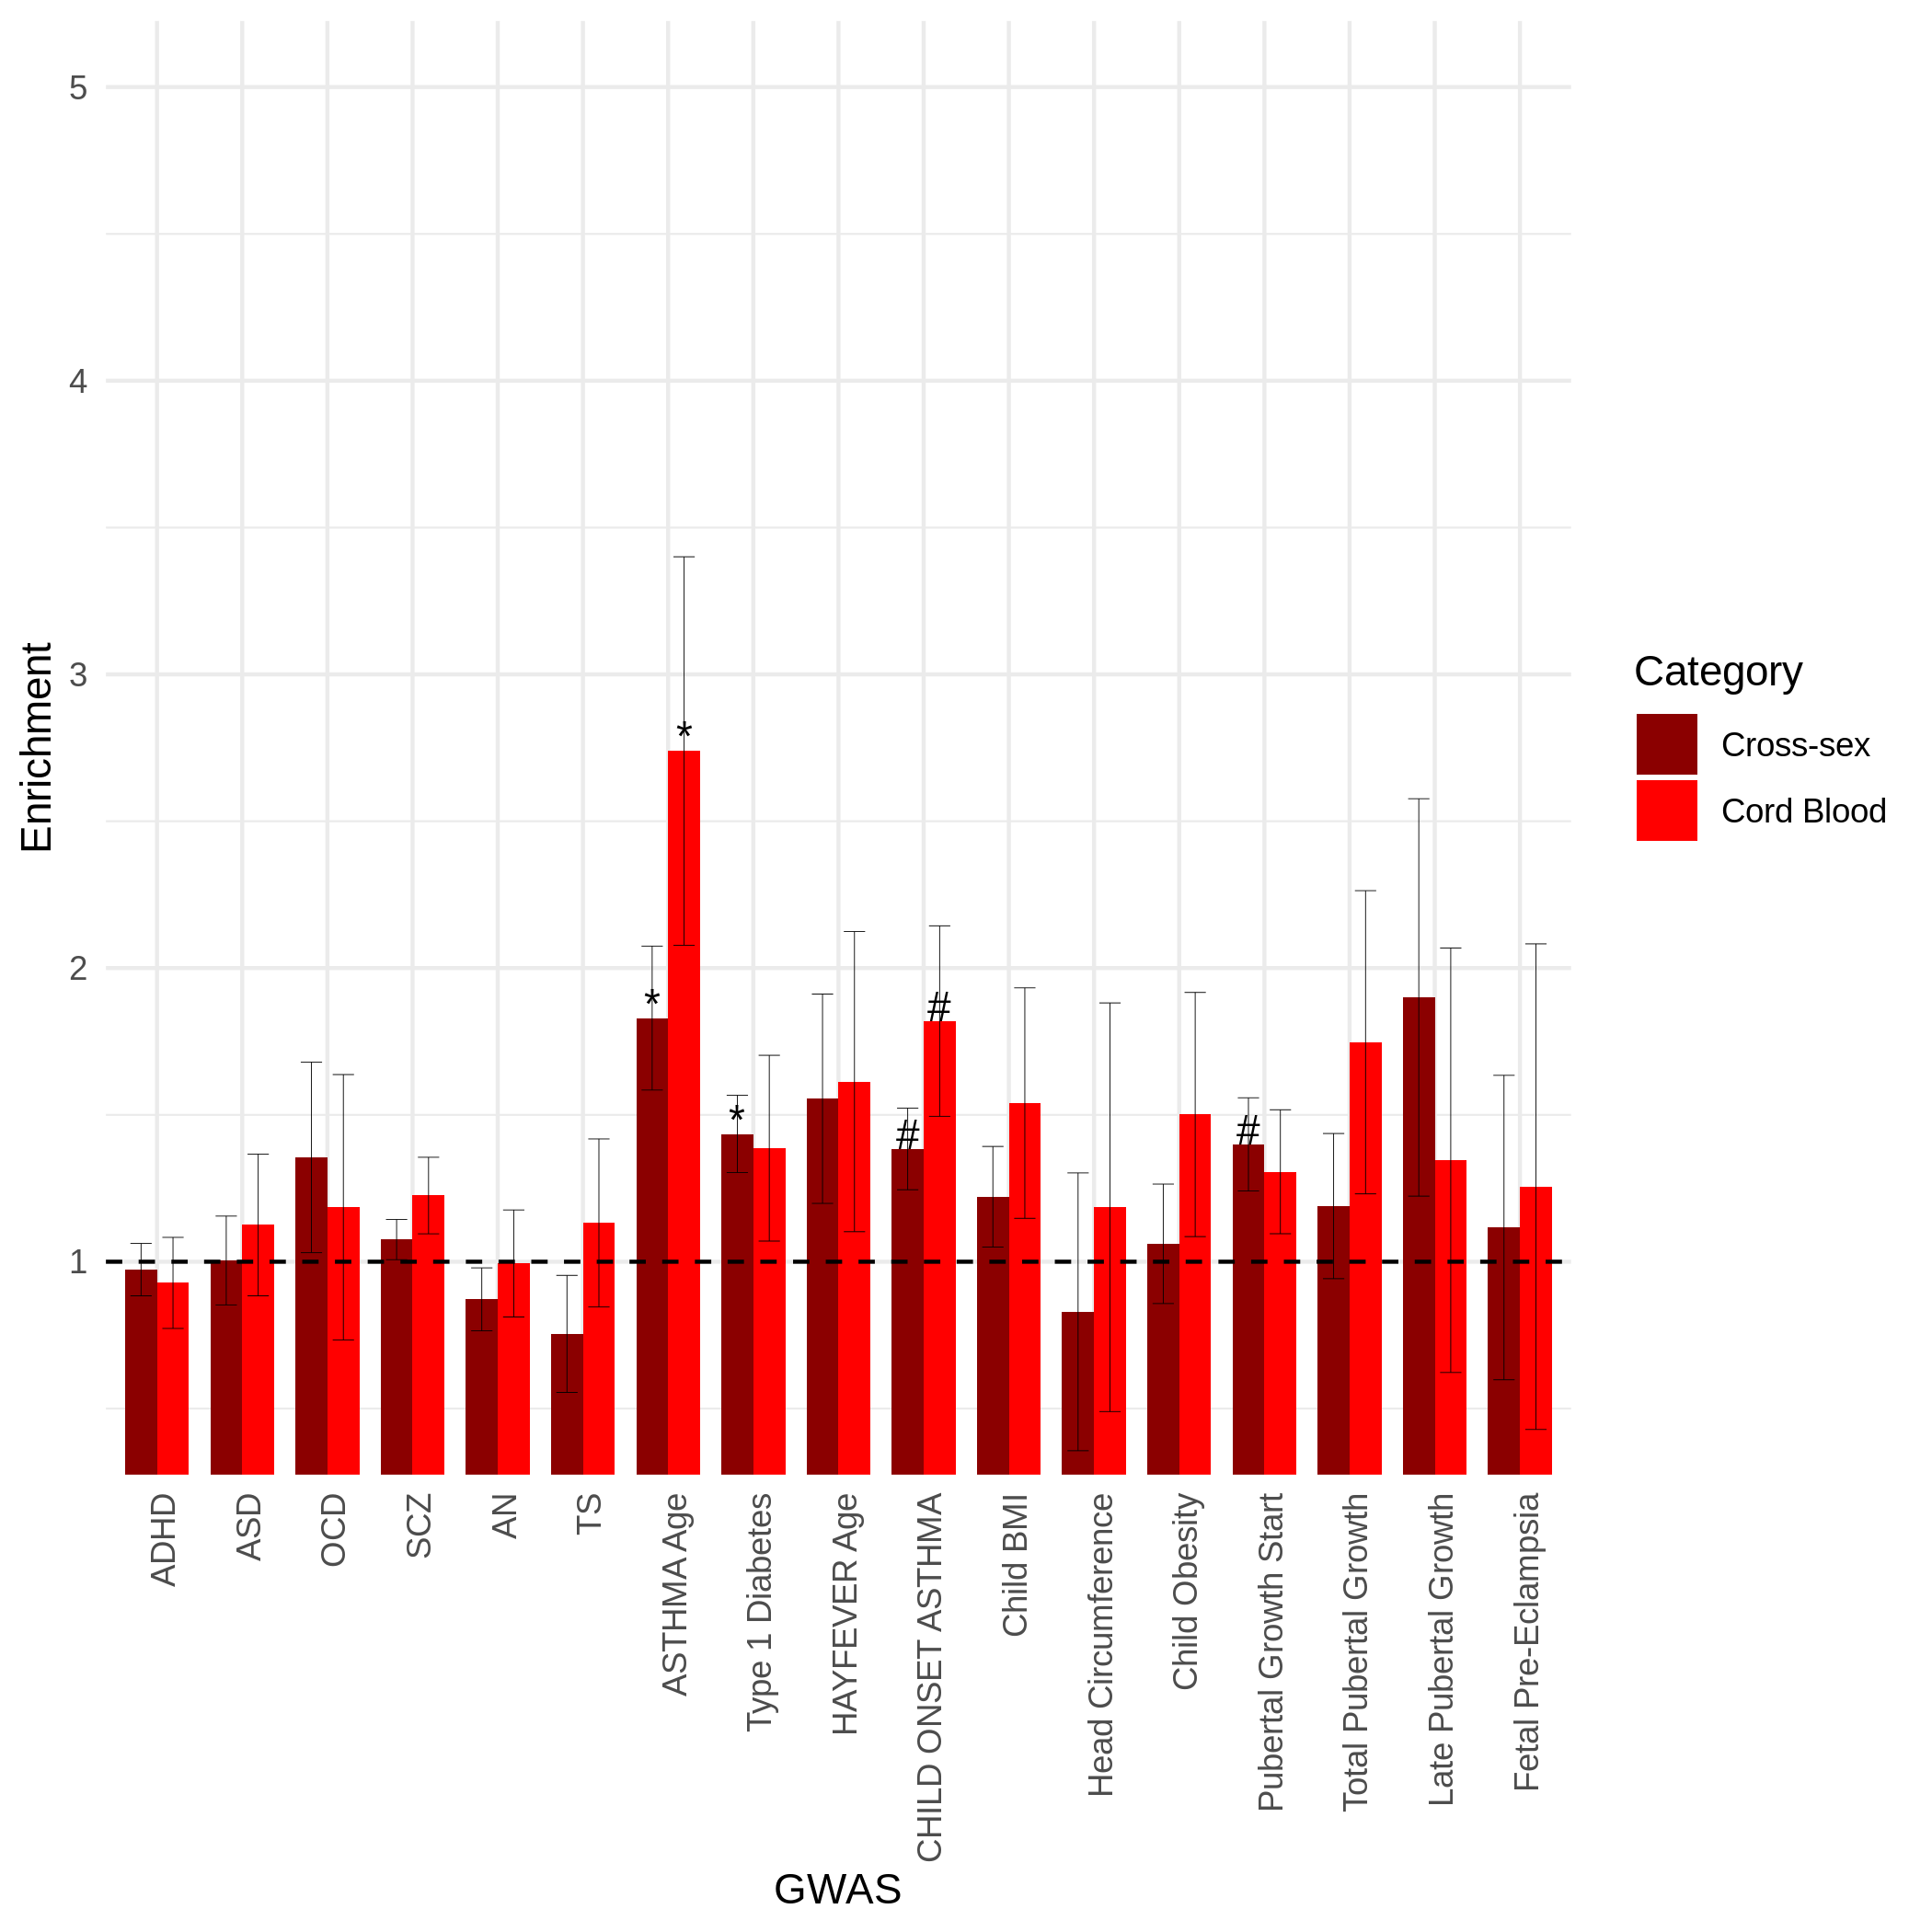

In [9]:
filtered <- combined_df[
        grepl("Cross-sex|Cord Blood",Category) &
        !grepl("Male|Female",GWAS) 
]

to_plot <- filtered[,
    .(
        GWAS = factor(GWAS,levels = sex_order),
        Enrichment,
        Category=factor(Category,levels=c("Cross-sex","Cord Blood")),
        Enrichment_std_error,
        Enrichment_p,
        sig_enrich = p.adjust(Enrichment_p,method="BH") <0.05,
        GWAS_group = ifelse(GWAS %in% pgc_GWAS_key,"Neuropsychiatric","Neonatal"),
        h2,
        h2_std_error
    )
]
to_plot[,`:=`(sig_enrich_GWAS = p.adjust(Enrichment_p,method="BH") < 0.05),by="GWAS"]
ggplot(
    to_plot,
    aes(
        GWAS,
        Enrichment,
        fill = Category,
        #color=GWAS_group,
        label=ifelse(sig_enrich,"*",ifelse(sig_enrich_GWAS,"#","")),
        ymin= Enrichment - Enrichment_std_error,
        ymax=Enrichment + Enrichment_std_error
    )
)+
    geom_text(color="black",position=position_dodge(width=0.75),vjust=0)+
    geom_col(position=position_dodge(width=0.75),width=0.75)+
    geom_errorbar(width=0.5,size=0.1,position=position_dodge(width=0.75)) + 
    coord_cartesian(ylim = c(0.5,5))+
    geom_hline(yintercept = 1,linetype="dashed")+
    scale_fill_manual(values=c("dark red","red"))+
    #scale_color_manual(values=c("purple","dark green"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=90,hjust=1,vjust=0.75))
to_plot[, `:=`(h2_z = h2 /h2_std_error)]
to_plot

GWAS                 
1  OCD                  
2  SCZ                  
3  ADHD                 
4  ASD                  
5  SCZ                  
6  ADHD                 
7  Pubertal Growth Start
8  Total Pubertal Growth
9  ASTHMA Age           
10 HAYFEVER Age         
11 Pubertal Growth Start
12 Total Pubertal Growth
13 Late Pubertal Growth 
14 ASTHMA Age           
   Enrichment
1  2.8774961 
2  0.9648293 
3  0.1387941 
4  1.0940519 
5  1.0509379 
6  0.5670874 
7  1.7120936 
8  0.9623609 
9  3.1625222 
10 3.4953932 
11 3.0307177 
12 0.9611517 
13 3.1395664 
14 0.8065974 
   Category       
1  Female Specific
2  Female Specific
3  Female Specific
4  Male Specific  
5  Male Specific  
6  Male Specific  
7  Female Specific
8  Female Specific
9  Female Specific
10 Female Specific
11 Male Specific  
12 Male Specific  
13 Male Specific  
14 Male Specific  
   Enrichment_std_error
1  1.3744031           
2  0.2980944           
3  1.3982420           
4  0.4005551           
5  0.2046074           
6  0.3643093           
7  0.6879460           
8  0.9827564           
9  1.4366369           
10 1.7629589           
11 1.1967387           
12 1.3306206           
13 1.1944027           
14 0.9664502           
   Enrichment_p
1  0.11979292  
2  0.90613160  
3  0.53100508  
4  0.81400090  
5  0.80350069  
6  0.23814592  
7  0.30772726  
8  0.96950127  
9  0.12817660  
10 0.14223261  
11 0.05695491  
12 0.97668871  
13 0.03069701  
14 0.83823849  
   sig_enrich
1  FALSE     
2  FALSE     
3  FALSE     
4  FALSE     
5  FALSE     
6  FALSE     
7  FALSE     
8  FALSE     
9  FALSE     
10 FALSE     
11 FALSE     
12 FALSE     
13 FALSE     
14 FALSE     
   GWAS_group      
1  Neuropsychiatric
2  Neuropsychiatric
3  Neuropsychiatric
4  Neuropsychiatric
5  Neuropsychiatric
6  Neuropsychiatric
7  Neonatal        
8  Neonatal        
9  Neonatal        
10 Neonatal        
11 Neonatal        
12 Neonatal        
13 Neonatal        
14 Neonatal        
   sex    
1  Females
2  Females
3  Females
4  Males  
5  Males  
6  Males  
7  Females
8  Females
9  Females
10 Females
11 Males  
12 Males  
13 Males  
14 Males  
   h2    
1  0.3813
2  0.4686
3  0.1026
4  0.2630
5  0.5956
6  0.2623
7  0.6394
8  0.4624
9  0.1252
10 0.1686
11 0.4630
12 0.4088
13 0.5925
14 0.1869
   h2_std_error
1  0.1663      
2  0.0392      
3  0.0404      
4  0.0372      
5  0.0316      
6  0.0329      
7  0.1331      
8  0.1354      
9  0.0416      
10 0.0720      
11 0.1280      
12 0.1649      
13 0.1866      
14 0.0498      
   sig_enrich_GWAS
1  FALSE          
2  FALSE          
3  FALSE          
4  FALSE          
5  FALSE          
6  FALSE          
7  FALSE          
8  FALSE          
9  FALSE          
10 FALSE          
11 FALSE          
12 FALSE          
13  TRUE          
14 FALSE

GWAS                 
1  OCD                  
2  SCZ                  
3  ADHD                 
4  ASD                  
5  SCZ                  
6  ADHD                 
7  Pubertal Growth Start
8  Total Pubertal Growth
9  ASTHMA Age           
10 HAYFEVER Age         
11 Pubertal Growth Start
12 Total Pubertal Growth
13 Late Pubertal Growth 
14 ASTHMA Age           
   Enrichment
1  1.9332113 
2  0.9655862 
3  0.5932264 
4  1.2634052 
5  1.1634227 
6  1.1198353 
7  1.0502417 
8  1.2973861 
9  1.7803871 
10 1.3263498 
11 1.5844910 
12 0.7939089 
13 1.4407447 
14 1.8442341 
   Category         
1  Female Stratified
2  Female Stratified
3  Female Stratified
4  Male Stratified  
5  Male Stratified  
6  Male Stratified  
7  Female Stratified
8  Female Stratified
9  Female Stratified
10 Female Stratified
11 Male Stratified  
12 Male Stratified  
13 Male Stratified  
14 Male Stratified  
   Enrichment_std_error
1  0.67146650          
2  0.11922328          
3  0.51193267          
4  0.15602765          
5  0.08283846          
6  0.13151256          
7  0.23519617          
8  0.40683396          
9  0.48327769          
10 0.53917911          
11 0.39679210          
12 0.48050059          
13 0.38743115          
14 0.35011221          
   Enrichment_p
1  0.088025855 
2  0.772573452 
3  0.404693174 
4  0.084333079 
5  0.049191197 
6  0.356990342 
7  0.830832730 
8  0.455977175 
9  0.092357907 
10 0.540174352 
11 0.108873304 
12 0.661586285 
13 0.229188736 
14 0.008737559 
   sig_enrich
1  FALSE     
2  FALSE     
3  FALSE     
4  FALSE     
5  FALSE     
6  FALSE     
7  FALSE     
8  FALSE     
9  FALSE     
10 FALSE     
11 FALSE     
12 FALSE     
13 FALSE     
14 FALSE     
   GWAS_group      
1  Neuropsychiatric
2  Neuropsychiatric
3  Neuropsychiatric
4  Neuropsychiatric
5  Neuropsychiatric
6  Neuropsychiatric
7  Neonatal        
8  Neonatal        
9  Neonatal        
10 Neonatal        
11 Neonatal        
12 Neonatal        
13 Neonatal        
14 Neonatal        
   sex    
1  Females
2  Females
3  Females
4  Males  
5  Males  
6  Males  
7  Females
8  Females
9  Females
10 Females
11 Males  
12 Males  
13 Males  
14 Males  
   h2    
1  0.3813
2  0.4686
3  0.1026
4  0.2630
5  0.5956
6  0.2623
7  0.6394
8  0.4624
9  0.1252
10 0.1686
11 0.4630
12 0.4088
13 0.5925
14 0.1869
   h2_std_error
1  0.1663      
2  0.0392      
3  0.0404      
4  0.0372      
5  0.0316      
6  0.0329      
7  0.1331      
8  0.1354      
9  0.0416      
10 0.0720      
11 0.1280      
12 0.1649      
13 0.1866      
14 0.0498      
   sig_enrich_GWAS
1  FALSE          
2  FALSE          
3  FALSE          
4  FALSE          
5  FALSE          
6  FALSE          
7  FALSE          
8  FALSE          
9  FALSE          
10 FALSE          
11 FALSE          
12 FALSE          
13 FALSE          
14  TRUE

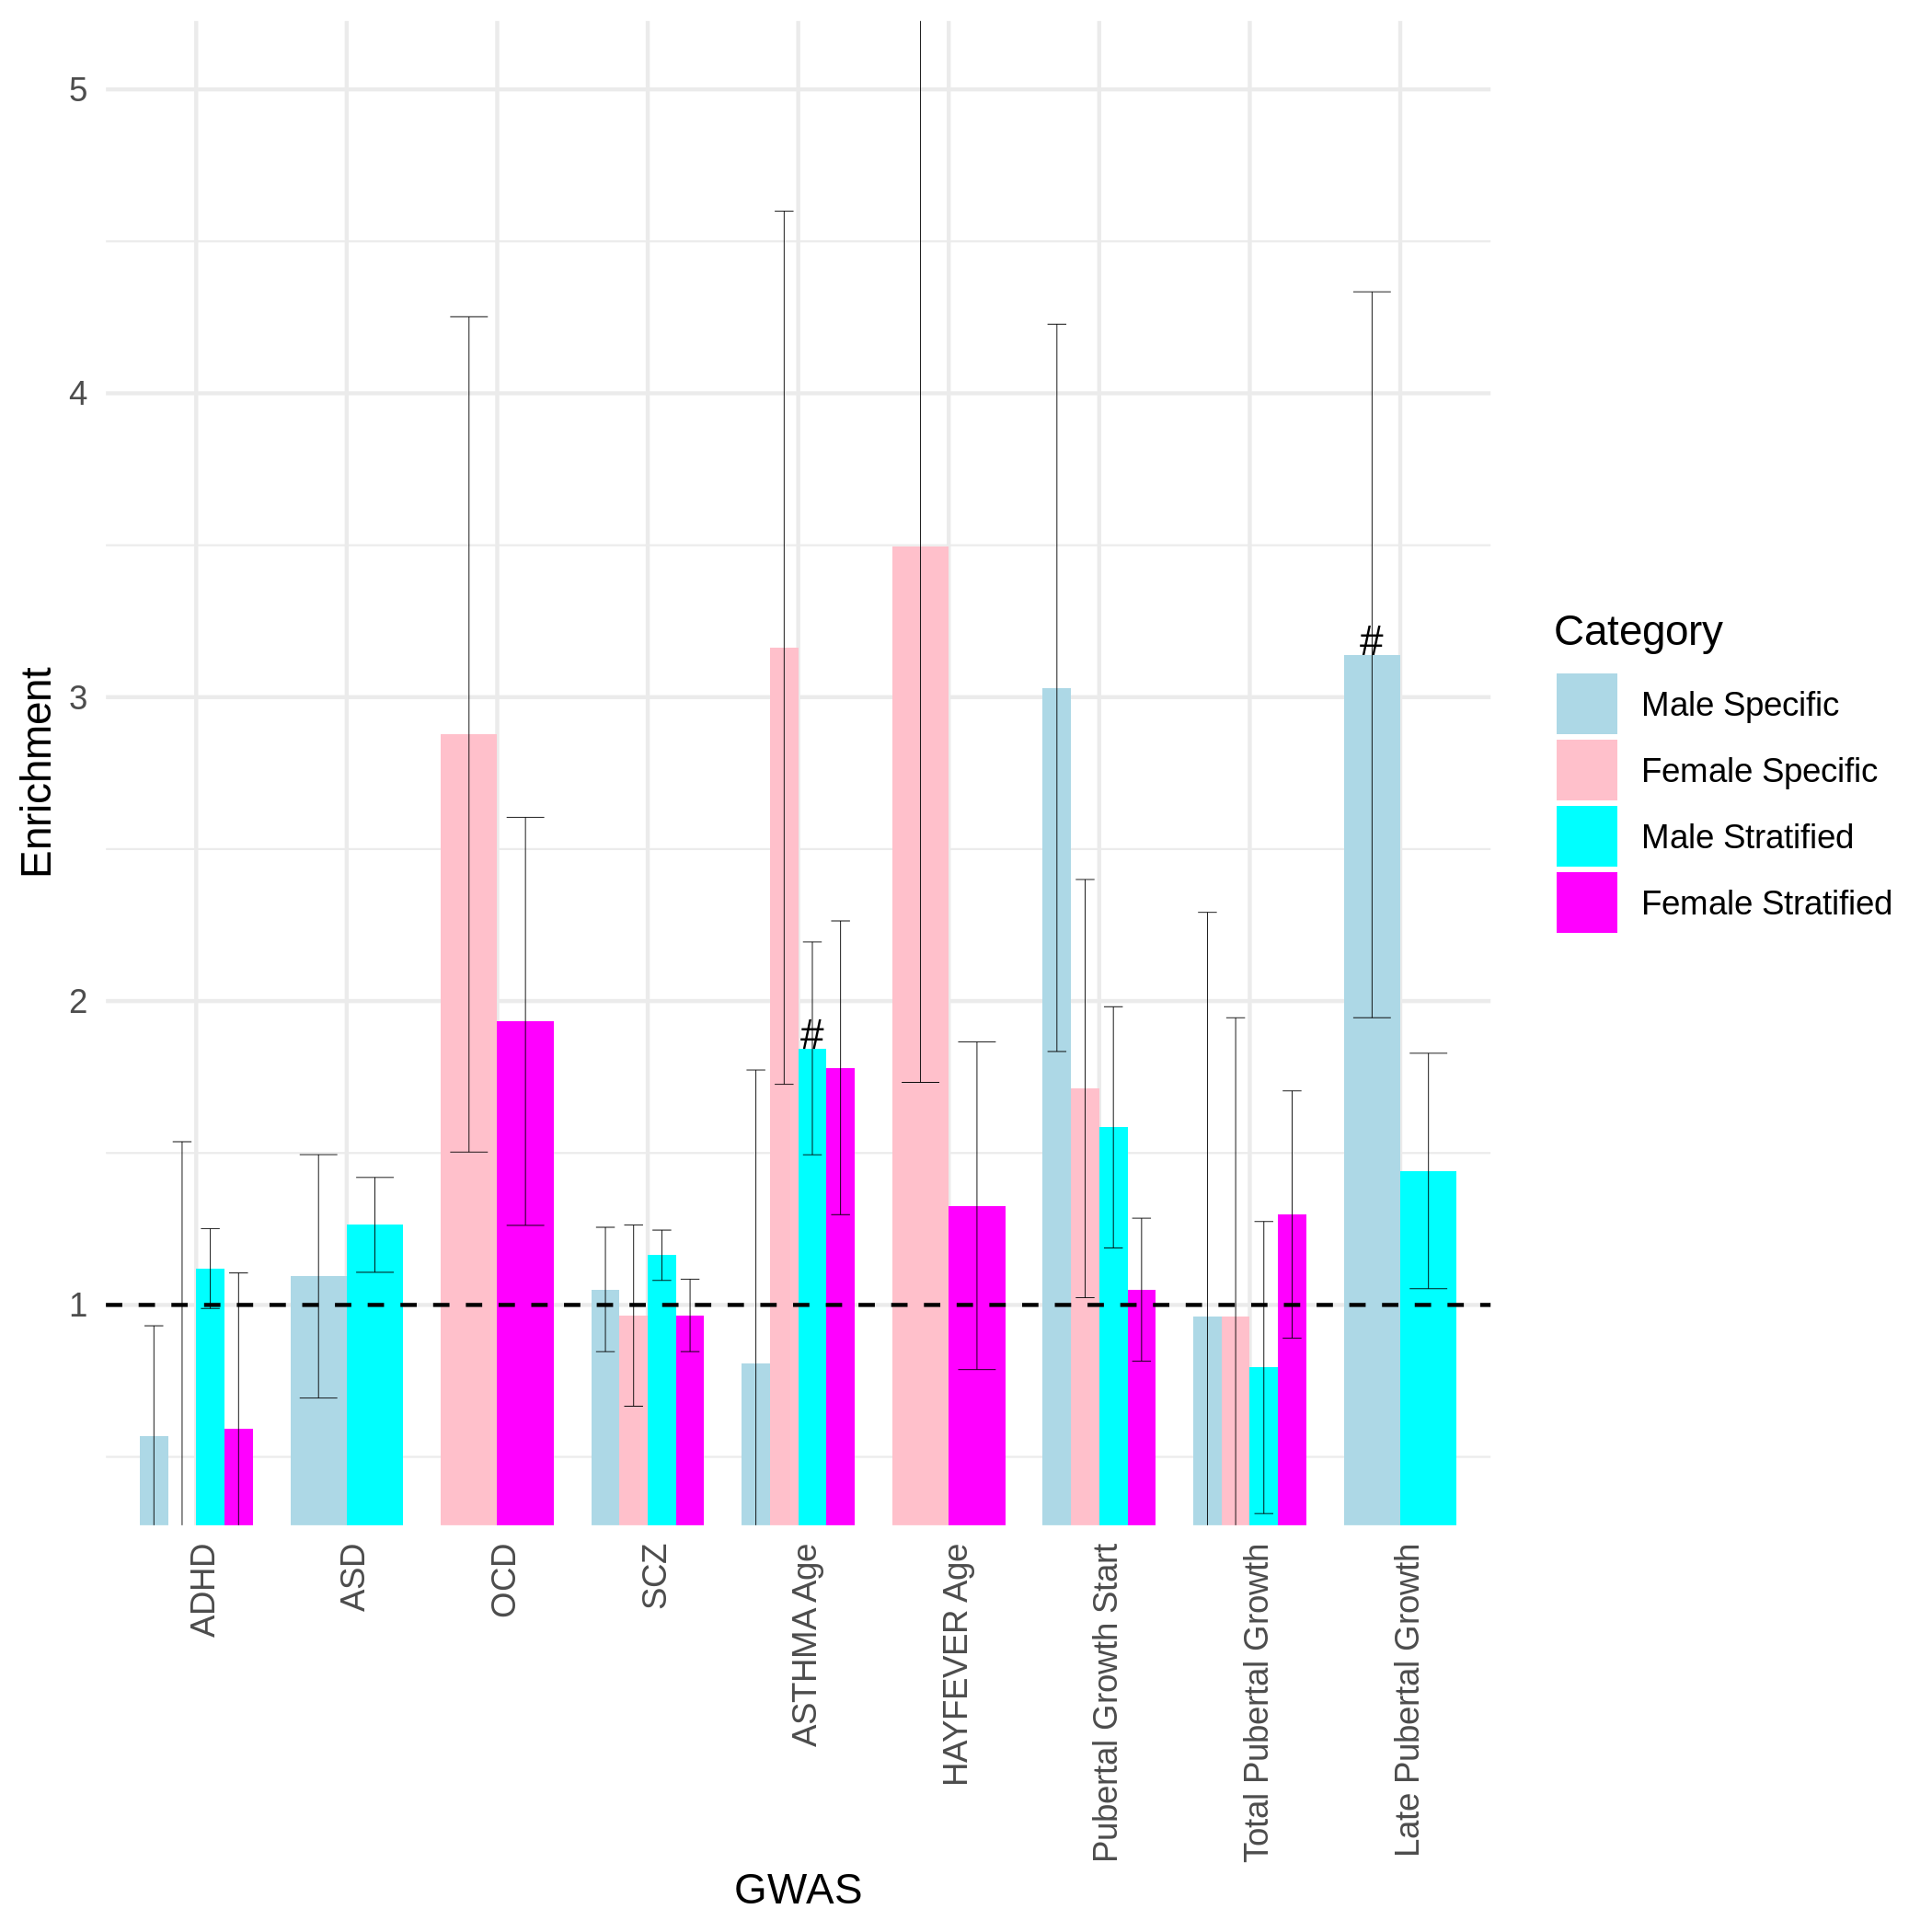

In [11]:
filtered <- combined_df[
(        (grepl("Male Specific",Category) & grepl("Male",GWAS)) | 
        (grepl("Female Specific",Category) & grepl("Female",GWAS)))
]
filtered[,`:=`(GWAS = gsub(" Males| Females","",GWAS),sex = gsub("(.*) (Males|Females)","\\2",GWAS))]

to_plot_specific <- filtered[,
    .(
        GWAS=factor(GWAS,levels = c("RMDD",sex_order)),
        Enrichment,
        Category=factor(Category,levels=c("Male Specific","Female Specific")),
        Enrichment_std_error,
        Enrichment_p,
        sig_enrich = p.adjust(Enrichment_p,method="BH") <0.05,
        GWAS_group = ifelse(GWAS %in% pgc_GWAS_key,"Neuropsychiatric","Neonatal"),
        sex,
                h2,
        h2_std_error
    )
]
to_plot_specific[,`:=`(sig_enrich_GWAS = p.adjust(Enrichment_p,method="BH") < 0.05),by="GWAS"]
filtered <- combined_df[
(        (grepl("Male Stratified",Category) & grepl("Male",GWAS)) | 
        (grepl("Female Stratified",Category) & grepl("Female",GWAS)))
]
filtered[,`:=`(GWAS = gsub(" Males| Females","",GWAS),sex = gsub("(.*) (Males|Females)","\\2",GWAS))]

to_plot_stratified <- filtered[,
    .(
        GWAS=factor(GWAS,levels = c("RMDD",sex_order)),
        Enrichment,
        Category=factor(Category,levels=c("Male Stratified","Female Stratified")),
        Enrichment_std_error,
        Enrichment_p,
        sig_enrich = p.adjust(Enrichment_p,method="BH") <0.05,
        GWAS_group = ifelse(GWAS %in% pgc_GWAS_key,"Neuropsychiatric","Neonatal"),
        sex,
                h2,
        h2_std_error
    )
]
to_plot_stratified[,`:=`(sig_enrich_GWAS = p.adjust(Enrichment_p,method="BH") < 0.05),by="GWAS"]

to_plot_specific
to_plot_stratified
ggplot(
    rbind(to_plot_specific,to_plot_stratified),
    aes(
        GWAS,
        Enrichment,
        fill = Category,
        #color=GWAS_group,
        label=ifelse(sig_enrich,"*",ifelse(sig_enrich_GWAS,"#","")),
        ymin= Enrichment - Enrichment_std_error,
        ymax=Enrichment + Enrichment_std_error
    )
)+
    geom_text(color="black",position=position_dodge(width=0.75),vjust=0)+
    geom_col(position=position_dodge(width=0.75),width=0.75)+
    geom_errorbar(width=0.5,size=0.1,position=position_dodge(width=0.75)) + 
    coord_cartesian(ylim = c(0.5,5))+
    geom_hline(yintercept = 1,linetype="dashed")+
    scale_fill_manual(values=c("light blue","pink","cyan","magenta"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=90,hjust=1,vjust=0.75))

GWAS                  
1  Fetal Pre-Eclampsia   
2  Fetal Pre-Eclampsia   
3  Fetal Pre-Eclampsia   
4  Fetal Pre-Eclampsia   
5  Fetal Pre-Eclampsia   
6  Fetal Pre-Eclampsia   
7  Maternal Pre-Eclampsia
8  Maternal Pre-Eclampsia
9  Maternal Pre-Eclampsia
10 Maternal Pre-Eclampsia
11 Maternal Pre-Eclampsia
12 Maternal Pre-Eclampsia
   annotation 
1  bin_CPP_her
2  bin_CPP_her
3  bin_CPP_her
4  bin_CPP_her
5  bin_CPP_her
6  bin_CPP_her
7  bin_CPP_her
8  bin_CPP_her
9  bin_CPP_her
10 bin_CPP_her
11 bin_CPP_her
12 bin_CPP_her
   Prop._SNPs
1  0.11245598
2  0.27748211
3  0.09232533
4  0.29167365
5  0.08669942
6  0.31561413
7  0.11245598
8  0.27748211
9  0.09232533
10 0.29167365
11 0.08669942
12 0.31561413
   Prop._h2  
1  0.14120549
2  0.35770115
3  0.21596517
4  0.29325723
5  0.07352620
6  0.35236918
7  0.06304529
8  0.41082885
9  0.14787883
10 0.39897017
11 0.10418788
12 0.39577002
   Prop._h2_std_error
1  0.09298205        
2  0.16656176        
3  0.15040953        
4  0.15619450        
5  0.13125059        
6  0.16358940        
7  0.09955232        
8  0.21881304        
9  0.12926263        
10 0.21900742        
11 0.11755621        
12 0.22938847        
   Enrichment
1  1.2556512 
2  1.2890962 
3  2.3391756 
4  1.0054293 
5  0.8480588 
6  1.1164557 
7  0.5606219 
8  1.4805597 
9  1.6017146 
10 1.3678650 
11 1.2017138 
12 1.2539680 
   Enrichment_std_error
1  0.8268306           
2  0.6002613           
3  1.6291252           
4  0.5355112           
5  1.5138578           
6  0.5183209           
7  0.8852558           
8  0.7885663           
9  1.4000775           
10 0.7508646           
11 1.3559054           
12 0.7268004           
   Enrichment_p
1  0.7443960   
2  0.6163178   
3  0.3572995   
4  0.9918389   
5  0.9186710   
6  0.8201260   
7  0.5956289   
8  0.4938843   
9  0.6575308   
10 0.5882685   
11 0.8811406   
12 0.7142831   
   Coefficient  
1   1.524540e-10
2  -2.760939e-11
3   1.035491e-09
4  -4.914728e-10
5  -6.028277e-10
6  -2.896083e-10
7   1.427167e-07
8  -6.149639e-08
9  -6.497238e-08
10 -2.727857e-08
11  2.817931e-08
12 -2.446489e-09
   Coefficient_std_error
1  8.435832e-10         
2  8.564646e-10         
3  1.619313e-09         
4  7.984555e-10         
5  1.606368e-09         
6  8.008220e-10         
7  1.826641e-07         
8  1.855111e-07         
9  2.855038e-07         
10 1.787379e-07         
11 2.762069e-07         
12 1.871456e-07         
   Coefficient_z-score
1   0.18072200        
2  -0.03223647        
3   0.63946302        
4  -0.61552932        
5  -0.37527363        
6  -0.36163877        
7   0.78130677        
8  -0.33149715        
9  -0.22757099        
10 -0.15261768        
11  0.10202249        
12 -0.01307265        
   Coefficient_p
1  0.8565858    
2  0.9742835    
3  0.5225218    
4  0.5382052    
5  0.7074570    
6  0.7176220    
7  0.4346221    
8  0.7402690    
9  0.8199798    
10 0.8786998    
11 0.9187388    
12 0.9895698    
   mQTL_group     
1  cord_mqtl      
2  female         
3  female_specific
4  male           
5  male_specific  
6  marginal       
7  cord_mqtl      
8  female         
9  female_specific
10 male           
11 male_specific  
12 marginal       
   h2     
1   0.0055
2   0.0055
3   0.0055
4   0.0055
5   0.0055
6   0.0055
7  -1.0108
8  -1.0108
9  -1.0108
10 -1.0108
11 -1.0108
12 -1.0108
   h2_std_error
1  0.0028      
2  0.0028      
3  0.0028      
4  0.0028      
5  0.0028      
6  0.0028      
7  0.6609      
8  0.6609      
9  0.6609      
10 0.6609      
11 0.6609      
12 0.6609      
   total_SNP
1  1128053  
2  1128053  
3  1128053  
4  1128053  
5  1128053  
6  1128053  
7     4009  
8     4009  
9     4009  
10    4009  
11    4009  
12    4009  
   significant_coef
1  FALSE           
2  FALSE           
3  FALSE           
4  FALSE           
5  FALSE           
6  FALSE           
7  FALSE           
8  FALSE           
9  FALSE           
10 FALSE           
11 FALSE           
12 FALSE           
   significant_enrich
1  

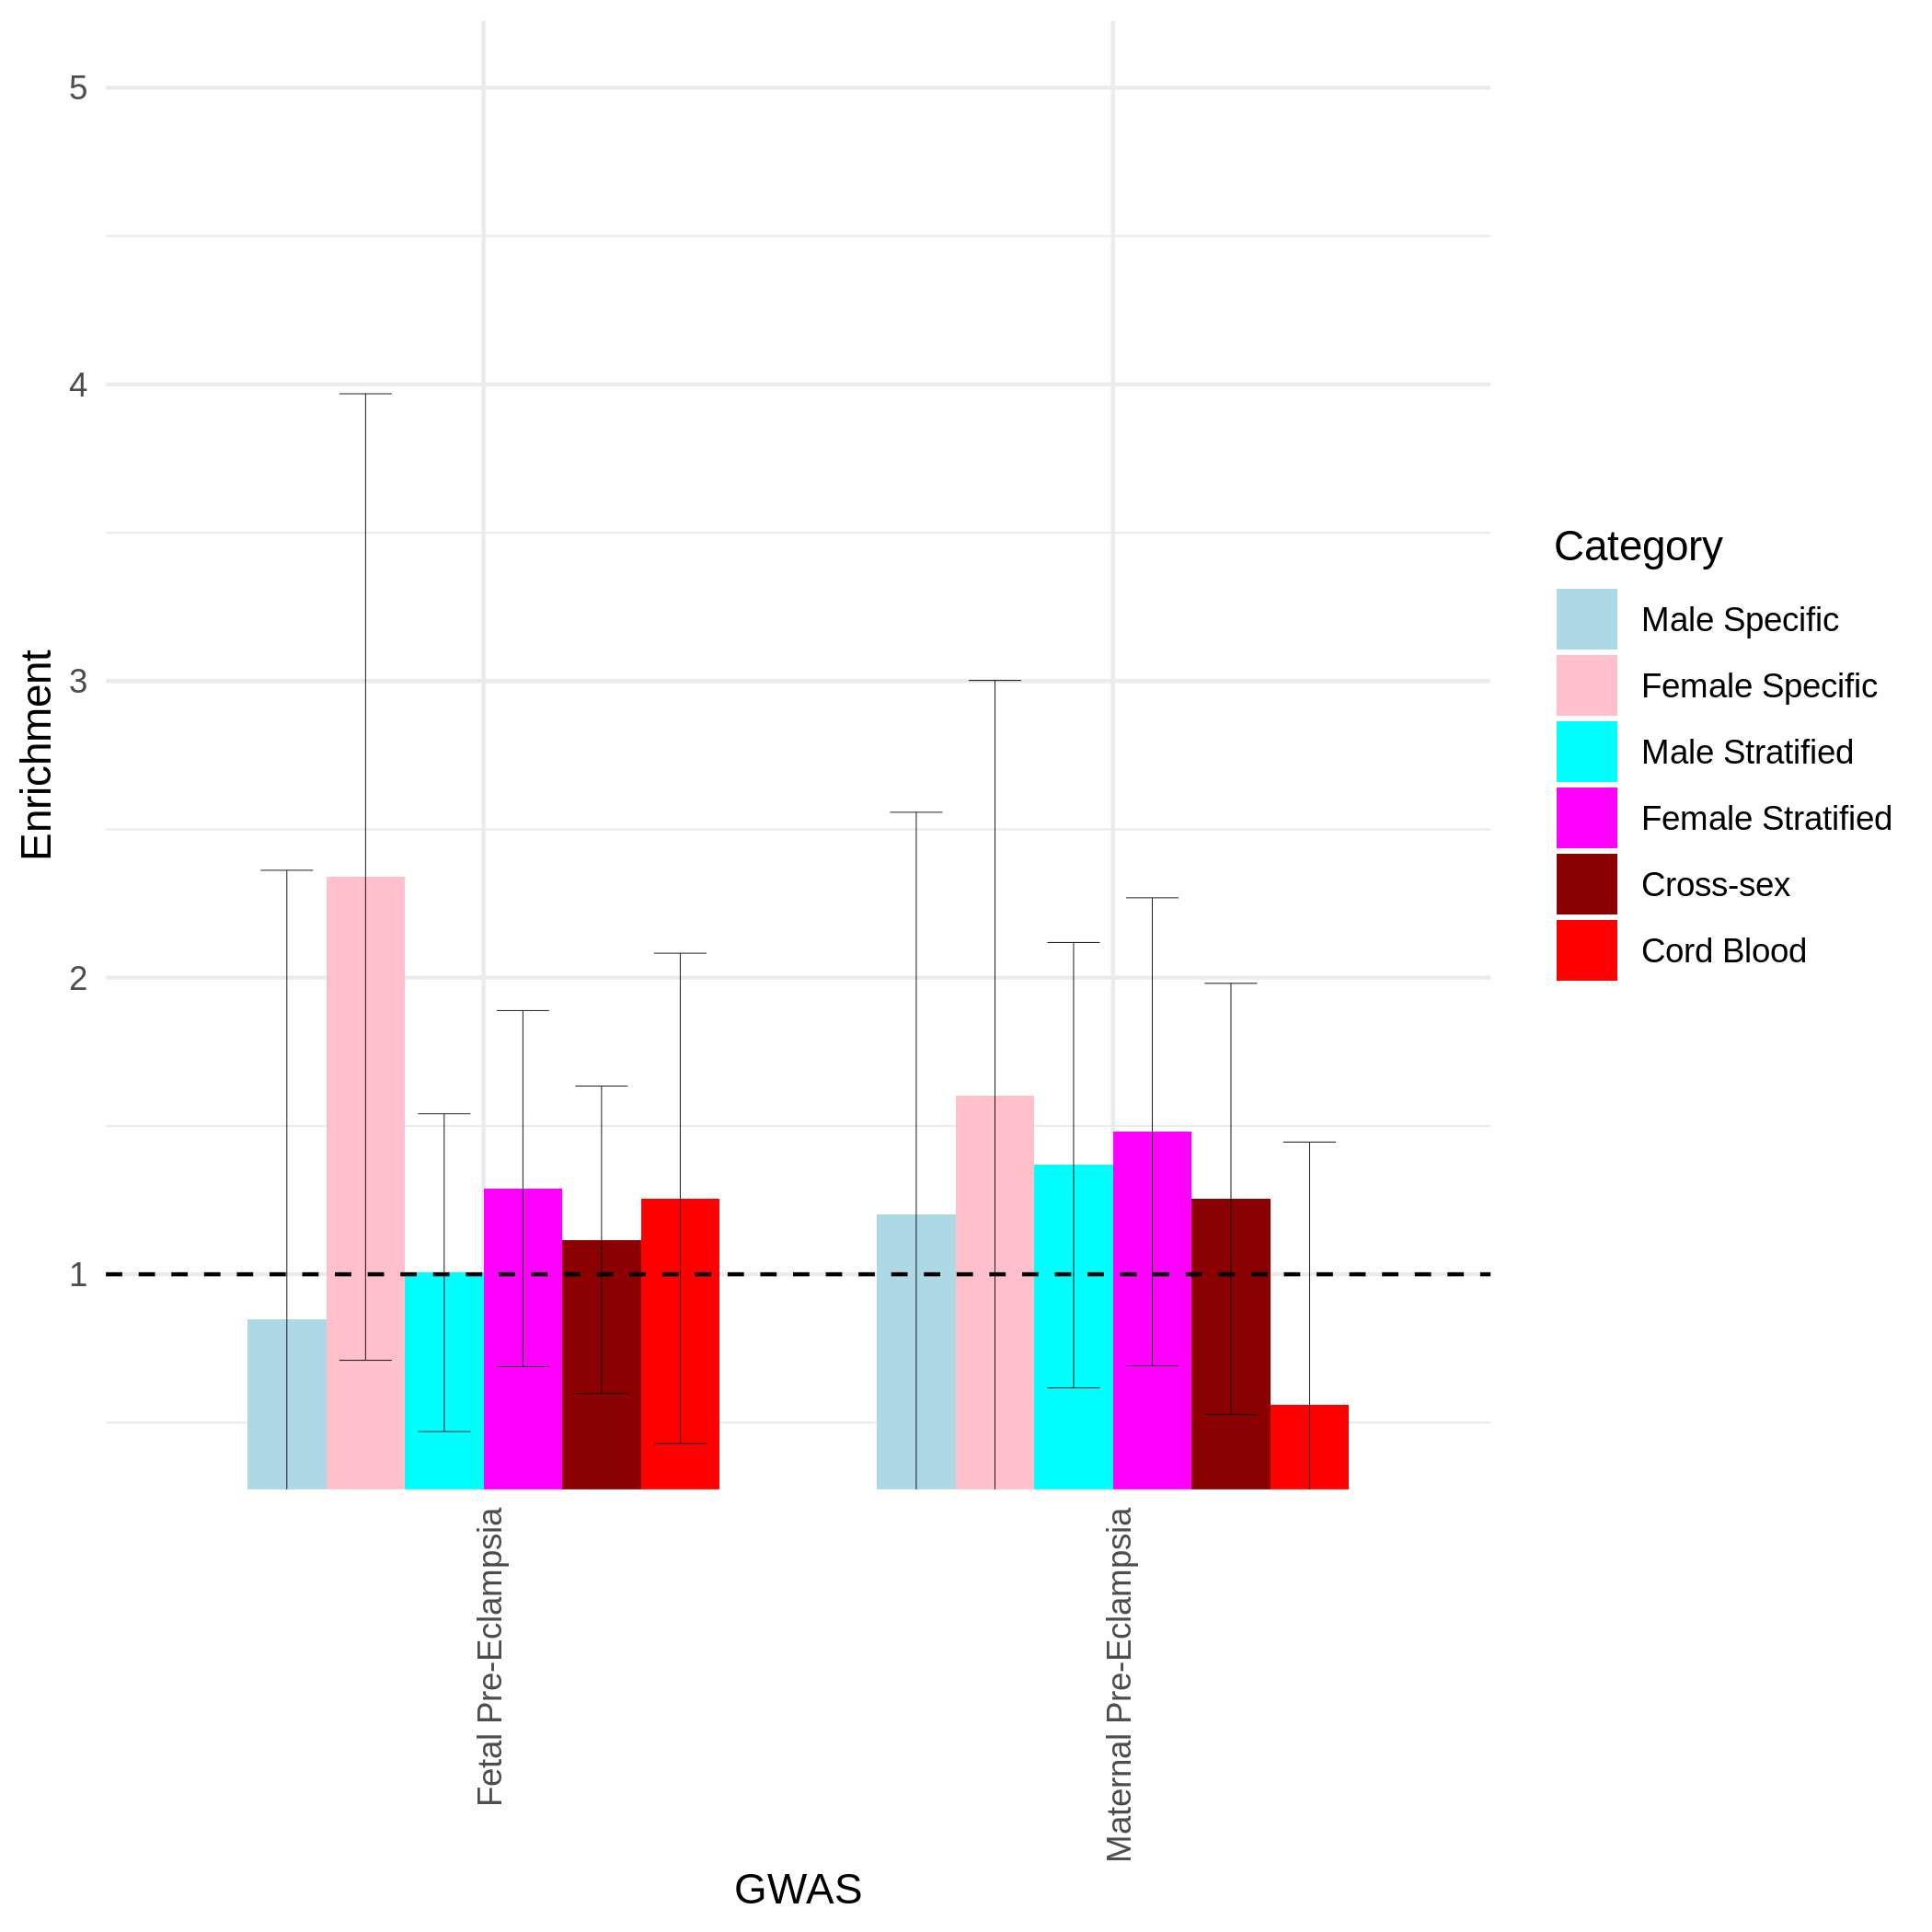

In [13]:
to_plot <- neonatal_part_heritability_independent_df[!grepl("UKBB",GWAS) & grepl("Pre-E",GWAS) & Category != "Sex dependent"]
to_plot$Category <- factor(to_plot$Category, levels =c("Male Specific","Female Specific","Male Stratified", "Female Stratified","Cross-sex", "Cord Blood"))
ggplot(
    to_plot,
    aes(
        GWAS,
        Enrichment,
        fill = Category,
        #color=GWAS_group,
        ymin= Enrichment - Enrichment_std_error,
        ymax=Enrichment + Enrichment_std_error
    )
)+
    geom_col(position=position_dodge(width=0.75),width=0.75)+
    geom_errorbar(width=0.5,size=0.1,position=position_dodge(width=0.75)) + 
    coord_cartesian(ylim = c(0.5,5))+
    geom_hline(yintercept = 1,linetype="dashed")+
    scale_fill_manual(values = c("light blue", "pink","cyan","magenta", "dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=90,hjust=1,vjust=0.75))
to_plot[, `:=`(h2_z = h2 /h2_std_error)]
IRdisplay::display(to_plot)

In [33]:
neonatal_part_heritability_independent_df[grepl("Pre-E",GWAS) & Category == "Cross-sex",.(Category,GWAS,h2_z= h2 / h2_std_error)]

Category 
1 Cross-sex
2 Cross-sex
3 Cross-sex
  GWAS                         
1 Fetal Pre-Eclampsia          
2 Maternal Pre-Eclampsia       
3 Maternal Pre-Eclampsia (UKBB)
  h2_z     
1  1.964286
2 -1.529430
3  1.279070

In [9]:
nrow(combined_df[(h2 / h2_std_error) > 3.29])
0.05 / length(c(pgc_GWAS_key, neonatal_GWAS_key))
5e-4 == 0.0005
-qnorm(5e-4)

ERROR: Error in nrow(combined_df[(h2/h2_std_error) > 3.29]): object 'combined_df' not found


`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed
4 rows
containing
non-finite
values
(stat_smooth).”
Warning message:
“Removed
4 rows
containing
missing
values
(geom_point).”
`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



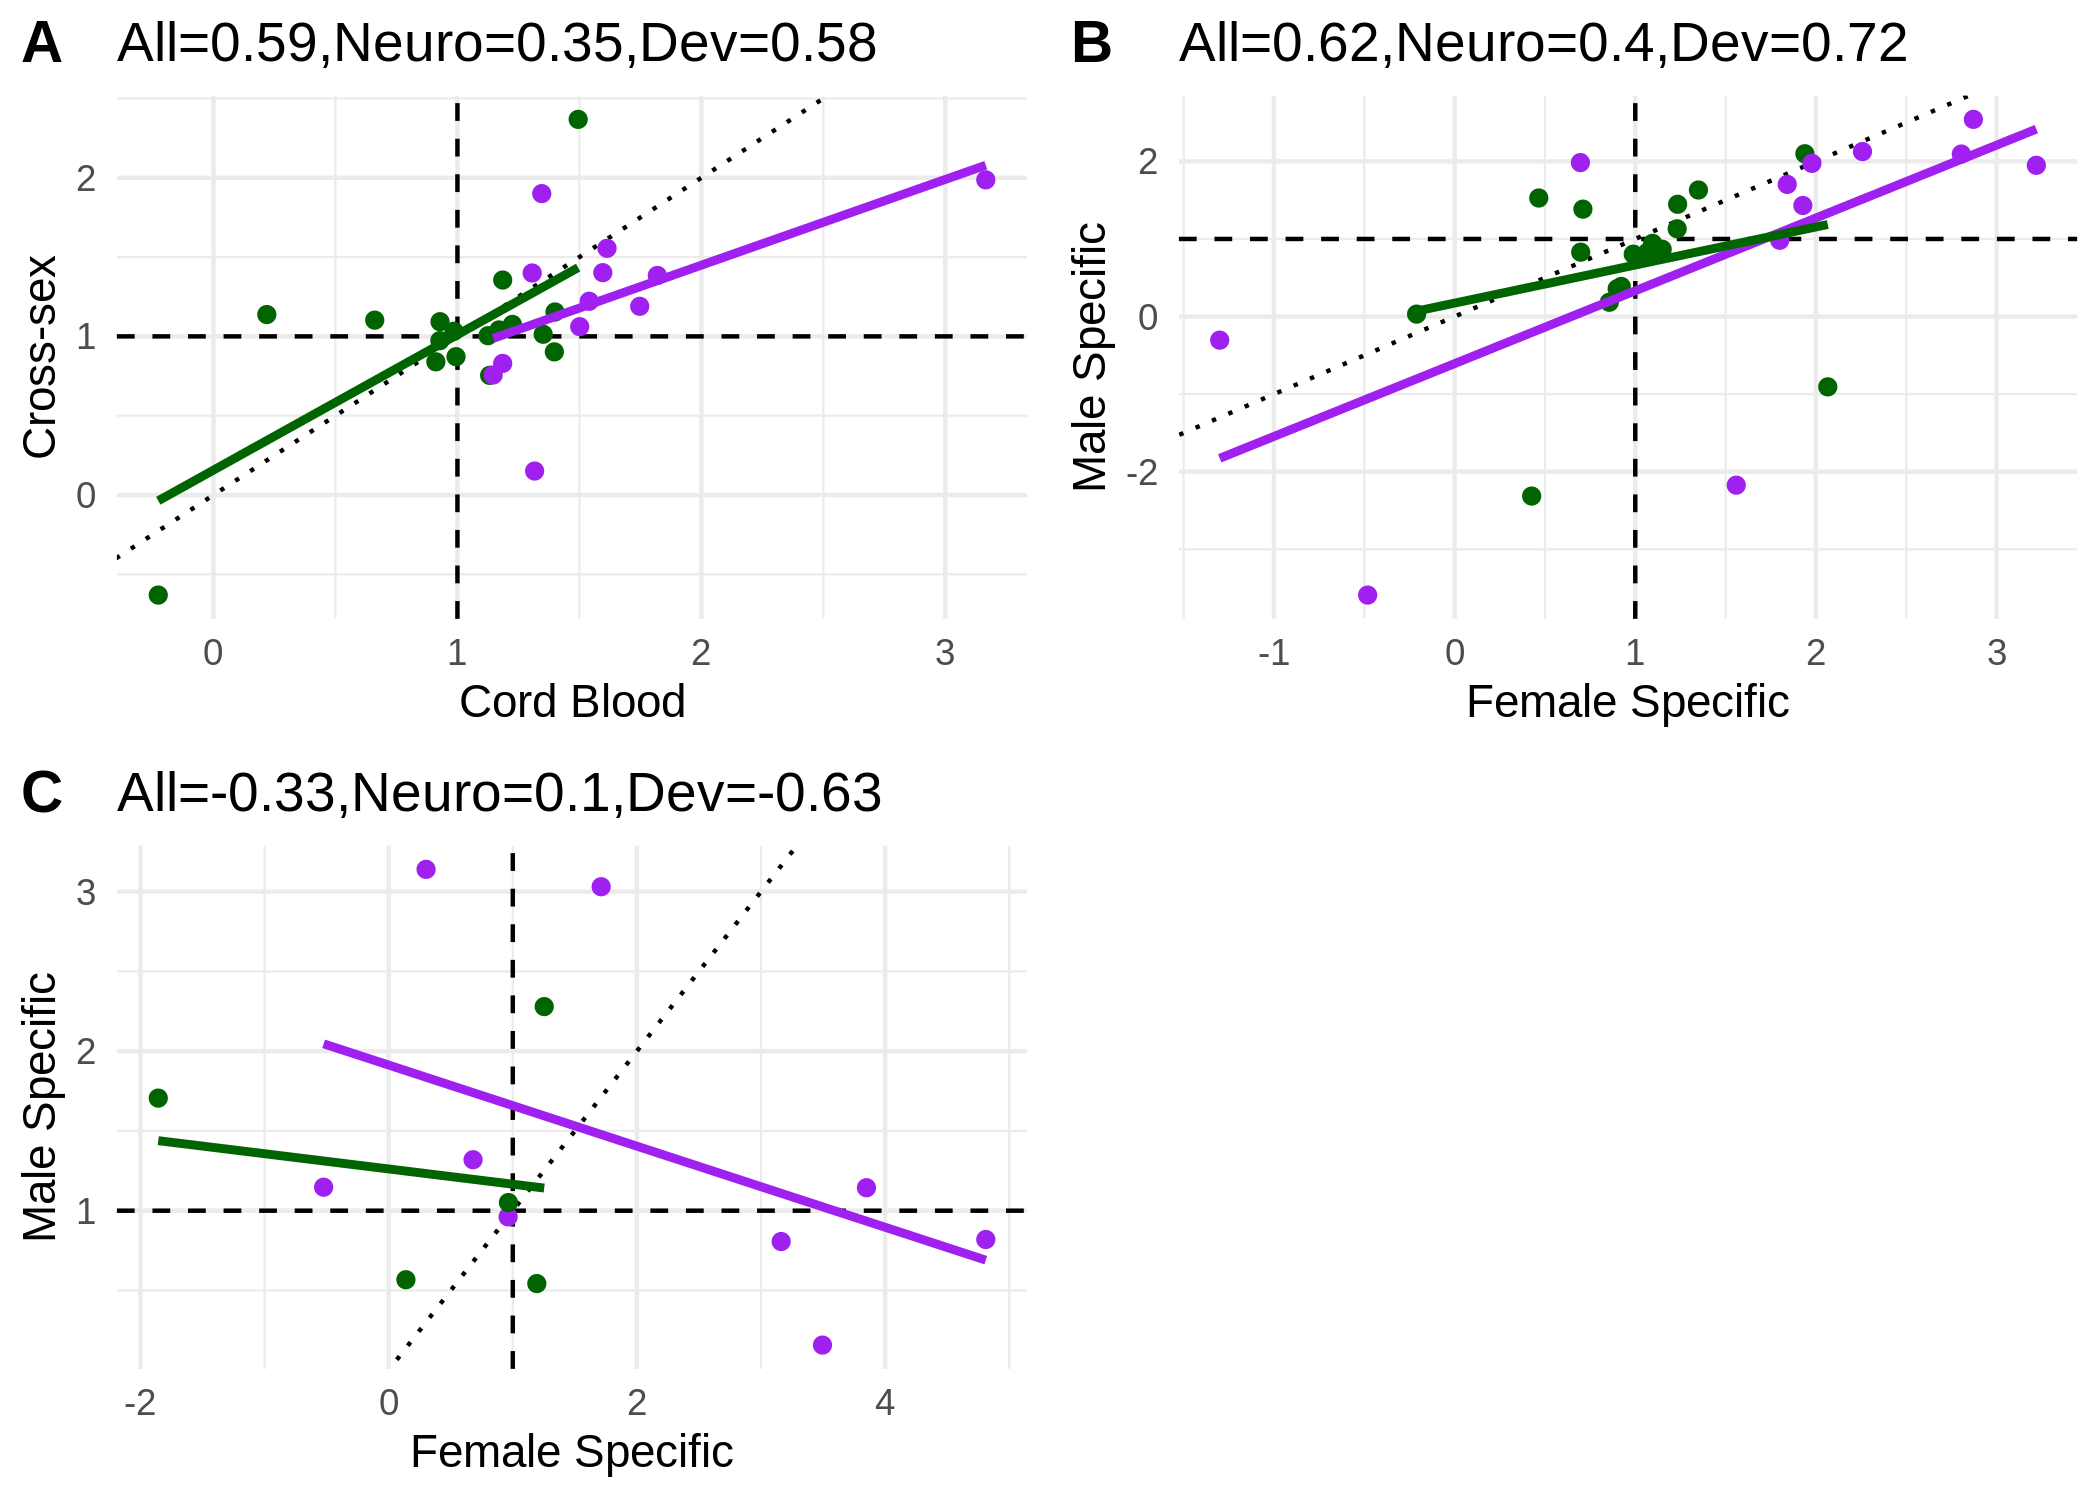

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed
4 rows
containing
non-finite
values
(stat_smooth).”
Warning message:
“Removed
4 rows
containing
missing
values
(geom_point).”
Warning message:
“Removed
4 rows
containing
missing
values
(geom_label_repel).”
Warning message:
“ggrepel: 22 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 17 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


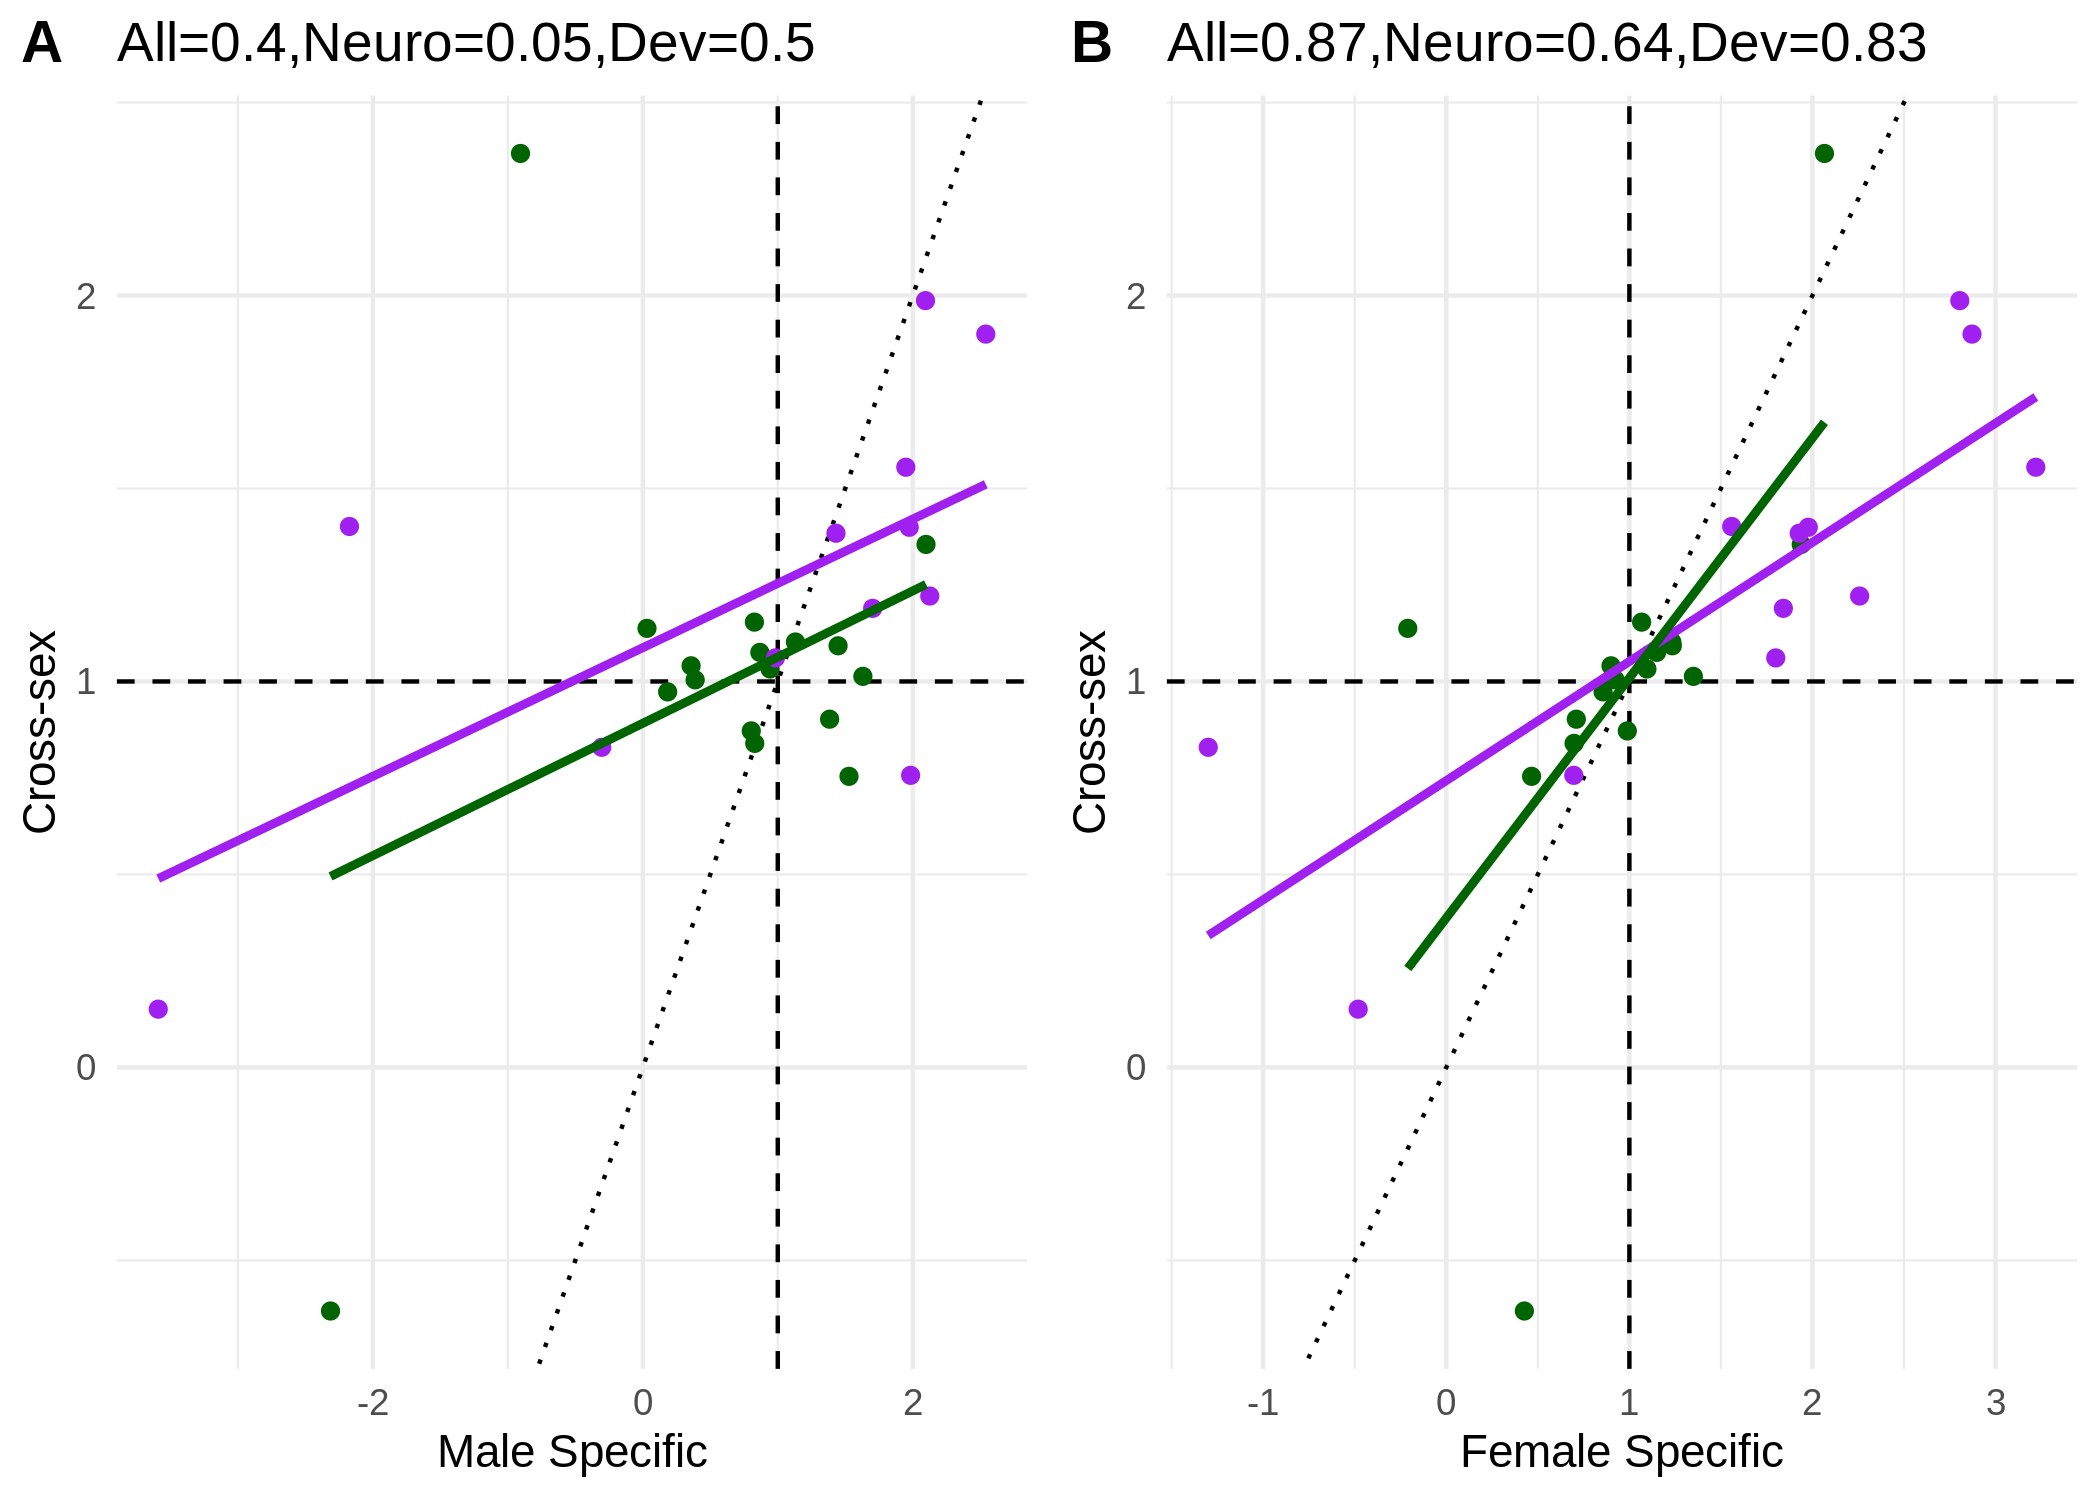

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

Warning message:
“ggrepel: 10 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 11 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


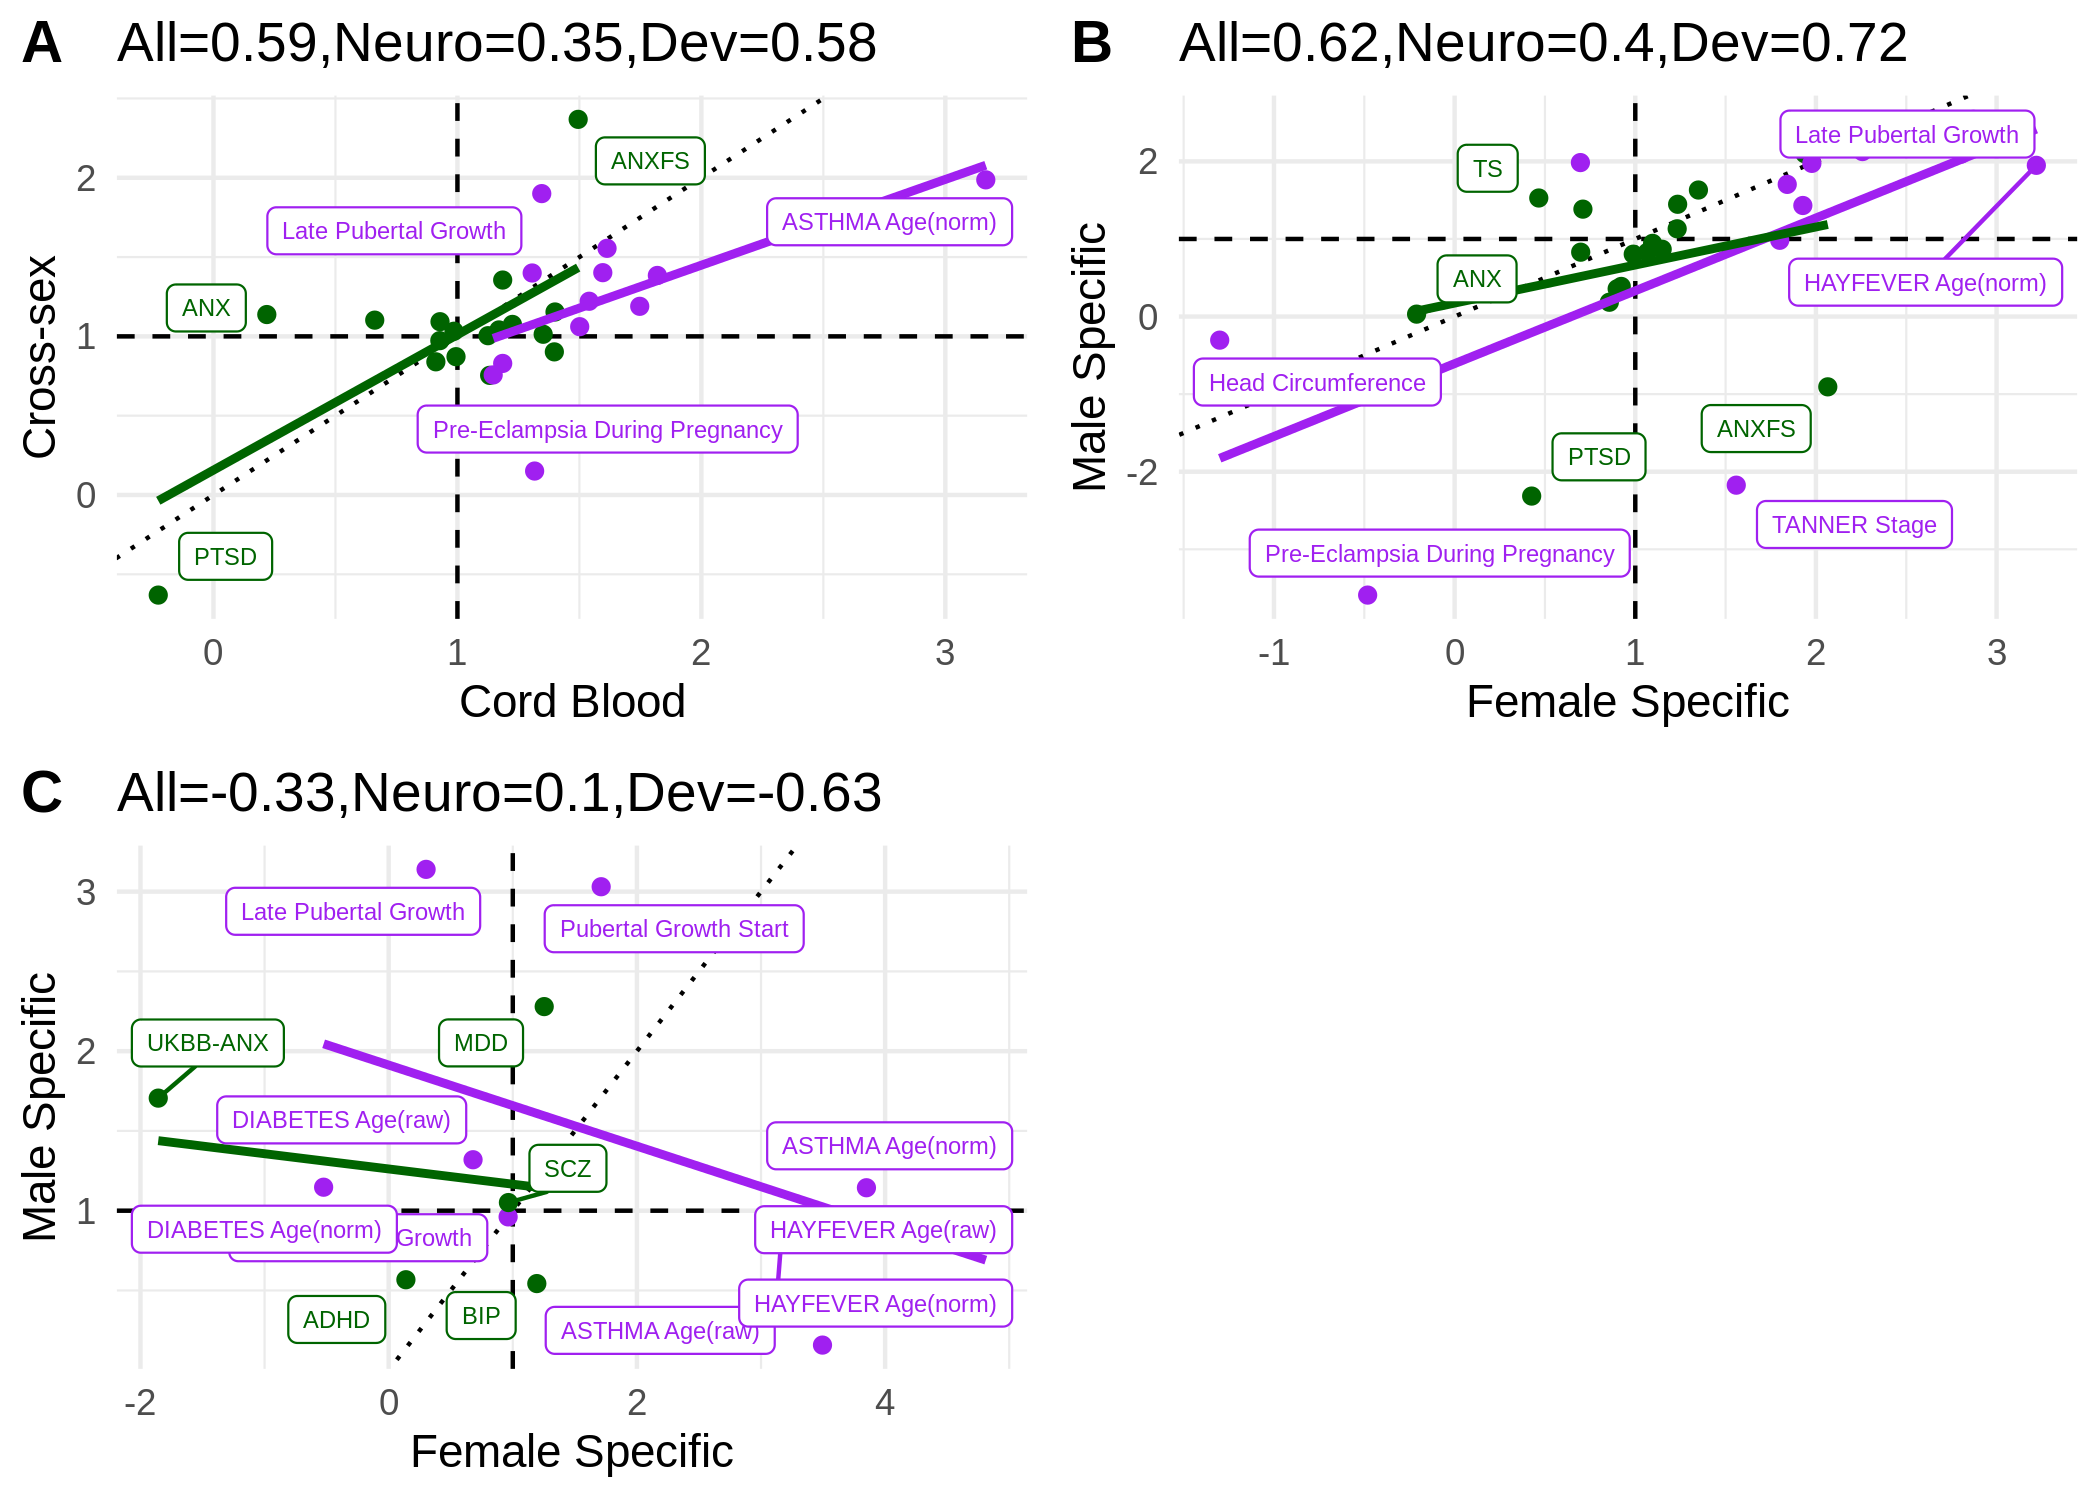

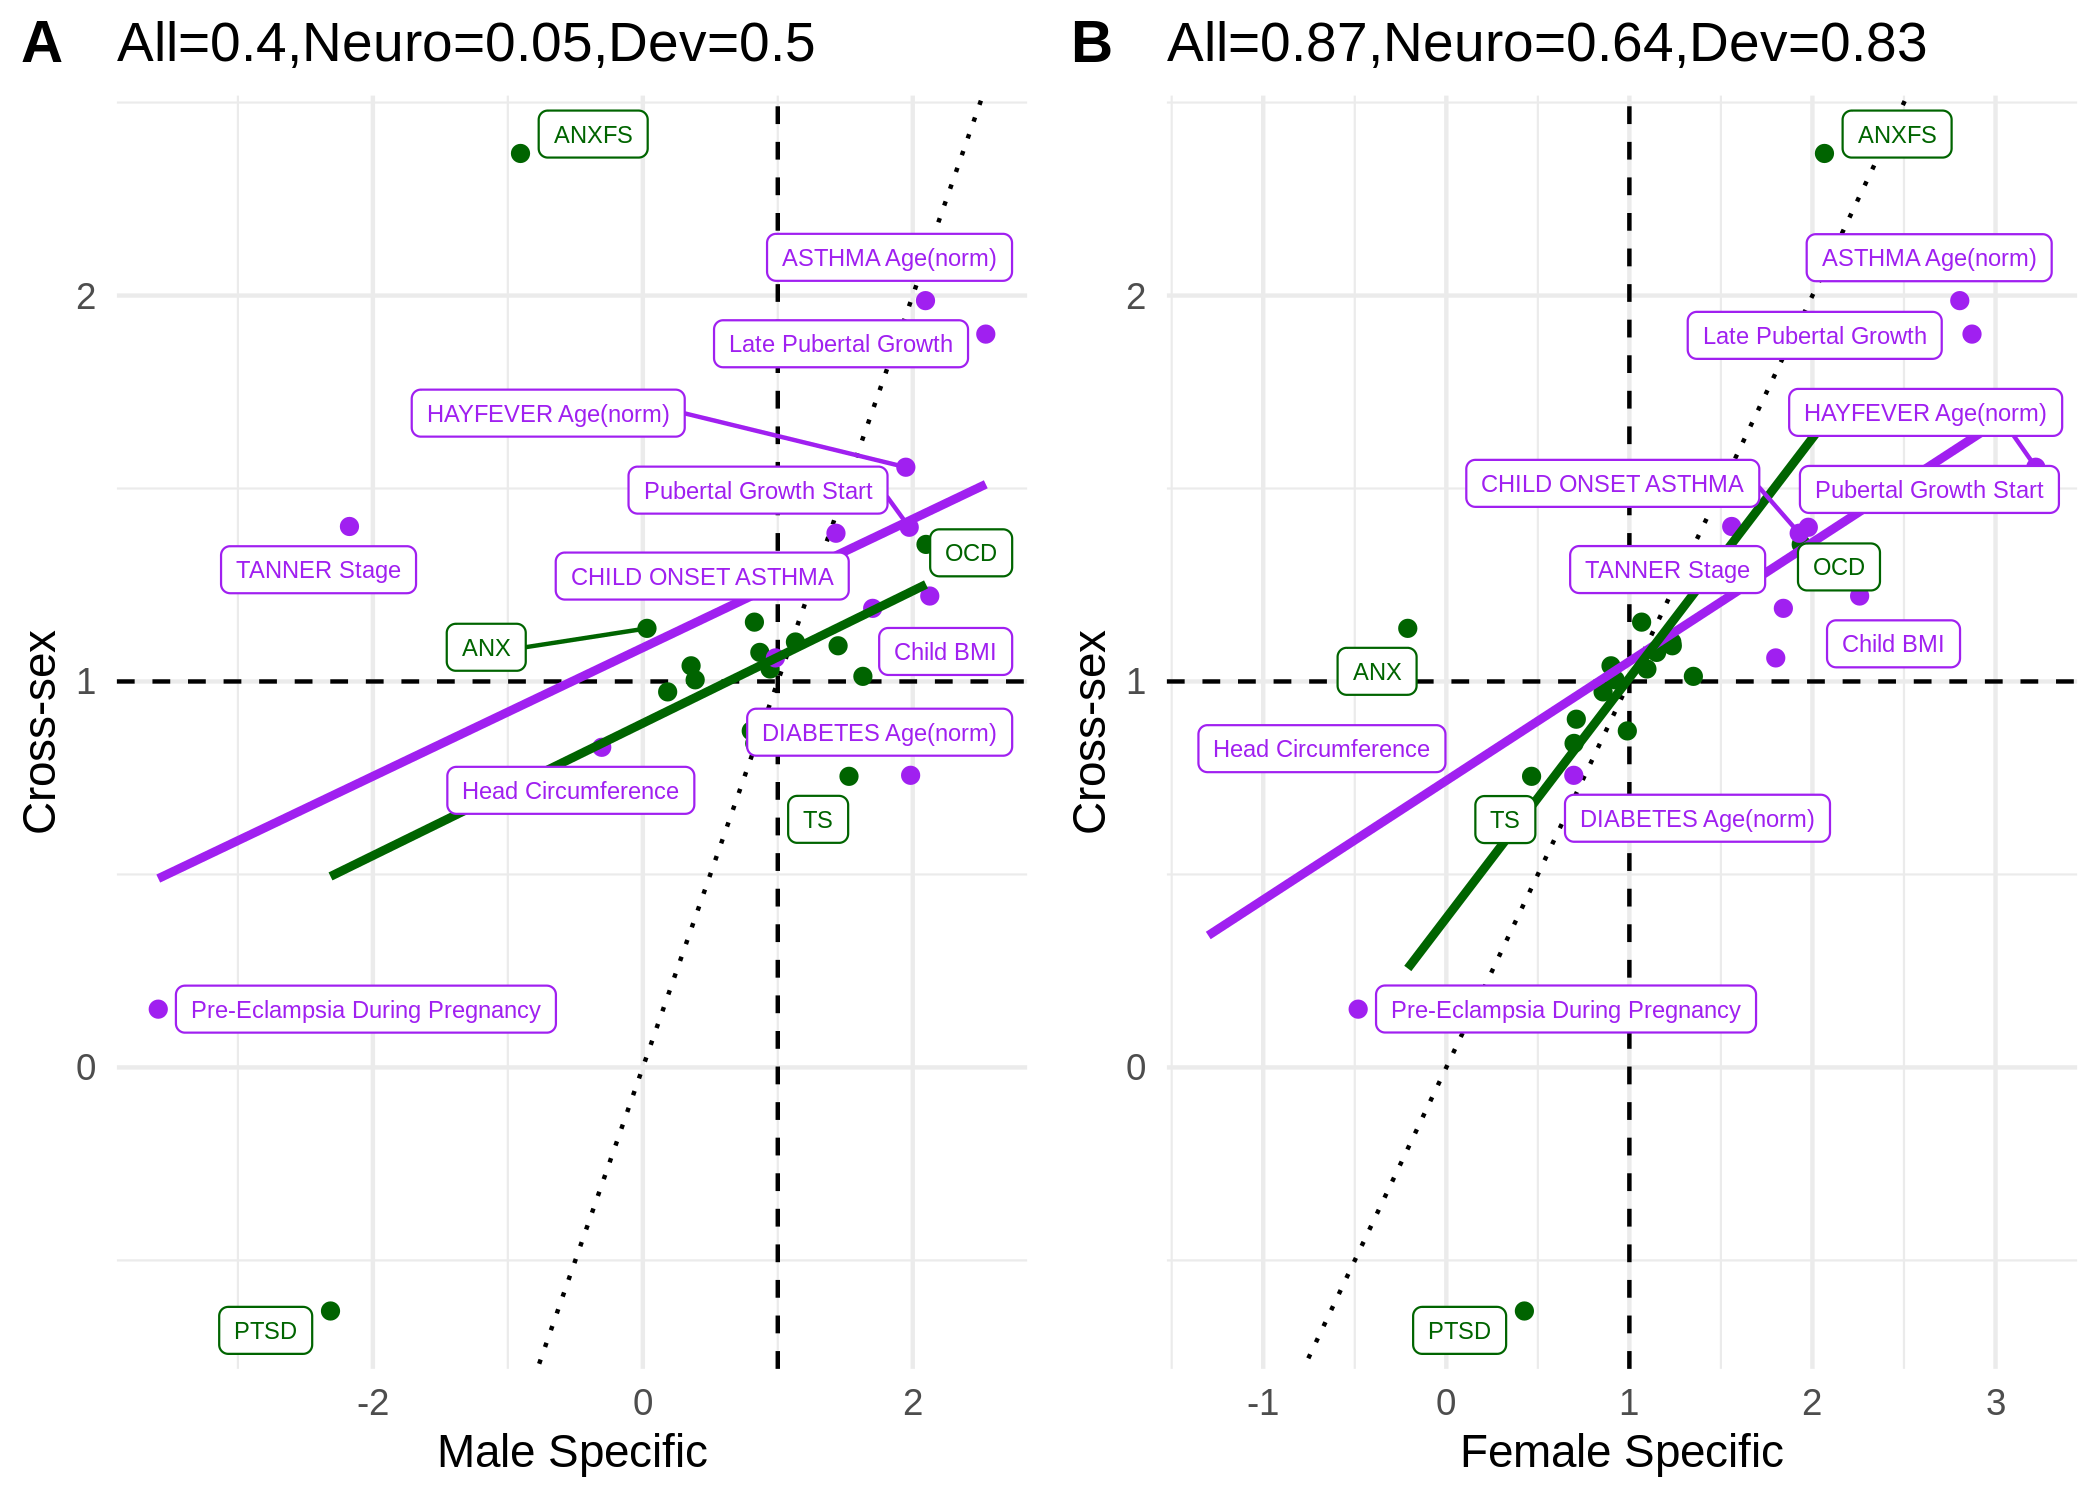

In [25]:
options(width= 10, repr.plot.height= 5, repr.plot.res = 300)

library(cowplot)
filtered <- combined_df[
        !grepl("Male|Female|raw",GWAS) &
        h2> 0
]
mf_data <- dcast(filtered,GWAS~Category, value.var = c("Enrichment"))
mf_data_psych <- mf_data[GWAS %in% pgc_GWAS_key]
mf_data_natal <- mf_data[GWAS %in% neonatal_GWAS_key]
all_GWAS_cor <- cor.test(mf_data$`Male Specific`,mf_data$`Female Specific`,method="spearman")$estimate
psych_GWAS_cor <- cor.test(mf_data_psych$`Male Specific`,mf_data_psych$`Female Specific`,method="spearman")$estimate
natal_GWAS_cor <- cor.test(mf_data_natal$`Male Specific`,mf_data_natal$`Female Specific`,method="spearman")$estimate
male_female <- ggplot(mf_data,
       aes(y=`Male Specific`,x=`Female Specific`,label=GWAS, color = ifelse(GWAS %in% pgc_GWAS_key,"Neuropsychiatric","Neonatal"))) +
    geom_hline(yintercept = 1,linetype="dashed")+
    geom_vline(xintercept = 1,linetype="dashed")+
    geom_abline(slope=1,linetype="dotted")+
    geom_point()+
    geom_smooth(method="lm",se=FALSE)+
    scale_color_manual(values=c("purple","dark green"))+
    theme_minimal()+
    labs(color = "GWAS category",title=glue("All={round(all_GWAS_cor,2)},Neuro={round(psych_GWAS_cor,2)},Dev={round(natal_GWAS_cor,2)}"))+
    theme(legend.position = "none")

mf_data_stratified <- dcast(to_plot, GWAS~ Category,value.var=c("Enrichment"))[GWAS != "OCD"]
mf_data_stratified_psych <- mf_data_stratified[GWAS %in% pgc_GWAS_key]
mf_data_stratified_natal <- mf_data_stratified[GWAS %in% neonatal_GWAS_key]
all_GWAS_cor <- cor.test(mf_data_stratified$`Male Specific`,mf_data_stratified$`Female Specific`,method="spearman")$estimate
psych_GWAS_cor <- cor.test(mf_data_stratified_psych$`Male Specific`,mf_data_stratified_psych$`Female Specific`,method="spearman")$estimate
natal_GWAS_cor <- cor.test(mf_data_stratified_natal$`Male Specific`,mf_data_stratified_natal$`Female Specific`,method="spearman")$estimate
male_female_stratified <- ggplot(mf_data_stratified,
       aes(y=`Male Specific`,x=`Female Specific`,label=GWAS, color = ifelse(GWAS %in% pgc_GWAS_key,"Neuropsychiatric","Neonatal"))) +
    geom_hline(yintercept = 1,linetype="dashed")+
    geom_vline(xintercept = 1,linetype="dashed")+
    geom_abline(slope=1,linetype="dotted")+
    geom_point()+
    geom_smooth(method="lm",se=FALSE)+
    scale_color_manual(values=c("purple","dark green"))+
    theme_minimal()+
    labs(color = "GWAS category",title=glue("All={round(all_GWAS_cor,2)},Neuro={round(psych_GWAS_cor,2)},Dev={round(natal_GWAS_cor,2)}"))+
    theme(legend.position = "none")
all_GWAS_cor <- cor.test(mf_data$`Cross-sex`,mf_data$`Cord Blood`,method="spearman")$estimate
psych_GWAS_cor <- cor.test(mf_data_psych$`Cross-sex`,mf_data_psych$`Cord Blood`,method="spearman")$estimate
natal_GWAS_cor <- cor.test(mf_data_natal$`Cross-sex`,mf_data_natal$`Cord Blood`,method="spearman")$estimate

placental_cord <- ggplot(mf_data,
       aes(y=`Cross-sex`,x=`Cord Blood`,label=GWAS, color = ifelse(GWAS %in% pgc_GWAS_key,"Neuropsychiatric","Neonatal"))) +
    geom_hline(yintercept = 1,linetype="dashed")+
    geom_vline(xintercept = 1,linetype="dashed")+
    geom_abline(slope=1,linetype="dotted")+
    geom_point()+
    geom_smooth(method="lm",se=FALSE)+
    scale_color_manual(values=c("purple","dark green"))+
    theme_minimal()+
    labs(color = "GWAS category",title=glue("All={round(all_GWAS_cor,2)},Neuro={round(psych_GWAS_cor,2)},Dev={round(natal_GWAS_cor,2)}"))+
    theme(legend.position = "none")

all_GWAS_cor <- cor.test(mf_data$`Cross-sex`,mf_data$`Male Specific`,method="spearman")$estimate
psych_GWAS_cor <- cor.test(mf_data_psych$`Cross-sex`,mf_data_psych$`Male Specific`,method="spearman")$estimate
natal_GWAS_cor <- cor.test(mf_data_natal$`Cross-sex`,mf_data_natal$`Male Specific`,method="spearman")$estimate
cross_male <- ggplot(mf_data,
       aes(y=`Cross-sex`,x=`Male Specific`,label=GWAS, color = ifelse(GWAS %in% pgc_GWAS_key,"Neuropsychiatric","Neonatal"))) +
    geom_hline(yintercept = 1,linetype="dashed")+
    geom_vline(xintercept = 1,linetype="dashed")+
    geom_abline(slope=1,linetype="dotted")+
    geom_point()+
    geom_smooth(method="lm",se=FALSE)+
    scale_color_manual(values=c("purple","dark green"))+
    theme_minimal()+
    labs(color = "GWAS category",title=glue("All={round(all_GWAS_cor,2)},Neuro={round(psych_GWAS_cor,2)},Dev={round(natal_GWAS_cor,2)}"))+
    theme(legend.position = "none")


all_GWAS_cor <- cor.test(mf_data$`Cross-sex`,mf_data$`Female Specific`,method="spearman")$estimate
psych_GWAS_cor <- cor.test(mf_data_psych$`Cross-sex`,mf_data_psych$`Female Specific`,method="spearman")$estimate
natal_GWAS_cor <- cor.test(mf_data_natal$`Cross-sex`,mf_data_natal$`Female Specific`,method="spearman")$estimate
cross_female <- ggplot(mf_data,
       aes(y=`Cross-sex`,x=`Female Specific`,label=GWAS, color = ifelse(GWAS %in% pgc_GWAS_key,"Neuropsychiatric","Neonatal"))) +
    geom_hline(yintercept = 1,linetype="dashed")+
    geom_vline(xintercept = 1,linetype="dashed")+
    geom_abline(slope=1,linetype="dotted")+
    geom_point()+
    geom_smooth(method="lm",se=FALSE)+
    scale_color_manual(values=c("purple","dark green"))+
    theme_minimal()+
    labs(color = "GWAS category",title=glue("All={round(all_GWAS_cor,2)},Neuro={round(psych_GWAS_cor,2)},Dev={round(natal_GWAS_cor,2)}"))+
    theme(legend.position = "none")

lab <- geom_label_repel(size=2)
plot_grid(placental_cord,male_female,male_female_stratified,labels = "AUTO")
plot_grid(cross_male,cross_female,labels = "AUTO")

plot_grid(placental_cord+lab,male_female+lab,male_female_stratified+lab,labels = "AUTO")
plot_grid(cross_male+lab,cross_female+lab,labels = "AUTO")

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

Warning message:
“ggrepel: 3 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

Warning message:
“ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


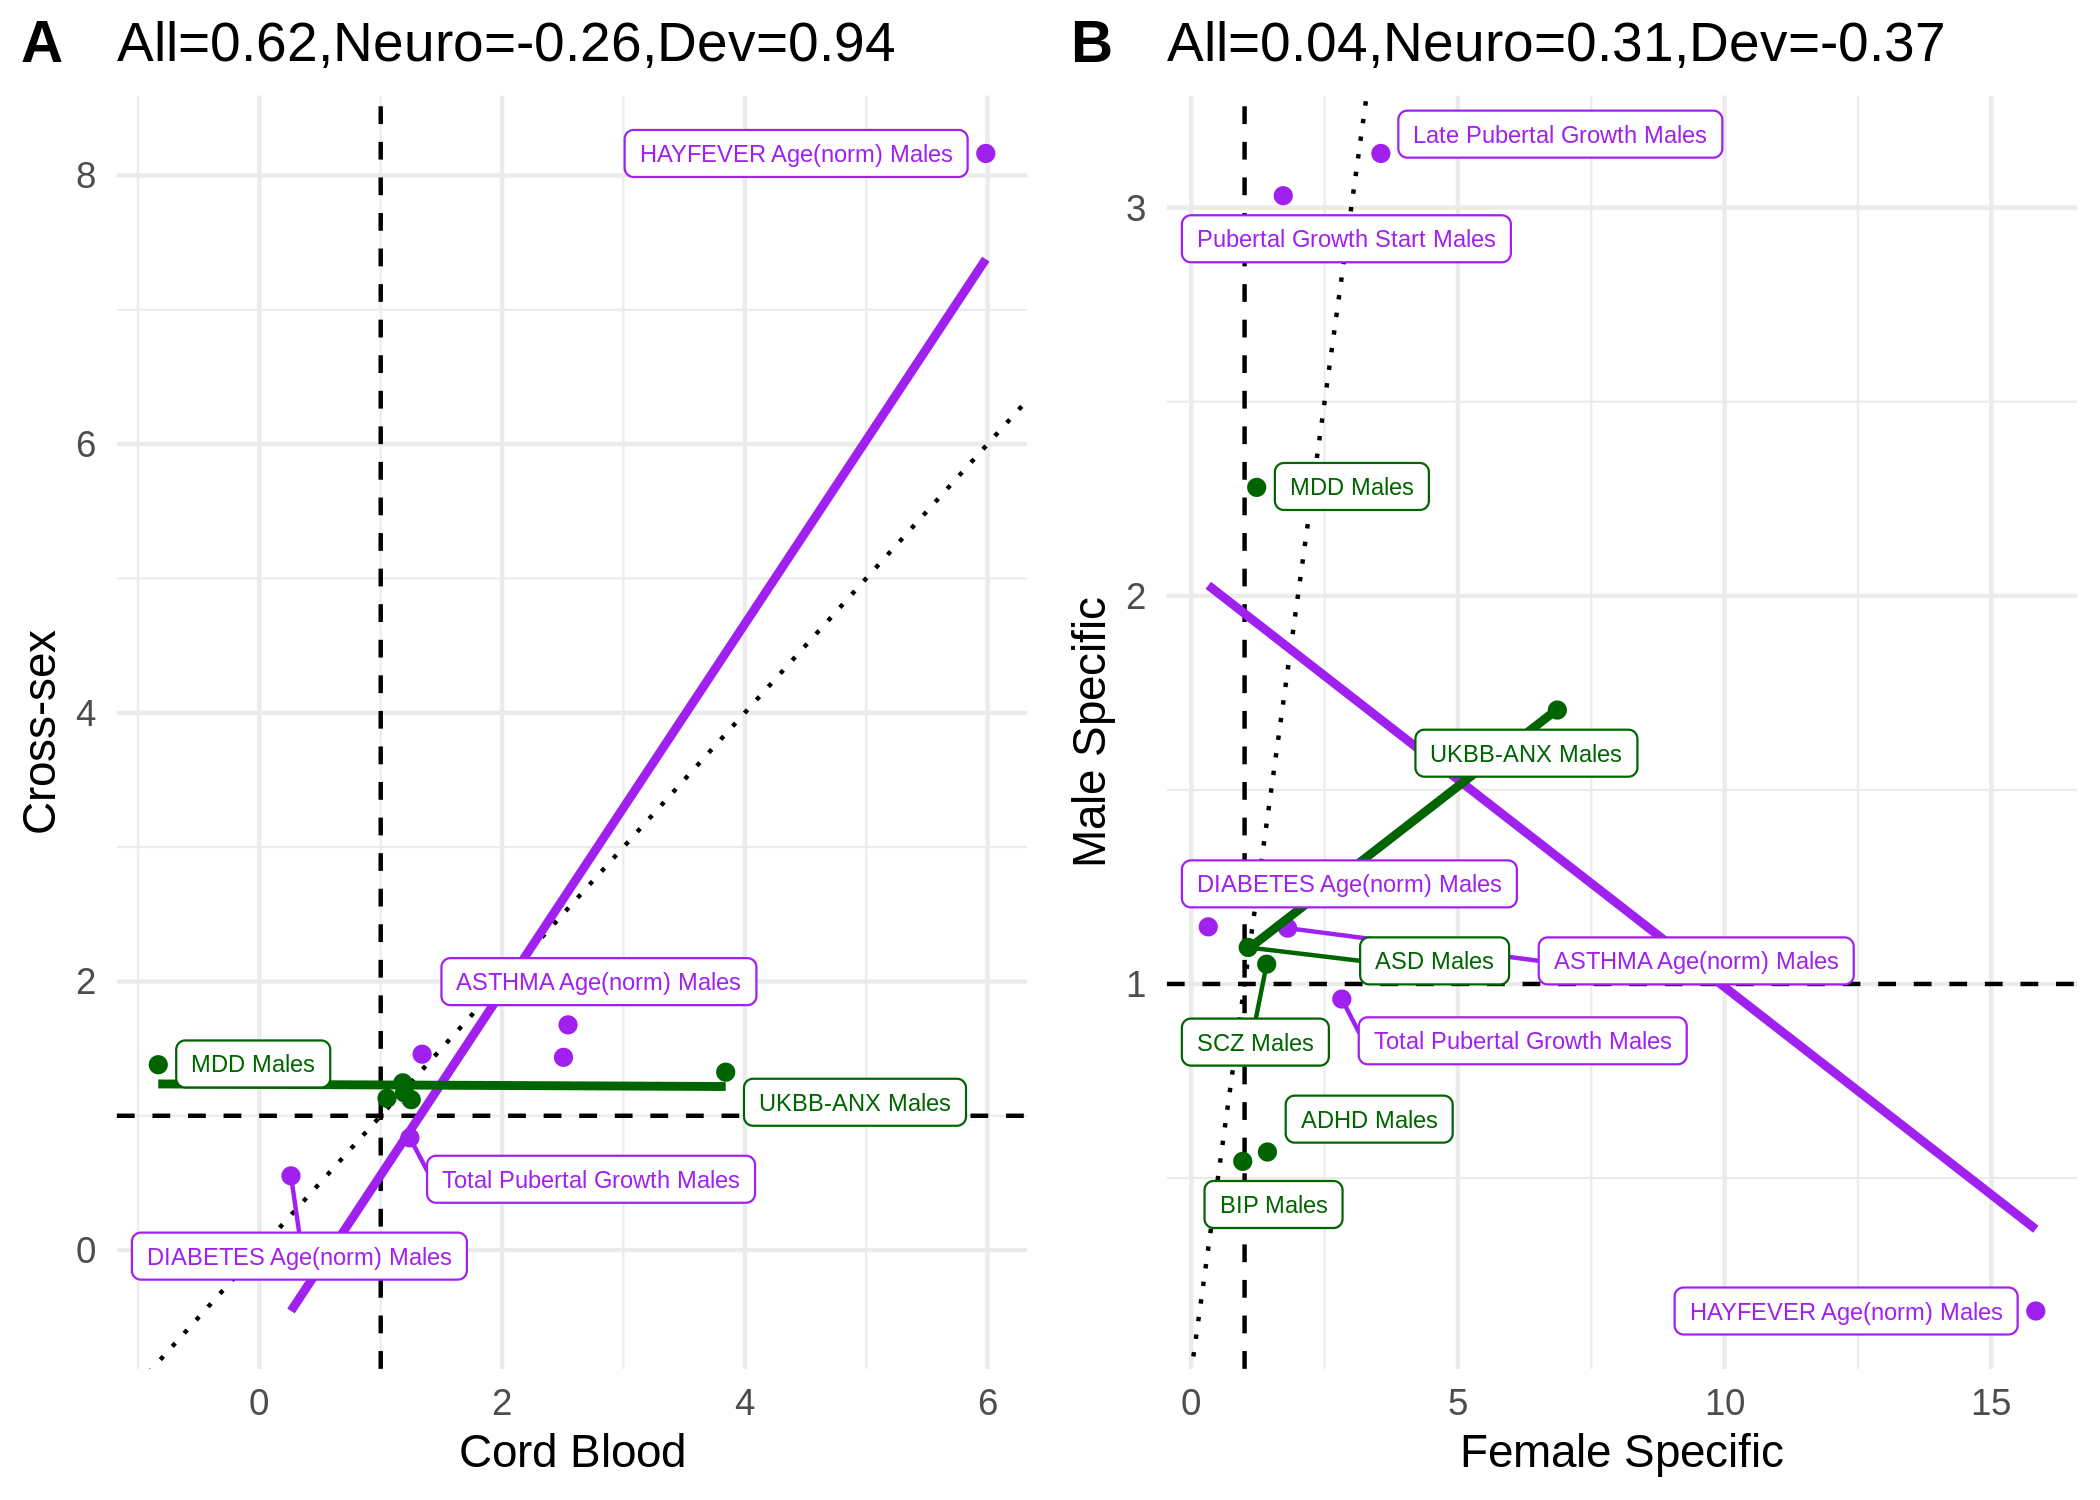

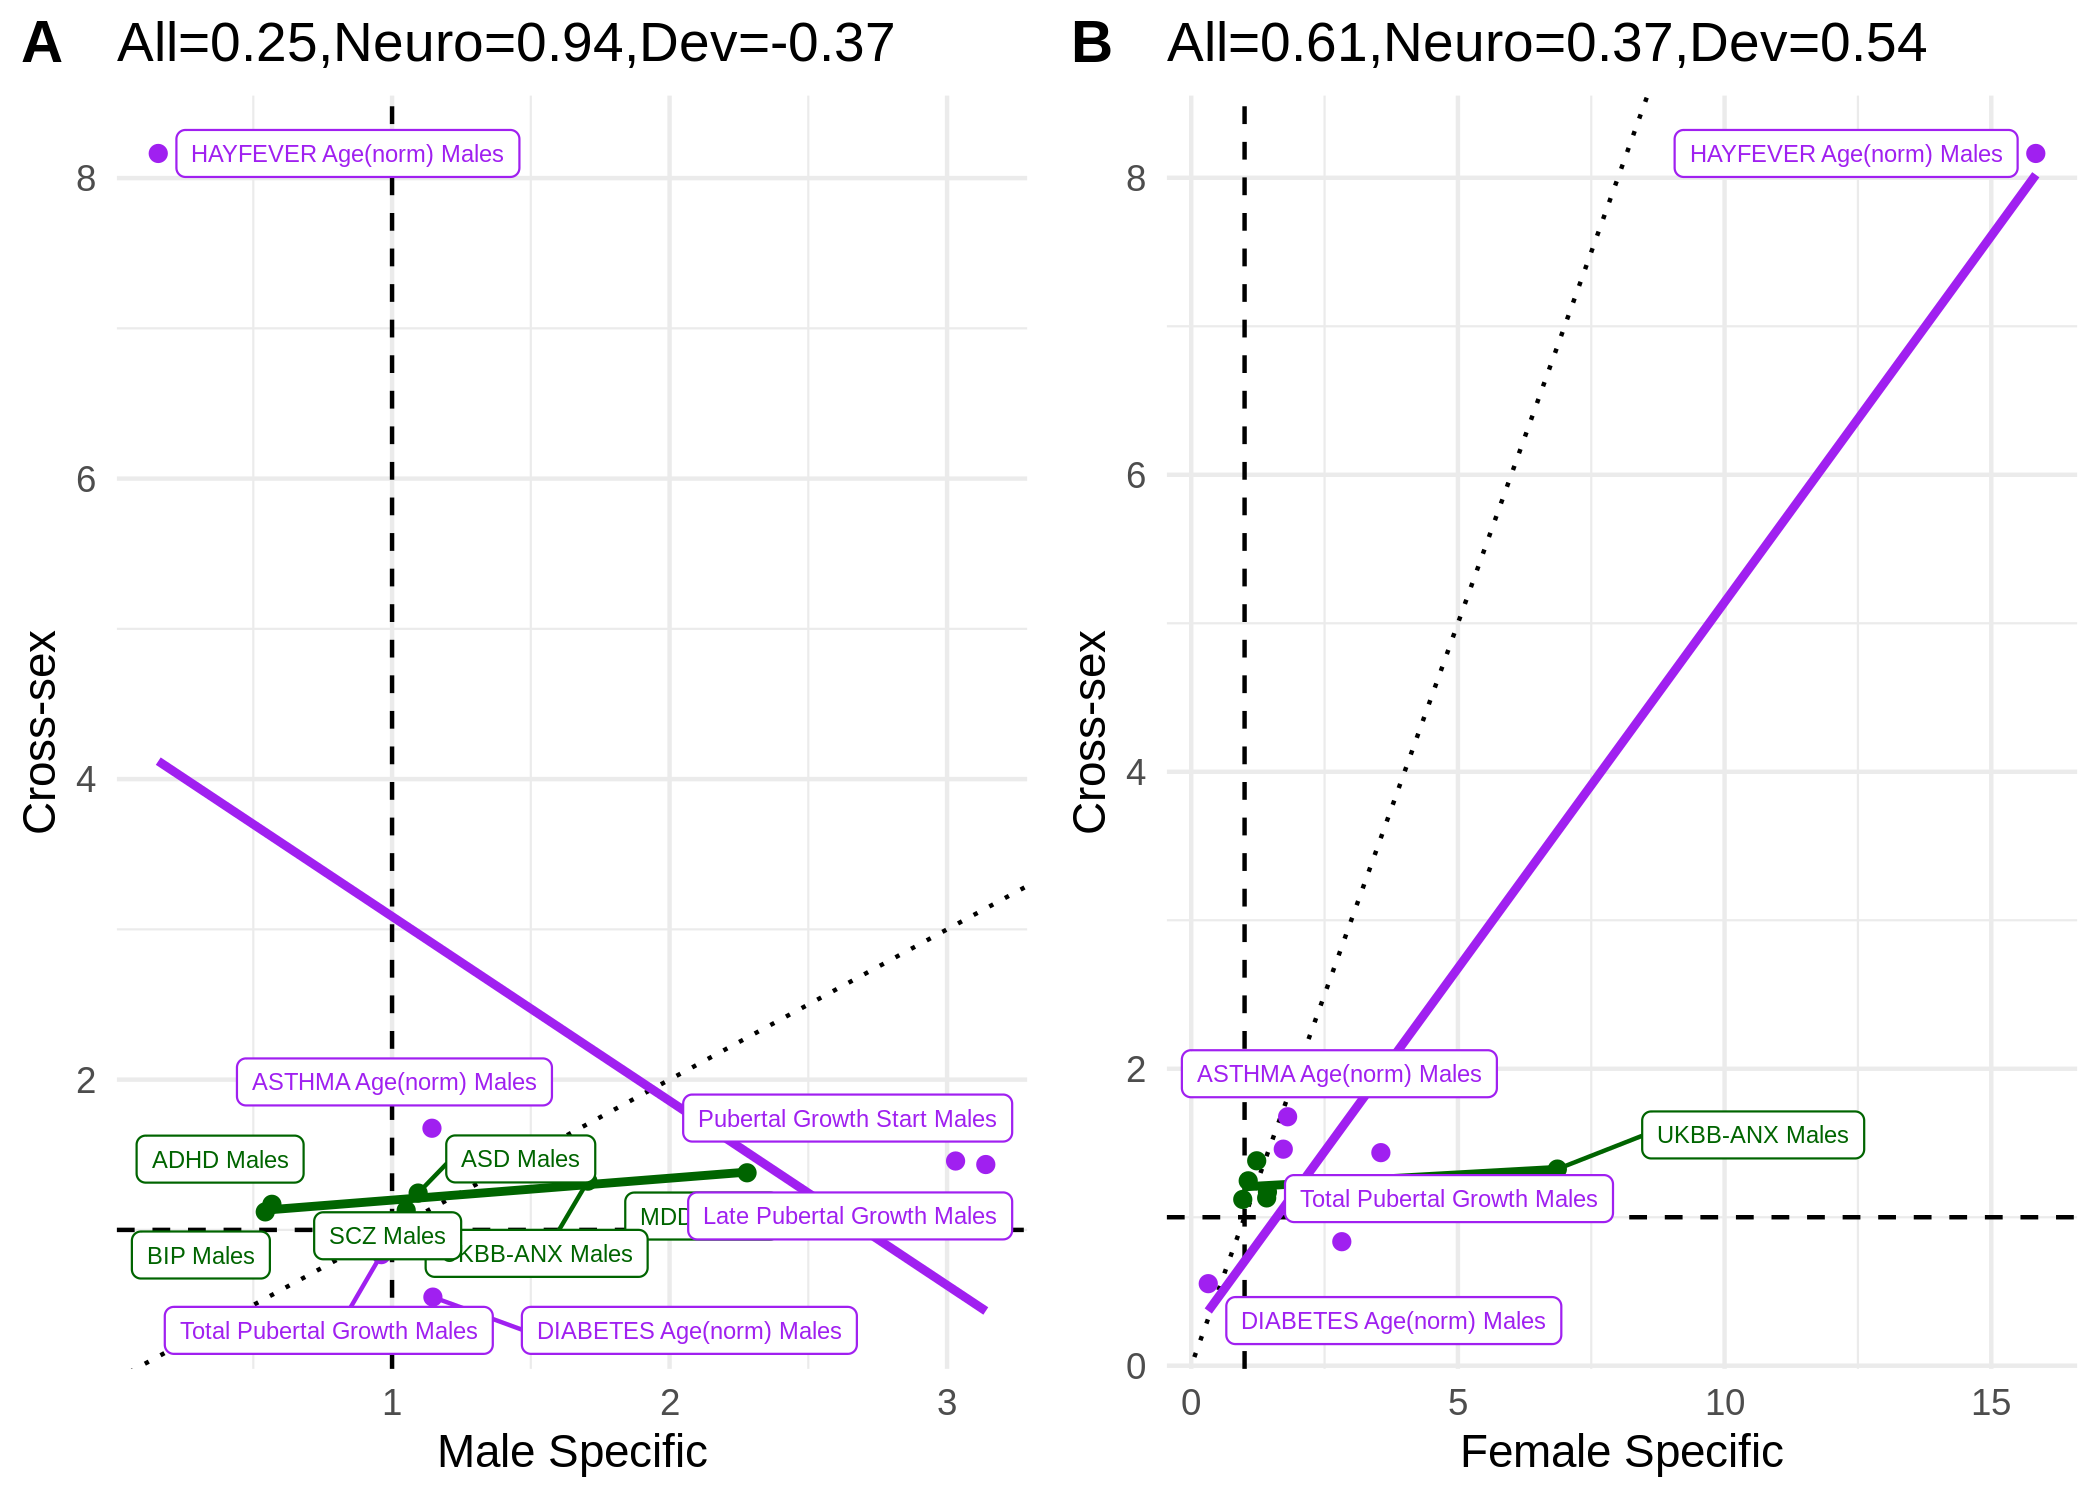

In [7]:
options(width= 10, repr.plot.height= 5, repr.plot.res = 300)

library(cowplot)
filtered <- combined_df[
        grepl("Male",GWAS) &
        !grepl("Female|raw|OCD",GWAS) &
        h2> 0
]
mf_data <- dcast(filtered,GWAS~Category, value.var = c("Enrichment"))

mf_data_psych <- mf_data[GWAS %in% pgc_GWAS_key]
mf_data_natal <- mf_data[GWAS %in% neonatal_GWAS_key]
all_GWAS_cor <- cor.test(mf_data$`Male Specific`,mf_data$`Female Specific`,method="spearman")$estimate
psych_GWAS_cor <- cor.test(mf_data_psych$`Male Specific`,mf_data_psych$`Female Specific`,method="spearman")$estimate
natal_GWAS_cor <- cor.test(mf_data_natal$`Male Specific`,mf_data_natal$`Female Specific`,method="spearman")$estimate
male_female <- ggplot(mf_data,
       aes(y=`Male Specific`,x=`Female Specific`,label=GWAS, color = ifelse(GWAS %in% pgc_GWAS_key,"Neuropsychiatric","Neonatal"))) +
    geom_hline(yintercept = 1,linetype="dashed")+
    geom_vline(xintercept = 1,linetype="dashed")+
    geom_abline(slope=1,linetype="dotted")+
    geom_point()+
    geom_smooth(method="lm",se=FALSE)+
    geom_label_repel(size=2)+
    scale_color_manual(values=c("purple","dark green"))+
    theme_minimal()+
    labs(color = "GWAS category",title=glue("All={round(all_GWAS_cor,2)},Neuro={round(psych_GWAS_cor,2)},Dev={round(natal_GWAS_cor,2)}"))+
    theme(legend.position = "none")


all_GWAS_cor <- cor.test(mf_data$`Cross-sex`,mf_data$`Cord Blood`,method="spearman")$estimate
psych_GWAS_cor <- cor.test(mf_data_psych$`Cross-sex`,mf_data_psych$`Cord Blood`,method="spearman")$estimate
natal_GWAS_cor <- cor.test(mf_data_natal$`Cross-sex`,mf_data_natal$`Cord Blood`,method="spearman")$estimate

placental_cord <- ggplot(mf_data,
       aes(y=`Cross-sex`,x=`Cord Blood`,label=GWAS, color = ifelse(GWAS %in% pgc_GWAS_key,"Neuropsychiatric","Neonatal"))) +
    geom_hline(yintercept = 1,linetype="dashed")+
    geom_vline(xintercept = 1,linetype="dashed")+
    geom_abline(slope=1,linetype="dotted")+
    geom_point()+
    geom_smooth(method="lm",se=FALSE)+
    geom_label_repel(size=2)+
    scale_color_manual(values=c("purple","dark green"))+
    theme_minimal()+
    labs(color = "GWAS category",title=glue("All={round(all_GWAS_cor,2)},Neuro={round(psych_GWAS_cor,2)},Dev={round(natal_GWAS_cor,2)}"))+
    theme(legend.position = "none")

all_GWAS_cor <- cor.test(mf_data$`Cross-sex`,mf_data$`Male Specific`,method="spearman")$estimate
psych_GWAS_cor <- cor.test(mf_data_psych$`Cross-sex`,mf_data_psych$`Male Specific`,method="spearman")$estimate
natal_GWAS_cor <- cor.test(mf_data_natal$`Cross-sex`,mf_data_natal$`Male Specific`,method="spearman")$estimate
cross_male <- ggplot(mf_data,
       aes(y=`Cross-sex`,x=`Male Specific`,label=GWAS, color = ifelse(GWAS %in% pgc_GWAS_key,"Neuropsychiatric","Neonatal"))) +
    geom_hline(yintercept = 1,linetype="dashed")+
    geom_vline(xintercept = 1,linetype="dashed")+
    geom_abline(slope=1,linetype="dotted")+
    geom_point()+
    geom_smooth(method="lm",se=FALSE)+
    geom_label_repel(size=2)+
    scale_color_manual(values=c("purple","dark green"))+
    theme_minimal()+
    labs(color = "GWAS category",title=glue("All={round(all_GWAS_cor,2)},Neuro={round(psych_GWAS_cor,2)},Dev={round(natal_GWAS_cor,2)}"))+
    theme(legend.position = "none")


all_GWAS_cor <- cor.test(mf_data$`Cross-sex`,mf_data$`Female Specific`,method="spearman")$estimate
psych_GWAS_cor <- cor.test(mf_data_psych$`Cross-sex`,mf_data_psych$`Female Specific`,method="spearman")$estimate
natal_GWAS_cor <- cor.test(mf_data_natal$`Cross-sex`,mf_data_natal$`Female Specific`,method="spearman")$estimate
cross_female <- ggplot(mf_data,
       aes(y=`Cross-sex`,x=`Female Specific`,label=GWAS, color = ifelse(GWAS %in% pgc_GWAS_key,"Neuropsychiatric","Neonatal"))) +
    geom_hline(yintercept = 1,linetype="dashed")+
    geom_vline(xintercept = 1,linetype="dashed")+
    geom_abline(slope=1,linetype="dotted")+
    geom_point()+
    geom_smooth(method="lm",se=FALSE)+
    geom_label_repel(size=2)+
    scale_color_manual(values=c("purple","dark green"))+
    theme_minimal()+
    labs(color = "GWAS category",title=glue("All={round(all_GWAS_cor,2)},Neuro={round(psych_GWAS_cor,2)},Dev={round(natal_GWAS_cor,2)}"))+
    theme(legend.position = "none")


plot_grid(placental_cord,male_female,labels = "AUTO")
plot_grid(cross_male,cross_female,labels = "AUTO")

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

Warning message:
“ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

Warning message:
“ggrepel: 5 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


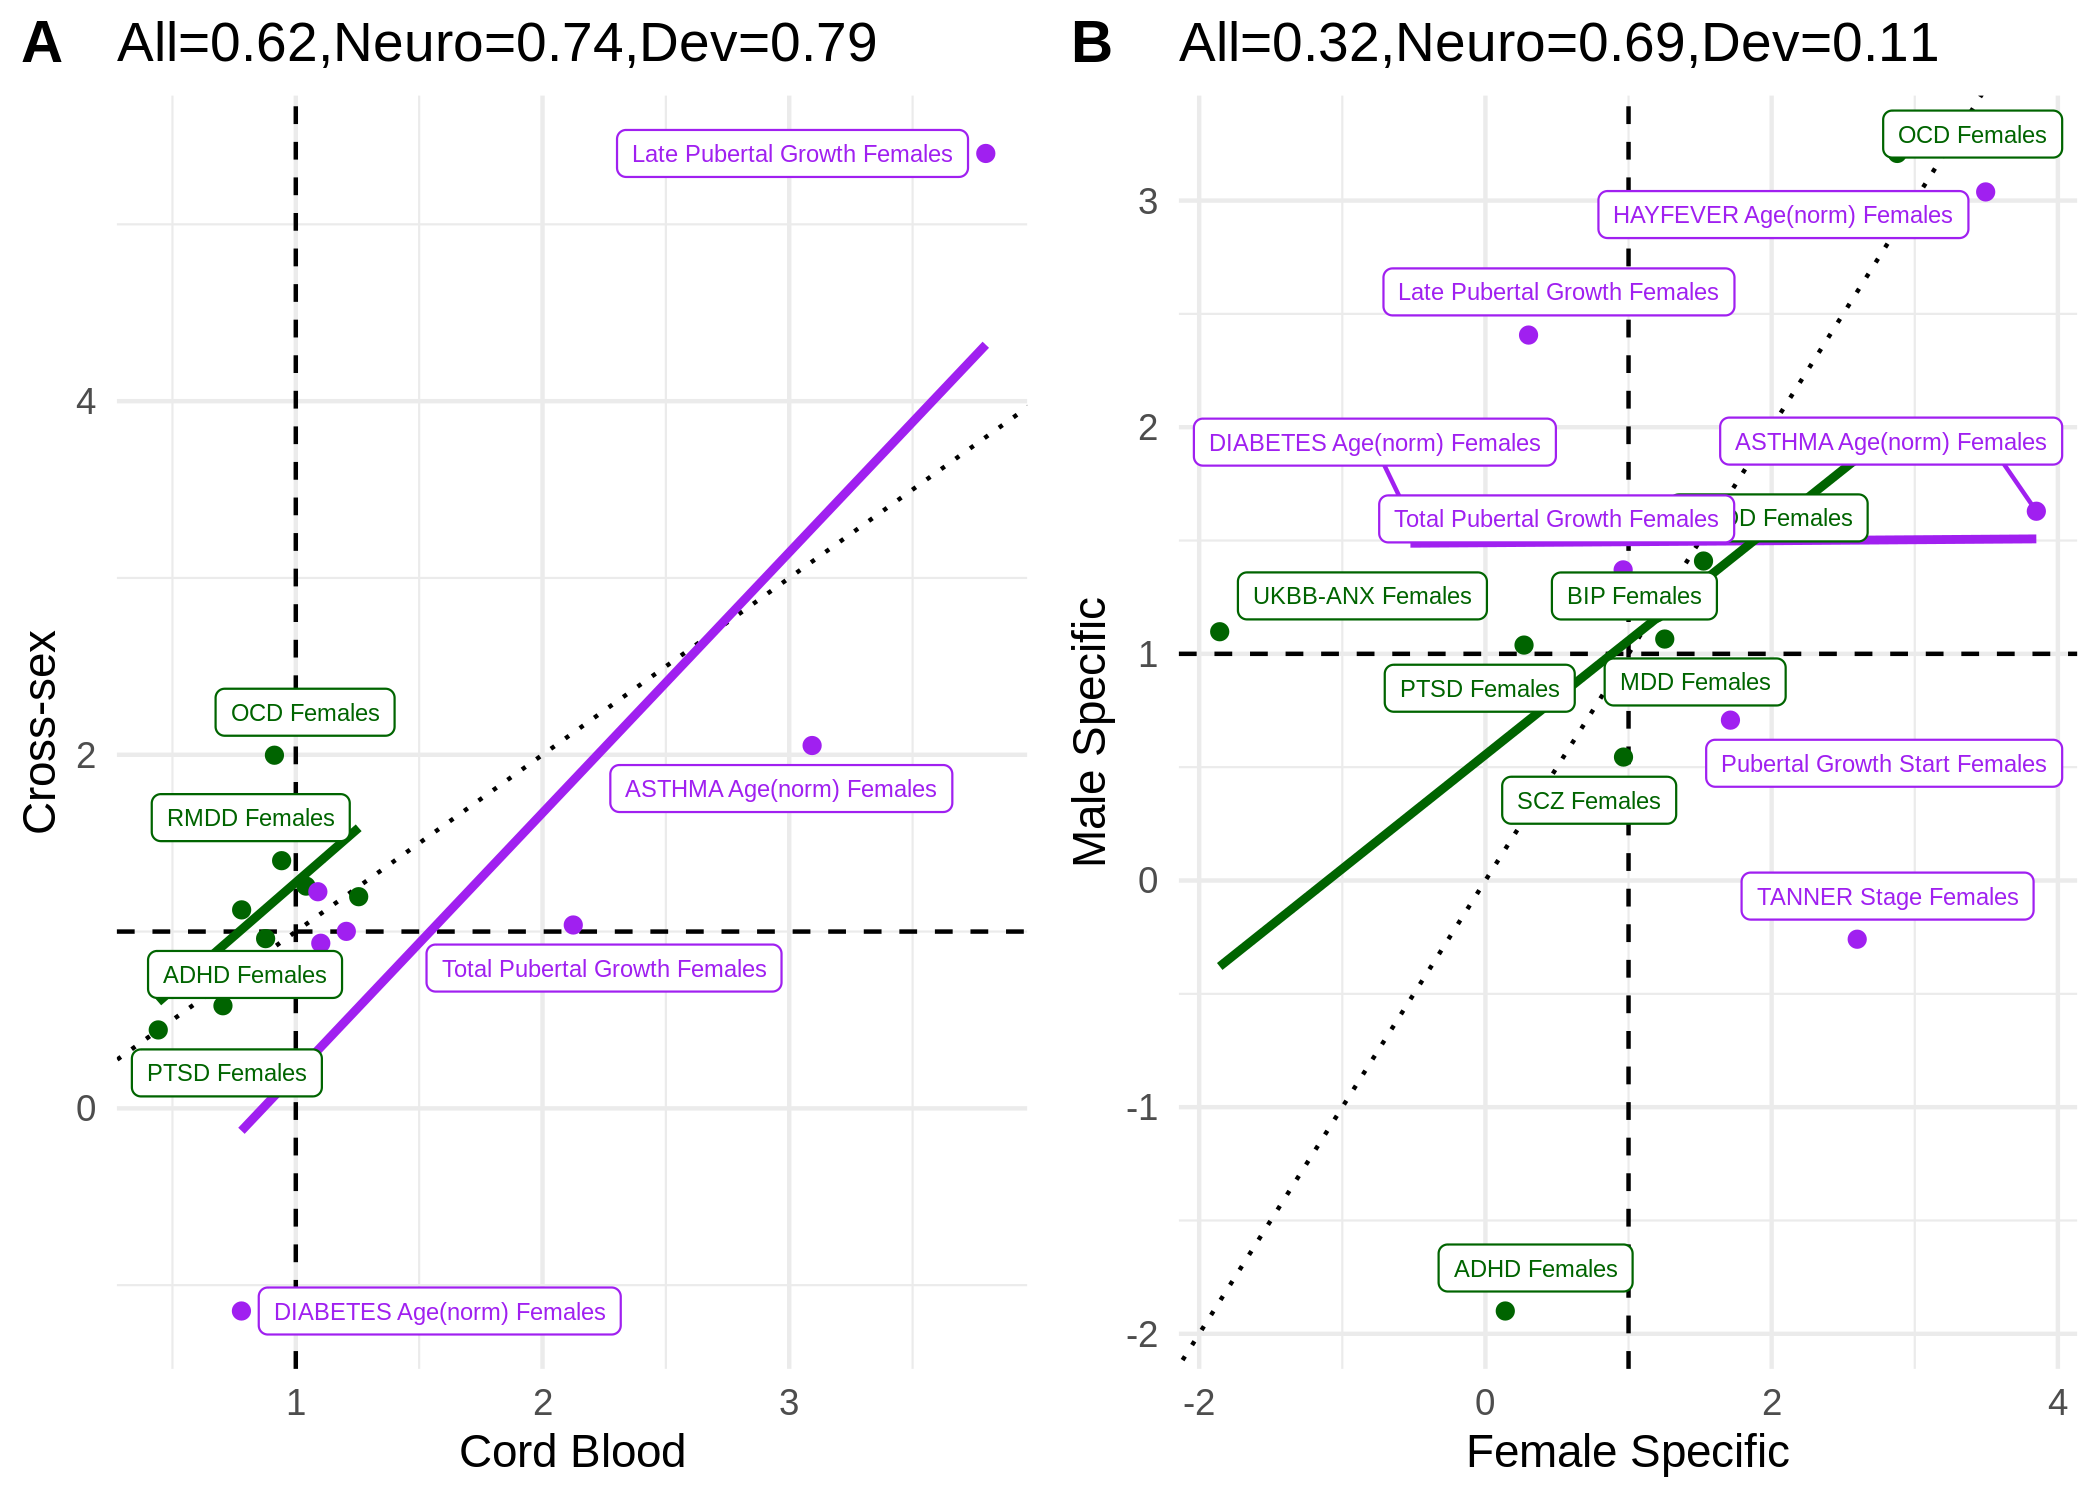

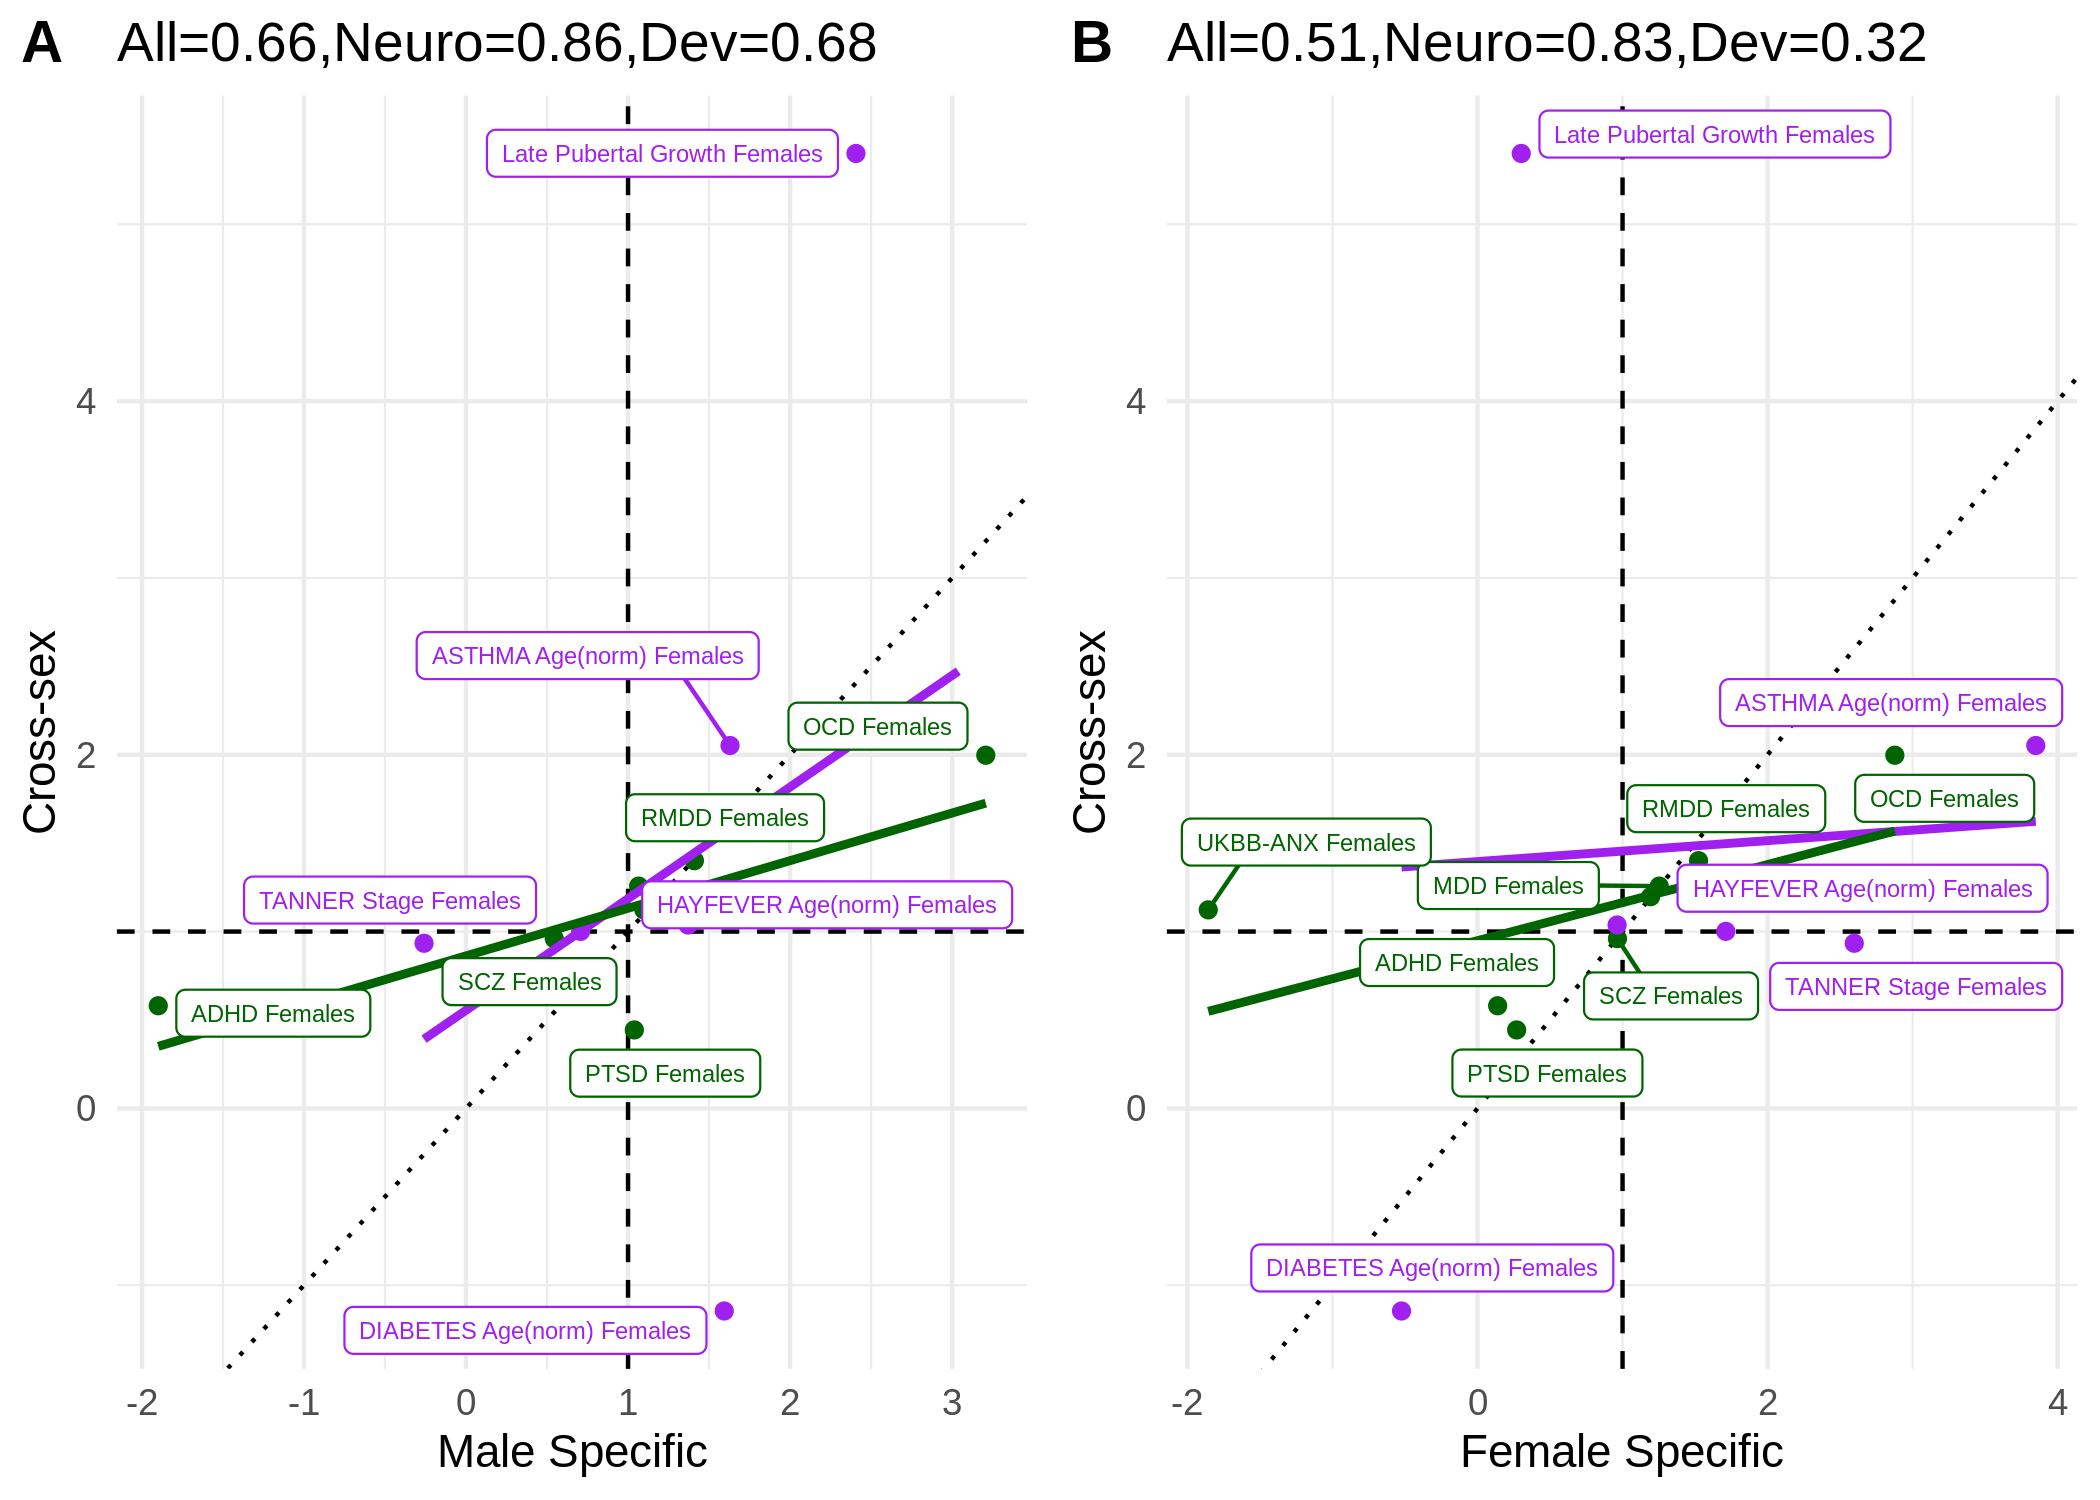

In [61]:
options(width= 10, repr.plot.height= 5, repr.plot.res = 300)

library(cowplot)
filtered <- combined_df[
        grepl("Female",GWAS) &
        !grepl("Male|raw",GWAS) &
        h2> 0
]
mf_data <- dcast(filtered,GWAS~Category, value.var = c("Enrichment"))

mf_data_psych <- mf_data[GWAS %in% pgc_GWAS_key]
mf_data_natal <- mf_data[GWAS %in% neonatal_GWAS_key]
all_GWAS_cor <- cor.test(mf_data$`Male Specific`,mf_data$`Female Specific`,method="spearman")$estimate
psych_GWAS_cor <- cor.test(mf_data_psych$`Male Specific`,mf_data_psych$`Female Specific`,method="spearman")$estimate
natal_GWAS_cor <- cor.test(mf_data_natal$`Male Specific`,mf_data_natal$`Female Specific`,method="spearman")$estimate
male_female <- ggplot(mf_data,
       aes(y=`Male Specific`,x=`Female Specific`,label=GWAS, color = ifelse(GWAS %in% pgc_GWAS_key,"Neuropsychiatric","Neonatal"))) +
    geom_hline(yintercept = 1,linetype="dashed")+
    geom_vline(xintercept = 1,linetype="dashed")+
    geom_abline(slope=1,linetype="dotted")+
    geom_point()+
    geom_smooth(method="lm",se=FALSE)+
    geom_label_repel(size=2)+
    scale_color_manual(values=c("purple","dark green"))+
    theme_minimal()+
    labs(color = "GWAS category",title=glue("All={round(all_GWAS_cor,2)},Neuro={round(psych_GWAS_cor,2)},Dev={round(natal_GWAS_cor,2)}"))+
    theme(legend.position = "none")


all_GWAS_cor <- cor.test(mf_data$`Cross-sex`,mf_data$`Cord Blood`,method="spearman")$estimate
psych_GWAS_cor <- cor.test(mf_data_psych$`Cross-sex`,mf_data_psych$`Cord Blood`,method="spearman")$estimate
natal_GWAS_cor <- cor.test(mf_data_natal$`Cross-sex`,mf_data_natal$`Cord Blood`,method="spearman")$estimate

placental_cord <- ggplot(mf_data,
       aes(y=`Cross-sex`,x=`Cord Blood`,label=GWAS, color = ifelse(GWAS %in% pgc_GWAS_key,"Neuropsychiatric","Neonatal"))) +
    geom_hline(yintercept = 1,linetype="dashed")+
    geom_vline(xintercept = 1,linetype="dashed")+
    geom_abline(slope=1,linetype="dotted")+
    geom_point()+
    geom_smooth(method="lm",se=FALSE)+
    geom_label_repel(size=2)+
    scale_color_manual(values=c("purple","dark green"))+
    theme_minimal()+
    labs(color = "GWAS category",title=glue("All={round(all_GWAS_cor,2)},Neuro={round(psych_GWAS_cor,2)},Dev={round(natal_GWAS_cor,2)}"))+
    theme(legend.position = "none")

all_GWAS_cor <- cor.test(mf_data$`Cross-sex`,mf_data$`Male Specific`,method="spearman")$estimate
psych_GWAS_cor <- cor.test(mf_data_psych$`Cross-sex`,mf_data_psych$`Male Specific`,method="spearman")$estimate
natal_GWAS_cor <- cor.test(mf_data_natal$`Cross-sex`,mf_data_natal$`Male Specific`,method="spearman")$estimate
cross_male <- ggplot(mf_data,
       aes(y=`Cross-sex`,x=`Male Specific`,label=GWAS, color = ifelse(GWAS %in% pgc_GWAS_key,"Neuropsychiatric","Neonatal"))) +
    geom_hline(yintercept = 1,linetype="dashed")+
    geom_vline(xintercept = 1,linetype="dashed")+
    geom_abline(slope=1,linetype="dotted")+
    geom_point()+
    geom_smooth(method="lm",se=FALSE)+
    geom_label_repel(size=2)+
    scale_color_manual(values=c("purple","dark green"))+
    theme_minimal()+
    labs(color = "GWAS category",title=glue("All={round(all_GWAS_cor,2)},Neuro={round(psych_GWAS_cor,2)},Dev={round(natal_GWAS_cor,2)}"))+
    theme(legend.position = "none")


all_GWAS_cor <- cor.test(mf_data$`Cross-sex`,mf_data$`Female Specific`,method="spearman")$estimate
psych_GWAS_cor <- cor.test(mf_data_psych$`Cross-sex`,mf_data_psych$`Female Specific`,method="spearman")$estimate
natal_GWAS_cor <- cor.test(mf_data_natal$`Cross-sex`,mf_data_natal$`Female Specific`,method="spearman")$estimate
cross_female <- ggplot(mf_data,
       aes(y=`Cross-sex`,x=`Female Specific`,label=GWAS, color = ifelse(GWAS %in% pgc_GWAS_key,"Neuropsychiatric","Neonatal"))) +
    geom_hline(yintercept = 1,linetype="dashed")+
    geom_vline(xintercept = 1,linetype="dashed")+
    geom_abline(slope=1,linetype="dotted")+
    geom_point()+
    geom_smooth(method="lm",se=FALSE)+
    geom_label_repel(size=2)+
    scale_color_manual(values=c("purple","dark green"))+
    theme_minimal()+
    labs(color = "GWAS category",title=glue("All={round(all_GWAS_cor,2)},Neuro={round(psych_GWAS_cor,2)},Dev={round(natal_GWAS_cor,2)}"))+
    theme(legend.position = "none")


plot_grid(placental_cord,male_female,labels = "AUTO")
plot_grid(cross_male,cross_female,labels = "AUTO")

In [66]:
library(rmeta)

# meta.summaries(method="random",d=tau_star,se=tau_se,data=pgc_part_heritability_independent_df[!grepl("Male|Female|raw",GWAS) & Category == "Male Specific"])
# meta.summaries(method="random",d=tau_star,se=tau_se,data=pgc_part_heritability_independent_df[!grepl("Male|Female|raw",GWAS) &Category == "Female Specific"])
# meta.summaries(method="random",d=tau_star,se=tau_se,data=neonatal_part_heritability_independent_df[!grepl("Male|Female|raw",GWAS) &Category == "Male Specific"])
# meta.summaries(method="random",d=tau_star,se=tau_se,data=neonatal_part_heritability_independent_df[!grepl("Male|Female|raw",GWAS) &Category == "Female Specific"])
# meta.summaries(method="random",d=tau_star,se=tau_se,data=neonatal_part_heritability_independent_df[!grepl("Male|Female|raw",GWAS) &Category == "Cross-sex"])
# meta.summaries(method="random",d=tau_star,se=tau_se,data=neonatal_part_heritability_independent_df[!grepl("Male|Female|raw",GWAS) &Category == "Cord Blood"])

meta.summaries(method="random",d=Enrichment,se=Enrichment_std_error,data=pgc_part_heritability_independent_df[!grepl("Male|Female|raw",GWAS) &Category == "Male Specific"])
meta.summaries(method="random",d=Enrichment,se=Enrichment_std_error,data=pgc_part_heritability_independent_df[!grepl("Male|Female|raw",GWAS) &Category == "Female Specific"])

meta.summaries(method="random",d=Enrichment,se=Enrichment_std_error,data=neonatal_part_heritability_independent_df[!grepl("Male|Female|raw",GWAS) &Category == "Male Specific"])
meta.summaries(method="random",d=Enrichment,se=Enrichment_std_error,data=neonatal_part_heritability_independent_df[!grepl("Male|Female|raw",GWAS) &Category == "Female Specific"])

meta.summaries(method="random",d=Enrichment,se=Enrichment_std_error,data=neonatal_part_heritability_independent_df[!grepl("Male|Female|raw",GWAS) & Category == "Cross-sex"])
meta.summaries(method="random",d=Enrichment,se=Enrichment_std_error,data=neonatal_part_heritability_independent_df[!grepl("Male|Female|raw",GWAS) & Category == "Cord Blood"])


meta.summaries(method="random",d=Enrichment,se=Enrichment_std_error,data=pgc_part_heritability_independent_df[grepl("Male",GWAS) & !grepl("raw",GWAS) &Category == "Male Specific"])
meta.summaries(method="random",d=Enrichment,se=Enrichment_std_error,data=pgc_part_heritability_independent_df[grepl("Male",GWAS) & !grepl("raw",GWAS) &Category == "Female Specific"])

meta.summaries(method="random",d=Enrichment,se=Enrichment_std_error,data=neonatal_part_heritability_independent_df[grepl("Male",GWAS) & !grepl("raw",GWAS) &Category == "Male Specific"])
meta.summaries(method="random",d=Enrichment,se=Enrichment_std_error,data=neonatal_part_heritability_independent_df[grepl("Male",GWAS) & !grepl("raw",GWAS) &Category == "Female Specific"])

meta.summaries(method="random",d=Enrichment,se=Enrichment_std_error,data=neonatal_part_heritability_independent_df[grepl("Male",GWAS) & !grepl("raw",GWAS) &Category == "Cross-sex"])
meta.summaries(method="random",d=Enrichment,se=Enrichment_std_error,data=neonatal_part_heritability_independent_df[grepl("Male",GWAS) & !grepl("raw",GWAS) &Category == "Cord Blood"])


meta.summaries(method="random",d=Enrichment,se=Enrichment_std_error,data=pgc_part_heritability_independent_df[grepl("Female",GWAS) & !grepl("raw",GWAS) &Category == "Male Specific"])
meta.summaries(method="random",d=Enrichment,se=Enrichment_std_error,data=pgc_part_heritability_independent_df[grepl("Female",GWAS) & !grepl("raw",GWAS) &Category == "Female Specific"])

meta.summaries(method="random",d=Enrichment,se=Enrichment_std_error,data=neonatal_part_heritability_independent_df[grepl("Female",GWAS) & !grepl("raw",GWAS) &Category == "Male Specific"])
meta.summaries(method="random",d=Enrichment,se=Enrichment_std_error,data=neonatal_part_heritability_independent_df[grepl("Female",GWAS) & !grepl("raw",GWAS) &Category == "Female Specific"])

meta.summaries(method="random",d=Enrichment,se=Enrichment_std_error,data=neonatal_part_heritability_independent_df[grepl("Female",GWAS) & !grepl("raw",GWAS) &Category == "Cross-sex"])
meta.summaries(method="random",d=Enrichment,se=Enrichment_std_error,data=neonatal_part_heritability_independent_df[grepl("Female",GWAS) & !grepl("raw",GWAS) &Category == "Cord Blood"])

Random-effects meta-analysis
Call: meta.summaries(d = Enrichment, se = Enrichment_std_error, method = "random", 
    data = pgc_part_heritability_independent_df[!grepl("Male|Female|raw", 
        GWAS) & Category == "Male Specific"])
Summary effect=0.8   95% CI (0.605, 0.994)
Estimated heterogeneity variance: 0.02  p= 0.304 

Random-effects meta-analysis
Call: meta.summaries(d = Enrichment, se = Enrichment_std_error, method = "random", 
    data = pgc_part_heritability_independent_df[!grepl("Male|Female|raw", 
        GWAS) & Category == "Female Specific"])
Summary effect=0.925   95% CI (0.758, 1.09)
Estimated heterogeneity variance: 0  p= 0.959 

Random-effects meta-analysis
Call: meta.summaries(d = Enrichment, se = Enrichment_std_error, method = "random", 
    data = neonatal_part_heritability_independent_df[!grepl("Male|Female|raw", 
        GWAS) & Category == "Male Specific"])
Summary effect=1.65   95% CI (1.24, 2.05)
Estimated heterogeneity variance: 0  p= 0.693 

Random-effects meta-analysis
Call: meta.summaries(d = Enrichment, se = Enrichment_std_error, method = "random", 
    data = neonatal_part_heritability_independent_df[!grepl("Male|Female|raw", 
        GWAS) & Category == "Female Specific"])
Summary effect=1.99   95% CI (1.51, 2.47)
Estimated heterogeneity variance: 0  p= 0.727 

Random-effects meta-analysis
Call: meta.summaries(d = Enrichment, se = Enrichment_std_error, method = "random", 
    data = neonatal_part_heritability_independent_df[!grepl("Male|Female|raw", 
        GWAS) & Category == "Cross-sex"])
Summary effect=1.33   95% CI (1.19, 1.47)
Estimated heterogeneity variance: 0.0013  p= 0.428 

Random-effects meta-analysis
Call: meta.summaries(d = Enrichment, se = Enrichment_std_error, method = "random", 
    data = neonatal_part_heritability_independent_df[!grepl("Male|Female|raw", 
        GWAS) & Category == "Cord Blood"])
Summary effect=1.53   95% CI (1.27, 1.78)
Estimated heterogeneity variance: 0  p= 0.874 

Random-effects meta-analysis
Call: meta.summaries(d = Enrichment, se = Enrichment_std_error, method = "random", 
    data = pgc_part_heritability_independent_df[grepl("Male", 
        GWAS) & !grepl("raw", GWAS) & Category == "Male Specific"])
Summary effect=0.924   95% CI (0.631, 1.22)
Estimated heterogeneity variance: 0  p= 0.73 

Random-effects meta-analysis
Call: meta.summaries(d = Enrichment, se = Enrichment_std_error, method = "random", 
    data = pgc_part_heritability_independent_df[grepl("Male", 
        GWAS) & !grepl("raw", GWAS) & Category == "Female Specific"])
Summary effect=1.26   95% CI (0.947, 1.57)
Estimated heterogeneity variance: 0  p= 0.922 

Random-effects meta-analysis
Call: meta.summaries(d = Enrichment, se = Enrichment_std_error, method = "random", 
    data = neonatal_part_heritability_independent_df[grepl("Male", 
        GWAS) & !grepl("raw", GWAS) & Category == "Male Specific"])
Summary effect=1.85   95% CI (0.829, 2.87)
Estimated heterogeneity variance: 0  p= 0.747 

Random-effects meta-analysis
Call: meta.summaries(d = Enrichment, se = Enrichment_std_error, method = "random", 
    data = neonatal_part_heritability_independent_df[grepl("Male", 
        GWAS) & !grepl("raw", GWAS) & Category == "Female Specific"])
Summary effect=1.97   95% CI (0.911, 3.03)
Estimated heterogeneity variance: 0  p= 0.81 

Random-effects meta-analysis
Call: meta.summaries(d = Enrichment, se = Enrichment_std_error, method = "random", 
    data = neonatal_part_heritability_independent_df[grepl("Male", 
        GWAS) & !grepl("raw", GWAS) & Category == "Cross-sex"])
Summary effect=1.32   95% CI (0.973, 1.66)
Estimated heterogeneity variance: 0  p= 0.59 

Random-effects meta-analysis
Call: meta.summaries(d = Enrichment, se = Enrichment_std_error, method = "random", 
    data = neonatal_part_heritability_independent_df[grepl("Male", 
        GWAS) & !grepl("raw", GWAS) & Category == "Cord Blood"])
Summary effect=1.5   95% CI (0.854, 2.14)
Estimated heterogeneity variance: 0.09  p= 0.341 

Random-effects meta-analysis
Call: meta.summaries(d = Enrichment, se = Enrichment_std_error, method = "random", 
    data = pgc_part_heritability_independent_df[grepl("Female", 
        GWAS) & !grepl("raw", GWAS) & Category == "Male Specific"])
Summary effect=1.14   95% CI (0.617, 1.65)
Estimated heterogeneity variance: 0.18  p= 0.148 

Random-effects meta-analysis
Call: meta.summaries(d = Enrichment, se = Enrichment_std_error, method = "random", 
    data = pgc_part_heritability_independent_df[grepl("Female", 
        GWAS) & !grepl("raw", GWAS) & Category == "Female Specific"])
Summary effect=1.18   95% CI (0.832, 1.53)
Estimated heterogeneity variance: 0  p= 0.63 

Random-effects meta-analysis
Call: meta.summaries(d = Enrichment, se = Enrichment_std_error, method = "random", 
    data = neonatal_part_heritability_independent_df[grepl("Female", 
        GWAS) & !grepl("raw", GWAS) & Category == "Male Specific"])
Summary effect=1.07   95% CI (0.0994, 2.04)
Estimated heterogeneity variance: 0  p= 0.926 

Random-effects meta-analysis
Call: meta.summaries(d = Enrichment, se = Enrichment_std_error, method = "random", 
    data = neonatal_part_heritability_independent_df[grepl("Female", 
        GWAS) & !grepl("raw", GWAS) & Category == "Female Specific"])
Summary effect=1.84   95% CI (0.862, 2.82)
Estimated heterogeneity variance: 0  p= 0.775 

Random-effects meta-analysis
Call: meta.summaries(d = Enrichment, se = Enrichment_std_error, method = "random", 
    data = neonatal_part_heritability_independent_df[grepl("Female", 
        GWAS) & !grepl("raw", GWAS) & Category == "Cross-sex"])
Summary effect=1.1   95% CI (0.797, 1.4)
Estimated heterogeneity variance: 0  p= 0.733 

Random-effects meta-analysis
Call: meta.summaries(d = Enrichment, se = Enrichment_std_error, method = "random", 
    data = neonatal_part_heritability_independent_df[grepl("Female", 
        GWAS) & !grepl("raw", GWAS) & Category == "Cord Blood"])
Summary effect=1.35   95% CI (0.861, 1.83)
Estimated heterogeneity variance: 0  p= 0.795 

## Testing why certain proportion of heritabilities may be negative in one annotation and not the other
Ideas to test:
* The maximum CPP value of SNPs in the 95% set happen to be small for many SNPs overlapping with that GWAS
* The total heritability is small resulting in noise in estimation

In [ ]:
compute_gwas_intersection <- function(annot,all_gwas){
    result<- mclapply(names(all_gwas), function(GWAS) all_gwas[[GWAS]][annot,on="SNP",nomatch=0],mc.cores=16) 
    names(result) <- names(all_gwas)
    return(result)
}

if(!file.exists(here("data","all_annot_struct.RDS"))){
    all_gwas <- mclapply(names(pgc_GWAS_key),function(GWAS) fread(glue("/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/{GWAS}.sumstats.gz")),mc.cores=16)
    names(all_gwas) <- pgc_GWAS_key
    # read in all annotations and merge with each GWAS
    all_annot <- list()
    for(qtl_set in c("marginal","sex_interaction","male", "female", "cord_mqtl")){
        print(glue("{qtl_set}"))
        path <- "/scratch/st-dennisjk-1/wcasazza/1000G_phase3_ldsc/single_delahaye_annotations"
        file_pattern <- glue("{qtl_set}_maxCPP_her..*.annot.gz")
        annots <- rbindlist(mclapply(dir(path,full.names=TRUE,pattern=file_pattern),function(f) fread(f),mc.cores=22))
        all_annot[[qtl_set]] <- compute_gwas_intersection(annots[annots$maxCPP > 0],all_gwas)
    }
    saveRDS(all_annot,here("data","all_annot_struct.RDS"))
}else{
    all_annot <- readRDS(here("data","all_annot_struct.RDS"))
}

In [ ]:
annot_to_plot < -lapply(all_annot, rbindlist, idcol="GWAS")

In [ ]:
options(width= 10, repr.plot.height= 8, repr.plot.res = 300)

for(annot in names(annot_to_plot)){
    p <- ggplot(annot_to_plot[[annot]],aes(-log10(maxCPP),Z)) +
        geom_bin_2d(bins=100) +
        scale_fill_distiller(palette="Spectral") +
        facet_wrap(~GWAS)+
        ggtitle(annot) +
        theme_minimal()
    print(p)
}

In [ ]:
options(width= 10, repr.plot.height= 5, repr.plot.res = 300)
annot_summary<-rbindlist(lapply(annot_to_plot,function(dt)dt[,.(count=.N,meanmaxCPP=mean(maxCPP)),by="GWAS"]),idcol="annotation")
ggplot(annot_summary,aes(x=annotation,y=GWAS,fill=count)) + 
    geom_tile()+        
    scale_fill_distiller(palette="Spectral") +
    ggtitle("SNP Overlap") +
    theme_minimal()
ggplot(annot_summary,aes(x=annotation,y=GWAS,fill=meanmaxCPP)) + 
    geom_tile()+        
    scale_fill_distiller(palette="Spectral") +
    ggtitle("SNP Overlap") +
    theme_minimal()        

## Relevant tables for trait selection
- @TODO, I need to go back to the sumstats.gz file for each trait and grab sample sizes, merge these in

In [8]:
get_sample_size <- function(fname){
    system.time(df <- fread(fname,nrows = 100))
    return(max(df$N))
}
pgc_sample_sizes <- mclapply(
    paste0(
        "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/",
        names(pgc_GWAS_key),
        ".sumstats.gz"
    ),
    get_sample_size,
    mc.cores=8
)
neonatal_sample_sizes <- mclapply(
    paste0(
        "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/",
        names(neonatal_GWAS_key),
        ".sumstats.gz"
    ),
    get_sample_size,
    mc.cores=8
)

sample_size_dt <- data.table(
    GWAS=c(pgc_GWAS_key,neonatal_GWAS_key),
    N=c(unlist(pgc_sample_sizes),unlist(neonatal_sample_sizes))
)

In [11]:
rbind(pgc_part_heritability_independent_df,neonatal_part_heritability_independent_df) %>% filter(Category == "Cross-sex") %>%
    mutate(h2_z = h2 / h2_std_error) %>%
    select(GWAS,h2_z,Enrichment,Enrichment_std_error,Enrichment_p,tau_star,tau_se) %>%
    left_join(sample_size_dt,on="GWAS") %>%
    write.csv(row.names=F,quote=F)

Joining, by = "GWAS"



GWAS,h2_z,Enrichment,Enrichment_std_error,Enrichment_p,tau_star,tau_se,N
Alcohol (AUDIT),11.6338028169014,1.09249139975456,0.113221613677315,0.414002826154678,0.00891565762548645,0.015880165243411,121599
CUD,9.64788732394366,1.04061092349332,0.116890406333896,0.729260283964278,0.00169162171970162,0.015916205076511,184765
ASD Females,-5.2765625,1.34378605638203,0.200149759165503,0.0774126646220854,0.0233249114746499,-0.0223646853242621,13988
ASD Males,7.06989247311828,1.24509953269665,0.145100686251885,0.0845076849763703,0.0209935213830706,0.0166814750929737,21752
OCD Females,2.29284425736621,1.99737918988048,0.638307525210379,0.0386765832349296,0.0910768294619252,0.0551681754976022,5832
OCD Males,0.00409090909090909,37.0198156361186,1703.84557025871,0.0551885724459296,66.3739780946428,32.0460450170842,4038
SCZ,22.5777777777778,1.07535343157692,0.0683665253647973,0.272264273376359,-0.00194676056698897,0.00847303331122623,161405
MDD,23.375,0.839557587513919,0.0583330078191777,0.006772652

### Separating into cleaned tables for paper

In [13]:
library(glue)
for(cat in unique(pgc_part_heritability_independent_df$Category)){
    dt <- rbind(pgc_part_heritability_independent_df,neonatal_part_heritability_independent_df) %>% filter(Category == cat) %>%
        mutate(h2_z = h2 / h2_std_error,tau_p=2*pnorm(-abs(tau_star / tau_se))) %>%
        select(-annotation,-Category,-h2_std_error,-total_SNP,-annot_sd,-contains("significant")) %>%
        arrange(Enrichment_p)
    fwrite(x=dt,file=here("data",glue("{gsub(' ','-',cat)}-ldsc-table.csv")),row.names=F,quote=F,sep=',')
}

## Tau estimate comparisons

GWAS                 
1  SCZ                  
2  TS                   
3  ADHD                 
4  ASD                  
5  OCD                  
6  AN                   
7  SCZ                  
8  TS                   
9  ADHD                 
10 ASD                  
11 OCD                  
12 AN                   
13 CHILD ONSET ASTHMA   
14 Child BMI            
15 Head Circumference   
16 Child Obesity        
17 Pubertal Growth Start
18 Total Pubertal Growth
19 Late Pubertal Growth 
20 Type 1 Diabetes      
21 ASTHMA Age           
22 HAYFEVER Age         
23 Fetal Pre-Eclampsia  
24 CHILD ONSET ASTHMA   
25 Child BMI            
26 Head Circumference   
27 Child Obesity        
28 Pubertal Growth Start
29 Total Pubertal Growth
30 Late Pubertal Growth 
31 Type 1 Diabetes      
32 ASTHMA Age           
33 HAYFEVER Age         
34 Fetal Pre-Eclampsia  
   tau_star    
1   0.003200222
2  -0.034244522
3  -0.006401683
4  -0.005285175
5   0.046318737
6   0.004177792
7  -0.012084370
8   0.030938904
9  -0.043219617
10 -0.033735961
11  0.053221795
12 -0.005539651
13  0.019832295
14  0.060813040
15 -0.135695725
16  0.042211575
17  0.024792275
18  0.030403768
19  0.074819308
20  0.000482591
21  0.050771434
22  0.116351840
23  0.053833280
24 -0.009720897
25  0.053461976
26 -0.078631957
27 -0.003147211
28  0.024590559
29  0.024204918
30  0.057751637
31  0.002733425
32  0.007191789
33  0.038485656
34 -0.030918256
   Category       
1  Female Specific
2  Female Specific
3  Female Specific
4  Female Specific
5  Female Specific
6  Female Specific
7  Male Specific  
8  Male Specific  
9  Male Specific  
10 Male Specific  
11 Male Specific  
12 Male Specific  
13 Female Specific
14 Female Specific
15 Female Specific
16 Female Specific
17 Female Specific
18 Female Specific
19 Female Specific
20 Female Specific
21 Female Specific
22 Female Specific
23 Female Specific
24 Male Specific  
25 Male Specific  
26 Male Specific  
27 Male Specific  
28 Male Specific  
29 Male Specific  
30 Male Specific  
31 Male Specific  
32 Male Specific  
33 Male Specific  
34 Male Specific  
   tau_se    
1  0.01208105
2  0.03452567
3  0.01547830
4  0.02338101
5  0.04722577
6  0.01865523
7  0.01043221
8  0.03813406
9  0.01400444
10 0.02081366
11 0.05297491
12 0.01818183
13 0.02947435
14 0.03988596
15 0.07845126
16 0.05273775
17 0.02315064
18 0.04029030
19 0.08319103
20 0.03067892
21 0.04683526
22 0.06740014
23 0.08418513
24 0.02402884
25 0.02550365
26 0.08358073
27 0.02993395
28 0.02191327
29 0.03819429
30 0.07628655
31 0.02484972
32 0.04147803
33 0.06467756
34 0.08238856
   tau_p      
1  0.791089644
2  0.321267335
3  0.679173802
4  0.821165914
5  0.326694473
6  0.822798155
7  0.246712508
8  0.417182244
9  0.002027761
10 0.105048384
11 0.315060365
12 0.760609404
13 0.501032325
14 0.127340717
15 0.083687105
16 0.423476030
17 0.284209441
18 0.450478471
19 0.368456932
20 0.987449493
21 0.278345705
22 0.084296168
23 0.522521763
24 0.685807468
25 0.036060216
26 0.346812257
27 0.916265901
28 0.261787243
29 0.526256169
30 0.449028500
31 0.912410770
32 0.862346542
33 0.551817571
34 0.707456974
   sig_enrich
1  FALSE     
2  FALSE     
3  FALSE     
4  FALSE     
5  FALSE     
6  FALSE     
7  FALSE     
8  FALSE     
9  FALSE     
10 FALSE     
11 FALSE     
12 FALSE     
13 FALSE     
14 FALSE     
15 FALSE     
16 FALSE     
17 FALSE     
18 FALSE     
19 FALSE     
20 FALSE     
21 FALSE     
22 FALSE     
23 FALSE     
24 FALSE     
25 FALSE     
26 FALSE     
27 FALSE     
28 FALSE     
29 FALSE     
30 FALSE     
31 FALSE     
32 FALSE     
33 FALSE     
34 FALSE     
   h2    
1  0.3048
2  0.3359
3  0.2518
4  0.1735
5  0.3319
6  0.1703
7  0.3048
8  0.3359
9  0.2518
10 0.1735
11 0.3319
12 0.1703
13 0.0734
14 0.2927
15 0.1716
16 0.4143
17 0.5482
18 0.3815
19 0.4167
20 0.0390
21 0.1427
22 0.1367
23 0.0055
24 0.0734
25 0.2927
26 0.1716
27 0.4143
28 0.5482
29 0.3815
30 0.4167
31 0.0390
32 0.1427
33 0.1367
34 0.0055
   h2_std_error
1  0.0135      
2  0.0588      


[1] "Cord Blood"       
[2] "Cross-sex"        
[3] "Female Specific"  
[4] "Female Stratified"
[5] "Male Specific"    
[6] "Male Stratified"  
[7] "Sex dependent"

GWAS                 
1  SCZ                  
2  TS                   
3  ADHD                 
4  ASD                  
5  OCD                  
6  AN                   
7  SCZ                  
8  TS                   
9  ADHD                 
10 ASD                  
11 OCD                  
12 AN                   
13 CHILD ONSET ASTHMA   
14 Child BMI            
15 Head Circumference   
16 Child Obesity        
17 Pubertal Growth Start
18 Total Pubertal Growth
19 Late Pubertal Growth 
20 Type 1 Diabetes      
21 ASTHMA Age           
22 HAYFEVER Age         
23 Fetal Pre-Eclampsia  
24 CHILD ONSET ASTHMA   
25 Child BMI            
26 Head Circumference   
27 Child Obesity        
28 Pubertal Growth Start
29 Total Pubertal Growth
30 Late Pubertal Growth 
31 Type 1 Diabetes      
32 ASTHMA Age           
33 HAYFEVER Age         
34 Fetal Pre-Eclampsia  
   tau_star     
1  -0.0023823306
2  -0.0480005002
3   0.0009547471
4   0.0176397790
5   0.0352869300
6  -0.0106215158
7  -0.0026275264
8  -0.0247792216
9  -0.0036099096
10 -0.0046164371
11  0.0643083129
12 -0.0062611720
13  0.0002918941
14  0.0241455682
15 -0.0774047285
16 -0.0024470296
17  0.0100468452
18  0.0202252071
19  0.0779875268
20 -0.0223091691
21  0.0401704173
22  0.0495740082
23 -0.0022772452
24 -0.0032552035
25  0.0281303325
26 -0.0286965416
27  0.0067275465
28  0.0093936476
29  0.0128961099
30  0.0669787356
31 -0.0140615759
32  0.0600002960
33  0.0484722555
34 -0.0409457653
   Category         
1  Female Stratified
2  Female Stratified
3  Female Stratified
4  Female Stratified
5  Female Stratified
6  Female Stratified
7  Male Stratified  
8  Male Stratified  
9  Male Stratified  
10 Male Stratified  
11 Male Stratified  
12 Male Stratified  
13 Female Stratified
14 Female Stratified
15 Female Stratified
16 Female Stratified
17 Female Stratified
18 Female Stratified
19 Female Stratified
20 Female Stratified
21 Female Stratified
22 Female Stratified
23 Female Stratified
24 Male Stratified  
25 Male Stratified  
26 Male Stratified  
27 Male Stratified  
28 Male Stratified  
29 Male Stratified  
30 Male Stratified  
31 Male Stratified  
32 Male Stratified  
33 Male Stratified  
34 Male Stratified  
   tau_se     
1  0.008534341
2  0.025270107
3  0.011125544
4  0.018589713
5  0.043529655
6  0.014968149
7  0.008329911
8  0.025887802
9  0.011634077
10 0.018554360
11 0.044148170
12 0.014559269
13 0.019634618
14 0.022547992
15 0.063542331
16 0.028237073
17 0.019110521
18 0.032273943
19 0.066343875
20 0.023185494
21 0.031011151
22 0.047341494
23 0.070641893
24 0.019831745
25 0.022307993
26 0.064497676
27 0.027007622
28 0.018345804
29 0.029626048
30 0.061205072
31 0.020384770
32 0.031090464
33 0.046659281
34 0.066521227
   tau_p     
1  0.78013246
2  0.05749912
3  0.93161287
4  0.34267148
5  0.41757177
6  0.47794736
7  0.75243312
8  0.33847768
9  0.75634228
10 0.80351081
11 0.14521376
12 0.66716135
13 0.98813885
14 0.28423587
15 0.22316316
16 0.93094164
17 0.59908051
18 0.53087363
19 0.23979292
20 0.33594727
21 0.19519815
22 0.29502687
23 0.97428347
24 0.86962010
25 0.20730960
26 0.65637493
27 0.80328492
28 0.60862827
29 0.66334735
30 0.27380892
31 0.49031499
32 0.05362397
33 0.29887189
34 0.53820521
   sig_enrich
1  FALSE     
2  FALSE     
3  FALSE     
4  FALSE     
5  FALSE     
6  FALSE     
7  FALSE     
8  FALSE     
9  FALSE     
10 FALSE     
11 FALSE     
12 FALSE     
13 FALSE     
14 FALSE     
15 FALSE     
16 FALSE     
17 FALSE     
18 FALSE     
19 FALSE     
20 FALSE     
21 FALSE     
22 FALSE     
23 FALSE     
24 FALSE     
25 FALSE     
26 FALSE     
27 FALSE     
28 FALSE     
29 FALSE     
30 FALSE     
31 FALSE     
32 FALSE     
33 FALSE     
34 FALSE     
   h2    
1  0.3048
2  0.3359
3  0.2518
4  0.1735
5  0.3319
6  0.1703
7  0.3048
8  0.3359
9  0.2518
10 0.1735
11 0.3319
12 0.1703
13 0.0734
14 0.2927
15 0.1716
16 0.4143
17 0.5482
18 0.3815
19 0.4167
20 0.0390
21 0.1427
22 0.1367
23 0.0055
24 0.0734
25 0.2927
26 0.1716
27 0.4143
28 0.5482
29 

GWAS                 
1  SCZ                  
2  TS                   
3  ADHD                 
4  ASD                  
5  OCD                  
6  AN                   
7  SCZ                  
8  TS                   
9  ADHD                 
10 ASD                  
11 OCD                  
12 AN                   
13 CHILD ONSET ASTHMA   
14 Child BMI            
15 Head Circumference   
16 Child Obesity        
17 Pubertal Growth Start
18 Total Pubertal Growth
19 Late Pubertal Growth 
20 Type 1 Diabetes      
21 ASTHMA Age           
22 HAYFEVER Age         
23 Fetal Pre-Eclampsia  
24 CHILD ONSET ASTHMA   
25 Child BMI            
26 Head Circumference   
27 Child Obesity        
28 Pubertal Growth Start
29 Total Pubertal Growth
30 Late Pubertal Growth 
⋮  ⋮                    
39 OCD                  
40 AN                   
41 SCZ                  
42 TS                   
43 ADHD                 
44 ASD                  
45 OCD                  
46 AN                   
47 CHILD ONSET ASTHMA   
48 Child BMI            
49 Head Circumference   
50 Child Obesity        
51 Pubertal Growth Start
52 Total Pubertal Growth
53 Late Pubertal Growth 
54 Type 1 Diabetes      
55 ASTHMA Age           
56 HAYFEVER Age         
57 Fetal Pre-Eclampsia  
58 CHILD ONSET ASTHMA   
59 Child BMI            
60 Head Circumference   
61 Child Obesity        
62 Pubertal Growth Start
63 Total Pubertal Growth
64 Late Pubertal Growth 
65 Type 1 Diabetes      
66 ASTHMA Age           
67 HAYFEVER Age         
68 Fetal Pre-Eclampsia  
   tau_star     
1   0.003200222 
2  -0.034244522 
3  -0.006401683 
4  -0.005285175 
5   0.046318737 
6   0.004177792 
7  -0.012084370 
8   0.030938904 
9  -0.043219617 
10 -0.033735961 
11  0.053221795 
12 -0.005539651 
13  0.019832295 
14  0.060813040 
15 -0.135695725 
16  0.042211575 
17  0.024792275 
18  0.030403768 
19  0.074819308 
20  0.000482591 
21  0.050771434 
22  0.116351840 
23  0.053833280 
24 -0.009720897 
25  0.053461976 
26 -0.078631957 
27 -0.003147211 
28  0.024590559 
29  0.024204918 
30  0.057751637 
⋮  ⋮            
39  0.0352869300
40 -0.0106215158
41 -0.0026275264
42 -0.0247792216
43 -0.0036099096
44 -0.0046164371
45  0.0643083129
46 -0.0062611720
47  0.0002918941
48  0.0241455682
49 -0.0774047285
50 -0.0024470296
51  0.0100468452
52  0.0202252071
53  0.0779875268
54 -0.0223091691
55  0.0401704173
56  0.0495740082
57 -0.0022772452
58 -0.0032552035
59  0.0281303325
60 -0.0286965416
61  0.0067275465
62  0.0093936476
63  0.0128961099
64  0.0669787356
65 -0.0140615759
66  0.0600002960
67  0.0484722555
68 -0.0409457653
   Category         
1  Female Specific  
2  Female Specific  
3  Female Specific  
4  Female Specific  
5  Female Specific  
6  Female Specific  
7  Male Specific    
8  Male Specific    
9  Male Specific    
10 Male Specific    
11 Male Specific    
12 Male Specific    
13 Female Specific  
14 Female Specific  
15 Female Specific  
16 Female Specific  
17 Female Specific  
18 Female Specific  
19 Female Specific  
20 Female Specific  
21 Female Specific  
22 Female Specific  
23 Female Specific  
24 Male Specific    
25 Male Specific    
26 Male Specific    
27 Male Specific    
28 Male Specific    
29 Male Specific    
30 Male Specific    
⋮  ⋮                
39 Female Stratified
40 Female Stratified
41 Male Stratified  
42 Male Stratified  
43 Male Stratified  
44 Male Stratified  
45 Male Stratified  
46 Male Stratified  
47 Female Stratified
48 Female Stratified
49 Female Stratified
50 Female Stratified
51 Female Stratified
52 Female Stratified
53 Female Stratified
54 Female Stratified
55 Female Stratified
56 Female Stratified
57 Female Stratified
58 Male Stratified  
59 Male Stratified  
60 Male Stratified  
61 Male Stratified  
62 Male Stratified  
63 Male Stratified  
64 Male Stratified  
65 Male Stratified  
66 Male Stratified  
67 Male Stratified  
68 Male Stratified  
   tau_se     
1  0.01208105 
2  0.03452567 
3  0.01547830 
4  0.02338101 
5  0.04722577 
6  0.01

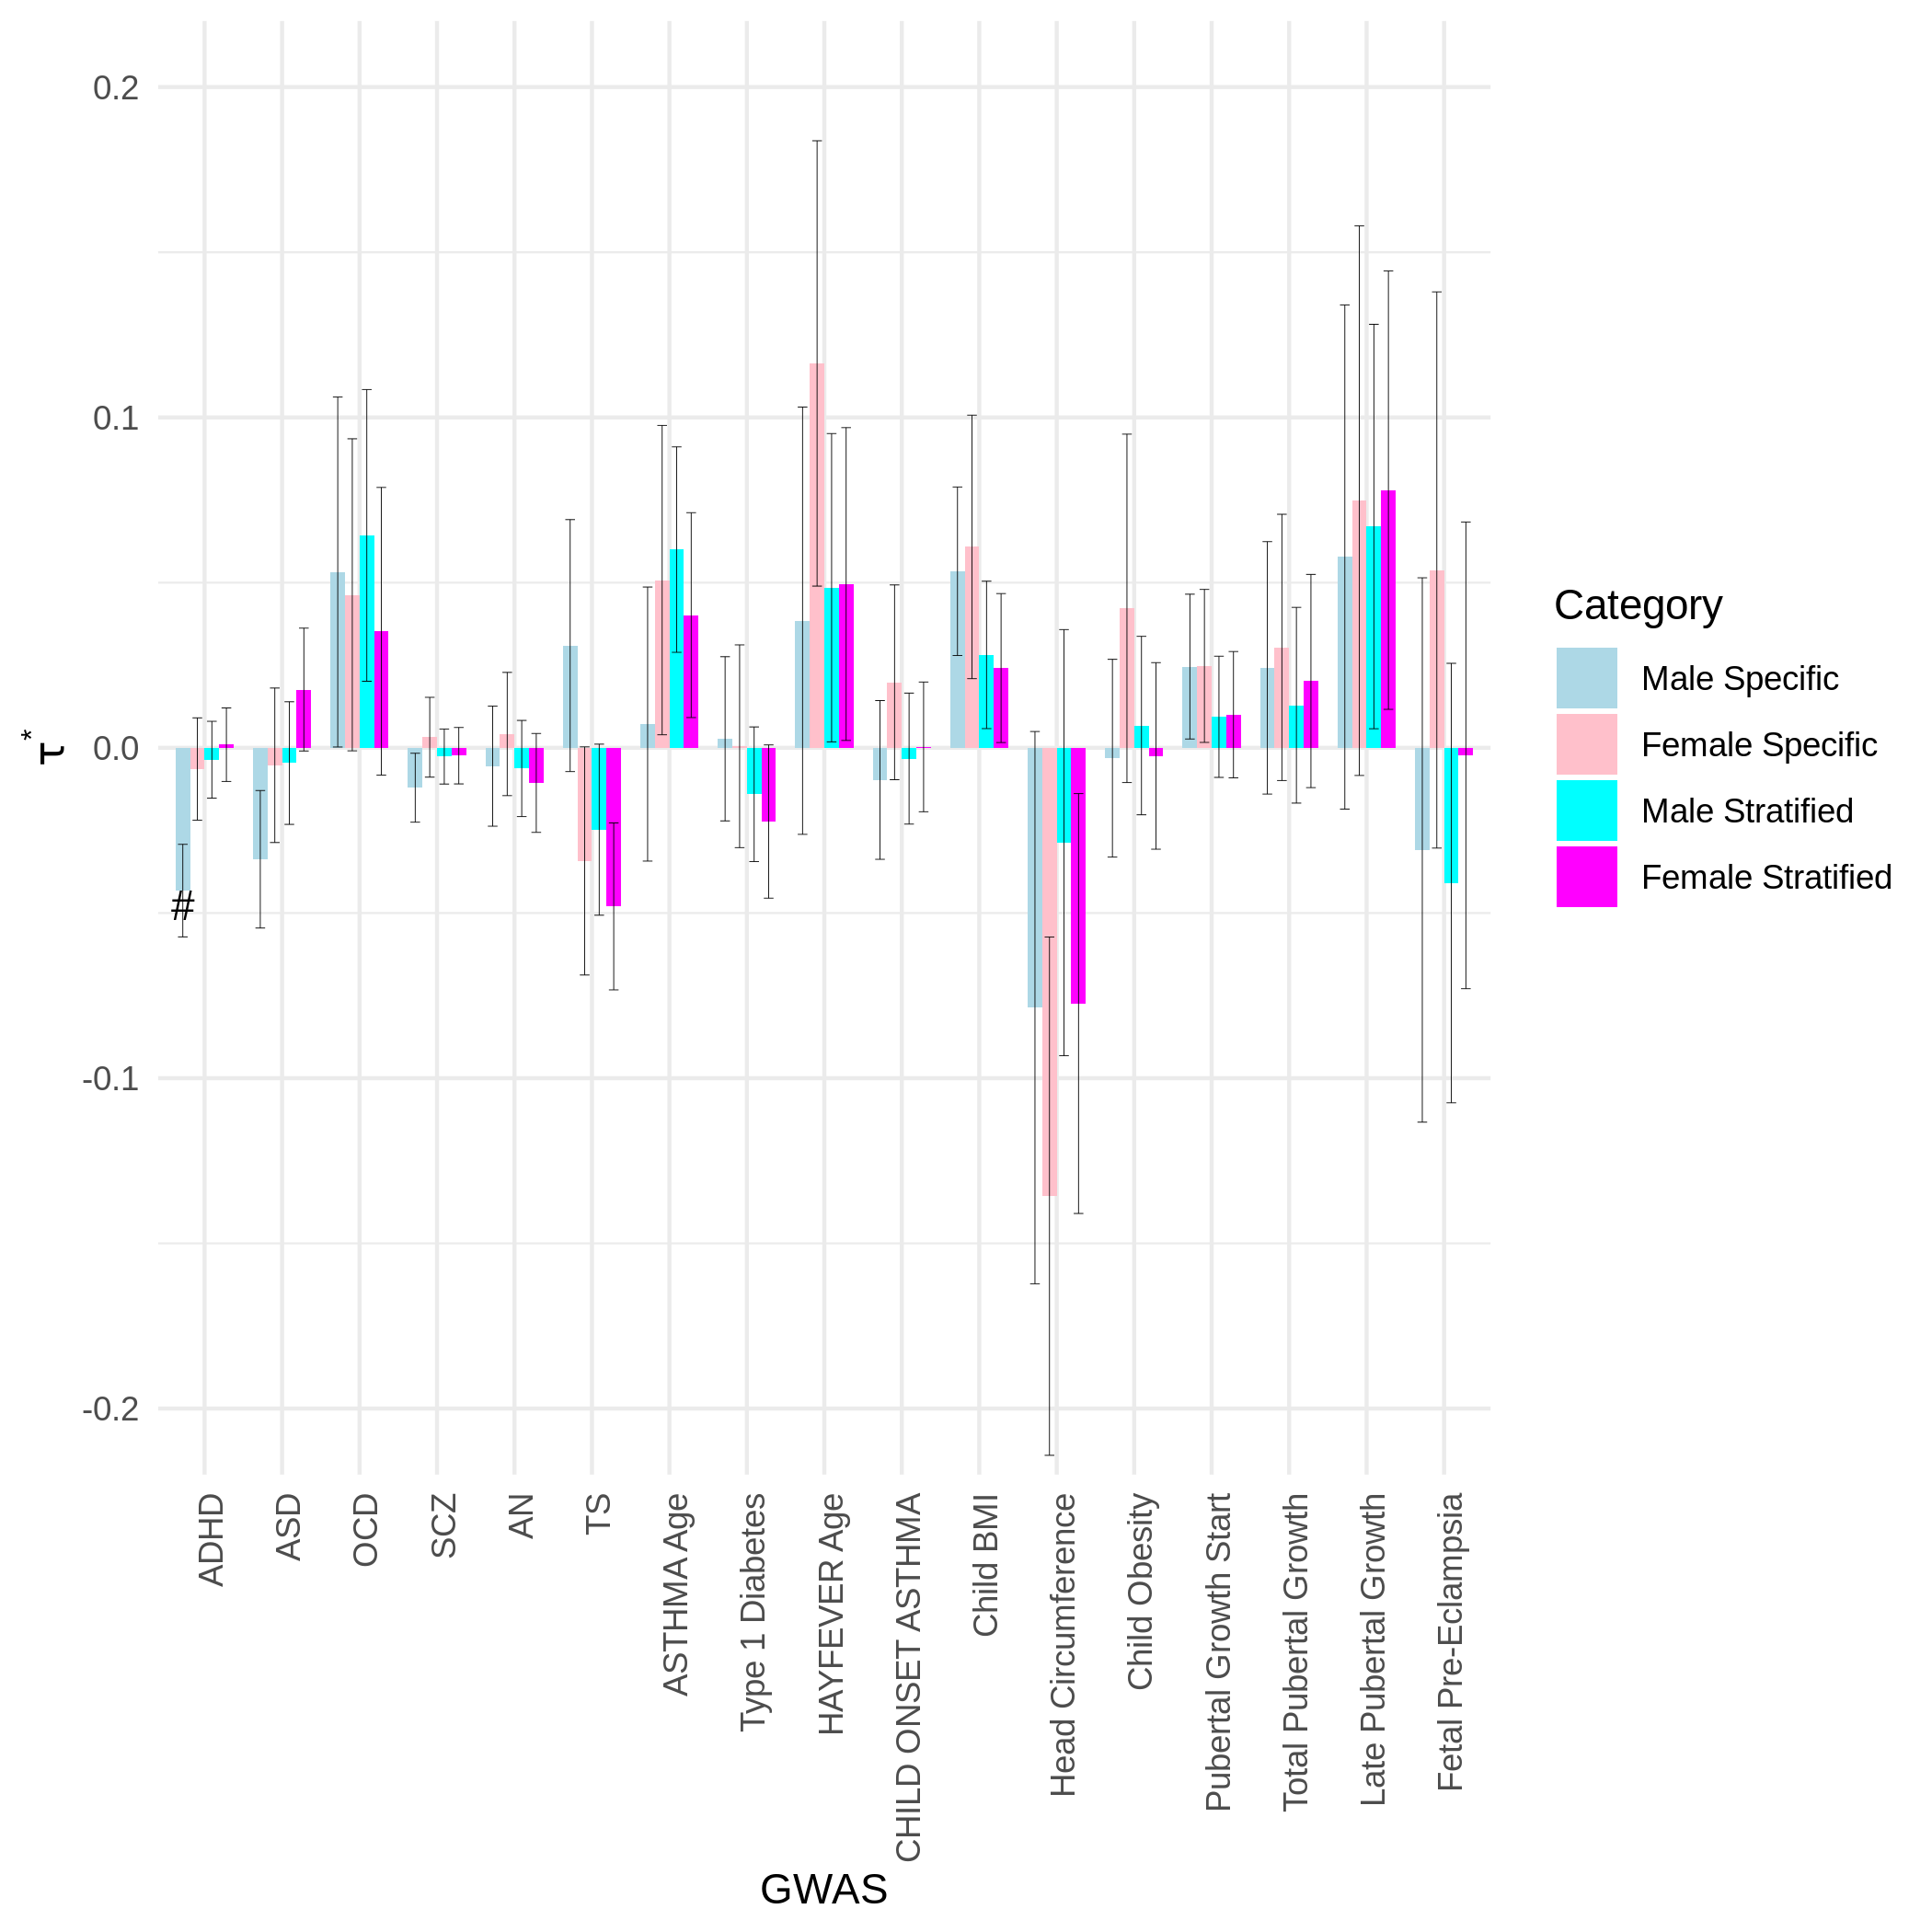

In [32]:
library(ggrepel)
options(width= 10, repr.plot.height= 7, repr.plot.res = 300)
sex_order <- unique(gsub("\\(raw\\)|\\(norm\\)","",c(pgc_GWAS_key,neonatal_GWAS_key)))

combined_df <- rbind(pgc_part_heritability_independent_df,neonatal_part_heritability_independent_df) %>%
    filter(GWAS %in% selected_GWAS) %>%
    mutate(
        normalization = ifelse(grepl("norm",GWAS),"norm","raw"),
        GWAS=gsub("\\(raw\\)|\\(norm\\)","",GWAS),
                tau_p = 2*pnorm(-abs(tau_star/tau_se))

    )
combined_df <- combined_df[,.SD[which.max(h2 / h2_std_error)],by=c("GWAS","Category")]
filtered <- combined_df[        
        grepl("Male Specific|Female Specific",Category) &
        !grepl("Male|Female",GWAS)

]

to_plot_specific <- filtered[,
    .(
        GWAS = factor(GWAS,levels = sex_order),
        tau_star,
        Category=factor(Category,levels=c("Male Specific","Female Specific")),
        tau_se,
        tau_p,
        sig_enrich = p.adjust(tau_p,method="BH") <0.05,
                h2,
        h2_std_error
    )
]
to_plot_specific[,`:=`(sig_enrich_GWAS = p.adjust(tau_p,method="BH") < 0.05),by="GWAS"]
to_plot_specific[, `:=`(h2_z = h2 /h2_std_error)]
to_plot_specific
unique(pgc_part_heritability_independent_df$Category)
filtered <- combined_df[        
        grepl("Male Stratified|Female Stratified",Category) &
        !grepl("Male|Female",GWAS)

]

to_plot_stratified <- filtered[,
    .(
        GWAS = factor(GWAS,levels = sex_order),
        tau_star,
        Category=factor(Category,levels=c("Male Stratified","Female Stratified")),
        tau_se,
        tau_p,
        sig_enrich = p.adjust(tau_p,method="BH") <0.05,
                h2,
        h2_std_error
    )
]
to_plot_stratified[,`:=`(sig_enrich_GWAS = p.adjust(tau_p,method="BH") < 0.05),by="GWAS"]

to_plot_stratified[, `:=`(h2_z = h2 /h2_std_error)]
to_plot_stratified
rbind(to_plot_specific,to_plot_stratified)
ggplot(
    rbind(to_plot_specific,to_plot_stratified),
    aes(
        GWAS,
        tau_star,
        fill = Category,
        #color=GWAS_group,
        label=ifelse(sig_enrich,"*",ifelse(sig_enrich_GWAS,"#","")),
        ymin= tau_star - tau_se,
        ymax=tau_star + tau_se
    )
)+
    geom_text(color="black",position=position_dodge(width=0.75),vjust=1)+
    geom_col(position=position_dodge(width=0.75),width=0.75)+
    geom_errorbar(width=0.5,size=0.1,position=position_dodge(width=0.75)) + 
    scale_fill_manual(values=c("light blue","pink","cyan","magenta"))+
    coord_cartesian(ylim=c(-0.2,0.2))+
    labs(y=bquote(tau^"*"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=90,hjust=1,vjust=0.75))

GWAS                 
1  SCZ                  
2  TS                   
3  ADHD                 
4  ASD                  
5  OCD                  
6  AN                   
7  SCZ                  
8  TS                   
9  ADHD                 
10 ASD                  
11 OCD                  
12 AN                   
13 CHILD ONSET ASTHMA   
14 Child BMI            
15 Head Circumference   
16 Child Obesity        
17 Pubertal Growth Start
18 Total Pubertal Growth
19 Late Pubertal Growth 
20 Type 1 Diabetes      
21 ASTHMA Age           
22 HAYFEVER Age         
23 Fetal Pre-Eclampsia  
24 CHILD ONSET ASTHMA   
25 Child BMI            
26 Head Circumference   
27 Child Obesity        
28 Pubertal Growth Start
29 Total Pubertal Growth
30 Late Pubertal Growth 
31 Type 1 Diabetes      
32 ASTHMA Age           
33 HAYFEVER Age         
34 Fetal Pre-Eclampsia  
   tau_star     
1  -0.0007588782
2   0.0068115810
3  -0.0020606705
4  -0.0026132116
5  -0.0057815282
6  -0.0024492523
7  -0.0019467606
8  -0.0392238646
9   0.0020604426
10 -0.0029835871
11  0.0383727483
12 -0.0133180610
13  0.0139143779
14  0.0268514276
15 -0.0071457502
16  0.0232264103
17 -0.0053724270
18  0.0354205326
19  0.0007526405
20 -0.0283088946
21  0.0675291742
22  0.0234241930
23  0.0081351540
24 -0.0077303637
25  0.0168942472
26 -0.0563857238
27  0.0013412993
28  0.0098811923
29 -0.0049736713
30  0.0818253354
31 -0.0177954725
32  0.0491230410
33  0.0406894554
34 -0.0250332867
   Category  
1  Cord Blood
2  Cord Blood
3  Cord Blood
4  Cord Blood
5  Cord Blood
6  Cord Blood
7  Cross-sex 
8  Cross-sex 
9  Cross-sex 
10 Cross-sex 
11 Cross-sex 
12 Cross-sex 
13 Cord Blood
14 Cord Blood
15 Cord Blood
16 Cord Blood
17 Cord Blood
18 Cord Blood
19 Cord Blood
20 Cord Blood
21 Cord Blood
22 Cord Blood
23 Cord Blood
24 Cross-sex 
25 Cross-sex 
26 Cross-sex 
27 Cross-sex 
28 Cross-sex 
29 Cross-sex 
30 Cross-sex 
31 Cross-sex 
32 Cross-sex 
33 Cross-sex 
34 Cross-sex 
   tau_se     
1  0.006707662
2  0.017404704
3  0.009433878
4  0.013113191
5  0.026208450
6  0.010711483
7  0.008473033
8  0.026093093
9  0.011346271
10 0.017646841
11 0.041872685
12 0.014506183
13 0.017655972
14 0.019988141
15 0.037829962
16 0.020976130
17 0.010998741
18 0.024232661
19 0.035652744
20 0.021098568
21 0.029657466
22 0.028351905
23 0.045014740
24 0.018539946
25 0.020223814
26 0.061585668
27 0.025478256
28 0.018790418
29 0.030526928
30 0.062126049
31 0.020212467
32 0.029363301
33 0.046267533
34 0.069221799
   tau_p     
1  0.90992272
2  0.69552792
3  0.82709173
4  0.84204284
5  0.82540556
6  0.81913575
7  0.81827860
8  0.13278030
9  0.85589943
10 0.86573999
11 0.35944938
12 0.35856887
13 0.43064794
14 0.17915287
15 0.85017802
16 0.26817369
17 0.62522520
18 0.14382737
19 0.98315766
20 0.17967876
21 0.02278799
22 0.40869366
23 0.85658579
24 0.67670973
25 0.40351276
26 0.35989474
27 0.95801487
28 0.59898315
29 0.87057564
30 0.18780988
31 0.37863150
32 0.09433911
33 0.37916350
34 0.71762199
   sig_enrich
1  FALSE     
2  FALSE     
3  FALSE     
4  FALSE     
5  FALSE     
6  FALSE     
7  FALSE     
8  FALSE     
9  FALSE     
10 FALSE     
11 FALSE     
12 FALSE     
13 FALSE     
14 FALSE     
15 FALSE     
16 FALSE     
17 FALSE     
18 FALSE     
19 FALSE     
20 FALSE     
21 FALSE     
22 FALSE     
23 FALSE     
24 FALSE     
25 FALSE     
26 FALSE     
27 FALSE     
28 FALSE     
29 FALSE     
30 FALSE     
31 FALSE     
32 FALSE     
33 FALSE     
34 FALSE     
   GWAS_group      
1  Neuropsychiatric
2  Neuropsychiatric
3  Neuropsychiatric
4  Neuropsychiatric
5  Neuropsychiatric
6  Neuropsychiatric
7  Neuropsychiatric
8  Neuropsychiatric
9  Neuropsychiatric
10 Neuropsychiatric
11 Neuropsychiatric
12 Neuropsychiatric
13 Neonatal        
14 Neonatal        
15 Neonatal        
16 Neonatal        
17 Neonatal        
18 Neonatal        
19 Neonatal        
20 Neonatal        
21 Neonatal        
22 Neonatal        
23 Neonatal        
24 Neonatal        
25 Neonatal        
26 Neonatal       

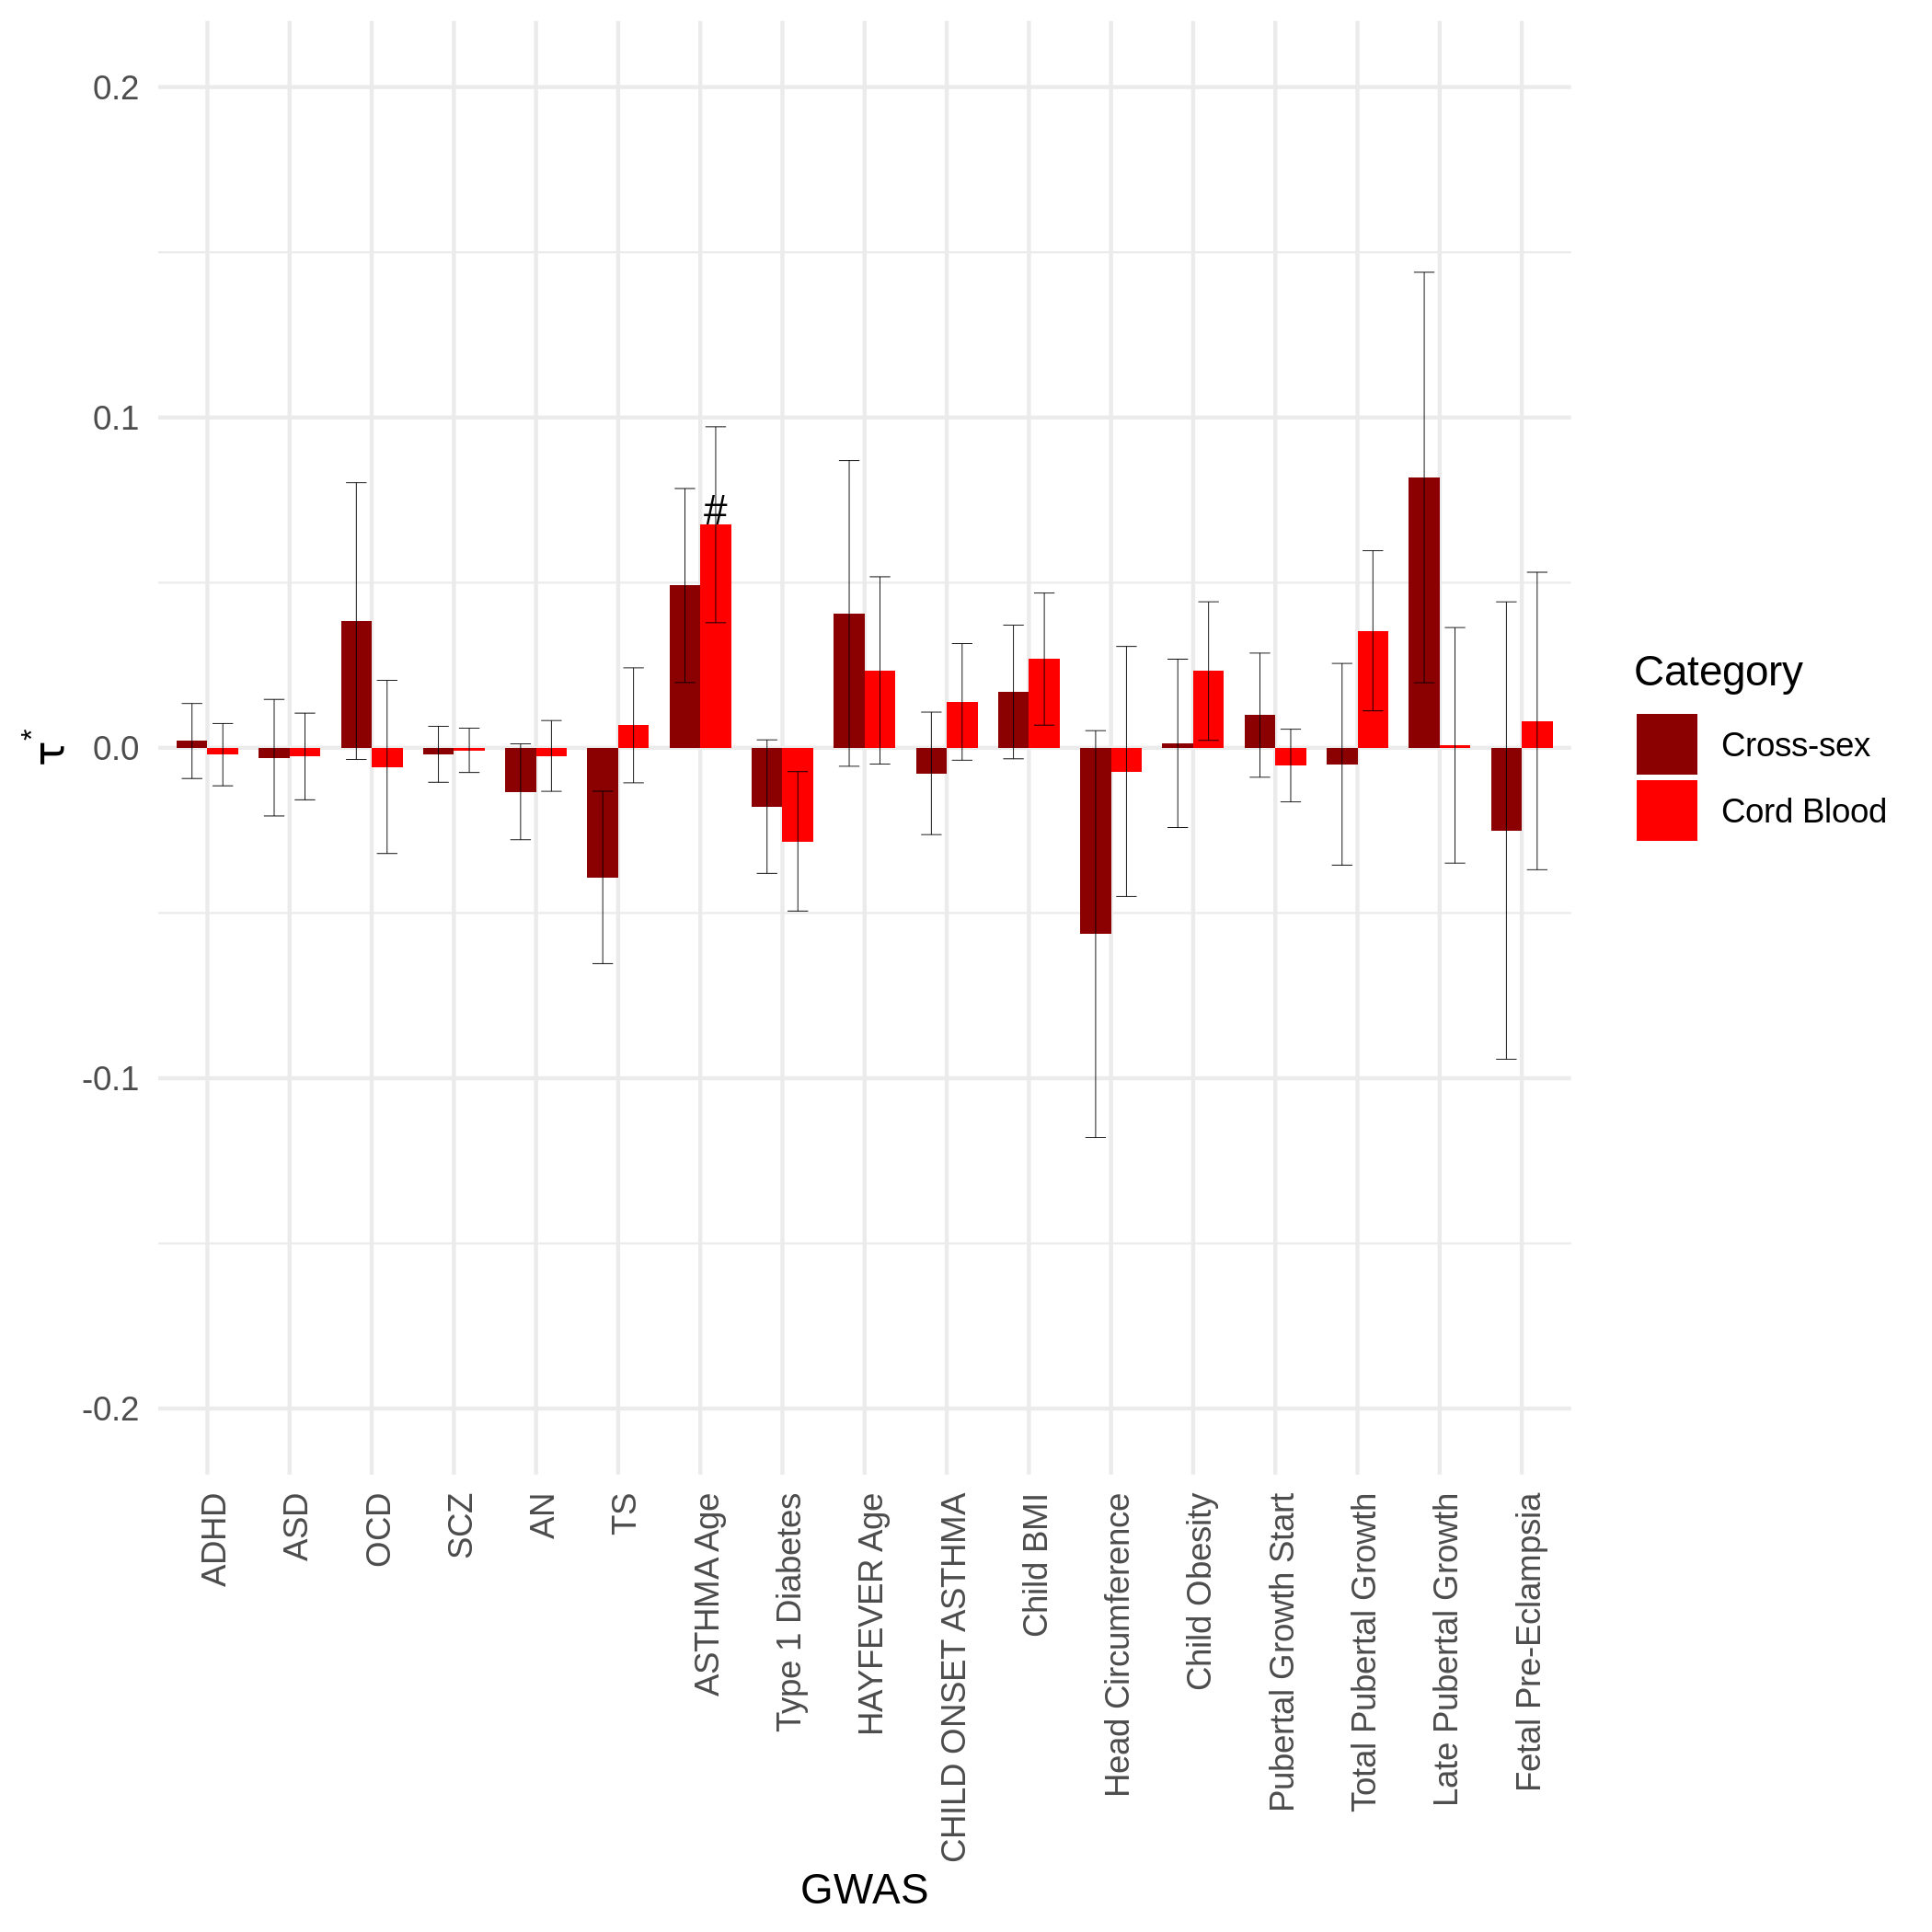

In [33]:
filtered <- combined_df[
        grepl("Cross-sex|Cord Blood",Category) &
        !grepl("Male|Female",GWAS) 
]

to_plot <- filtered[,
    .(
        GWAS = factor(GWAS,levels = sex_order),
        tau_star,
        Category=factor(Category,levels=c("Cross-sex","Cord Blood")),
        tau_se,
        tau_p,
        sig_enrich = p.adjust(tau_p,method="BH") <0.05,
        GWAS_group = ifelse(GWAS %in% pgc_GWAS_key,"Neuropsychiatric","Neonatal"),
        h2,
        h2_std_error
    )
]
to_plot[,`:=`(sig_enrich_GWAS = p.adjust(tau_p,method="BH") < 0.05),by="GWAS"]
ggplot(
    to_plot,
    aes(
        GWAS,
        tau_star,
        fill = Category,
        #color=GWAS_group,
        label=ifelse(sig_enrich,"*",ifelse(sig_enrich_GWAS,"#","")),
        ymin= tau_star - tau_se,
        ymax=tau_star + tau_se
    )
)+
    geom_text(color="black",position=position_dodge(width=0.75),vjust=0)+
    geom_col(position=position_dodge(width=0.75),width=0.75)+
    geom_errorbar(width=0.5,size=0.1,position=position_dodge(width=0.75)) + 
    scale_fill_manual(values=c("dark red","red"))+
    coord_cartesian(ylim=c(-0.2,0.2))+
    labs(y=bquote(tau^"*"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=90,hjust=1,vjust=0.75))
to_plot[, `:=`(h2_z = h2 /h2_std_error)]
to_plot

GWAS                 
1  OCD                  
2  SCZ                  
3  ADHD                 
4  ASD                  
5  SCZ                  
6  ADHD                 
7  Pubertal Growth Start
8  Total Pubertal Growth
9  ASTHMA Age           
10 HAYFEVER Age         
11 Pubertal Growth Start
12 Total Pubertal Growth
13 Late Pubertal Growth 
14 ASTHMA Age           
   tau_star    
1   0.078134705
2  -0.010056712
3  -0.010175251
4  -0.002937090
5  -0.001003209
6  -0.029107613
7   0.017644752
8  -0.023100099
9   0.087210649
10  0.106604180
11  0.072759747
12 -0.023190295
13  0.103045360
14 -0.048381030
   Category       
1  Female Specific
2  Female Specific
3  Female Specific
4  Male Specific  
5  Male Specific  
6  Male Specific  
7  Female Specific
8  Female Specific
9  Female Specific
10 Female Specific
11 Male Specific  
12 Male Specific  
13 Male Specific  
14 Male Specific  
   tau_se     
1  0.062074903
2  0.013898955
3  0.074009404
4  0.020464767
5  0.009504688
6  0.019763537
7  0.037053873
8  0.055237131
9  0.086413048
10 0.097409175
11 0.052778851
12 0.072658450
13 0.054565462
14 0.060863413
   tau_p     
1  0.20813275
2  0.46933662
3  0.89064673
4  0.88588004
5  0.91594032
6  0.14080667
7  0.63393772
8  0.67580181
9  0.31286430
10 0.27378148
11 0.16802500
12 0.74959867
13 0.05896258
14 0.42666495
   sig_enrich
1  FALSE     
2  FALSE     
3  FALSE     
4  FALSE     
5  FALSE     
6  FALSE     
7  FALSE     
8  FALSE     
9  FALSE     
10 FALSE     
11 FALSE     
12 FALSE     
13 FALSE     
14 FALSE     
   GWAS_group      
1  Neuropsychiatric
2  Neuropsychiatric
3  Neuropsychiatric
4  Neuropsychiatric
5  Neuropsychiatric
6  Neuropsychiatric
7  Neonatal        
8  Neonatal        
9  Neonatal        
10 Neonatal        
11 Neonatal        
12 Neonatal        
13 Neonatal        
14 Neonatal        
   sex    
1  Females
2  Females
3  Females
4  Males  
5  Males  
6  Males  
7  Females
8  Females
9  Females
10 Females
11 Males  
12 Males  
13 Males  
14 Males  
   h2    
1  0.3813
2  0.4686
3  0.1026
4  0.2630
5  0.5956
6  0.2623
7  0.6394
8  0.4624
9  0.1252
10 0.1686
11 0.4630
12 0.4088
13 0.5925
14 0.1869
   h2_std_error
1  0.1663      
2  0.0392      
3  0.0404      
4  0.0372      
5  0.0316      
6  0.0329      
7  0.1331      
8  0.1354      
9  0.0416      
10 0.0720      
11 0.1280      
12 0.1649      
13 0.1866      
14 0.0498      
   sig_enrich_GWAS
1  FALSE          
2  FALSE          
3  FALSE          
4  FALSE          
5  FALSE          
6  FALSE          
7  FALSE          
8  FALSE          
9  FALSE          
10 FALSE          
11 FALSE          
12 FALSE          
13 FALSE          
14 FALSE

GWAS                 
1  OCD                  
2  SCZ                  
3  ADHD                 
4  ASD                  
5  SCZ                  
6  ADHD                 
7  Pubertal Growth Start
8  Total Pubertal Growth
9  ASTHMA Age           
10 HAYFEVER Age         
11 Pubertal Growth Start
12 Total Pubertal Growth
13 Late Pubertal Growth 
14 ASTHMA Age           
   tau_star    
1   0.074719434
2  -0.018118449
3   0.008119761
4   0.021744833
5   0.010341142
6   0.009467445
7  -0.029572380
8   0.010930271
9   0.015985591
10 -0.020404153
11  0.016418153
12 -0.064001838
13  0.036487377
14  0.051351743
   Category         
1  Female Stratified
2  Female Stratified
3  Female Stratified
4  Male Stratified  
5  Male Stratified  
6  Male Stratified  
7  Female Stratified
8  Female Stratified
9  Female Stratified
10 Female Stratified
11 Male Stratified  
12 Male Stratified  
13 Male Stratified  
14 Male Stratified  
   tau_se     
1  0.058185322
2  0.012404213
3  0.056221262
4  0.016677605
5  0.008312877
6  0.015048139
7  0.026961486
8  0.046771223
9  0.055140213
10 0.065785830
11 0.042091056
12 0.056786886
13 0.046154389
14 0.042896340
   tau_p    
1  0.1990850
2  0.1441063
3  0.8851648
4  0.1922901
5  0.2135030
6  0.5292549
7  0.2727122
8  0.8152206
9  0.7718866
10 0.7564391
11 0.6964902
12 0.2597200
13 0.4292063
14 0.2312627
   sig_enrich
1  FALSE     
2  FALSE     
3  FALSE     
4  FALSE     
5  FALSE     
6  FALSE     
7  FALSE     
8  FALSE     
9  FALSE     
10 FALSE     
11 FALSE     
12 FALSE     
13 FALSE     
14 FALSE     
   GWAS_group      
1  Neuropsychiatric
2  Neuropsychiatric
3  Neuropsychiatric
4  Neuropsychiatric
5  Neuropsychiatric
6  Neuropsychiatric
7  Neonatal        
8  Neonatal        
9  Neonatal        
10 Neonatal        
11 Neonatal        
12 Neonatal        
13 Neonatal        
14 Neonatal        
   sex    
1  Females
2  Females
3  Females
4  Males  
5  Males  
6  Males  
7  Females
8  Females
9  Females
10 Females
11 Males  
12 Males  
13 Males  
14 Males  
   h2    
1  0.3813
2  0.4686
3  0.1026
4  0.2630
5  0.5956
6  0.2623
7  0.6394
8  0.4624
9  0.1252
10 0.1686
11 0.4630
12 0.4088
13 0.5925
14 0.1869
   h2_std_error
1  0.1663      
2  0.0392      
3  0.0404      
4  0.0372      
5  0.0316      
6  0.0329      
7  0.1331      
8  0.1354      
9  0.0416      
10 0.0720      
11 0.1280      
12 0.1649      
13 0.1866      
14 0.0498      
   sig_enrich_GWAS
1  FALSE          
2  FALSE          
3  FALSE          
4  FALSE          
5  FALSE          
6  FALSE          
7  FALSE          
8  FALSE          
9  FALSE          
10 FALSE          
11 FALSE          
12 FALSE          
13 FALSE          
14 FALSE

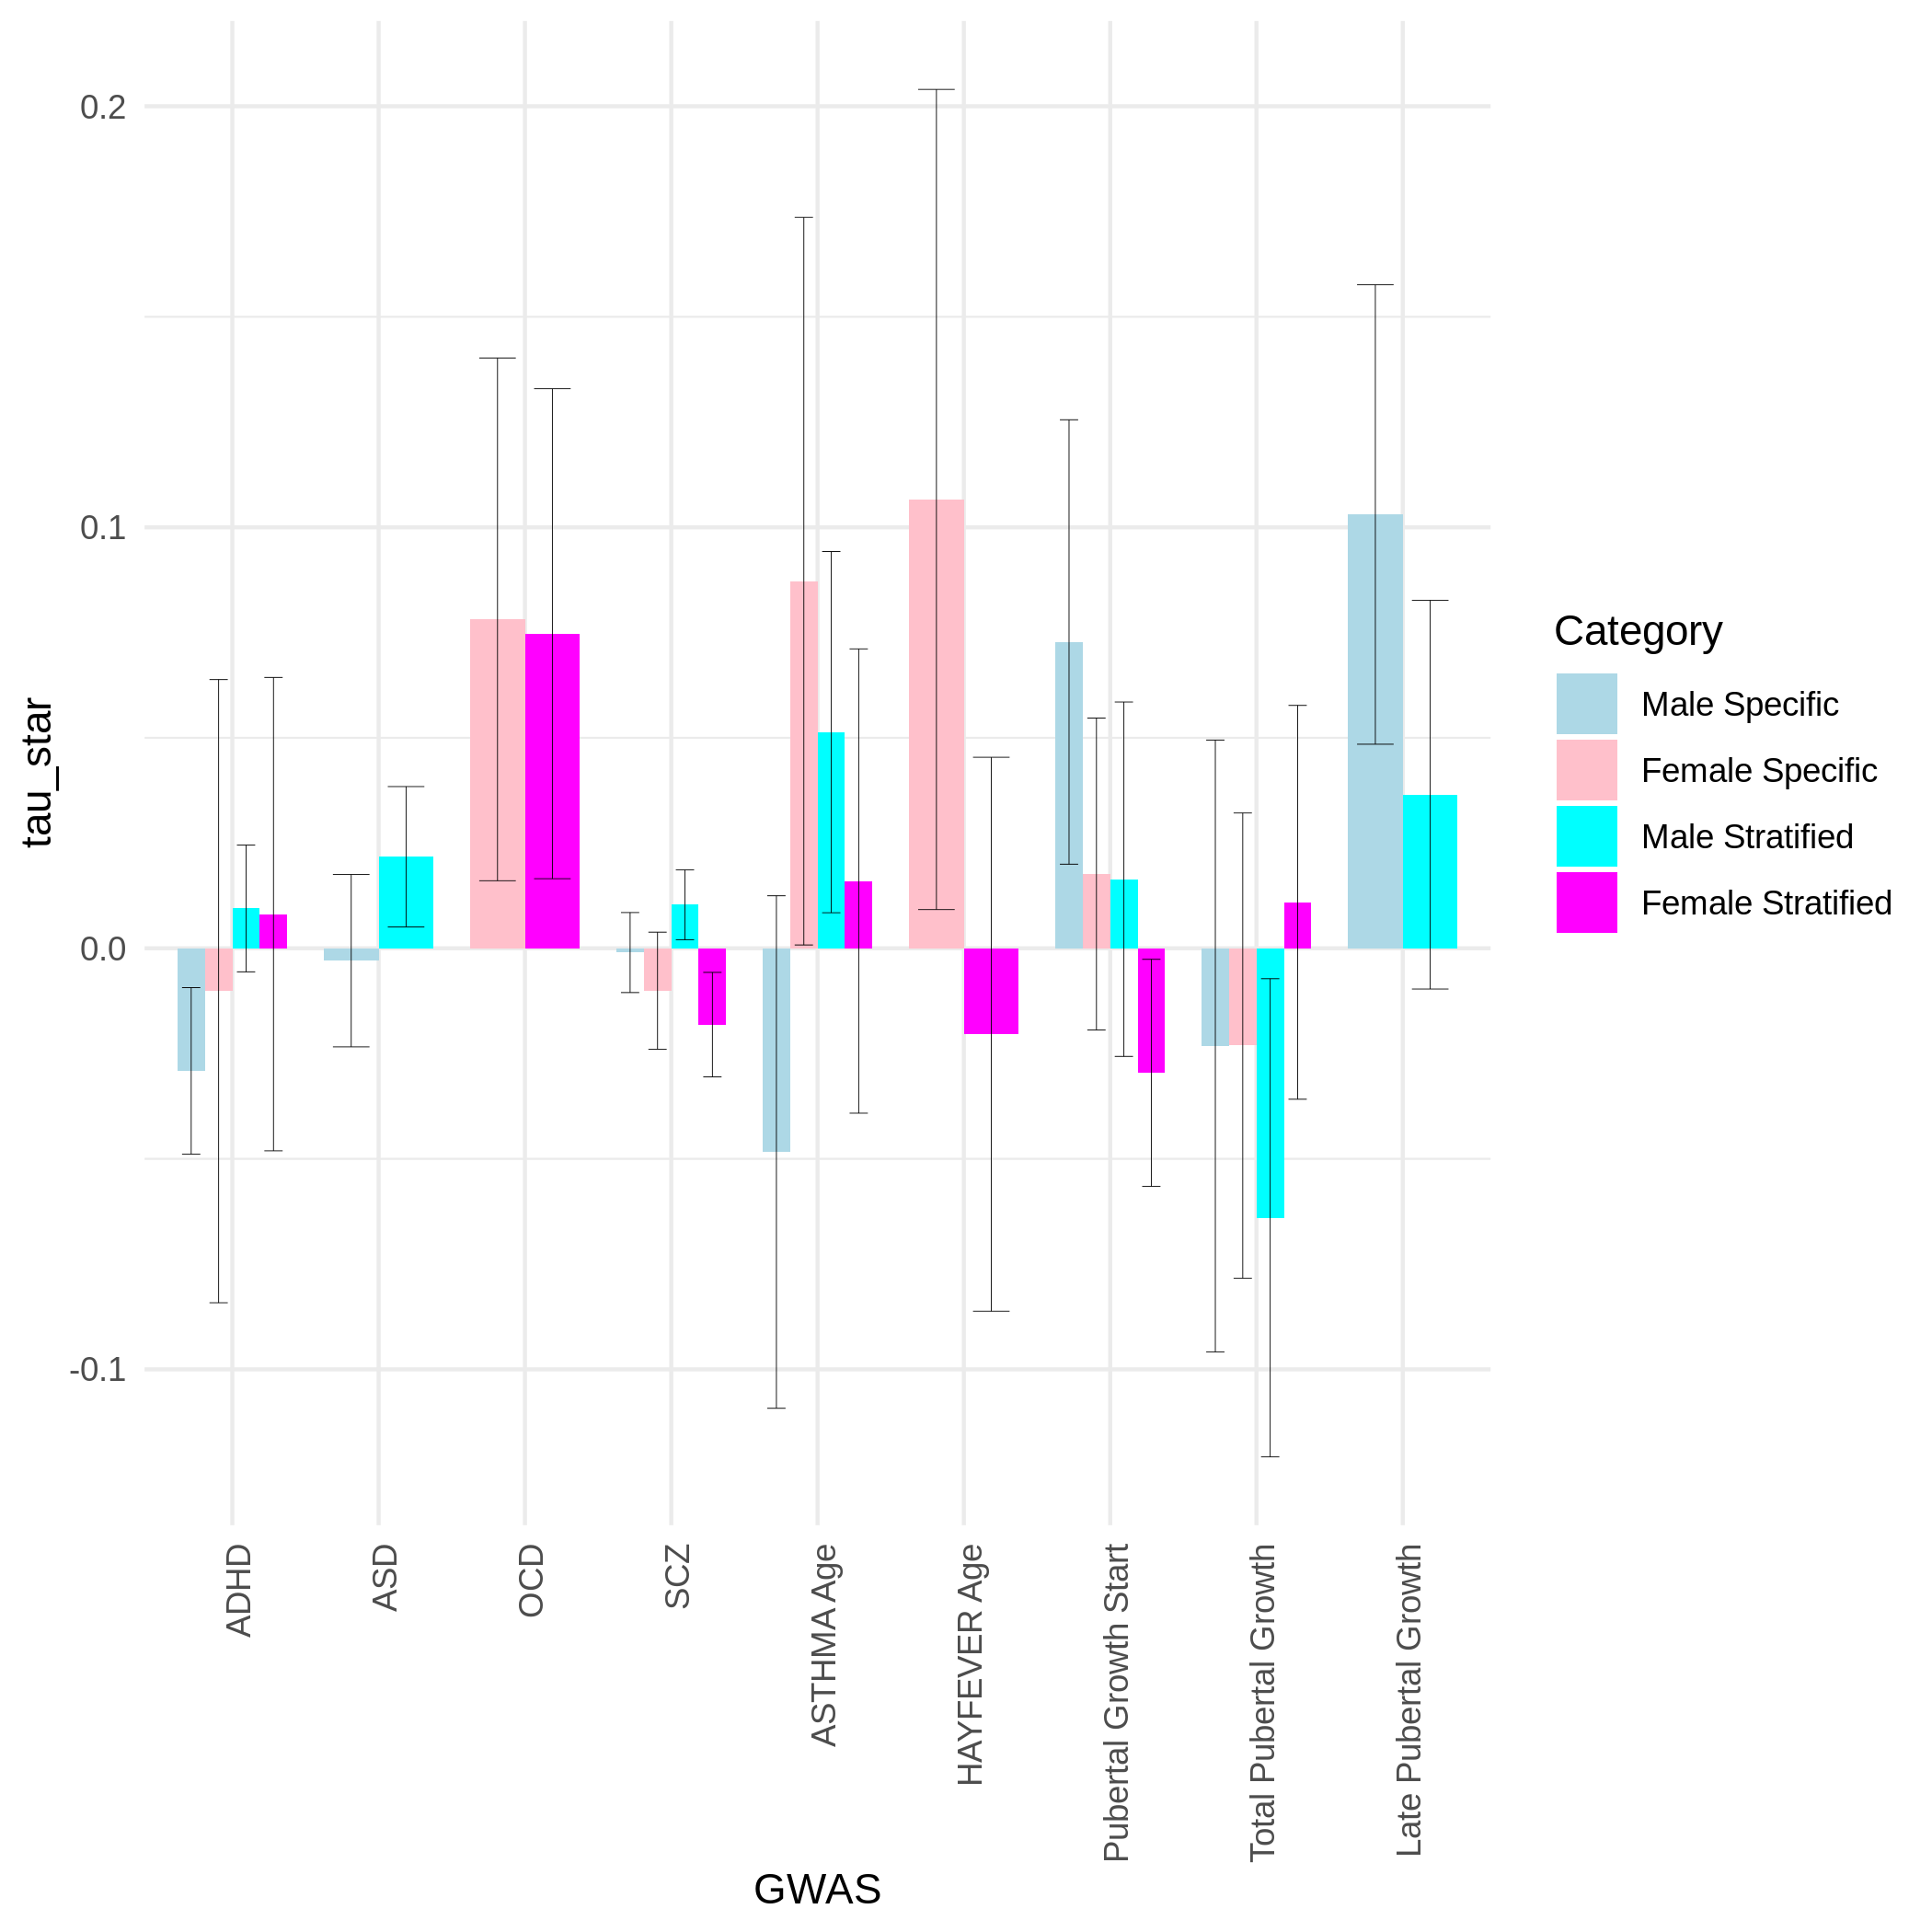

In [24]:
filtered <- combined_df[
(        (grepl("Male Specific",Category) & grepl("Male",GWAS)) | 
        (grepl("Female Specific",Category) & grepl("Female",GWAS)))
]
filtered[,`:=`(GWAS = gsub(" Males| Females","",GWAS),sex = gsub("(.*) (Males|Females)","\\2",GWAS))]

to_plot_specific <- filtered[,
    .(
        GWAS=factor(GWAS,levels = c("RMDD",sex_order)),
        tau_star,
        Category=factor(Category,levels=c("Male Specific","Female Specific")),
        tau_se,
        tau_p,
        sig_enrich = p.adjust(tau_p,method="BH") <0.05,
        GWAS_group = ifelse(GWAS %in% pgc_GWAS_key,"Neuropsychiatric","Neonatal"),
        sex,
                h2,
        h2_std_error
    )
]
to_plot_specific[,`:=`(sig_enrich_GWAS = p.adjust(tau_p,method="BH") < 0.05),by="GWAS"]
filtered <- combined_df[
(        (grepl("Male Stratified",Category) & grepl("Male",GWAS)) | 
        (grepl("Female Stratified",Category) & grepl("Female",GWAS)))
]
filtered[,`:=`(GWAS = gsub(" Males| Females","",GWAS),sex = gsub("(.*) (Males|Females)","\\2",GWAS))]

to_plot_stratified <- filtered[,
    .(
        GWAS=factor(GWAS,levels = c("RMDD",sex_order)),
        tau_star,
        Category=factor(Category,levels=c("Male Stratified","Female Stratified")),
        tau_se,
        tau_p,
        sig_enrich = p.adjust(tau_p,method="BH") <0.05,
        GWAS_group = ifelse(GWAS %in% pgc_GWAS_key,"Neuropsychiatric","Neonatal"),
        sex,
                h2,
        h2_std_error
    )
]
to_plot_stratified[,`:=`(sig_enrich_GWAS = p.adjust(tau_p,method="BH") < 0.05),by="GWAS"]

to_plot_specific
to_plot_stratified
ggplot(
    rbind(to_plot_specific,to_plot_stratified),
    aes(
        GWAS,
        tau_star,
        fill = Category,
        #color=GWAS_group,
        label=ifelse(sig_enrich,"*",ifelse(sig_enrich_GWAS,"#","")),
        ymin= tau_star - tau_se,
        ymax=tau_star + tau_se
    )
)+
    geom_text(color="black",position=position_dodge(width=0.75),vjust=0)+
    geom_col(position=position_dodge(width=0.75),width=0.75)+
    geom_errorbar(width=0.5,size=0.1,position=position_dodge(width=0.75)) + 
    scale_fill_manual(values=c("light blue","pink","cyan","magenta"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=90,hjust=1,vjust=0.75))

annotation 
1  bin_CPP_her
2  bin_CPP_her
3  bin_CPP_her
4  bin_CPP_her
5  bin_CPP_her
6  bin_CPP_her
7  bin_CPP_her
8  bin_CPP_her
9  bin_CPP_her
10 bin_CPP_her
11 bin_CPP_her
12 bin_CPP_her
   Category         
1  Cord Blood       
2  Cord Blood       
3  Cross-sex        
4  Cross-sex        
5  Female Specific  
6  Female Specific  
7  Female Stratified
8  Female Stratified
9  Male Specific    
10 Male Specific    
11 Male Stratified  
12 Male Stratified  
   GWAS                  
1  Fetal Pre-Eclampsia   
2  Maternal Pre-Eclampsia
3  Fetal Pre-Eclampsia   
4  Maternal Pre-Eclampsia
5  Fetal Pre-Eclampsia   
6  Maternal Pre-Eclampsia
7  Fetal Pre-Eclampsia   
8  Maternal Pre-Eclampsia
9  Fetal Pre-Eclampsia   
10 Maternal Pre-Eclampsia
11 Fetal Pre-Eclampsia   
12 Maternal Pre-Eclampsia
   Prop._SNPs
1  0.11245598
2  0.11245598
3  0.31561413
4  0.31561413
5  0.09232533
6  0.09232533
7  0.27748211
8  0.27748211
9  0.08669942
10 0.08669942
11 0.29167365
12 0.29167365
   Prop._h2  
1  0.14120549
2  0.06304529
3  0.35236918
4  0.39577002
5  0.21596517
6  0.14787883
7  0.35770115
8  0.41082885
9  0.07352620
10 0.10418788
11 0.29325723
12 0.39897017
   Prop._h2_std_error
1  0.09298205        
2  0.09955232        
3  0.16358940        
4  0.22938847        
5  0.15040953        
6  0.12926263        
7  0.16656176        
8  0.21881304        
9  0.13125059        
10 0.11755621        
11 0.15619450        
12 0.21900742        
   Enrichment
1  1.2556512 
2  0.5606219 
3  1.1164557 
4  1.2539680 
5  2.3391756 
6  1.6017146 
7  1.2890962 
8  1.4805597 
9  0.8480588 
10 1.2017138 
11 1.0054293 
12 1.3678650 
   Enrichment_std_error
1  0.8268306           
2  0.8852558           
3  0.5183209           
4  0.7268004           
5  1.6291252           
6  1.4000775           
7  0.6002613           
8  0.7885663           
9  1.5138578           
10 1.3559054           
11 0.5355112           
12 0.7508646           
   Enrichment_p
1  0.7443960   
2  0.5956289   
3  0.8201260   
4  0.7142831   
5  0.3572995   
6  0.6575308   
7  0.6163178   
8  0.4938843   
9  0.9186710   
10 0.8811406   
11 0.9918389   
12 0.5882685   
   Coefficient  
1   1.524540e-10
2   1.427167e-07
3  -2.896083e-10
4  -2.446489e-09
5   1.035491e-09
6  -6.497238e-08
7  -2.760939e-11
8  -6.149639e-08
9  -6.028277e-10
10  2.817931e-08
11 -4.914728e-10
12 -2.727857e-08
   ⋯
1  ⋯
2  ⋯
3  ⋯
4  ⋯
5  ⋯
6  ⋯
7  ⋯
8  ⋯
9  ⋯
10 ⋯
11 ⋯
12 ⋯
   mQTL_group     
1  cord_mqtl      
2  cord_mqtl      
3  marginal       
4  marginal       
5  female_specific
6  female_specific
7  female         
8  female         
9  male_specific  
10 male_specific  
11 male           
12 male           
   h2     
1   0.0055
2  -1.0108
3   0.0055
4  -1.0108
5   0.0055
6  -1.0108
7   0.0055
8  -1.0108
9   0.0055
10 -1.0108
11  0.0055
12 -1.0108
   h2_std_error
1  0.0028      
2  0.6609      
3  0.0028      
4  0.6609      
5  0.0028      
6  0.6609      
7  0.0028      
8  0.6609      
9  0.0028      
10 0.6609      
11 0.0028      
12 0.6609      
   total_SNP
1  1128053  
2     4009  
3  1128053  
4     4009  
5  1128053  
6     4009  
7  1128053  
8     4009  
9  1128053  
10    4009  
11 1128053  
12    4009  
   significant_coef
1  FALSE           
2  FALSE           
3  FALSE           
4  FALSE           
5  FALSE           
6  FALSE           
7  FALSE           
8  FALSE           
9  FALSE           
10 FALSE           
11 FALSE           
12 FALSE           
   significant_enrich
1  FALSE             
2  FALSE             
3  FALSE             
4  FALSE             
5  FALSE             
6  FALSE             
7  FALSE             
8  FALSE             
9  FALSE             
10 FALSE             
11 FALSE             
12 FALSE             
   annot_sd 
1  0.2601717
2  0.2601717
3  0.4214442
4  0.4214442
5  0.2534766
6  0.2534766
7  0.4021482
8  0.4021482
9  0.2500662
10 0.2500662
11 0.4062026
12 0.4062026
   tau_star     
1   8.135154e-03
2  -1.472671e-04
3  -2.503329e-02
4   4.089

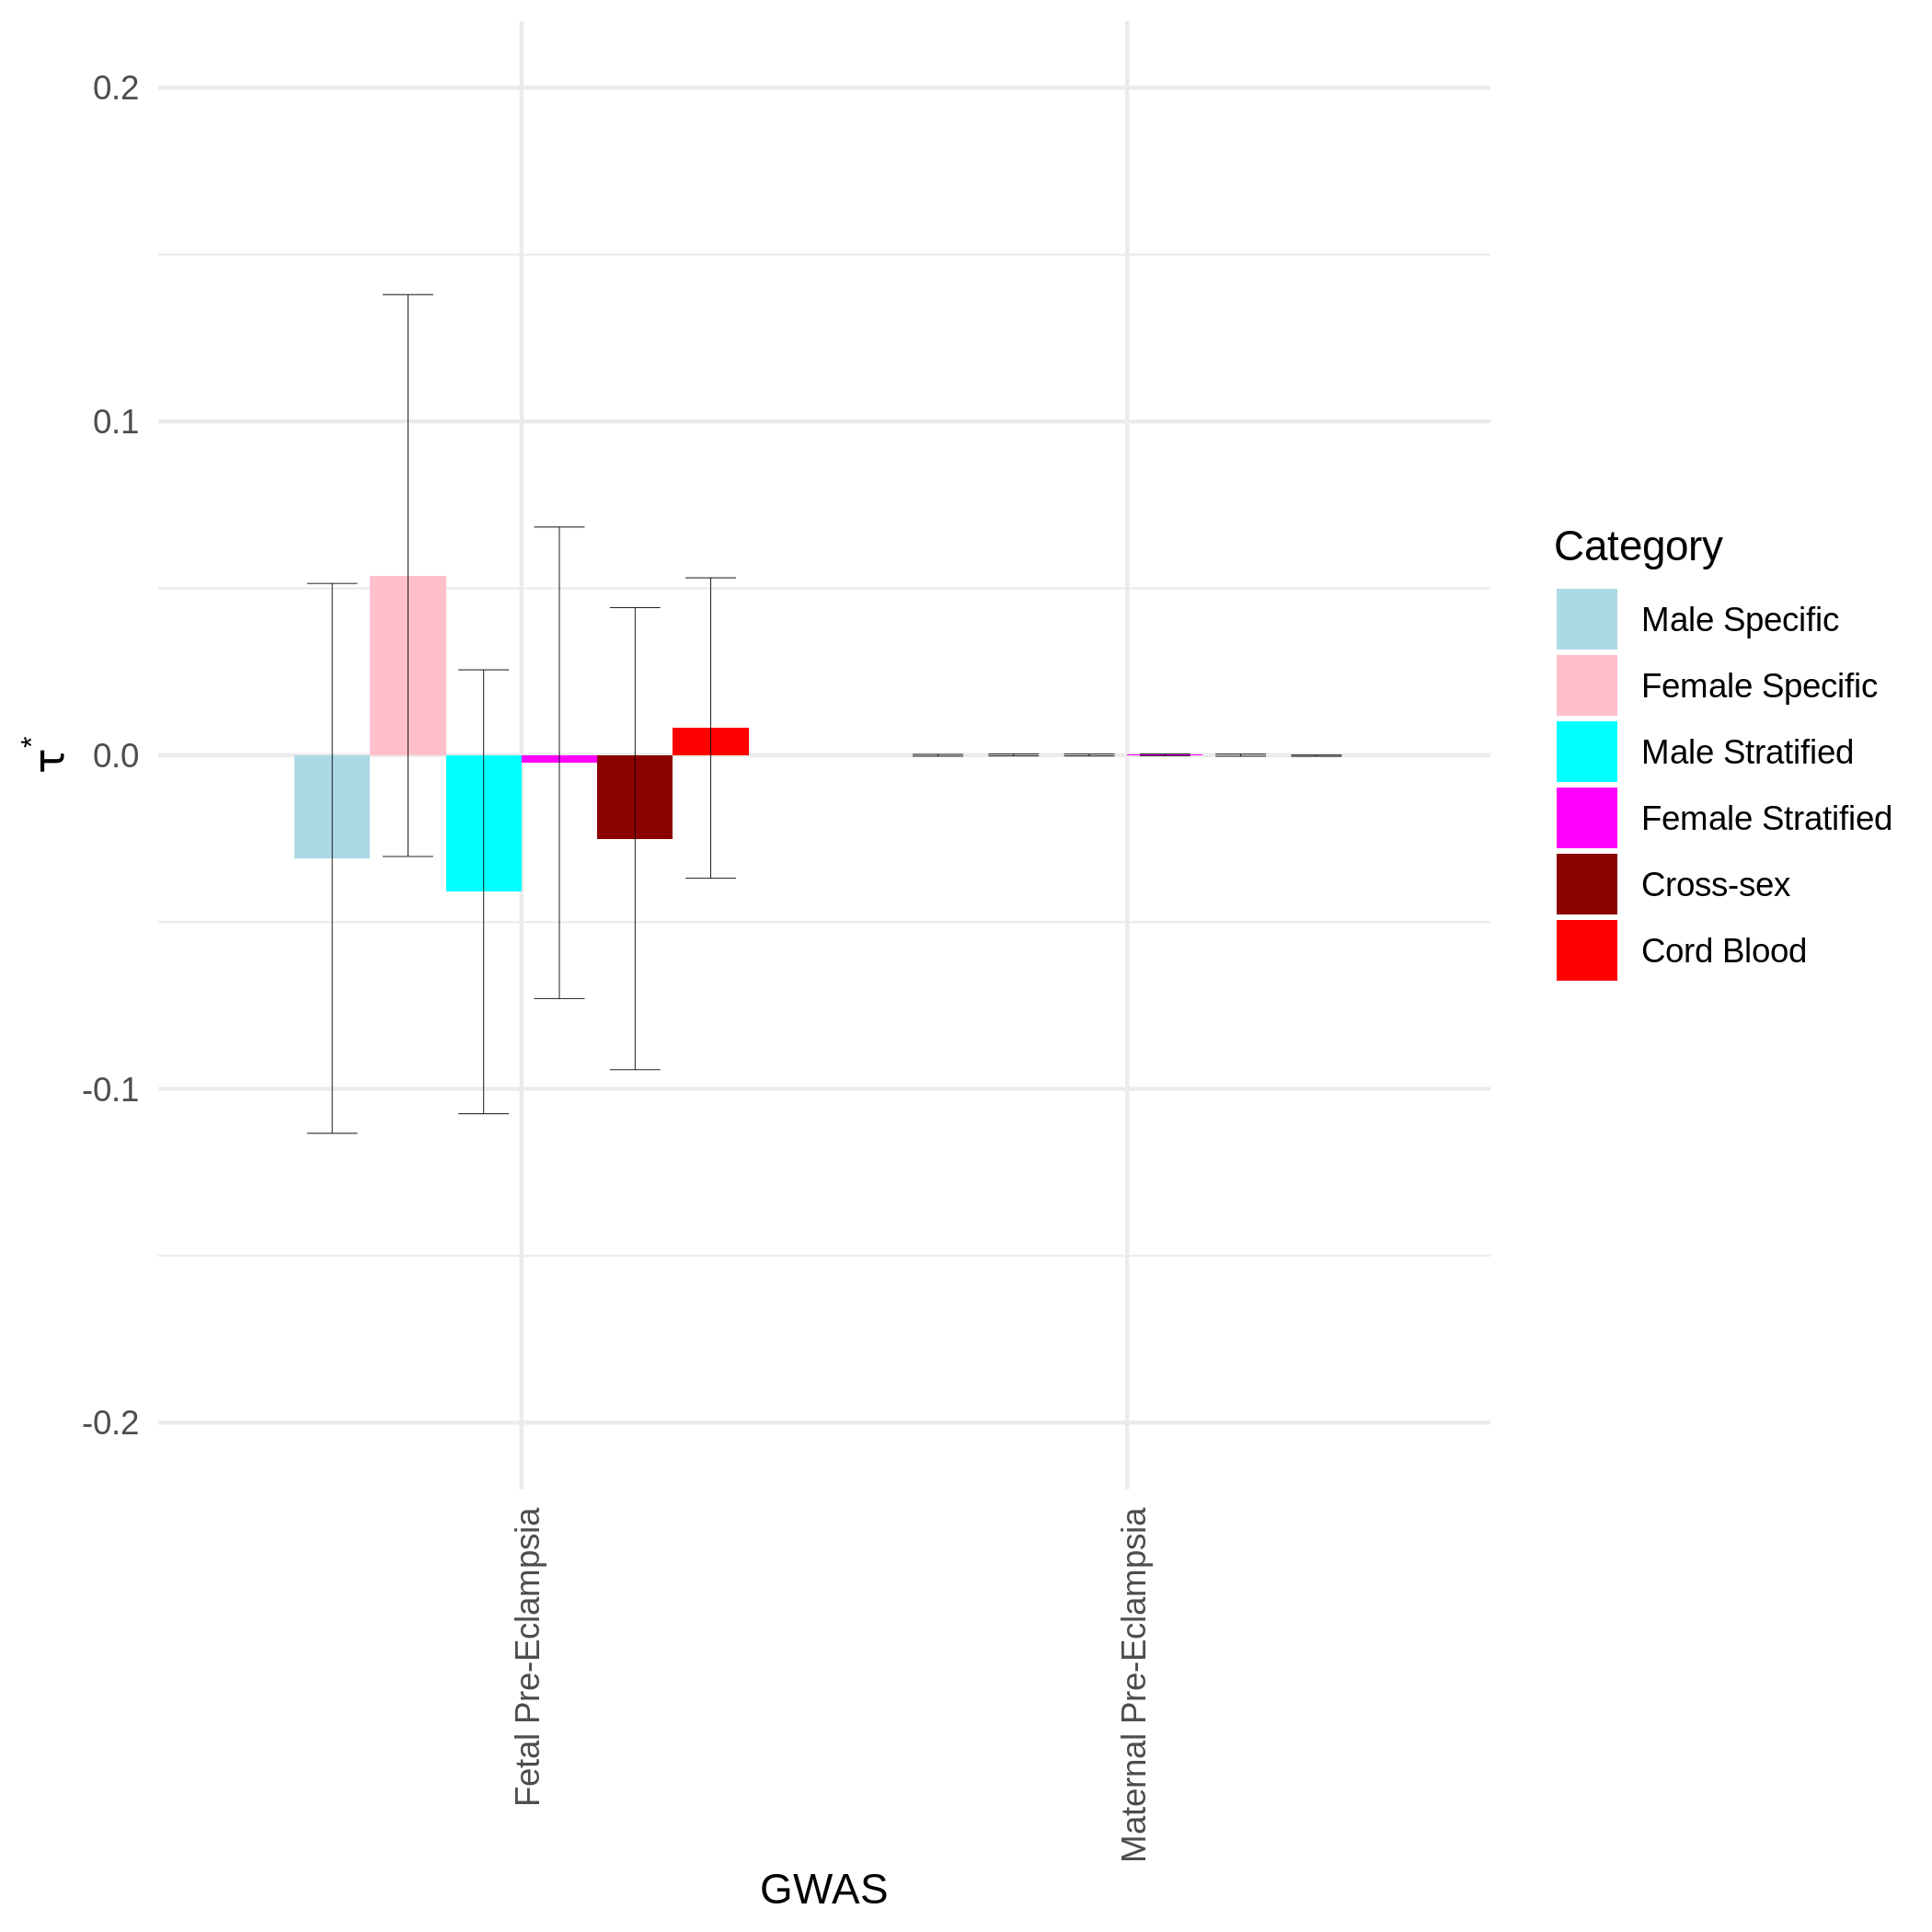

In [34]:
to_plot <- neonatal_part_heritability_independent_df[!grepl("UKBB",GWAS) & grepl("Pre-E",GWAS) & Category != "Sex dependent"]
to_plot$Category <- factor(to_plot$Category, levels =c("Male Specific","Female Specific","Male Stratified", "Female Stratified","Cross-sex", "Cord Blood"))
ggplot(
    to_plot,
    aes(
        GWAS,
        tau_star,
        fill = Category,
        #color=GWAS_group,
        ymin= tau_star - tau_se,
        ymax=tau_star + tau_se
    )
)+
    geom_col(position=position_dodge(width=0.75),width=0.75)+
    geom_errorbar(width=0.5,size=0.1,position=position_dodge(width=0.75)) + 
    scale_fill_manual(values = c("light blue", "pink","cyan","magenta", "dark red" , "red"))+
    coord_cartesian(ylim=c(-0.2,0.2))+
    labs(y=bquote(tau^"*"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=90,hjust=1,vjust=0.75))
to_plot[, `:=`(h2_z = h2 /h2_std_error)]
IRdisplay::display(to_plot)

In [33]:
neonatal_part_heritability_independent_df[grepl("Pre-E",GWAS) & Category == "Cross-sex",.(Category,GWAS,h2_z= h2 / h2_std_error)]

Category 
1 Cross-sex
2 Cross-sex
3 Cross-sex
  GWAS                         
1 Fetal Pre-Eclampsia          
2 Maternal Pre-Eclampsia       
3 Maternal Pre-Eclampsia (UKBB)
  h2_z     
1  1.964286
2 -1.529430
3  1.279070